In [1]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
from scipy.stats import lognorm
from scipy.stats import norm
import math
#import seaborn as sns
from random import sample
import pandas 
import src.test_strategies
print(scipy.__version__)

([], 0, 1)
([], 0, 0)
0.05399096651318806
1.1.0


In [2]:
graph = {}
with open('fb_graph.pkl', 'rb') as f:
    graph = pickle.load(f)
G = nx.from_dict_of_dicts(graph)

In [3]:
for i in range(len(G.nodes)):
    G.nodes[i]["status"] = "S"
nx.set_node_attributes(G, False, name = "confirmed positive")
nx.set_node_attributes(G, False, name = "tested")
nx.set_node_attributes(G, False, name = "infected")
nx.set_node_attributes(G, None, name = "onset of symptoms")
nx.set_edge_attributes(G, name = "weight", values = 1)

node_deg_pairs = list(G.degree())
node_deg_pairs.sort(key = lambda x: x[1], reverse = True)
node_degrees = [node for node, deg in node_deg_pairs]
G.graph['node_degrees'] = node_degrees

In [4]:
G.nodes.data()

NodeDataView({0: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 1: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 2: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 3: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 4: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 5: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 6: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 7: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 8: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset

In [5]:
quarantine_infectivity = 0.1
confirmed_negative_infectivity = 1
prev_tested = [set(), set(), set(), set(), set()]
ind_to_prev_tested = 0

In [18]:
def run_iteration(G, test = False):
    weight = nx.get_edge_attributes(G, "weight")
    
    S_n = [n for n,v in G.nodes(data=True) if v['status'] == 'S']
    E_n = [n for n,v in G.nodes(data=True) if v['status'] == 'E']
    I_n = [n for n,v in G.nodes(data=True) if v['status'] == 'I']
    H_n = [n for n,v in G.nodes(data=True) if v['status'] == 'H']
    for i in I_n:
        for neighbor in G.neighbors(i):
            if G.nodes[neighbor]["status"] == "S":
                # Multiplying by the weight of the edge is supposed to model decreased 
                # contact after a person is in quarentine
                if random.random() < 0.004576659038901602*G[i][neighbor]["weight"]:
                    G.nodes[neighbor]["status"] = "E"
                    G.nodes[neighbor]["days_since_E"] = 0
        
    for e in E_n:
        G.nodes[e]["days_since_E"] += 1
        days_since_E = G.nodes[e]["days_since_E"]
        if days_since_E == 14: # if you've been asymp for 14 days, you recover
            G.nodes[e]["status"] = "R"
        mu = 1.621
        std = 0.418
        prob = lognorm.pdf(days_since_E, s=std, scale=np.exp(mu)) * 0.8
        if random.random() < prob:
            G.nodes[e]["status"] = "I"
            G.nodes[e]["days_since_I"] = 0
            G.nodes[e]["onset of symptoms"] = random.normalvariate(5, 2.5)
    for i in I_n:
        G.nodes[i]["days_since_E"] += 1
        G.nodes[i]["days_since_I"] += 1
        days_since_I = G.nodes[i]["days_since_I"]
        # Added social distancing after 5 days of being infected
        if days_since_I > G.nodes[i]["onset of symptoms"]:
            cn_edges = G.edges(i)
            cn_edges = (e if e in weight else (e[1], e[0]) for e in cn_edges)
            updated_edges = {e: weight[e]*quarantine_infectivity for e in cn_edges}
            nx.set_edge_attributes(G, name = "weight", values = updated_edges)
        dist = norm(10, 1) 
        prob = dist.pdf(days_since_I) * 0.1755
        if random.random() < prob:
            G.nodes[i]["status"] = "H"
            G.nodes[i]["days_since_H"] = 0
        if G.nodes[i]["days_since_E"] >= 14:
            G.nodes[i]["status"] = "R"
    for h in H_n:
        G.nodes[h]["days_since_H"] += 1
        G.nodes[h]["days_since_E"] += 1
        if G.nodes[h]["days_since_E"] == 14:
            if random.random() < 0.01:
                G.nodes[h]["status"] = "D"
            else:
                G.nodes[h]["status"] = "R"
                
    # If we do testing, we now update the nodes depending on the test passed in 
    if test == "random":
        src.test_strategies.test_strat_random_sample(G, 50)
    elif test == "high_connect":
        prev_t = prev_tested[0].union(prev_tested[1], prev_tested[2], prev_tested[3], prev_tested[4])
        (tested, num_tested, extra_tests) = src.test_strategies.test_strat_high_contact(G, 150, 50, prev_t)
        global ind_to_prev_tested
        prev_tested[ind_to_prev_tested] = set(tested)
        ind_to_prev_tested = (ind_to_prev_tested + 1)  % 5
    elif test == "pool_family":
        src.test_strategies.test_strat_pool_family(G)
    elif test == "most_infected":
        src.test_strategies.test_strat_most_infected(G,50)
    

In [22]:
# Choose 10 people at random to be infected initially
T = G.copy()
first_infected = random.sample(list(T.nodes()), 10)

In [23]:
# Copy the graph 4 times so we can use one clean copy for each modeling iteration 
T = G.copy()
T_1 = G.copy() 
T_2 = G.copy()
T_3 = G.copy()
T_4 = G.copy()
# Also make each copy reflect the infected status from the initial infections
for i in first_infected:
    T.nodes[i]["status"] = "I"
    T.nodes[i]["days_since_E"] = 0
    T.nodes[i]["days_since_I"] = 0
    T.nodes[i]["onset of symptoms"] = random.normalvariate(5, 2.5)
for i in first_infected:
    T_1.nodes[i]["status"] = "I"
    T_1.nodes[i]["days_since_E"] = 0
    T_1.nodes[i]["days_since_I"] = 0
    T_1.nodes[i]["onset of symptoms"] = random.normalvariate(5, 2.5)
for i in first_infected:
    T_2.nodes[i]["status"] = "I"
    T_2.nodes[i]["days_since_E"] = 0
    T_2.nodes[i]["days_since_I"] = 0
    T_2.nodes[i]["onset of symptoms"] = random.normalvariate(5, 2.5)
for i in first_infected:
    T_3.nodes[i]["status"] = "I"
    T_3.nodes[i]["days_since_E"] = 0
    T_3.nodes[i]["days_since_I"] = 0
    T_3.nodes[i]["onset of symptoms"] = random.normalvariate(5, 2.5)
for i in first_infected:
    T_4.nodes[i]["status"] = "I"
    T_4.nodes[i]["days_since_E"] = 0
    T_4.nodes[i]["days_since_I"] = 0
    T_4.nodes[i]["onset of symptoms"] = random.normalvariate(5, 2.5)

In [8]:
pos=nx.spring_layout(T)

In [26]:
plt.close('all')

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


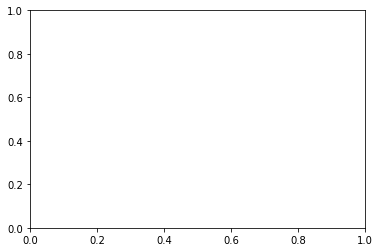

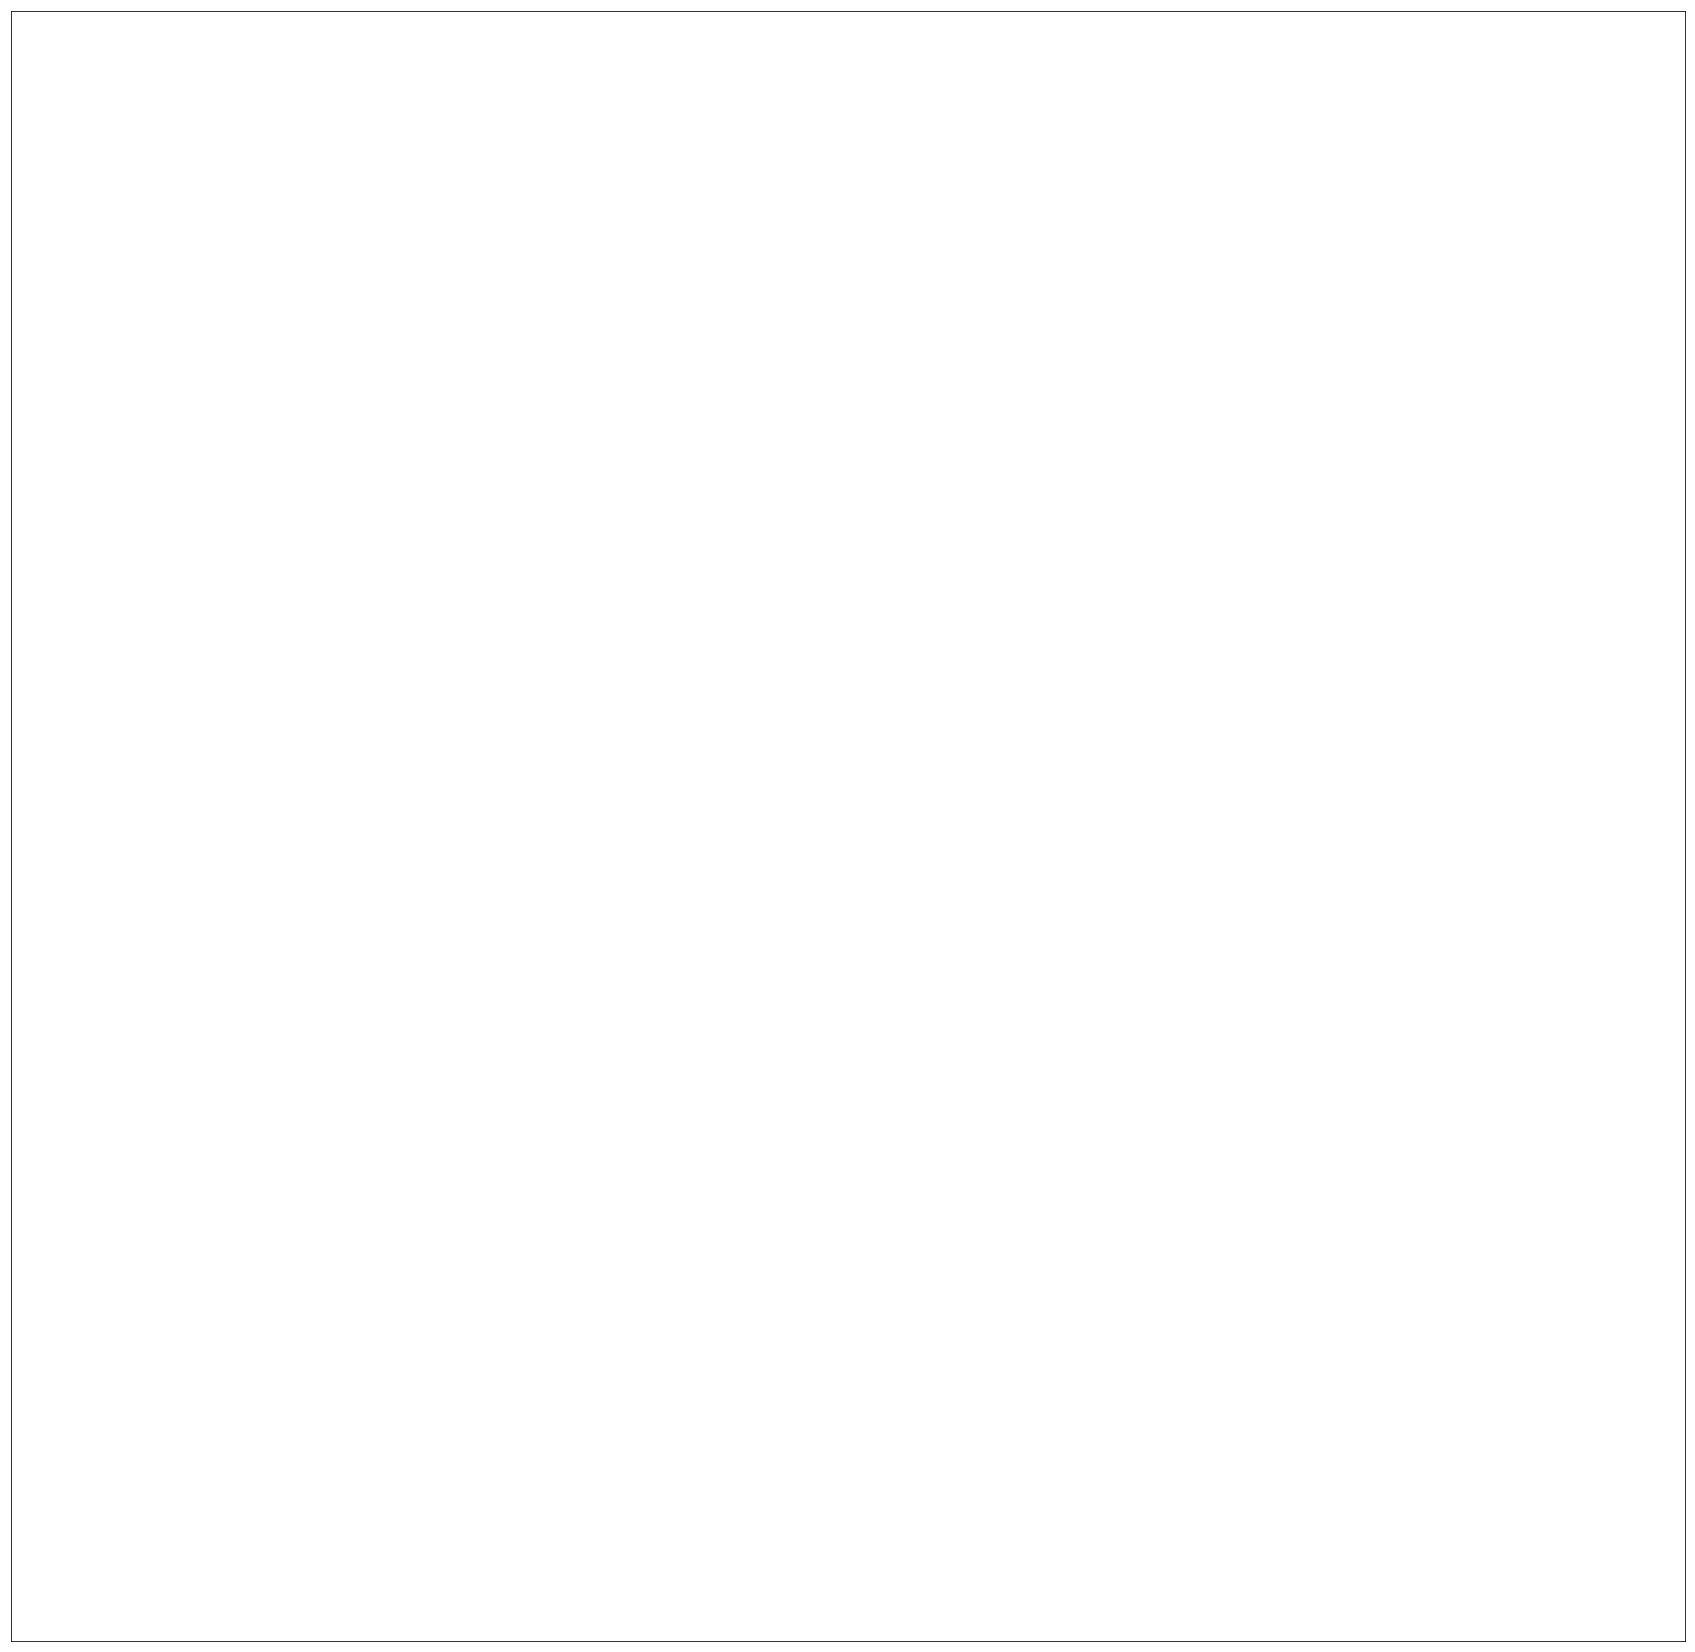

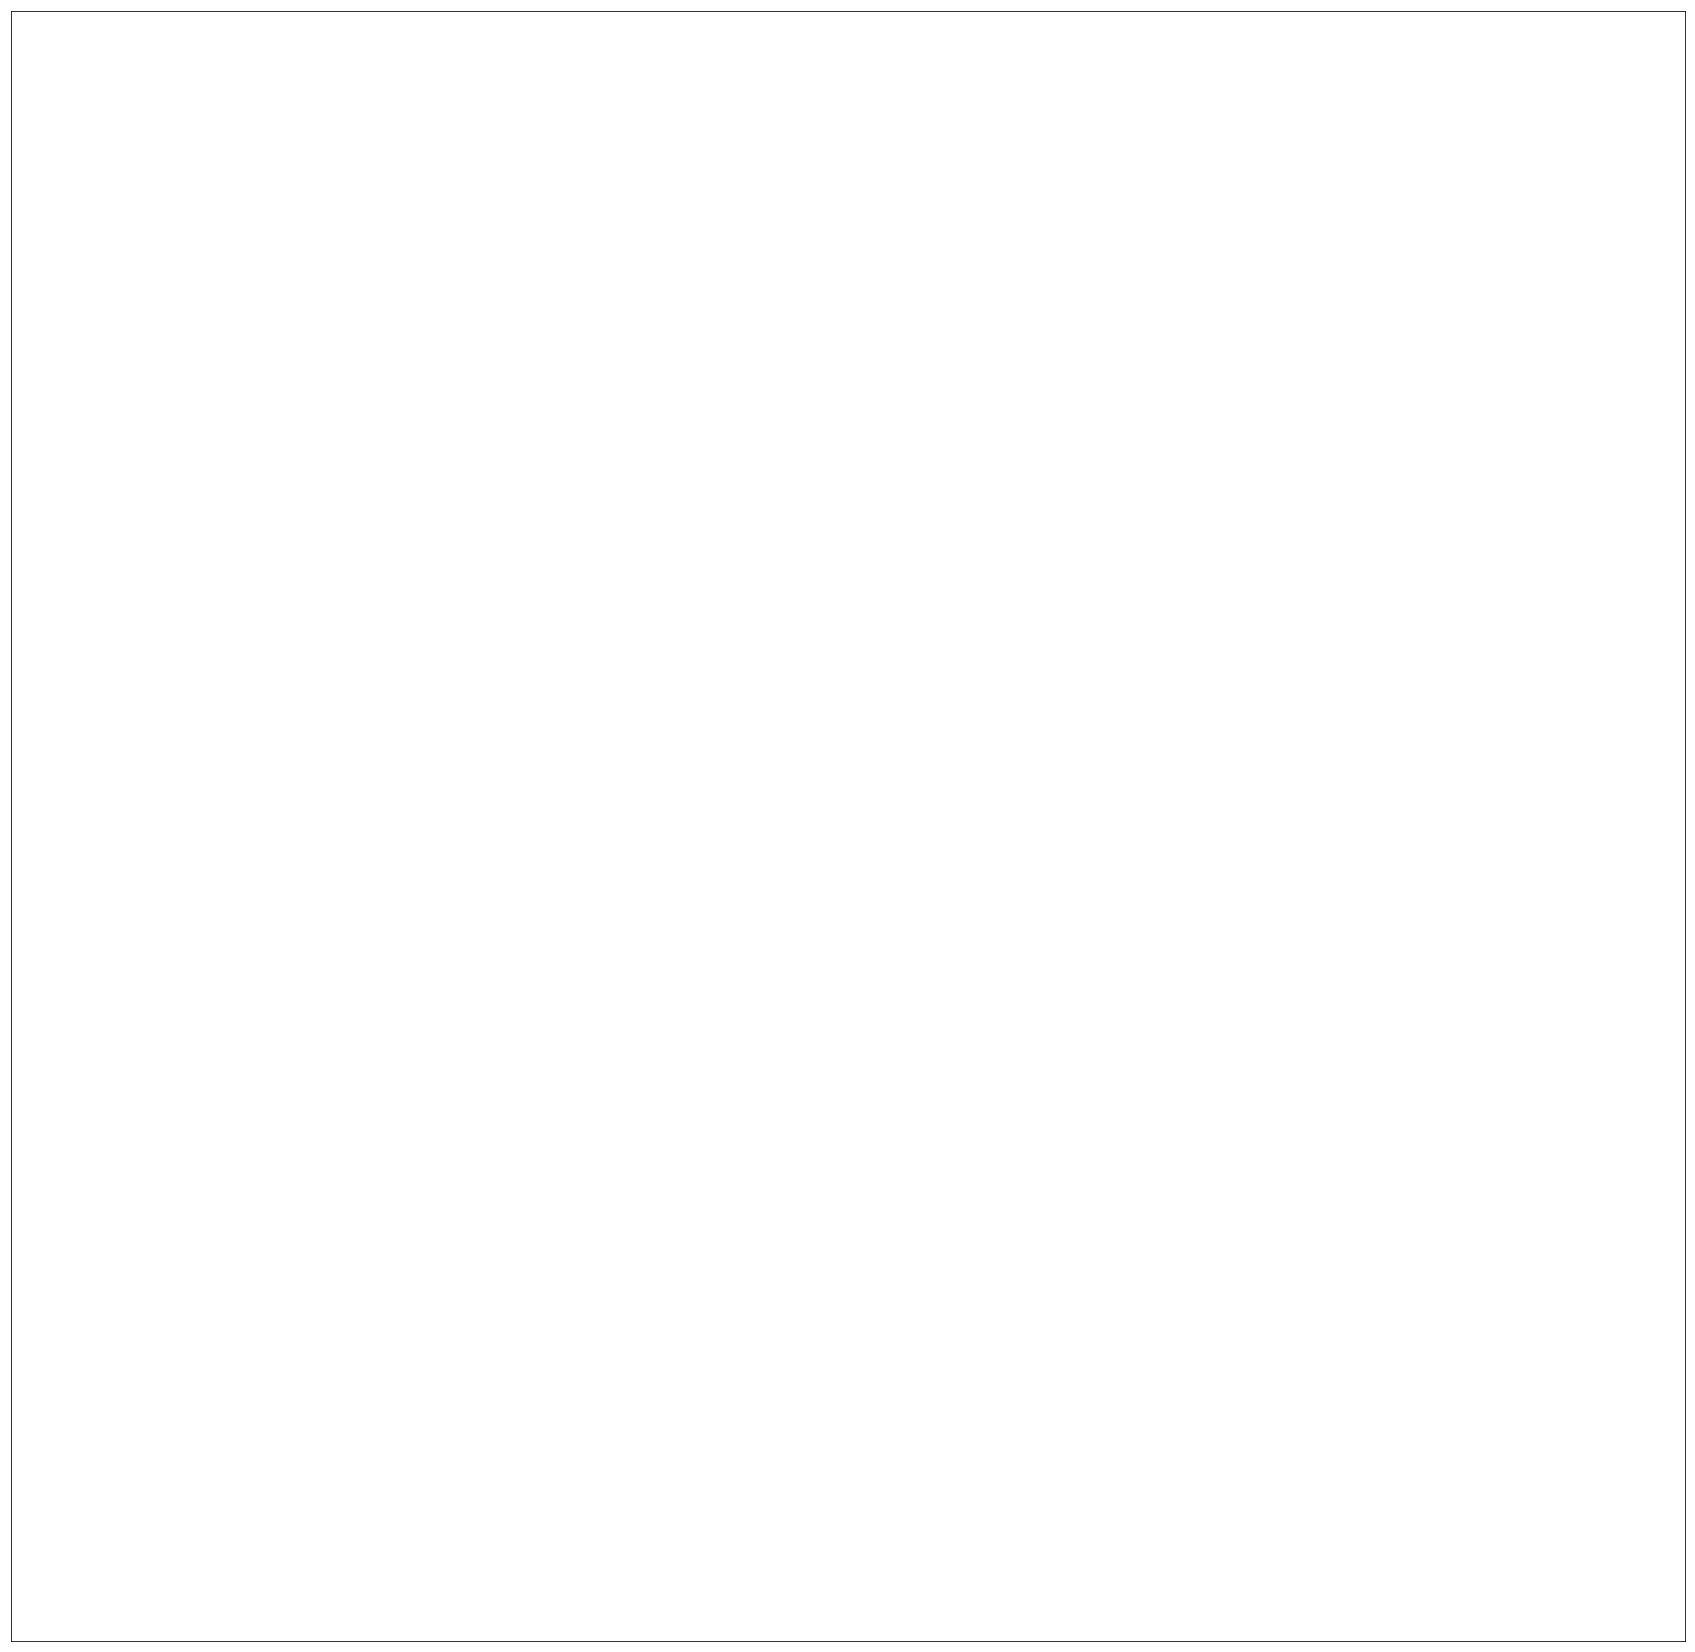

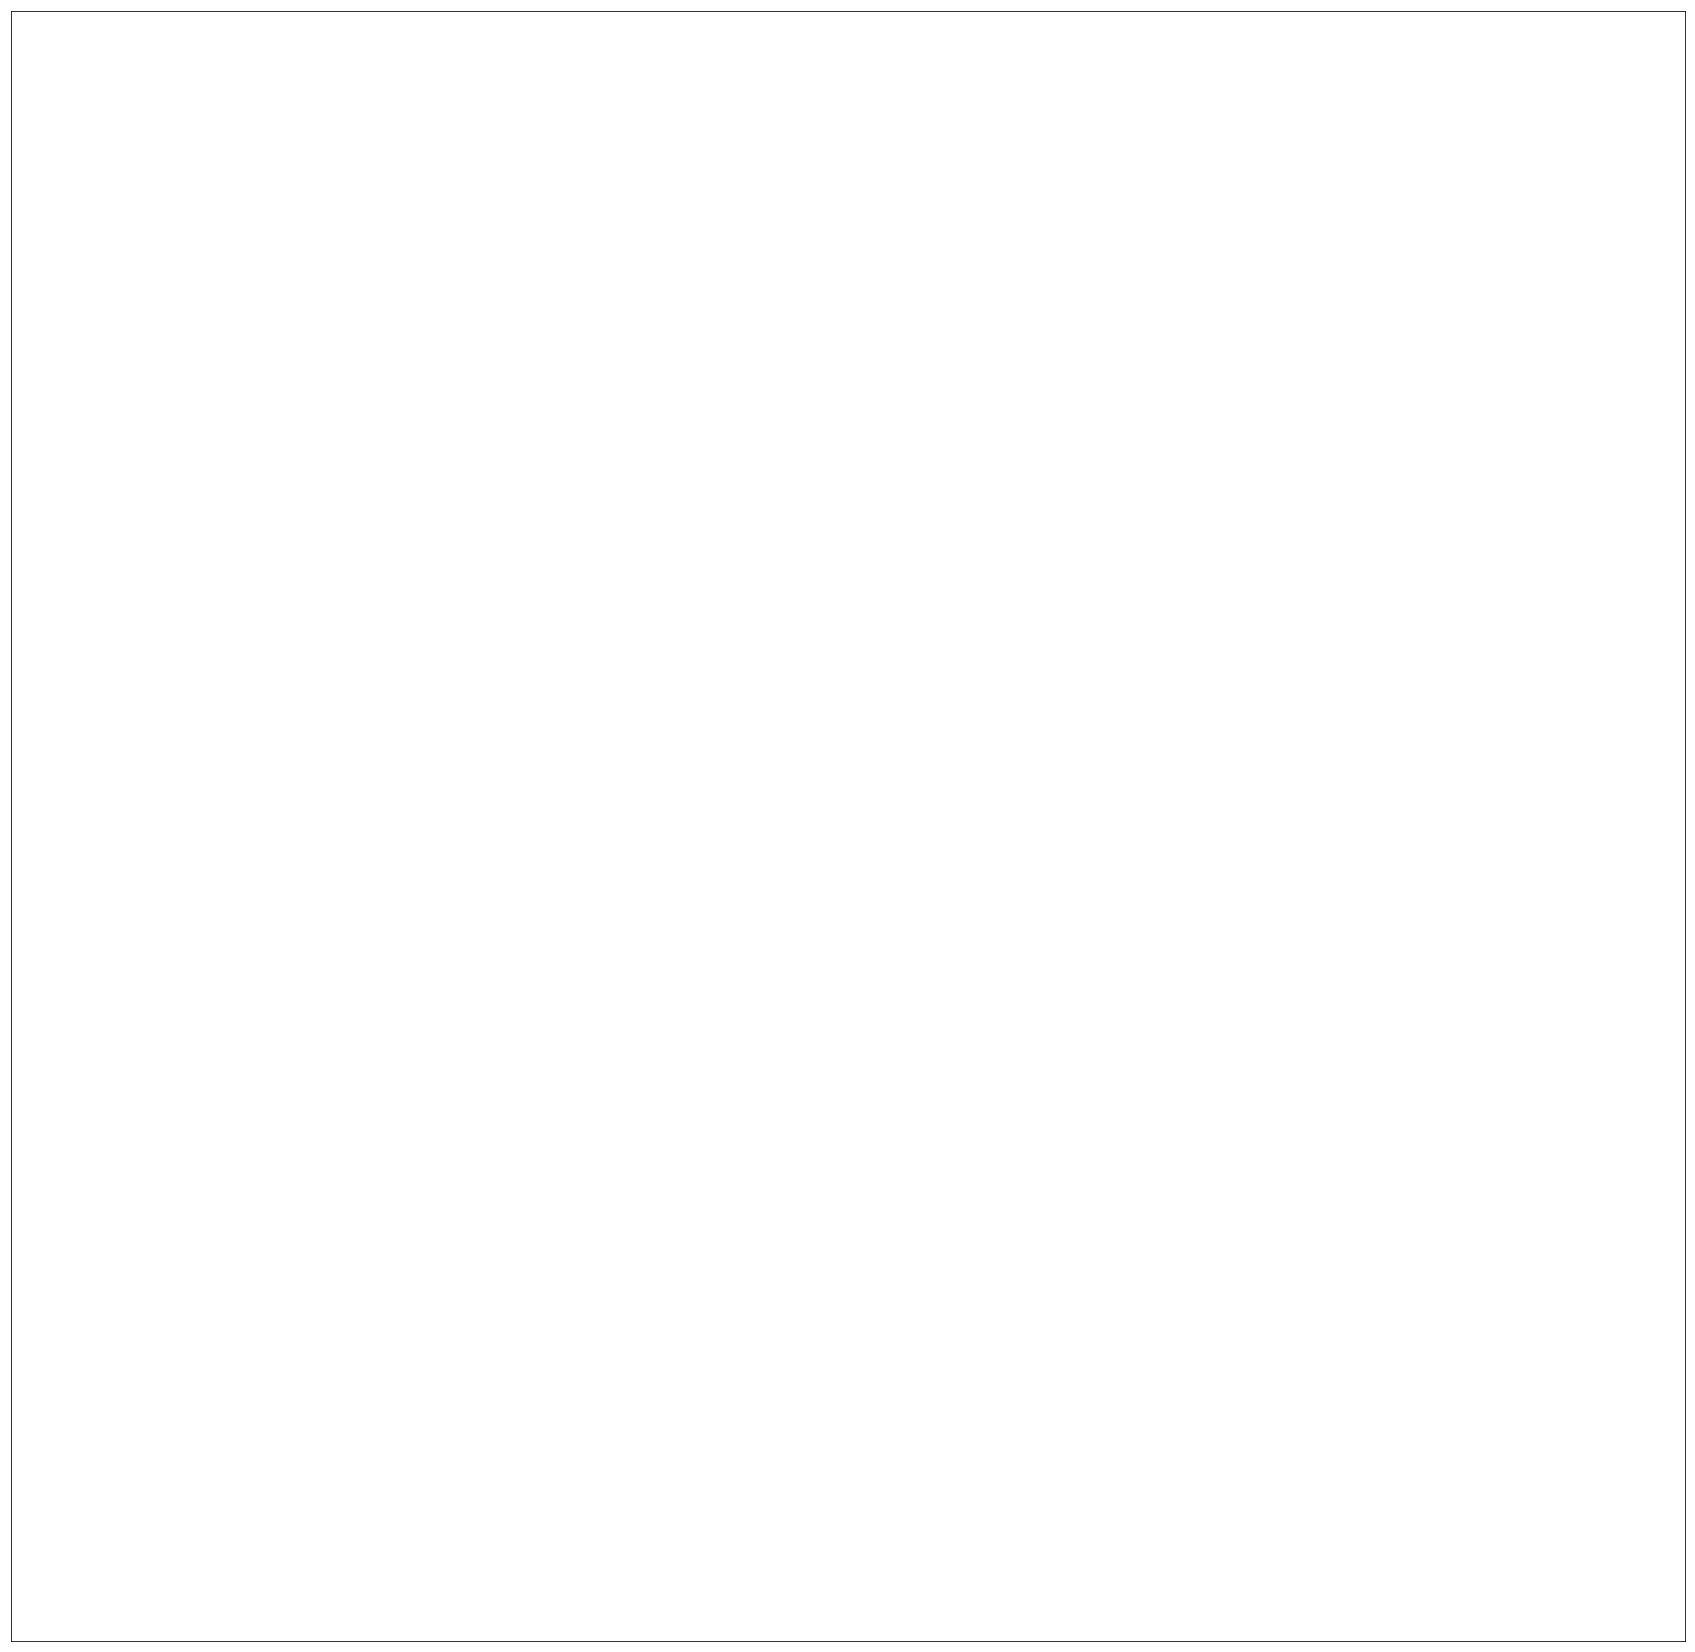

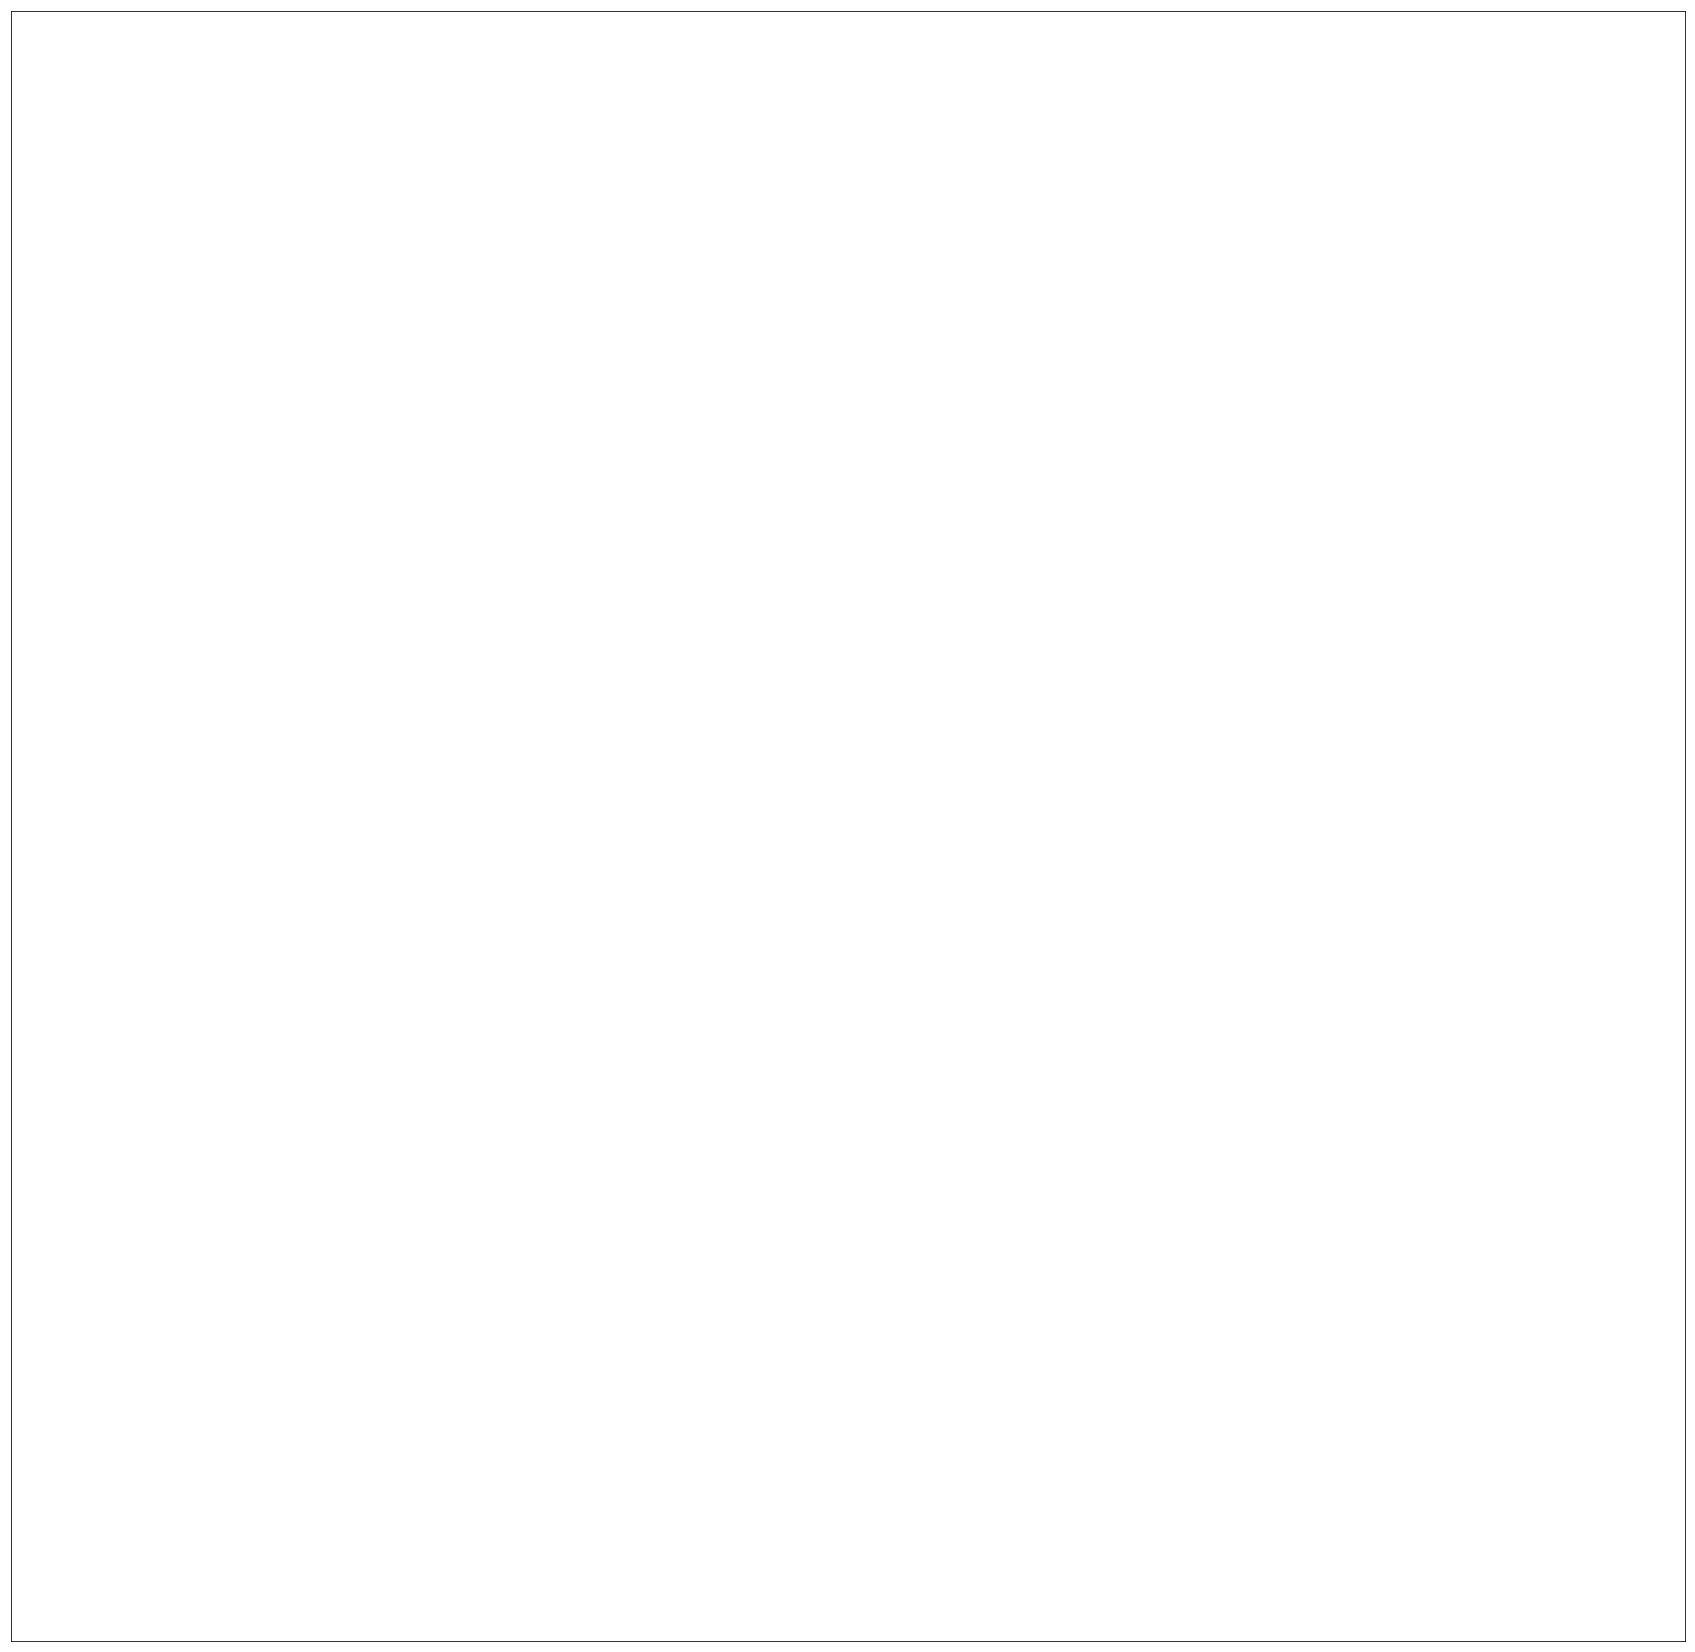

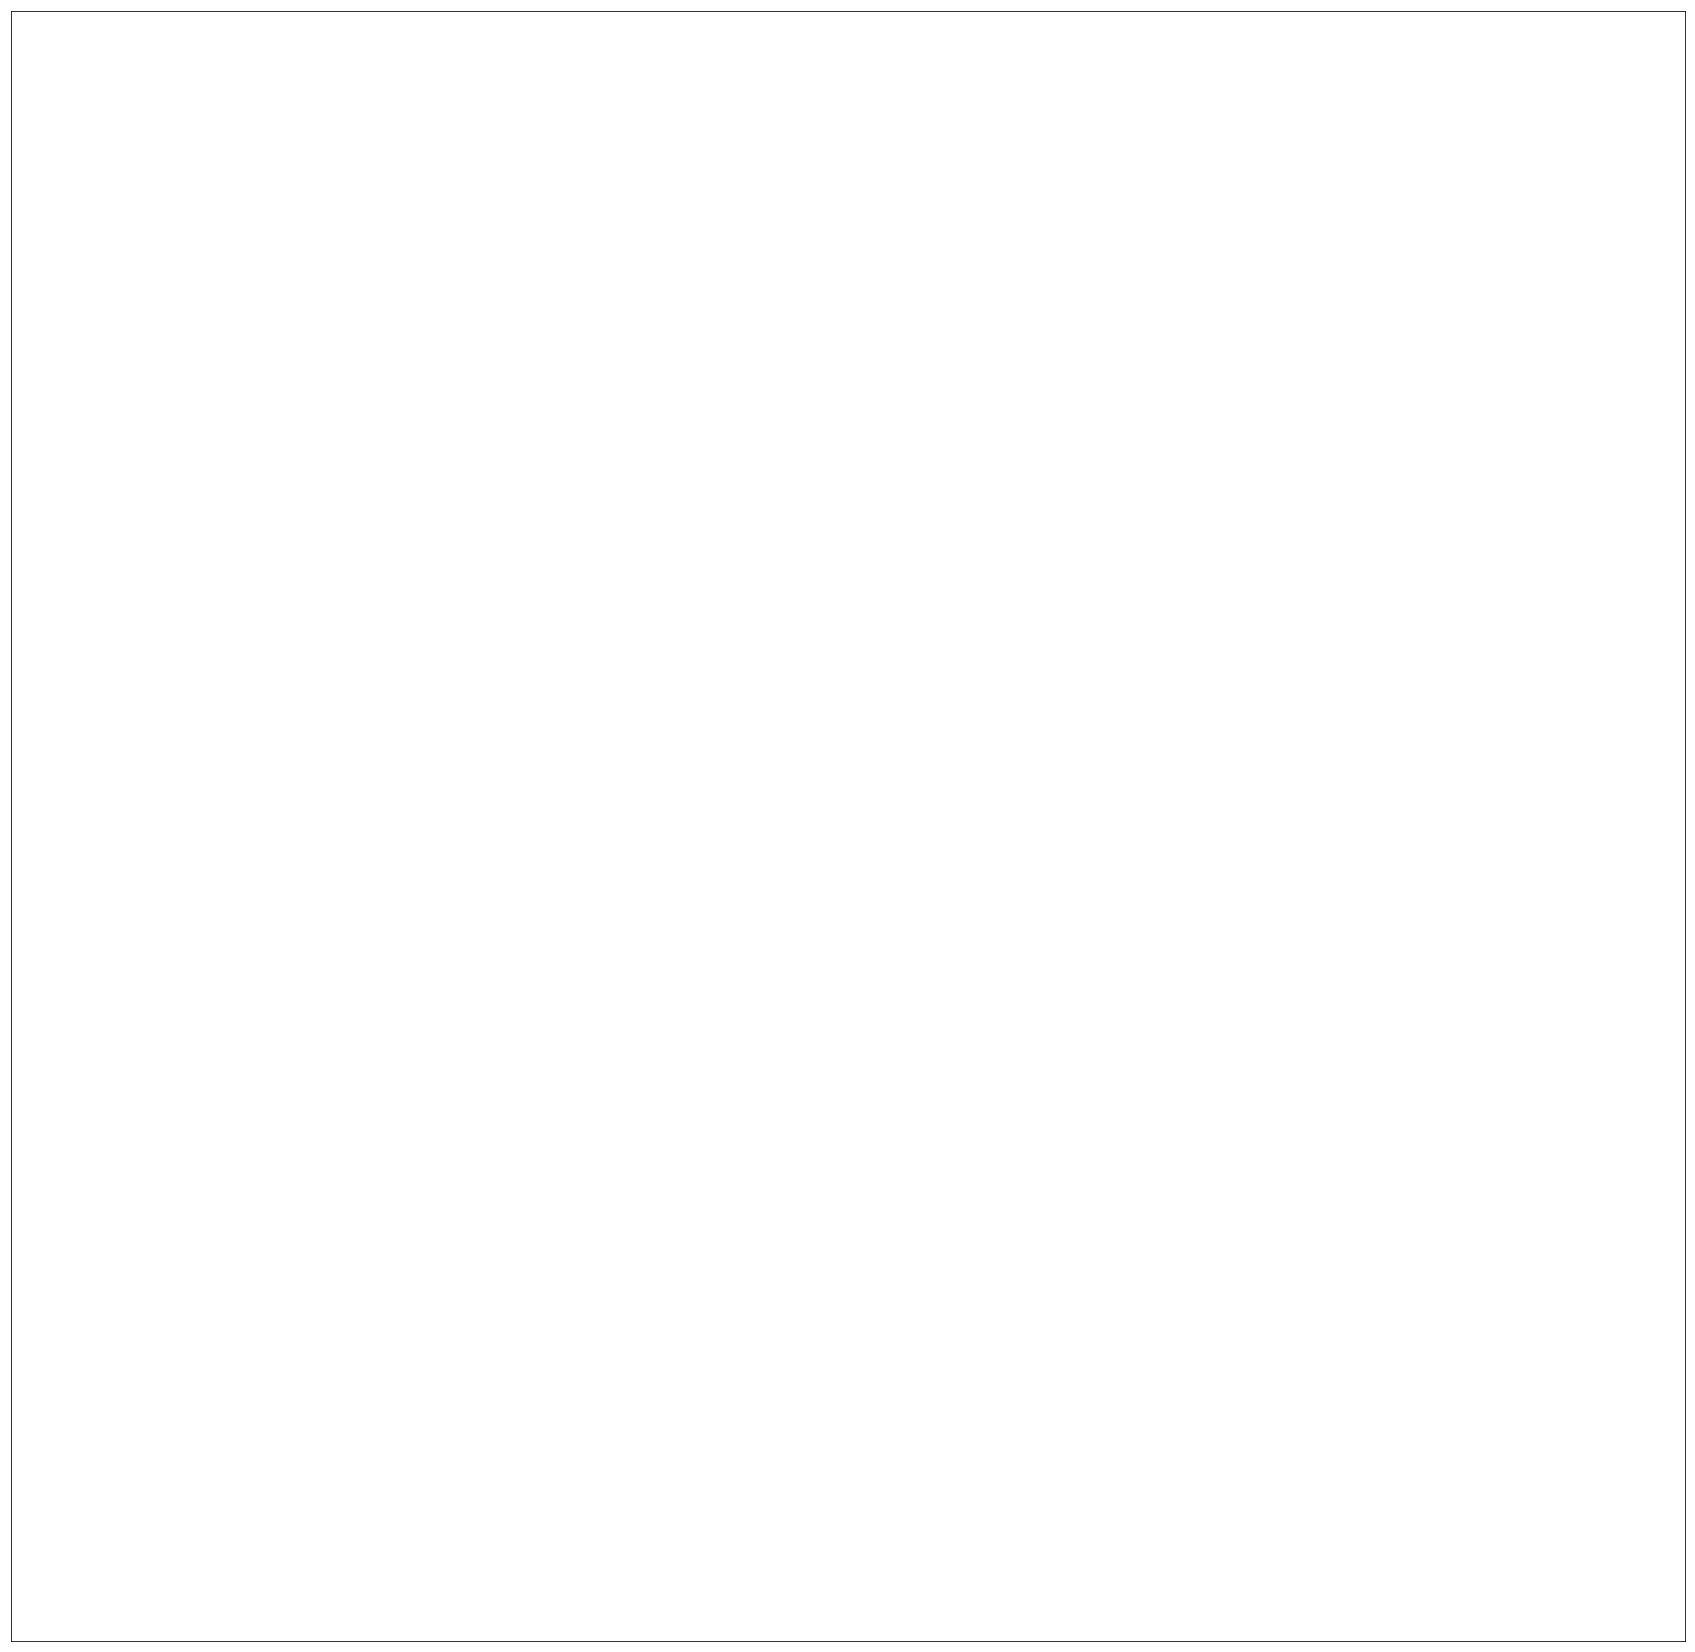

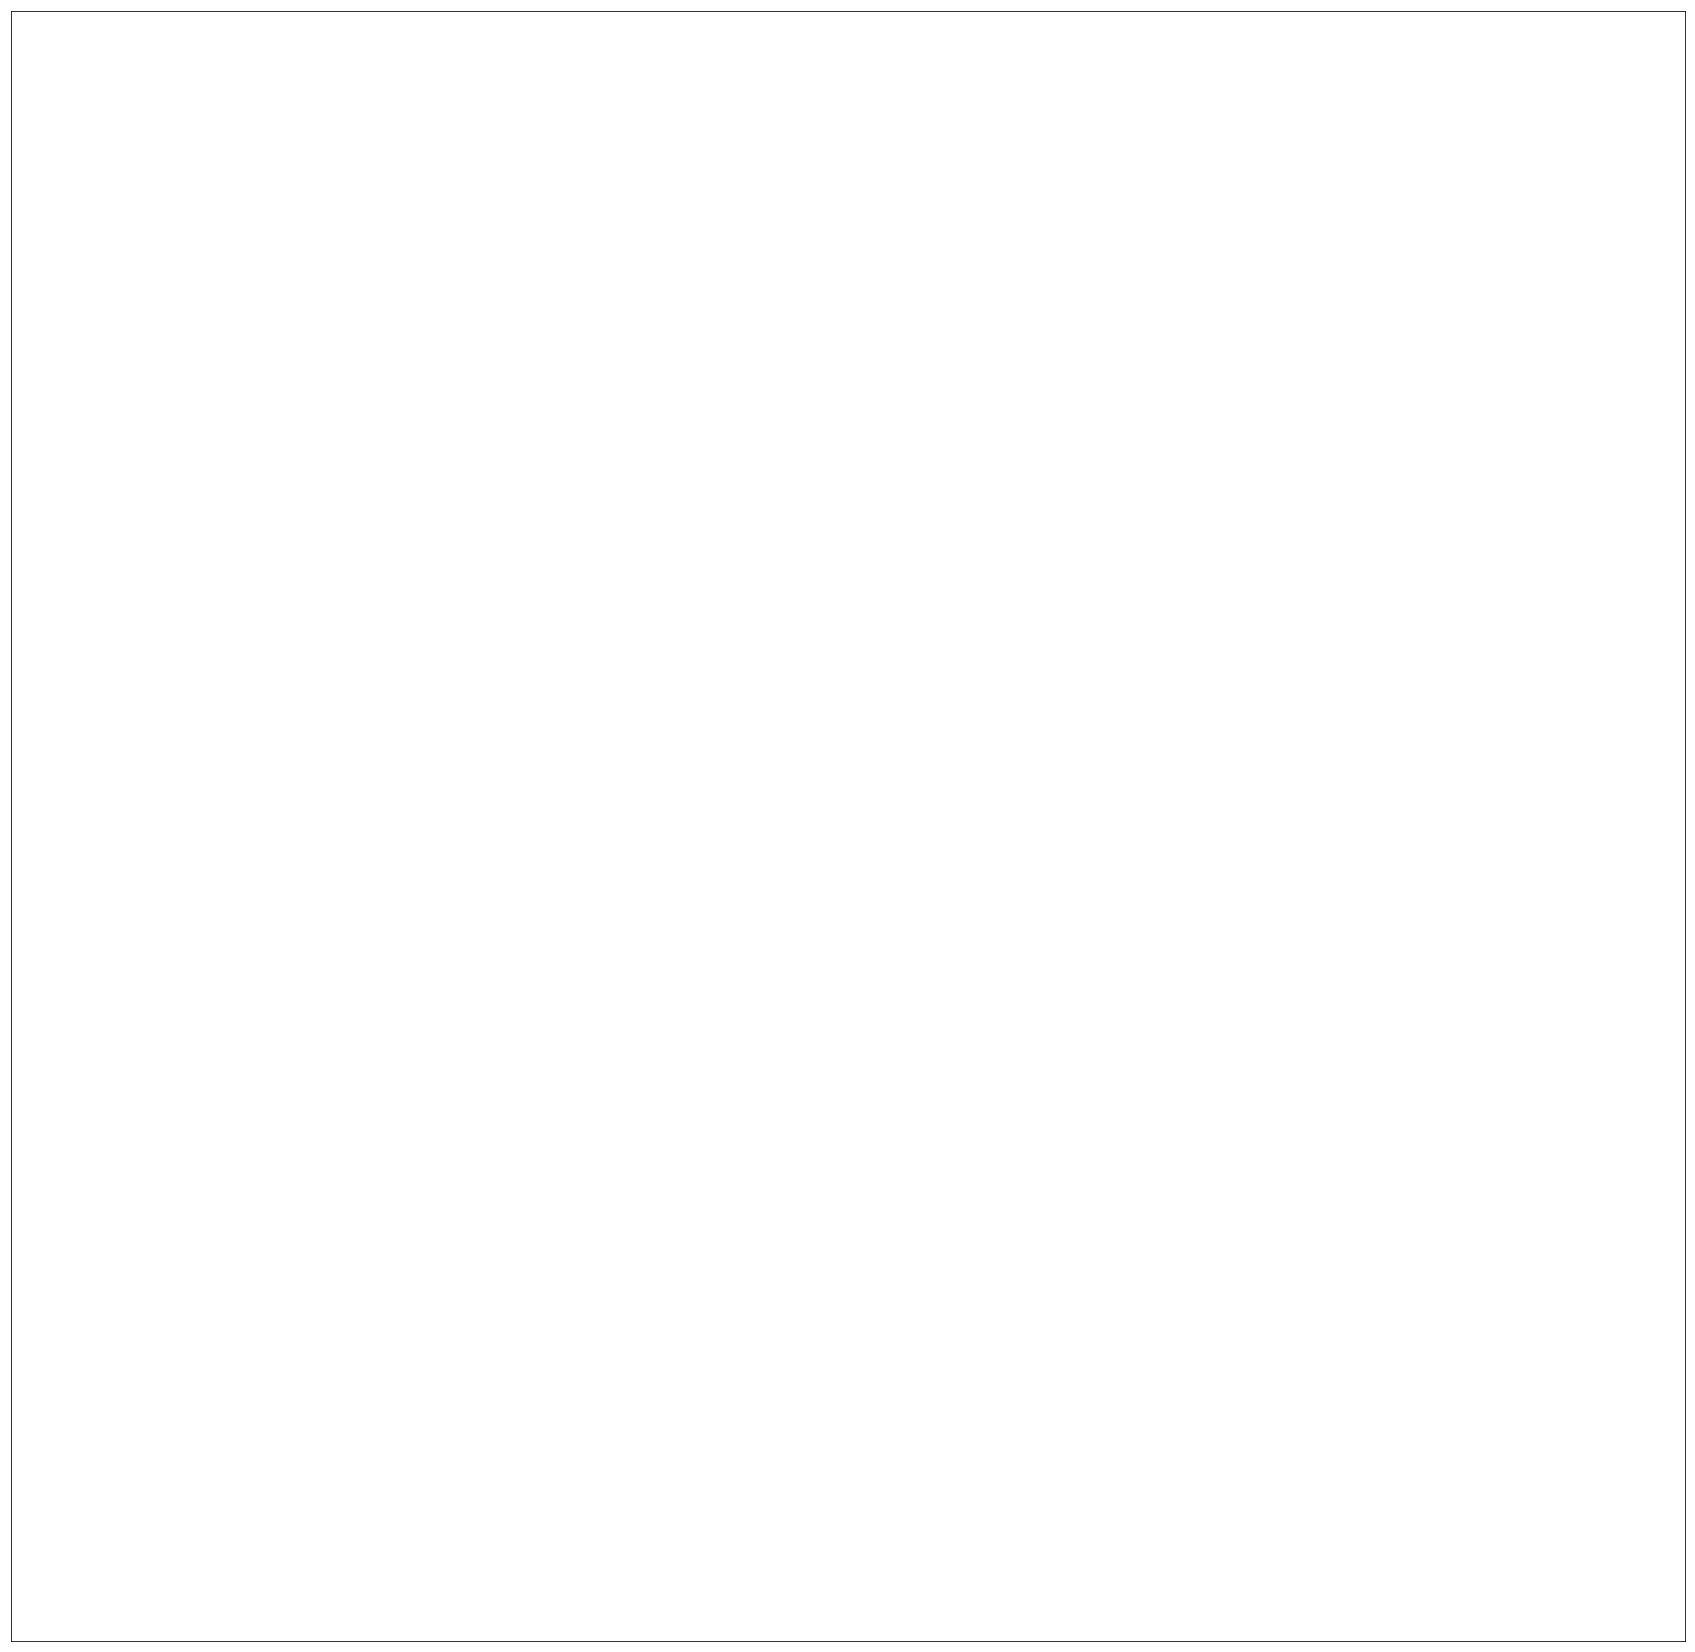

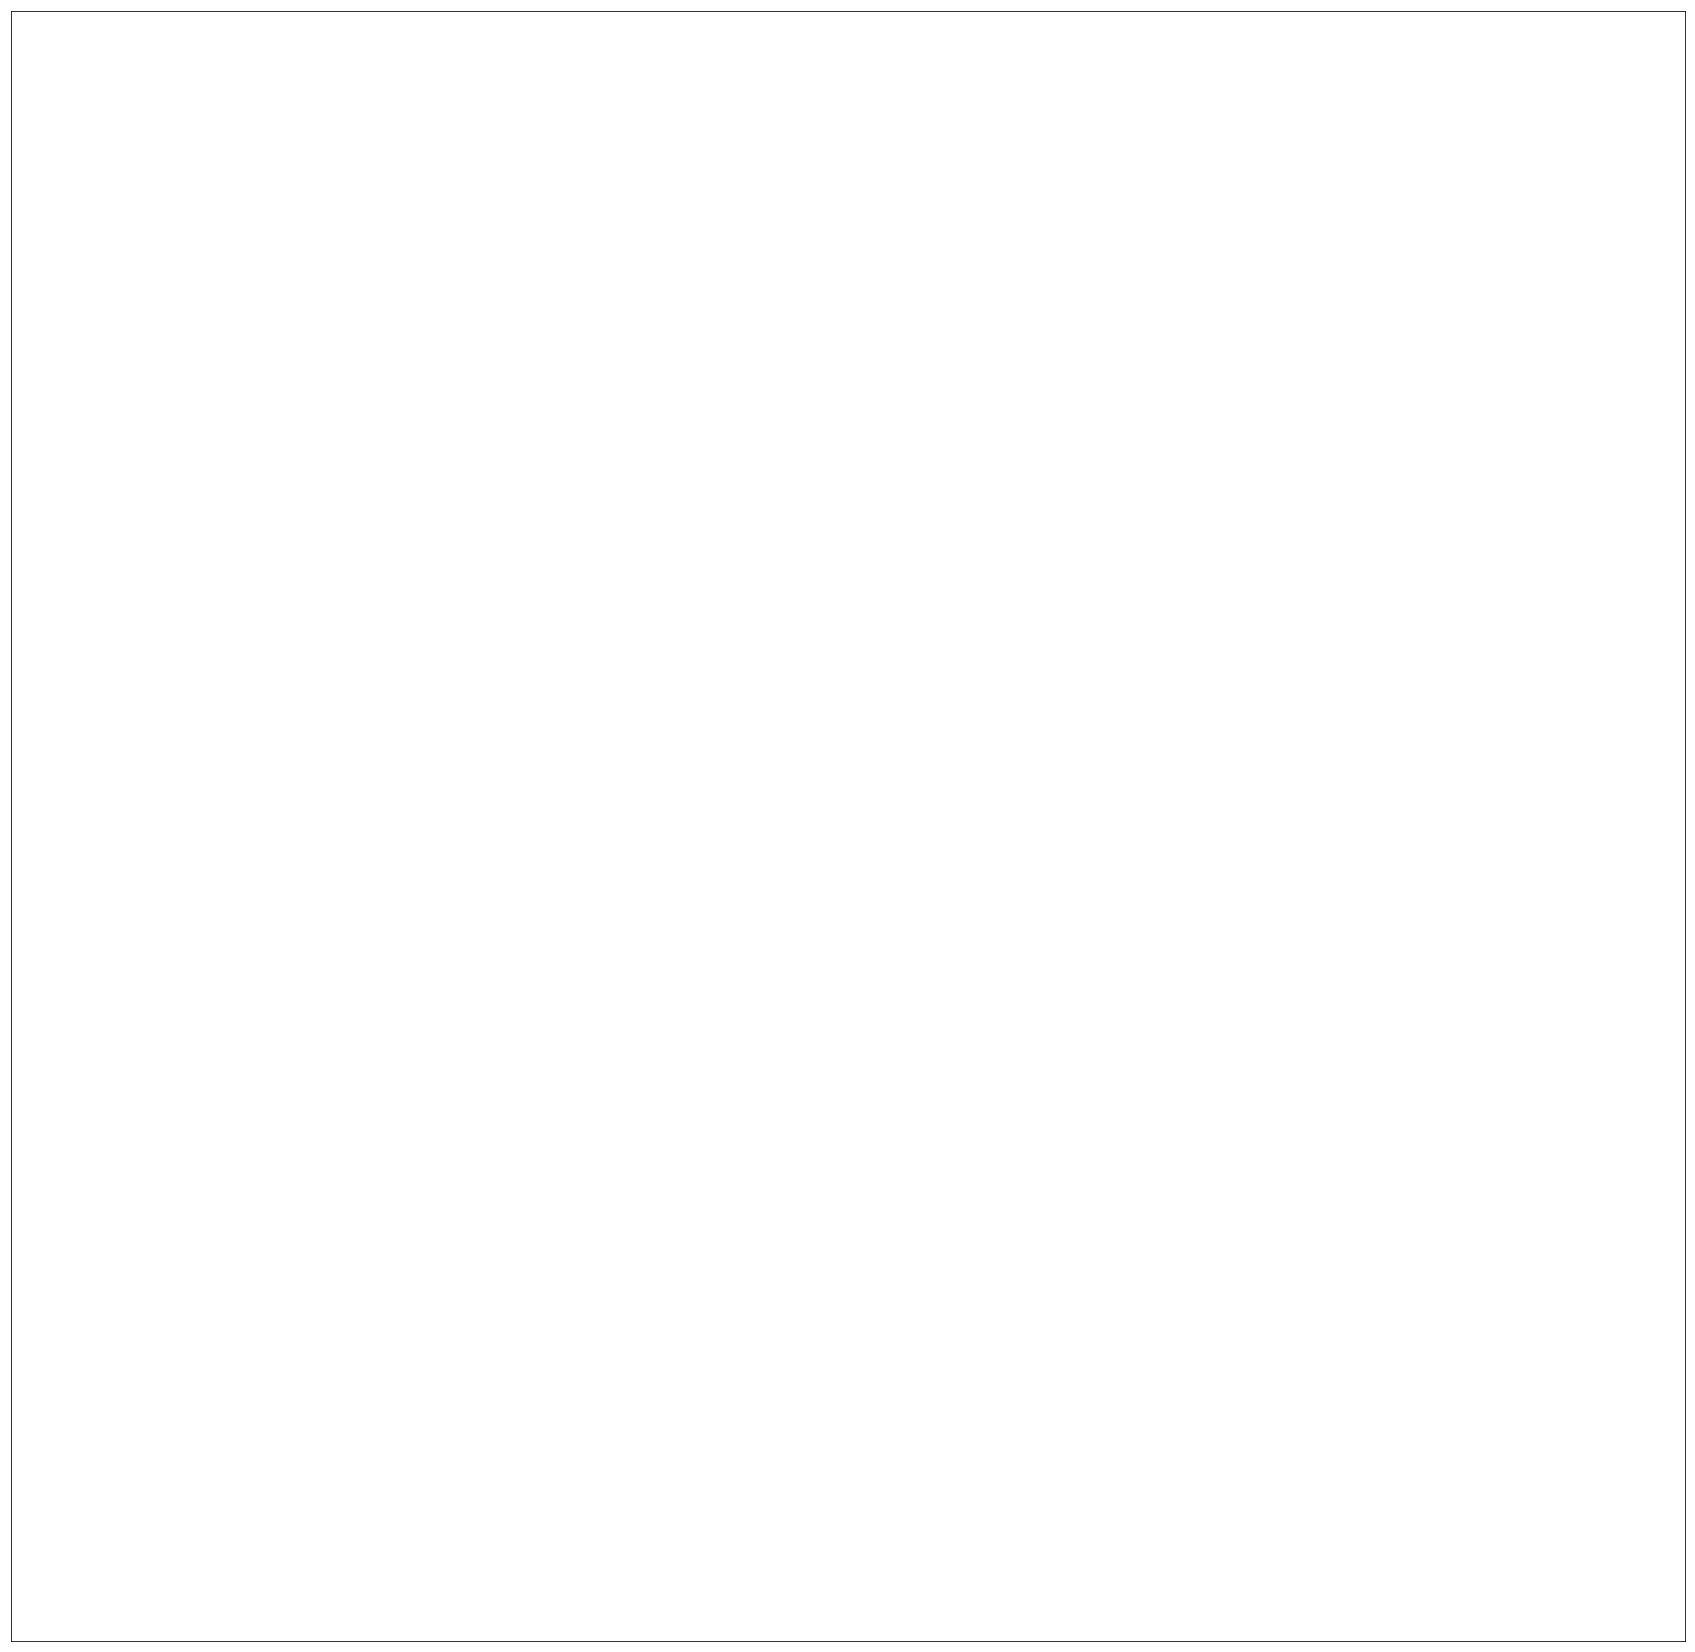

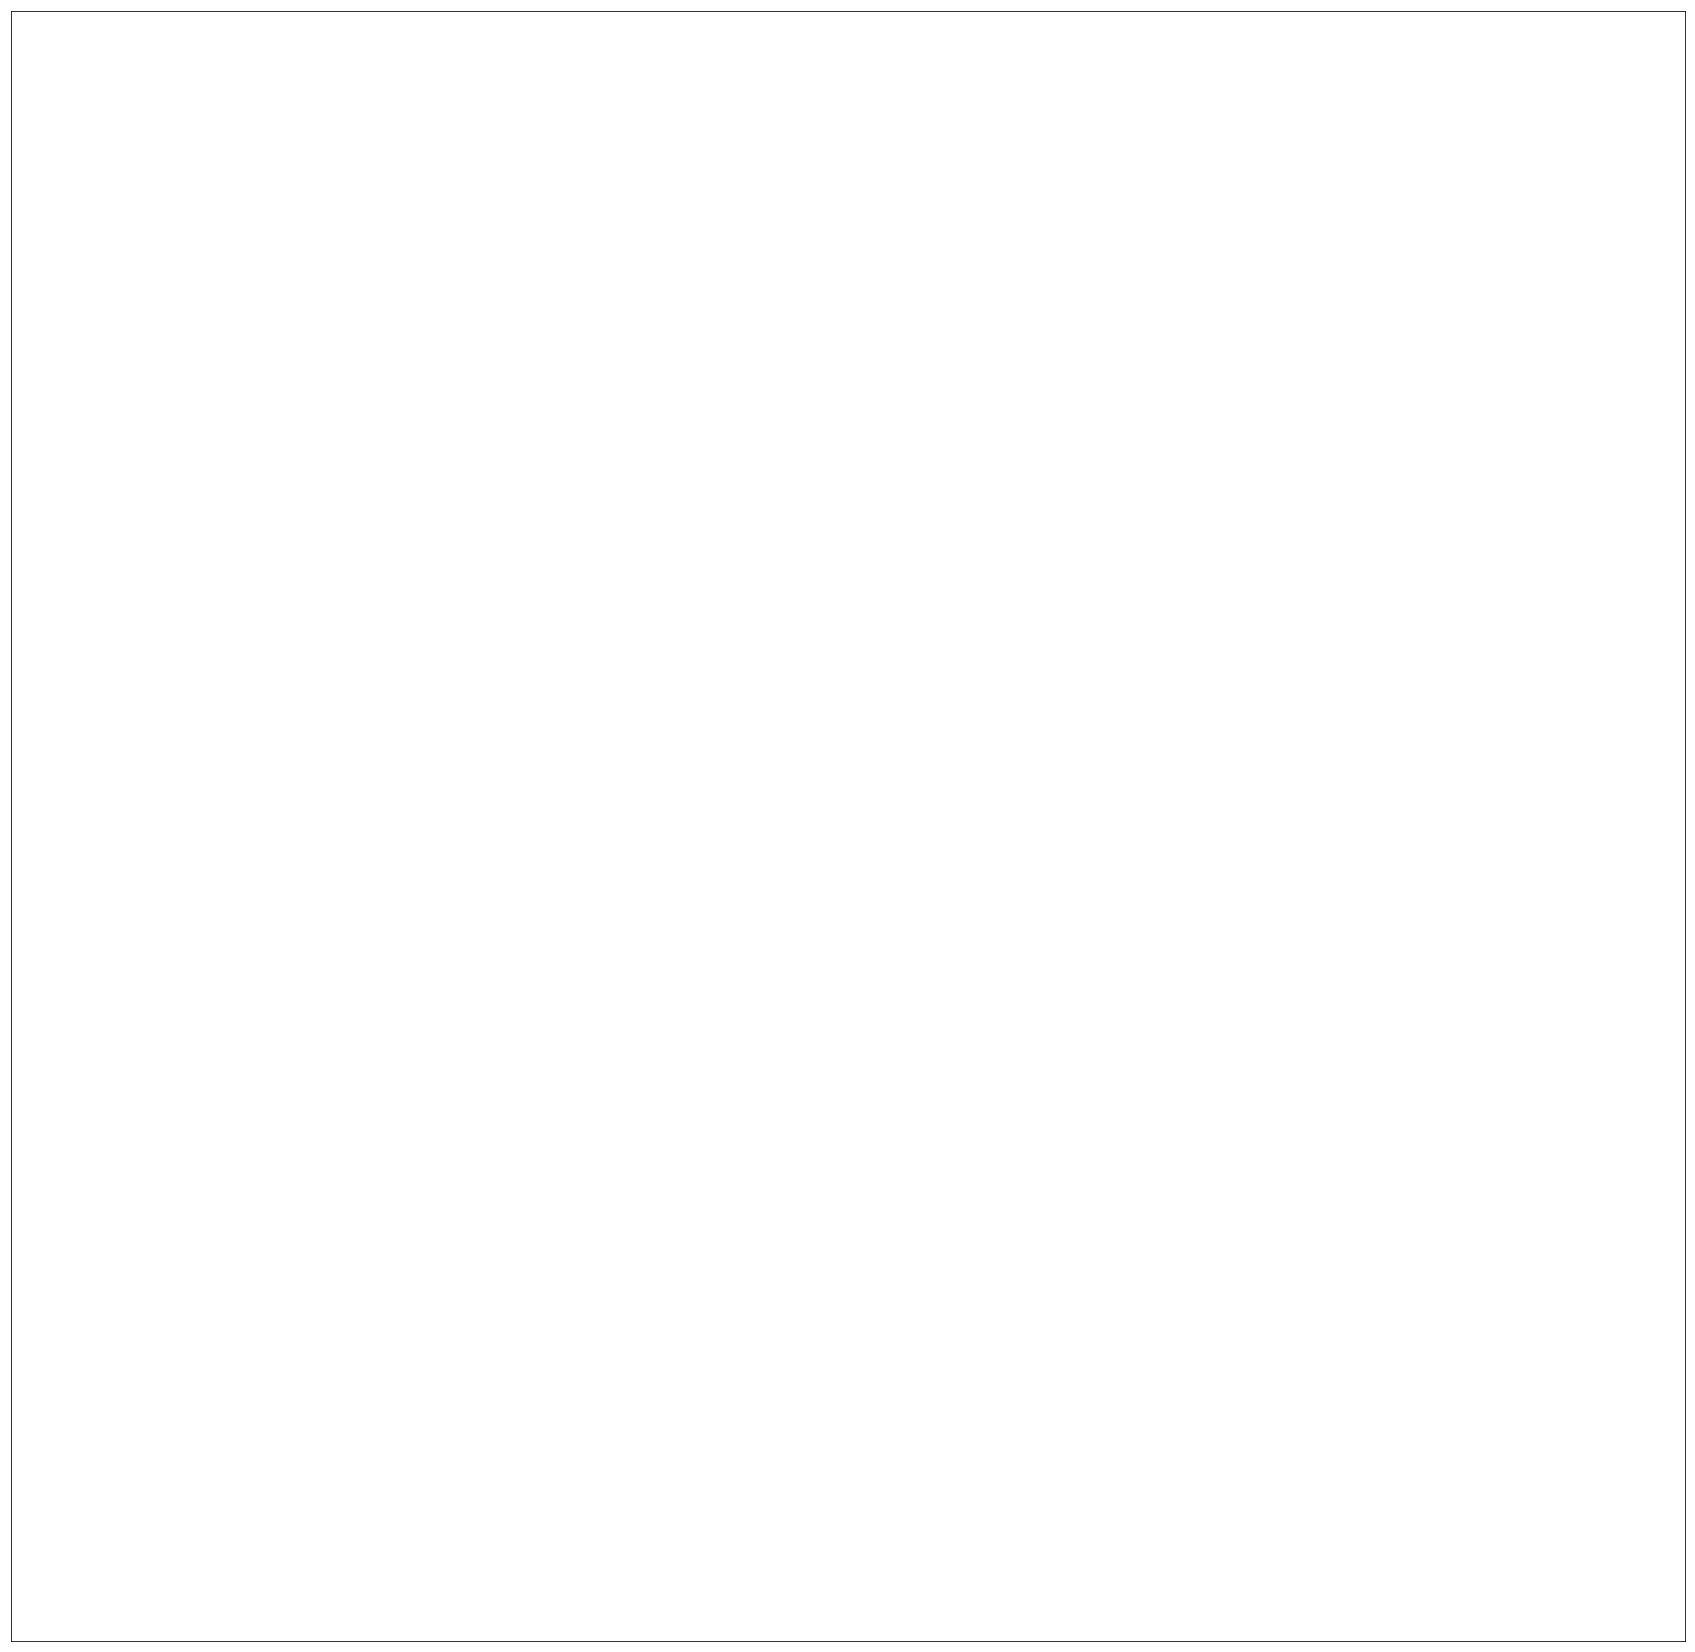

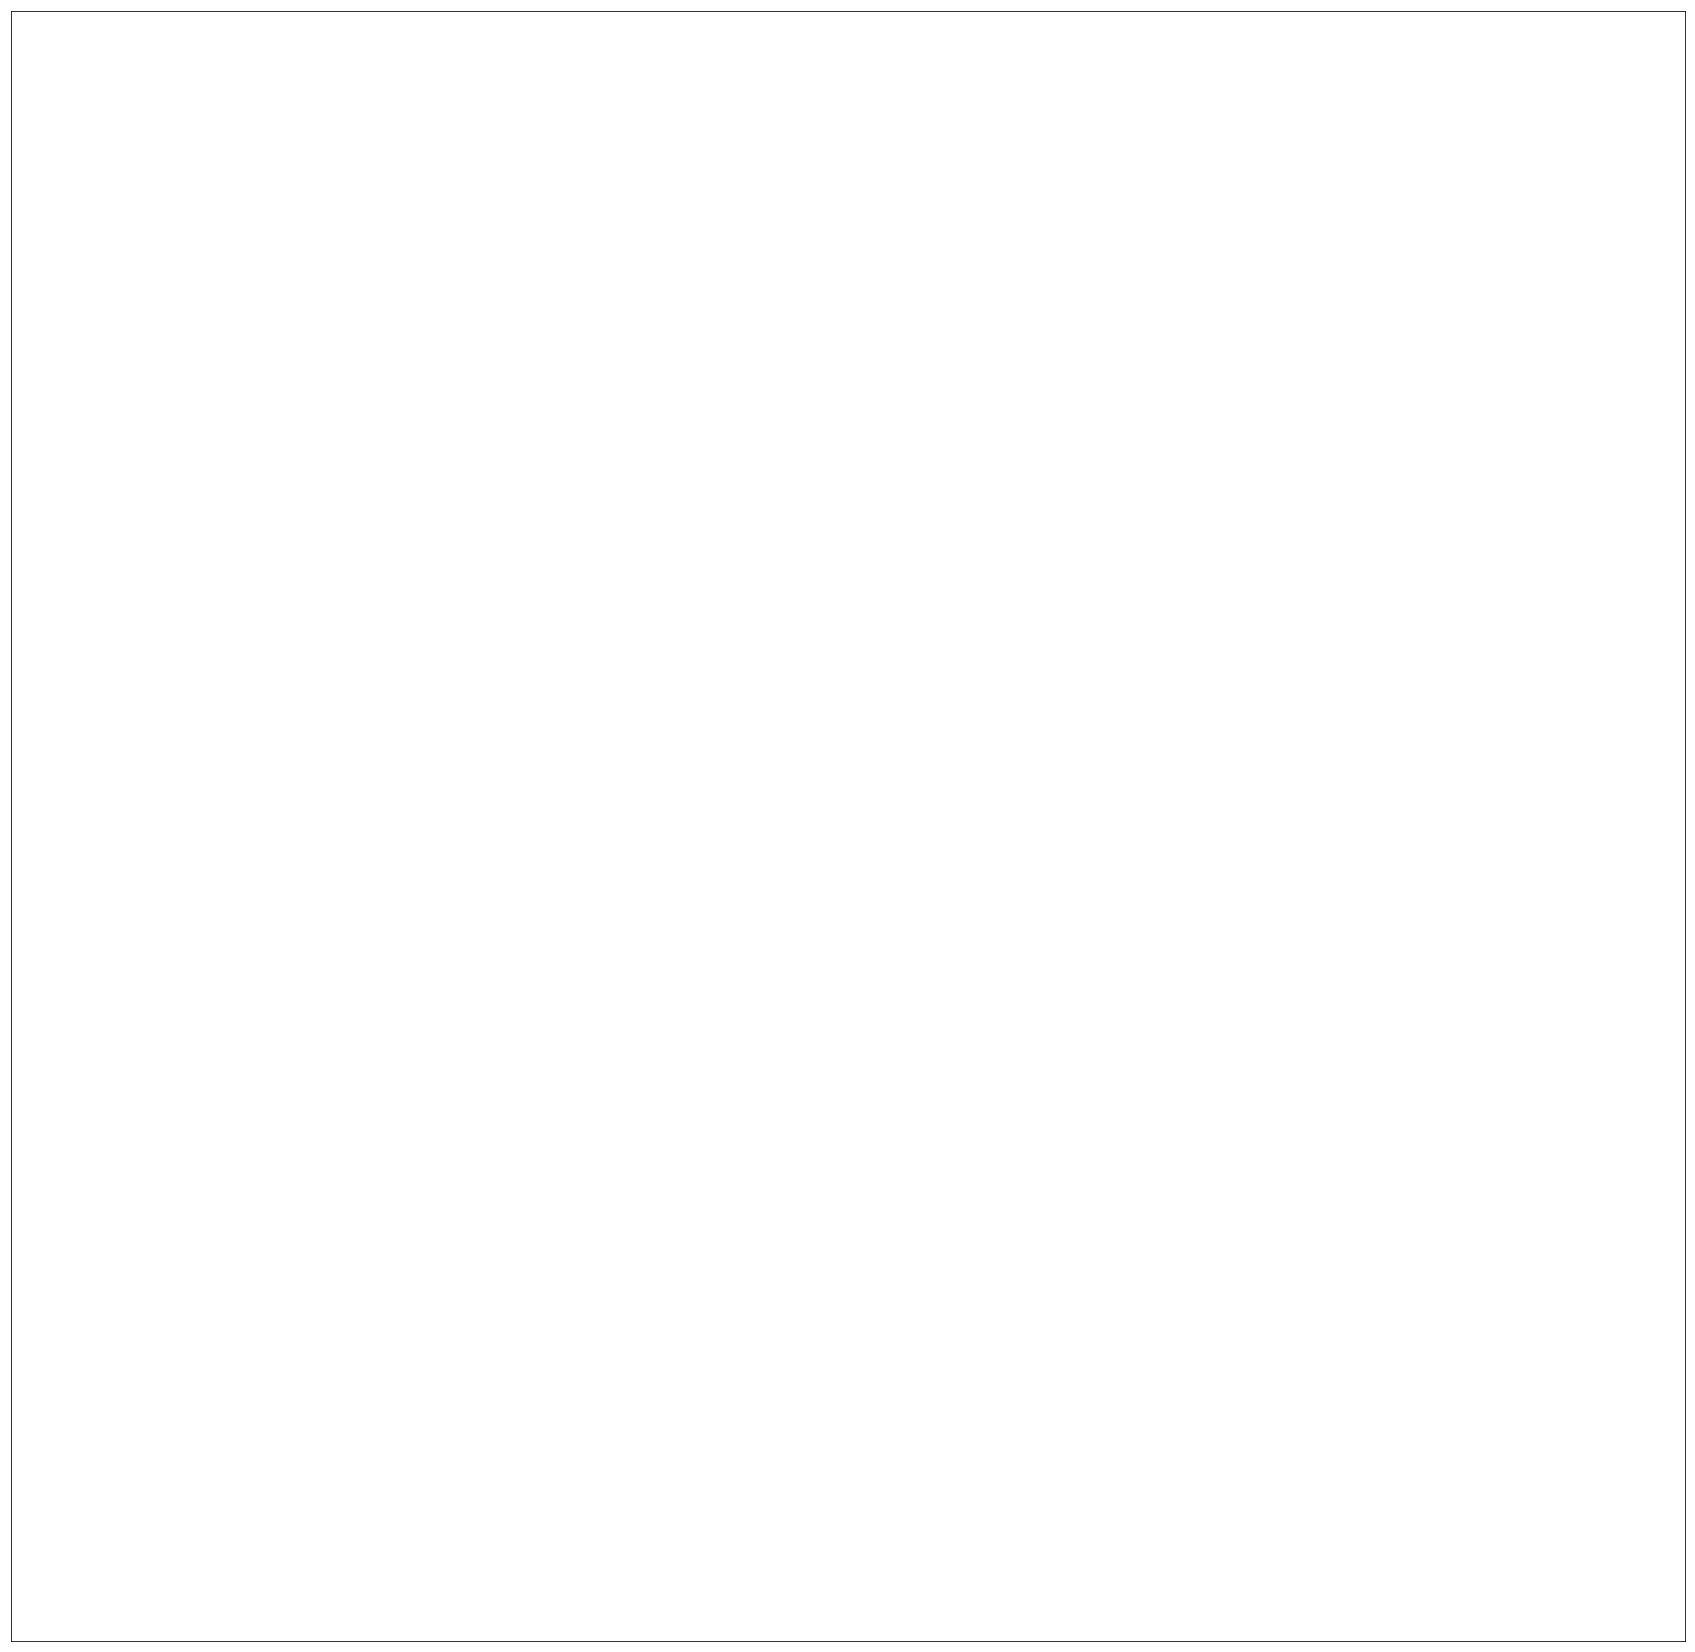

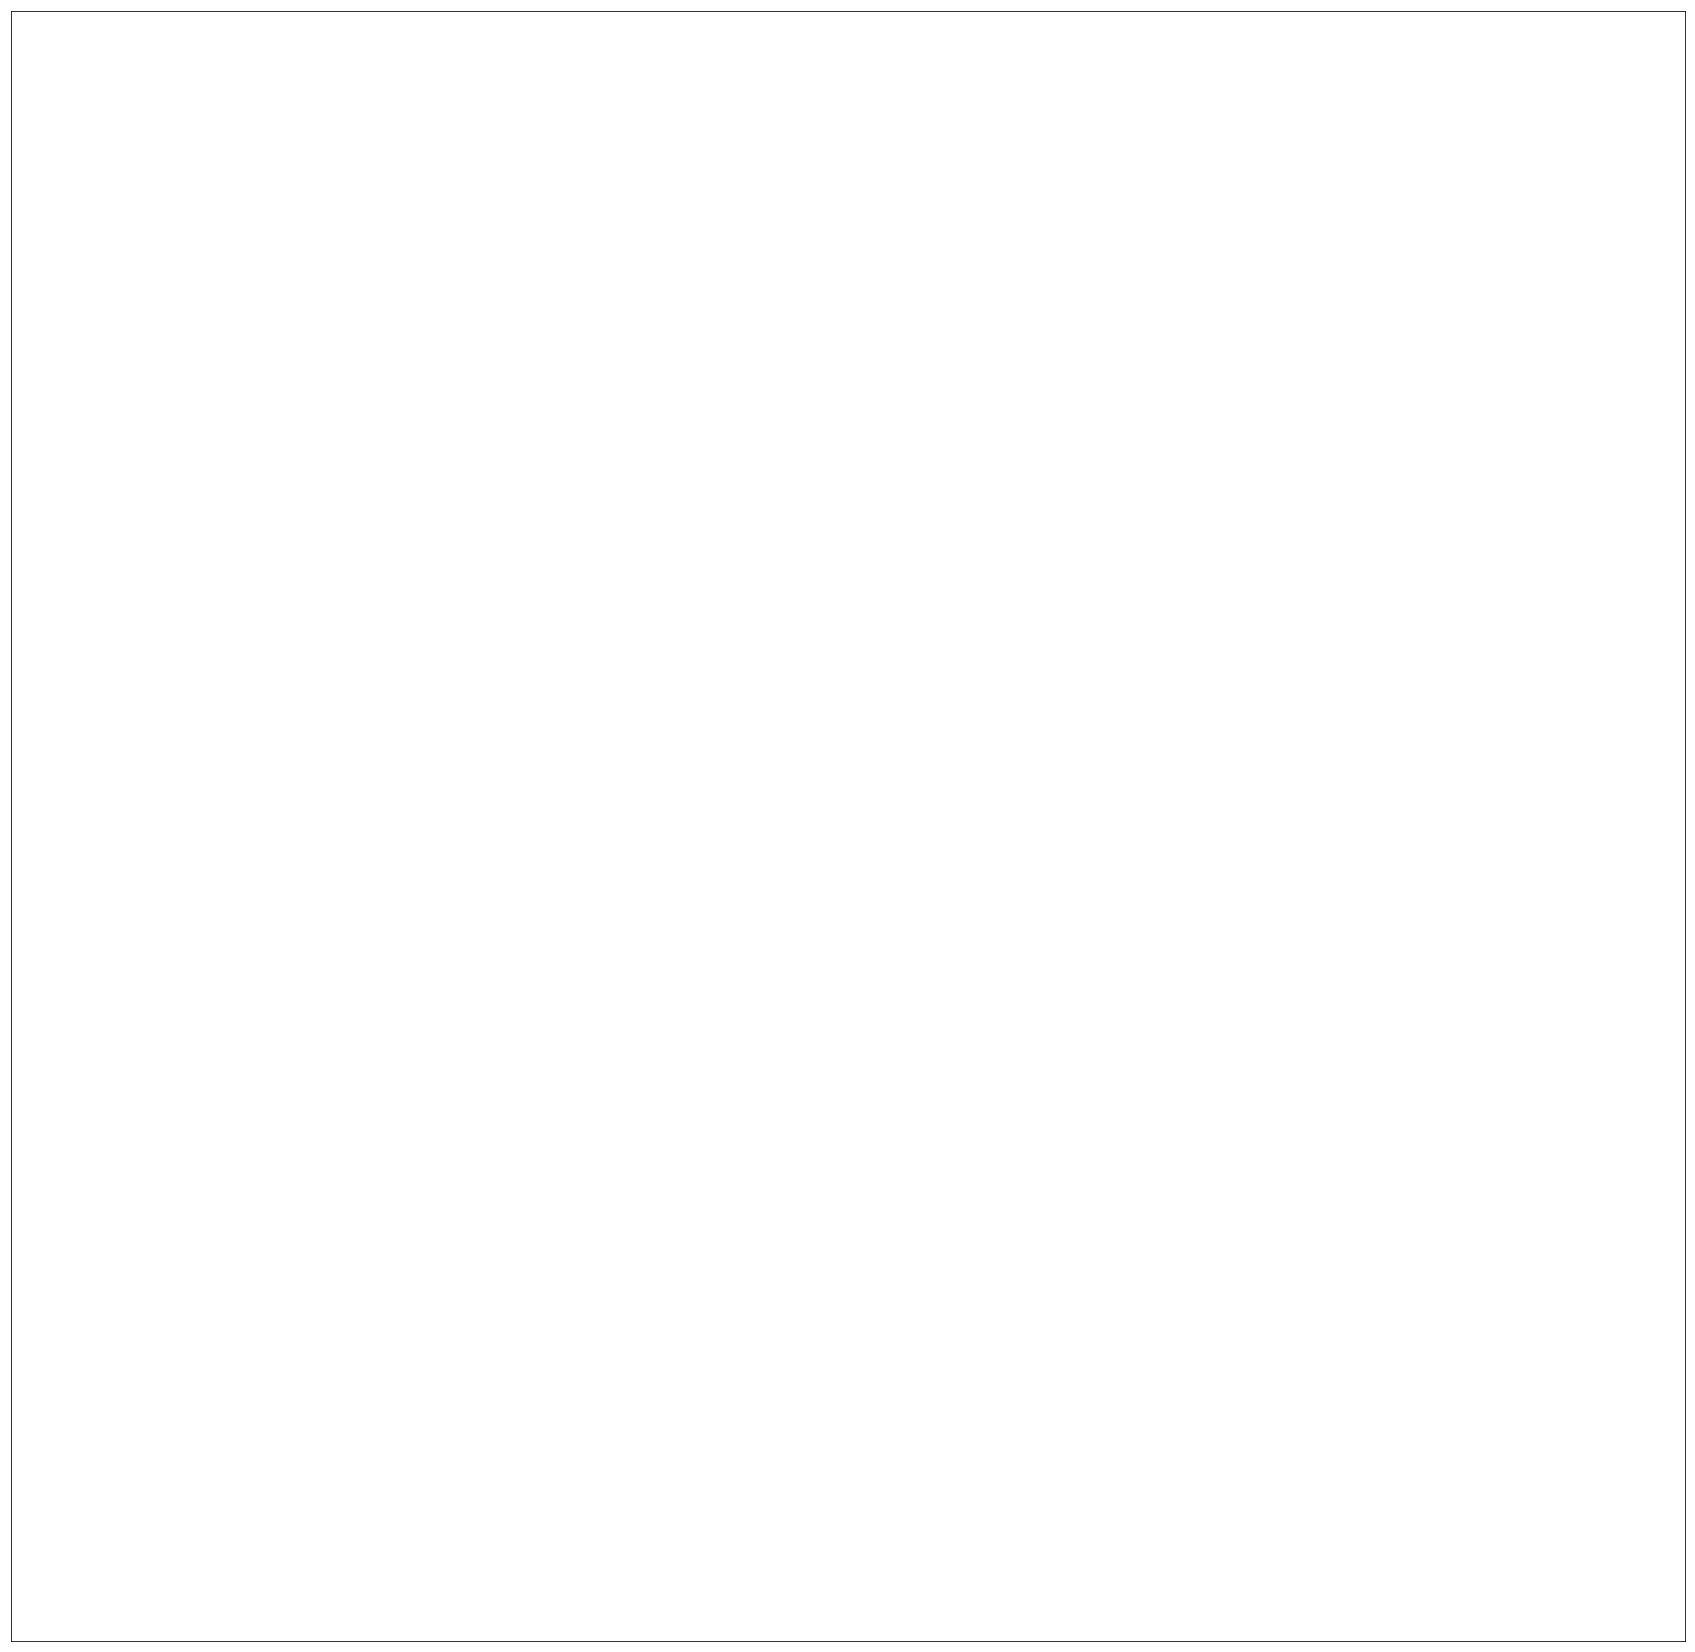

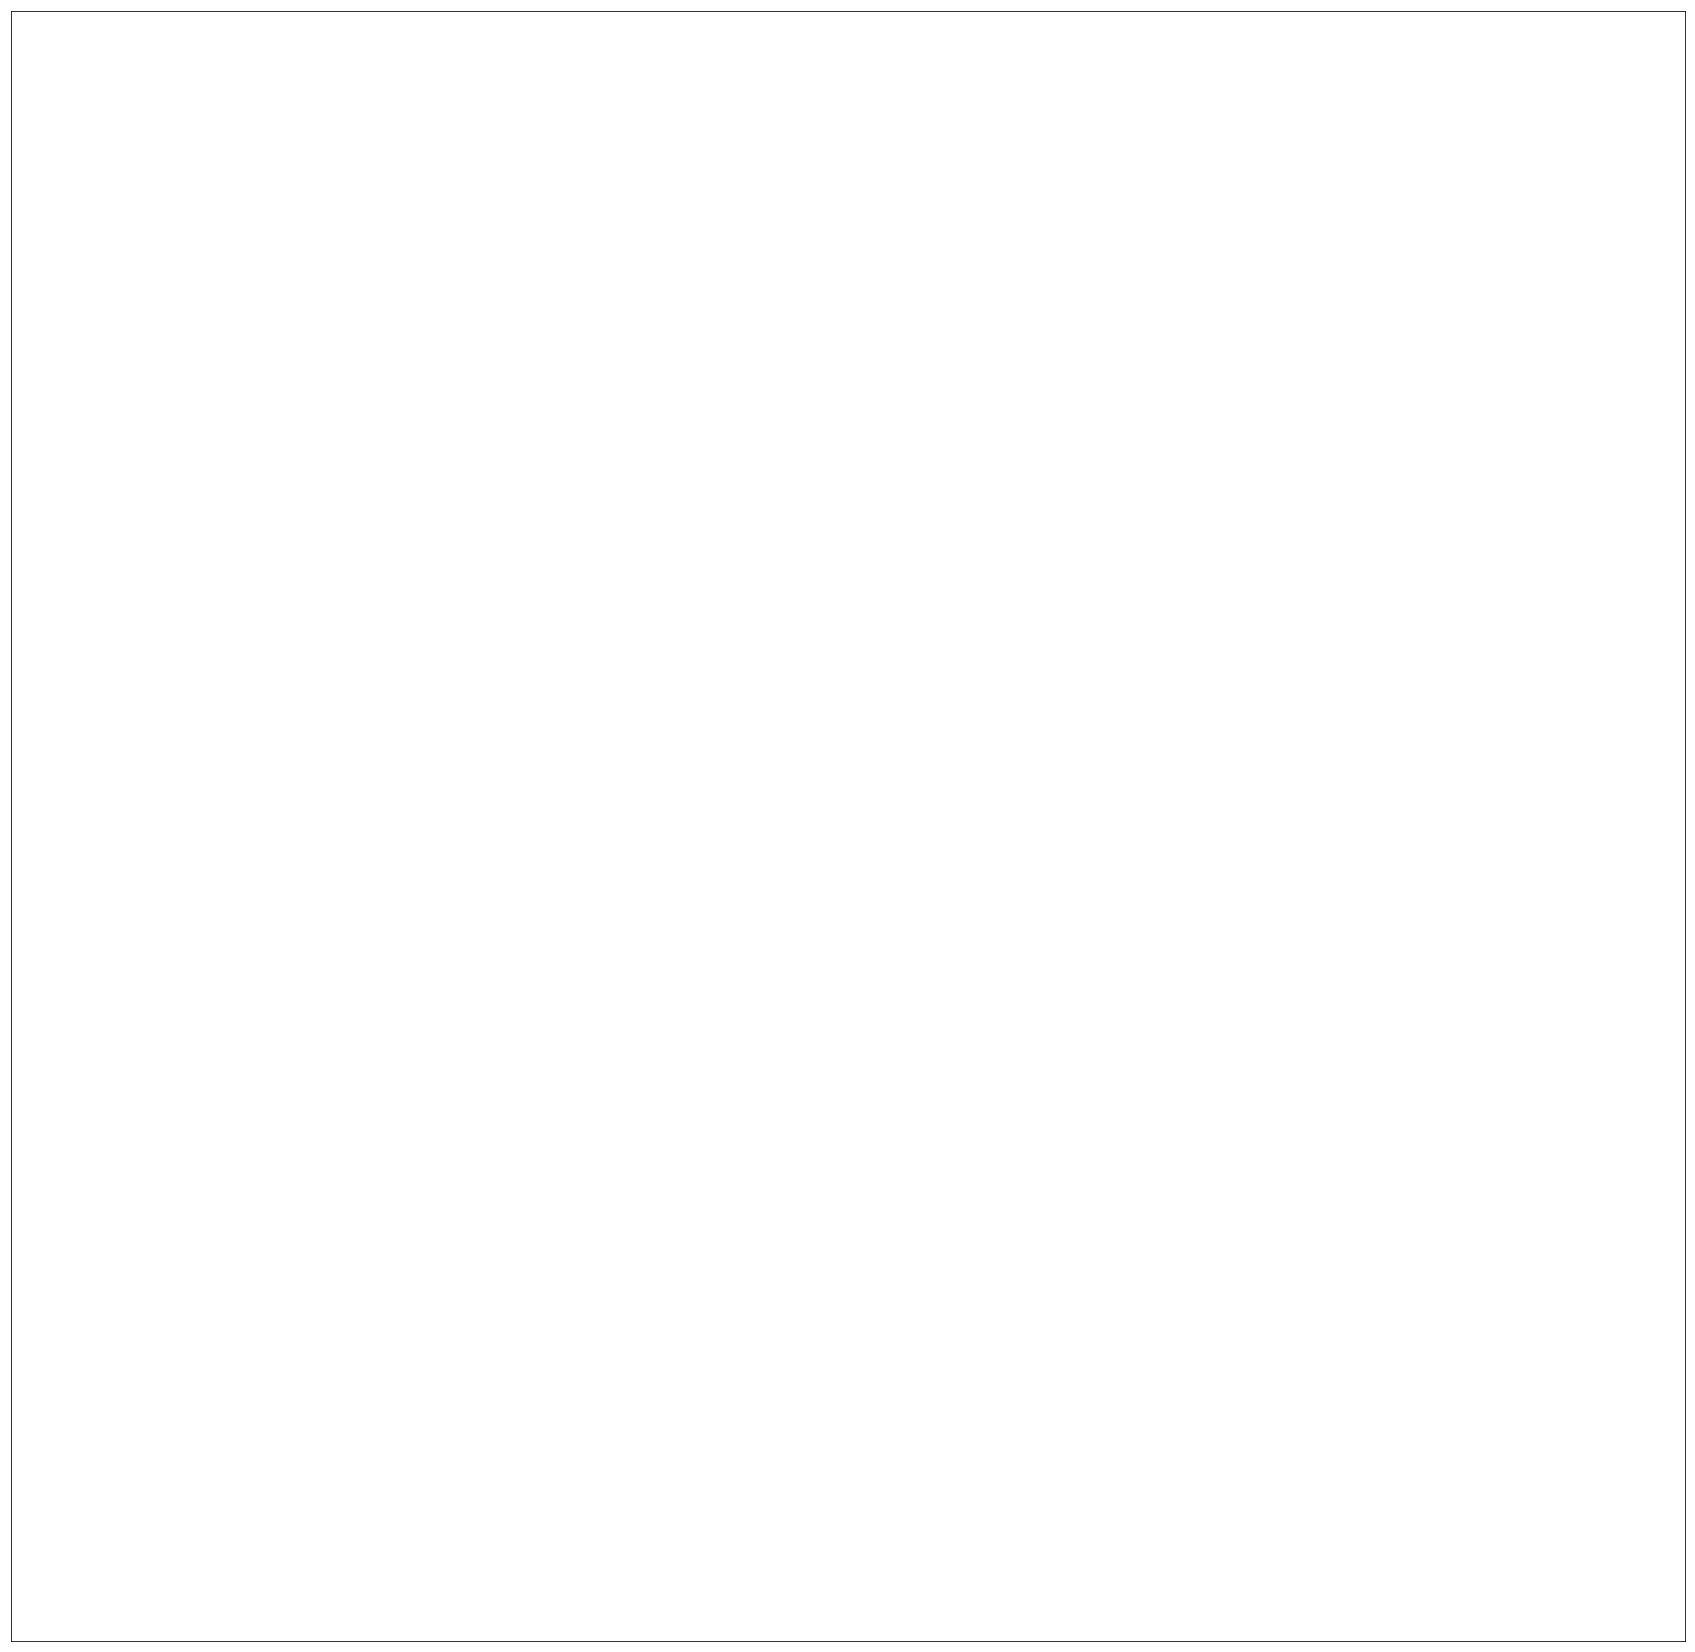

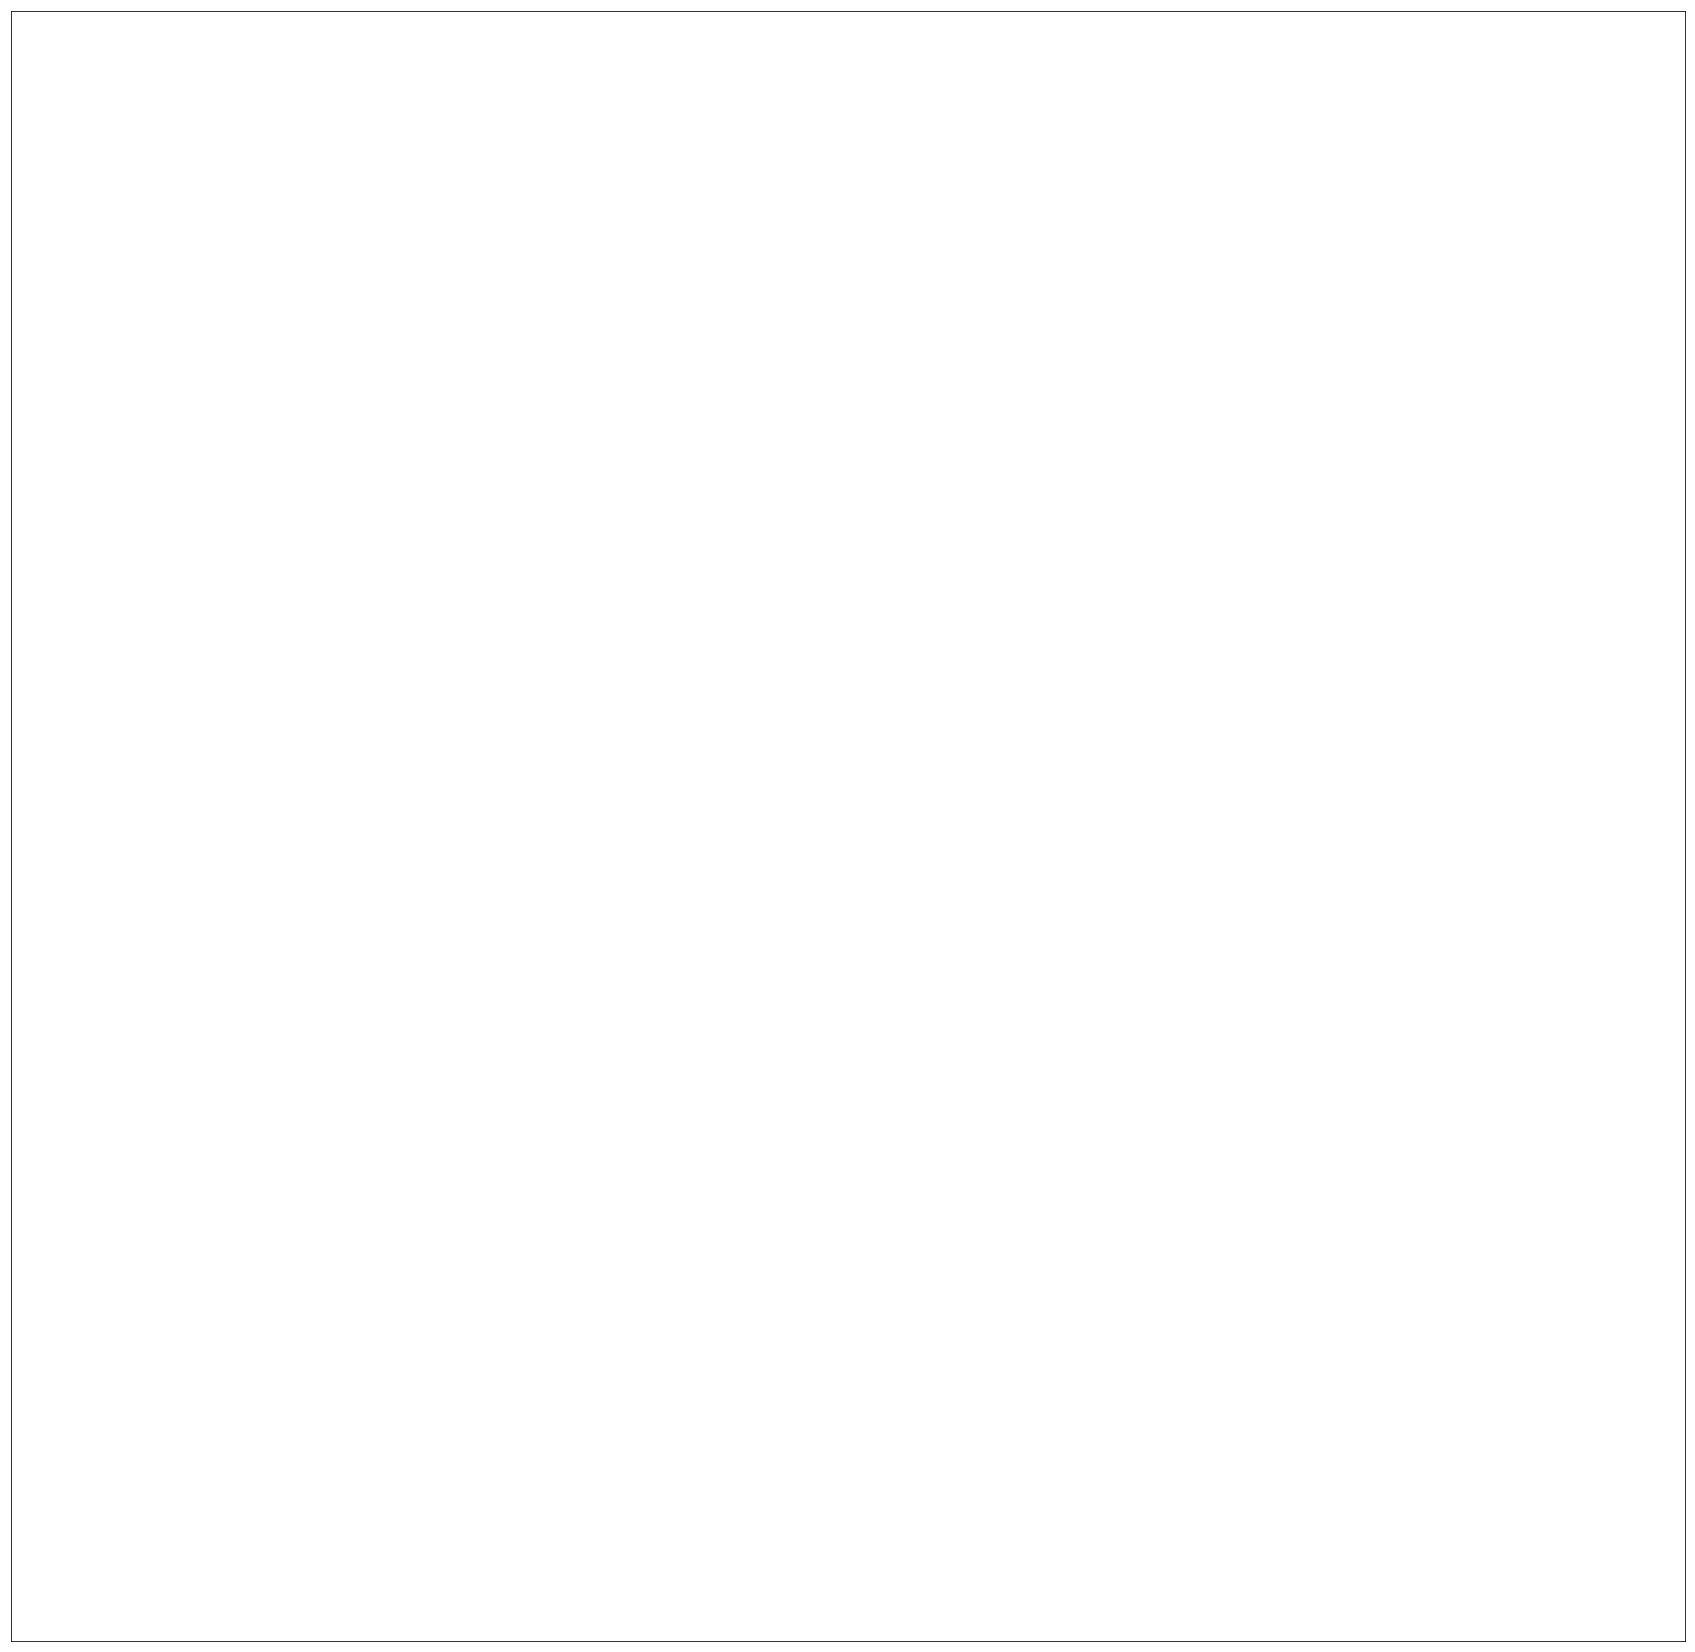

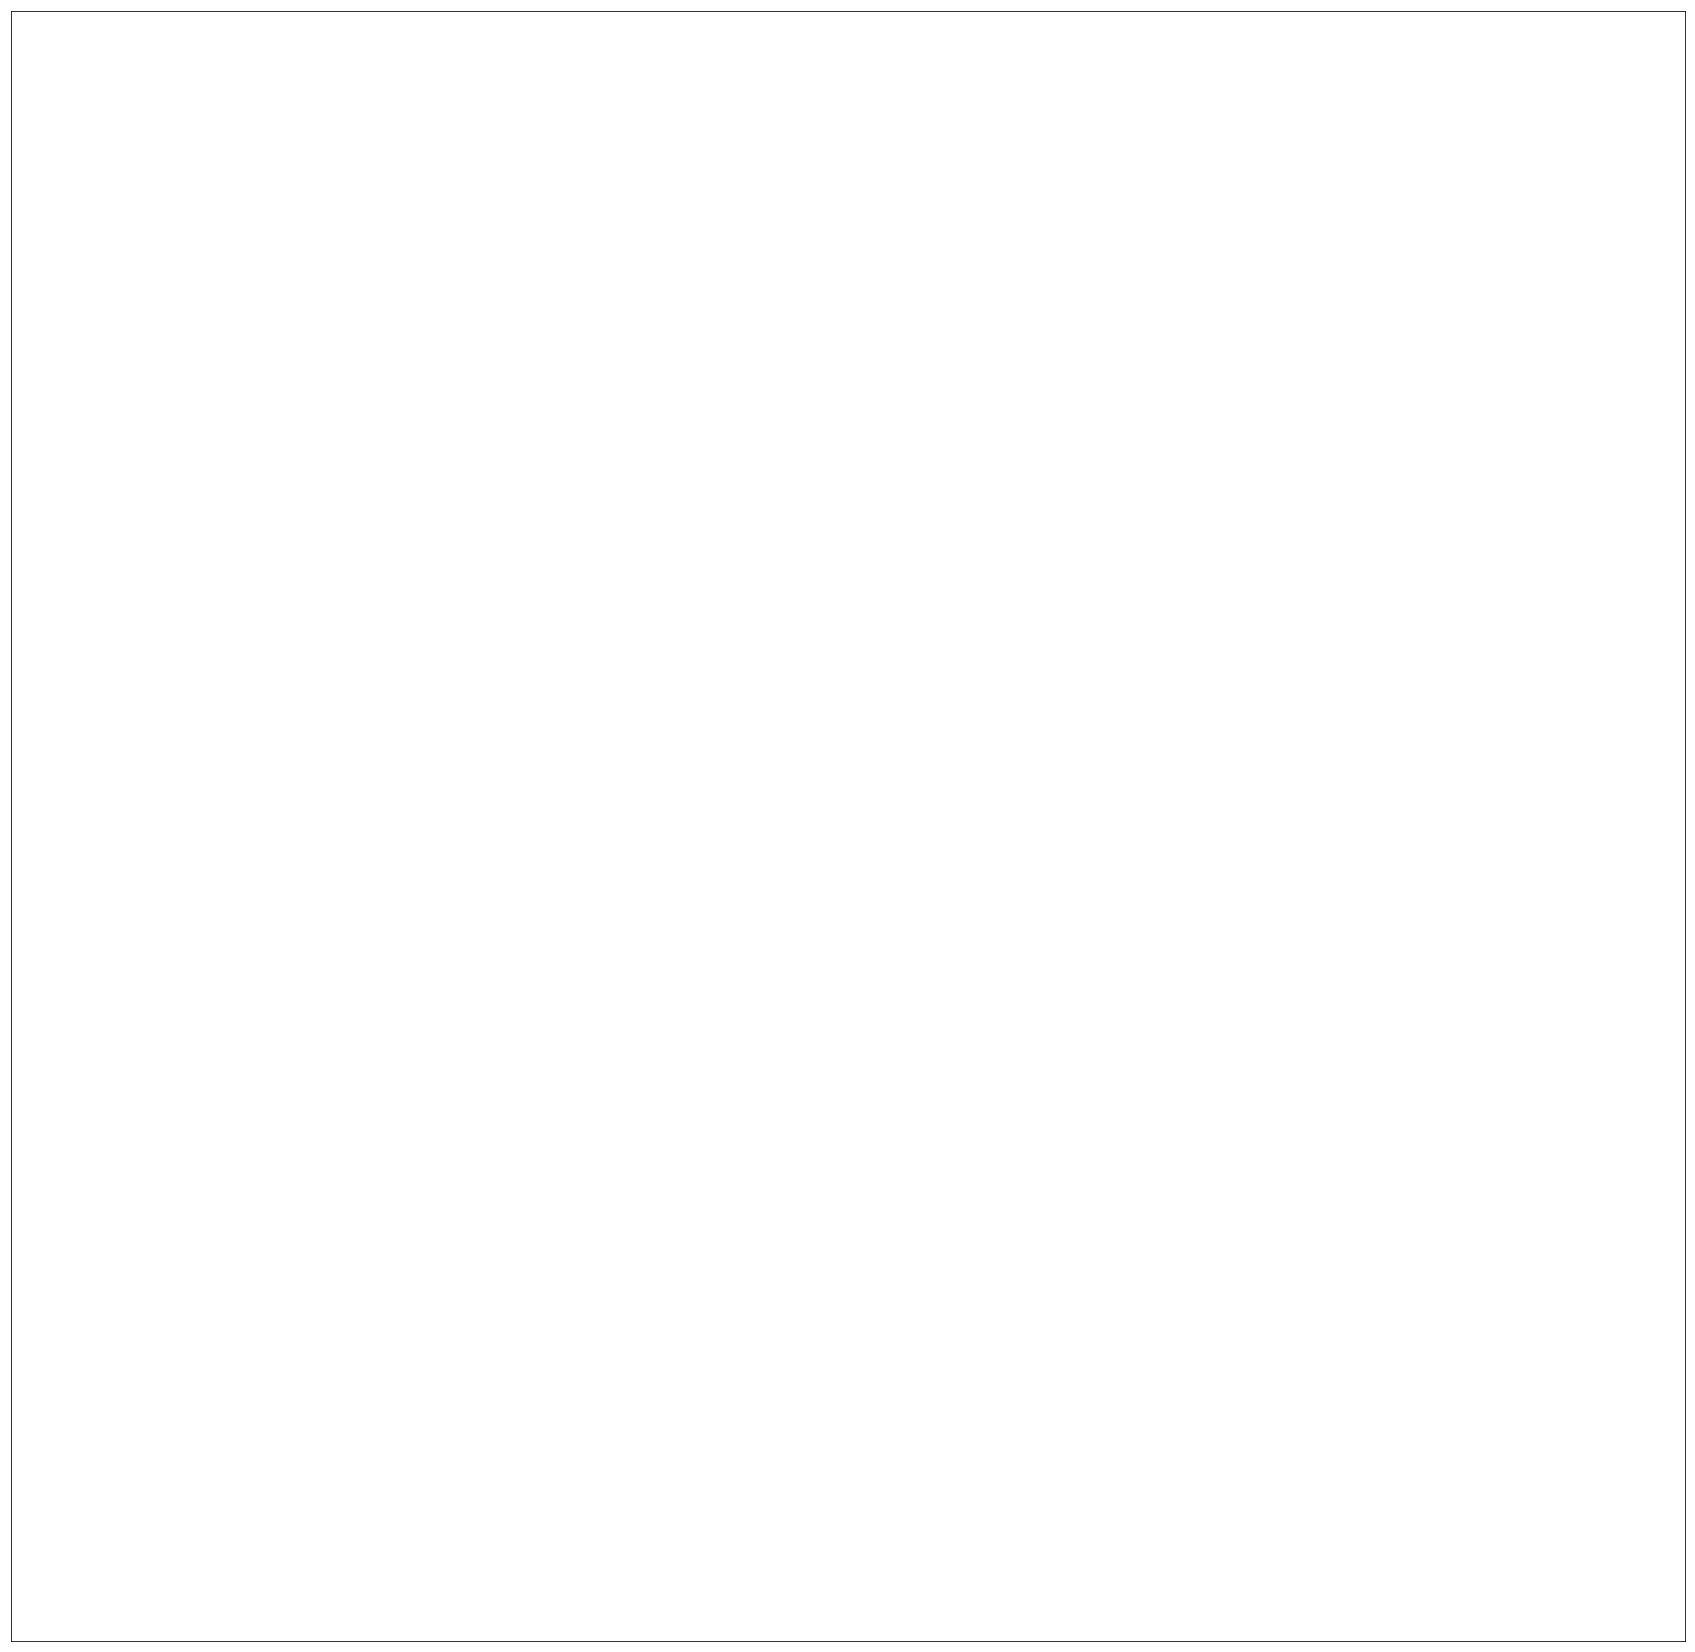

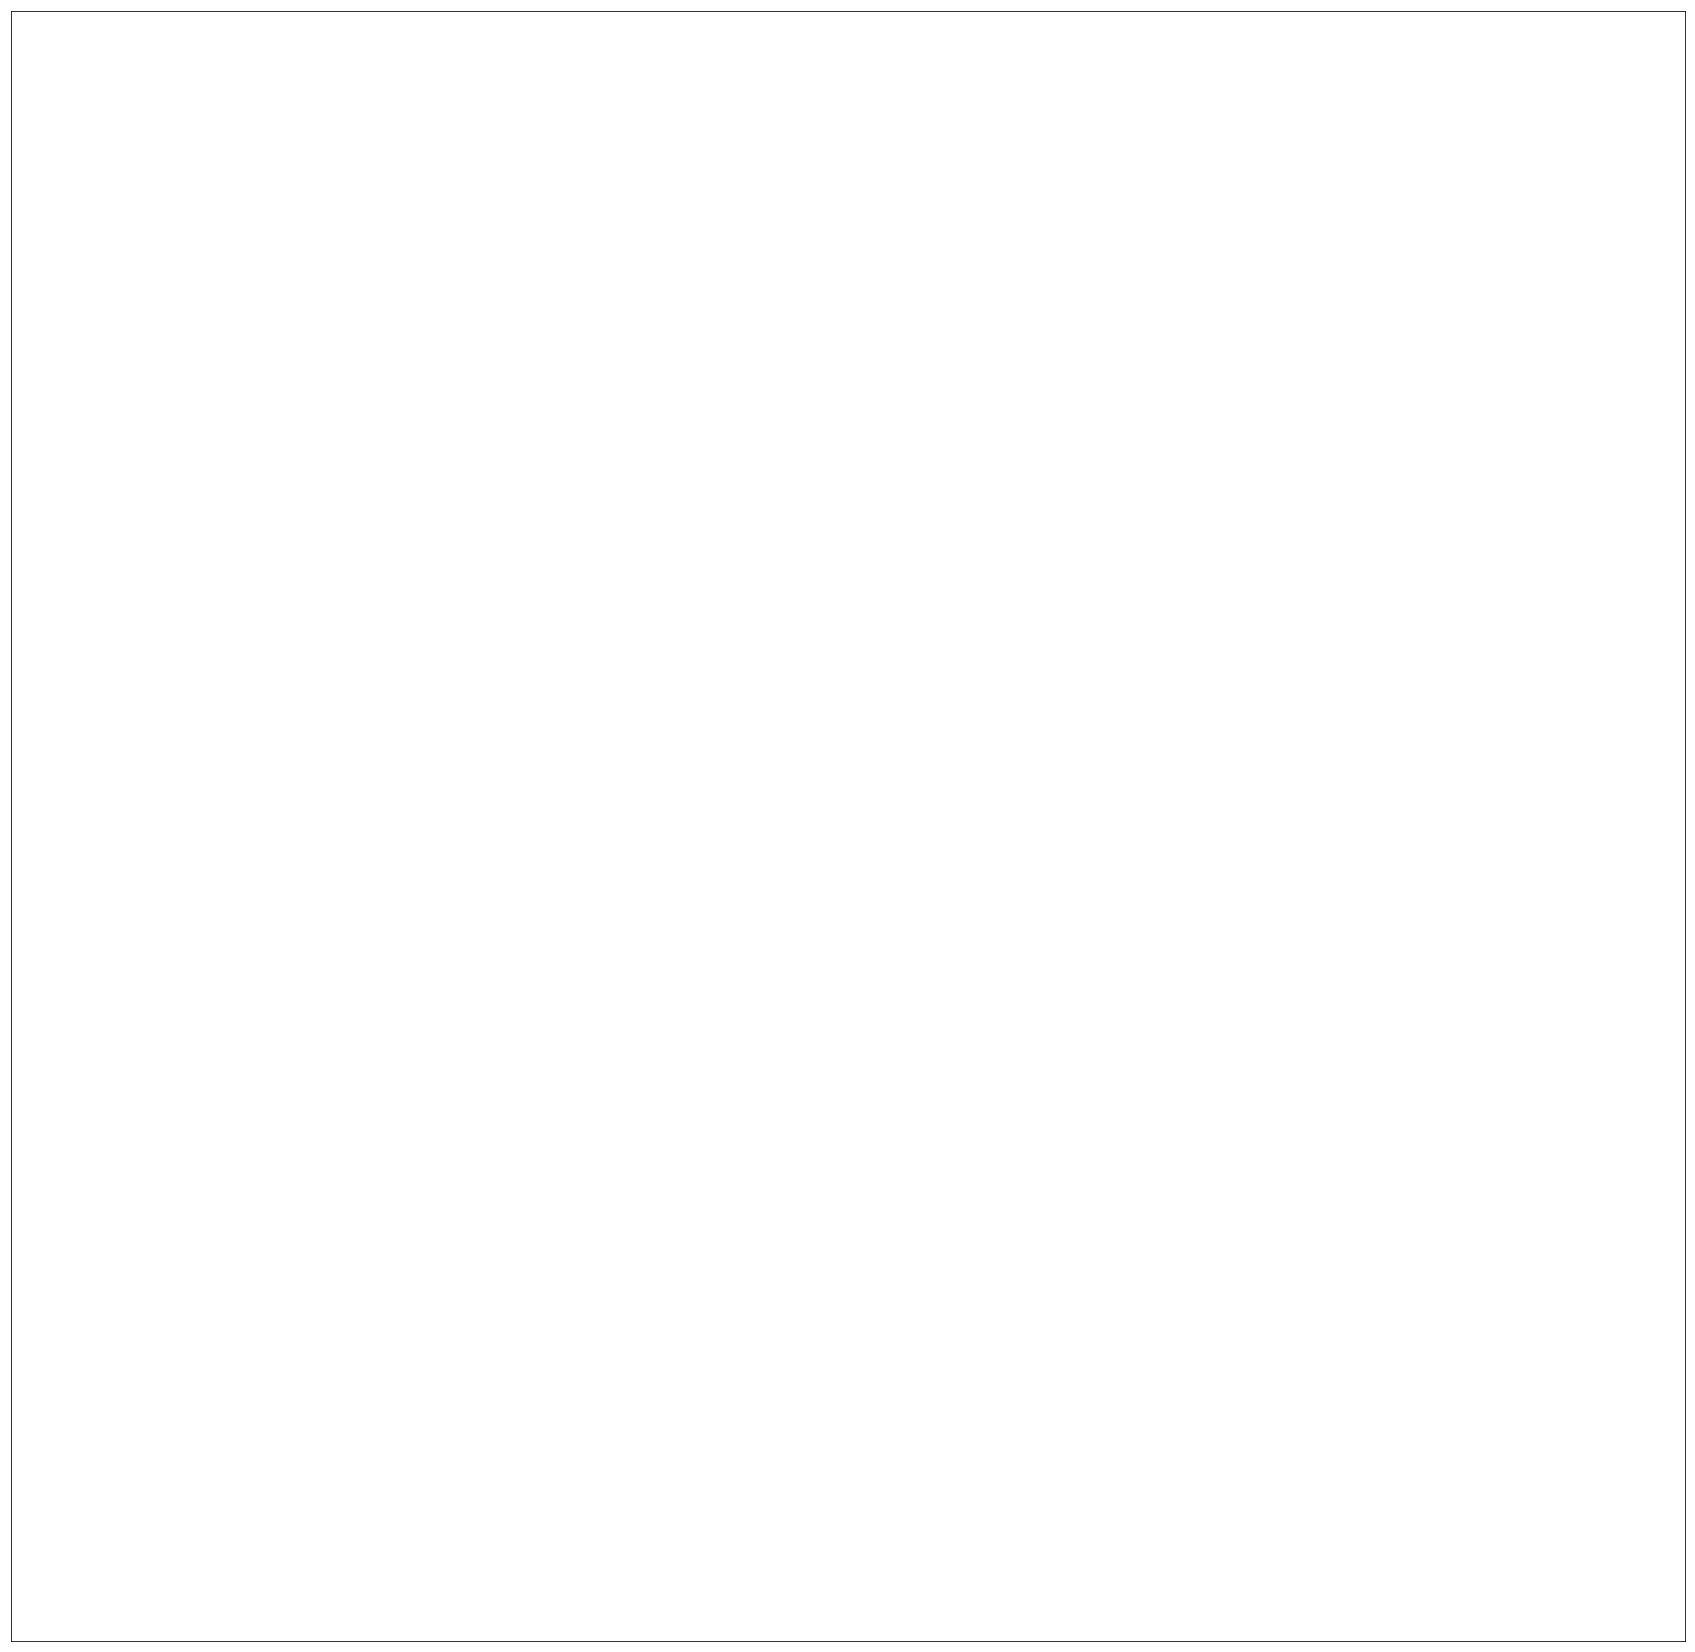

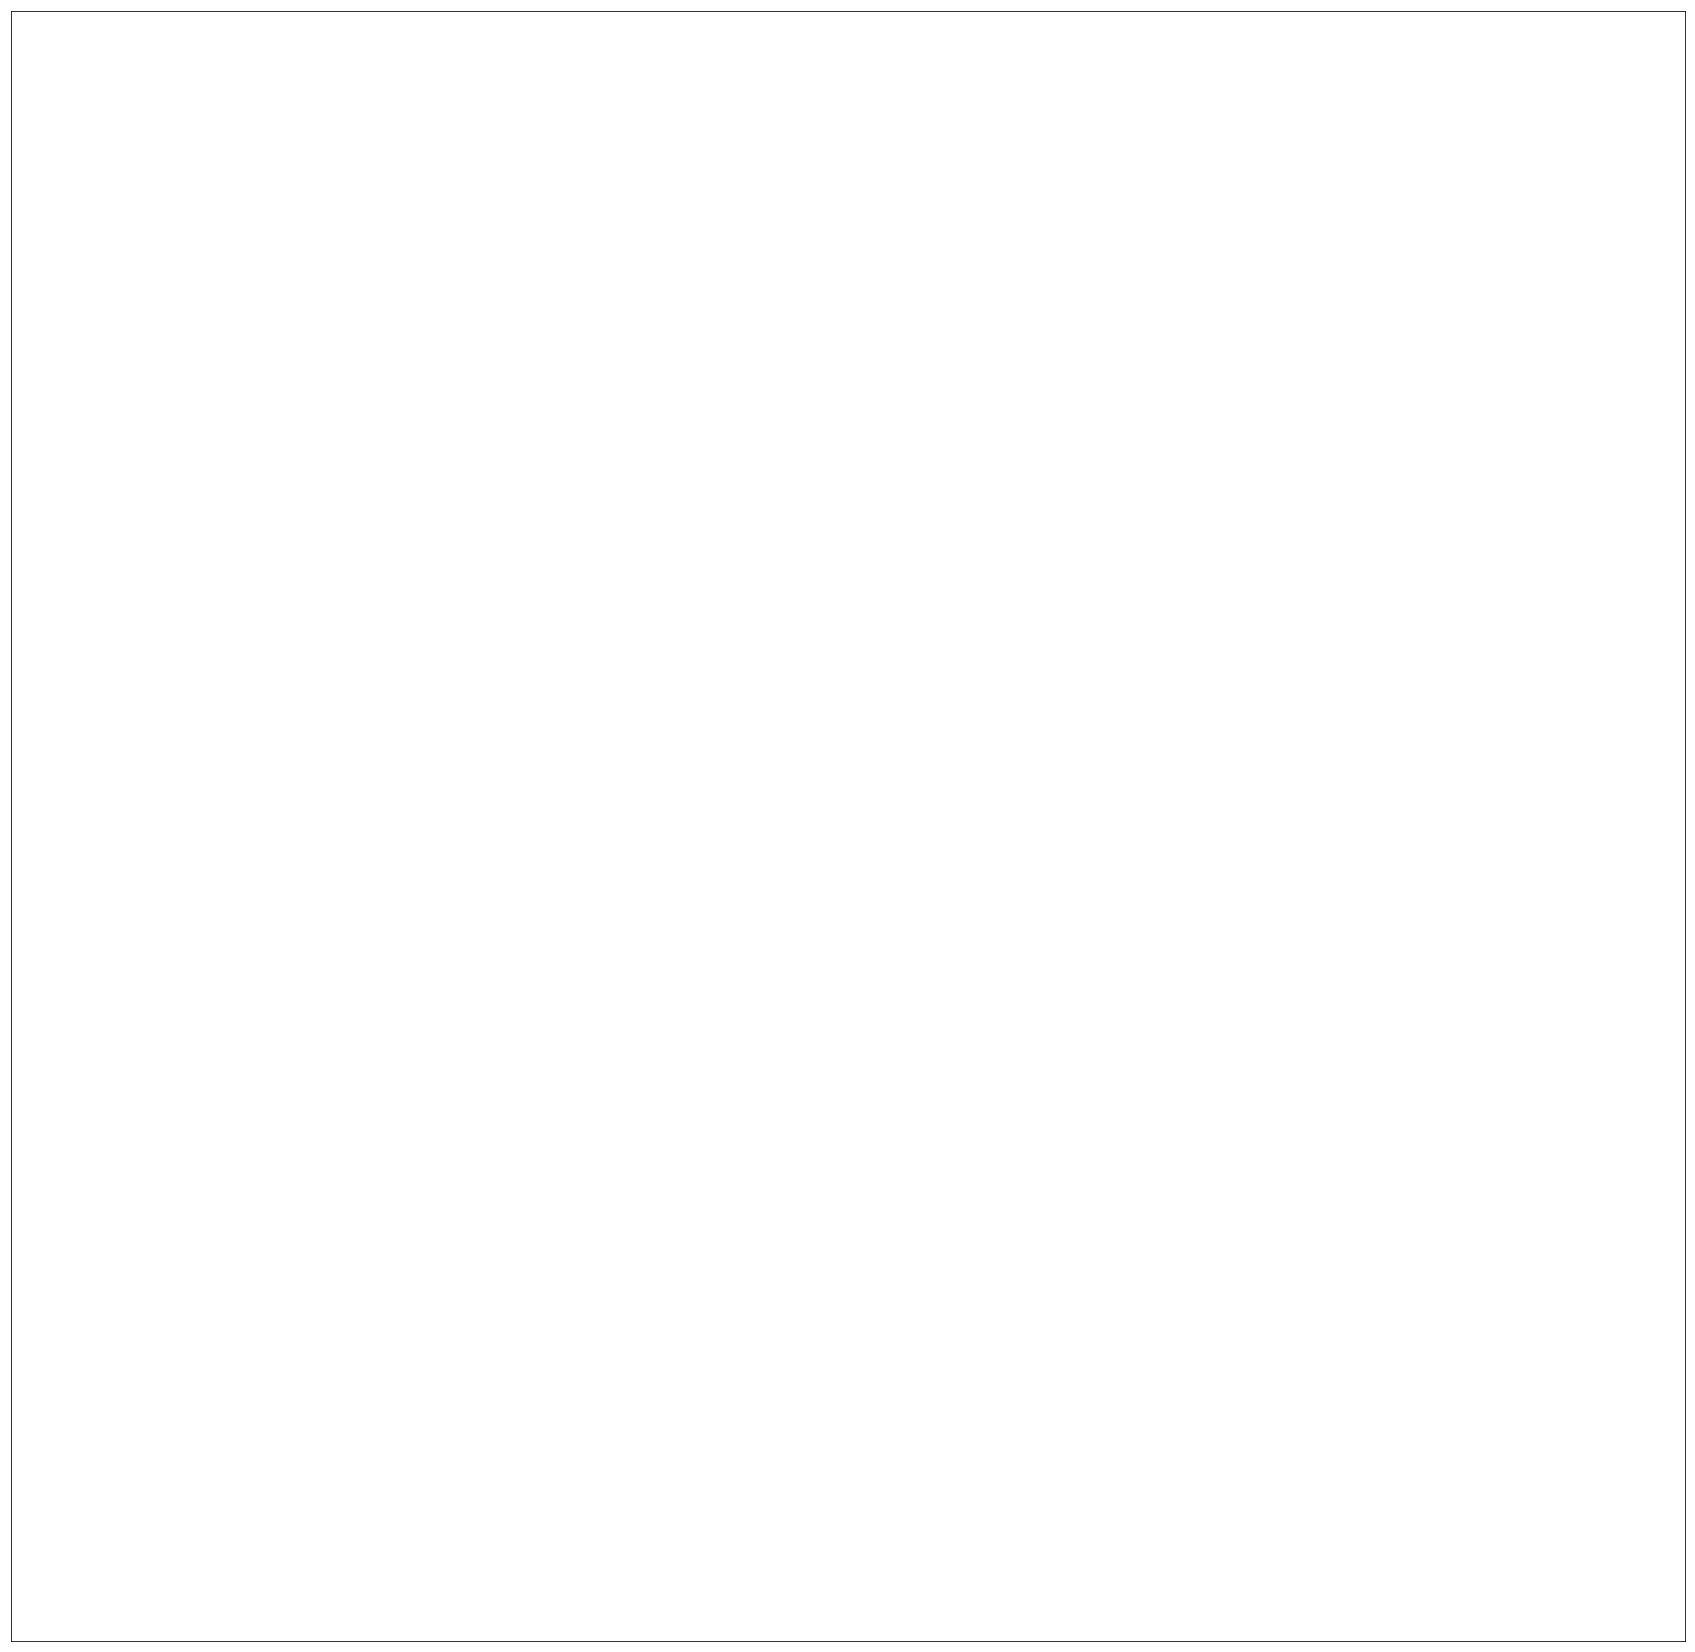

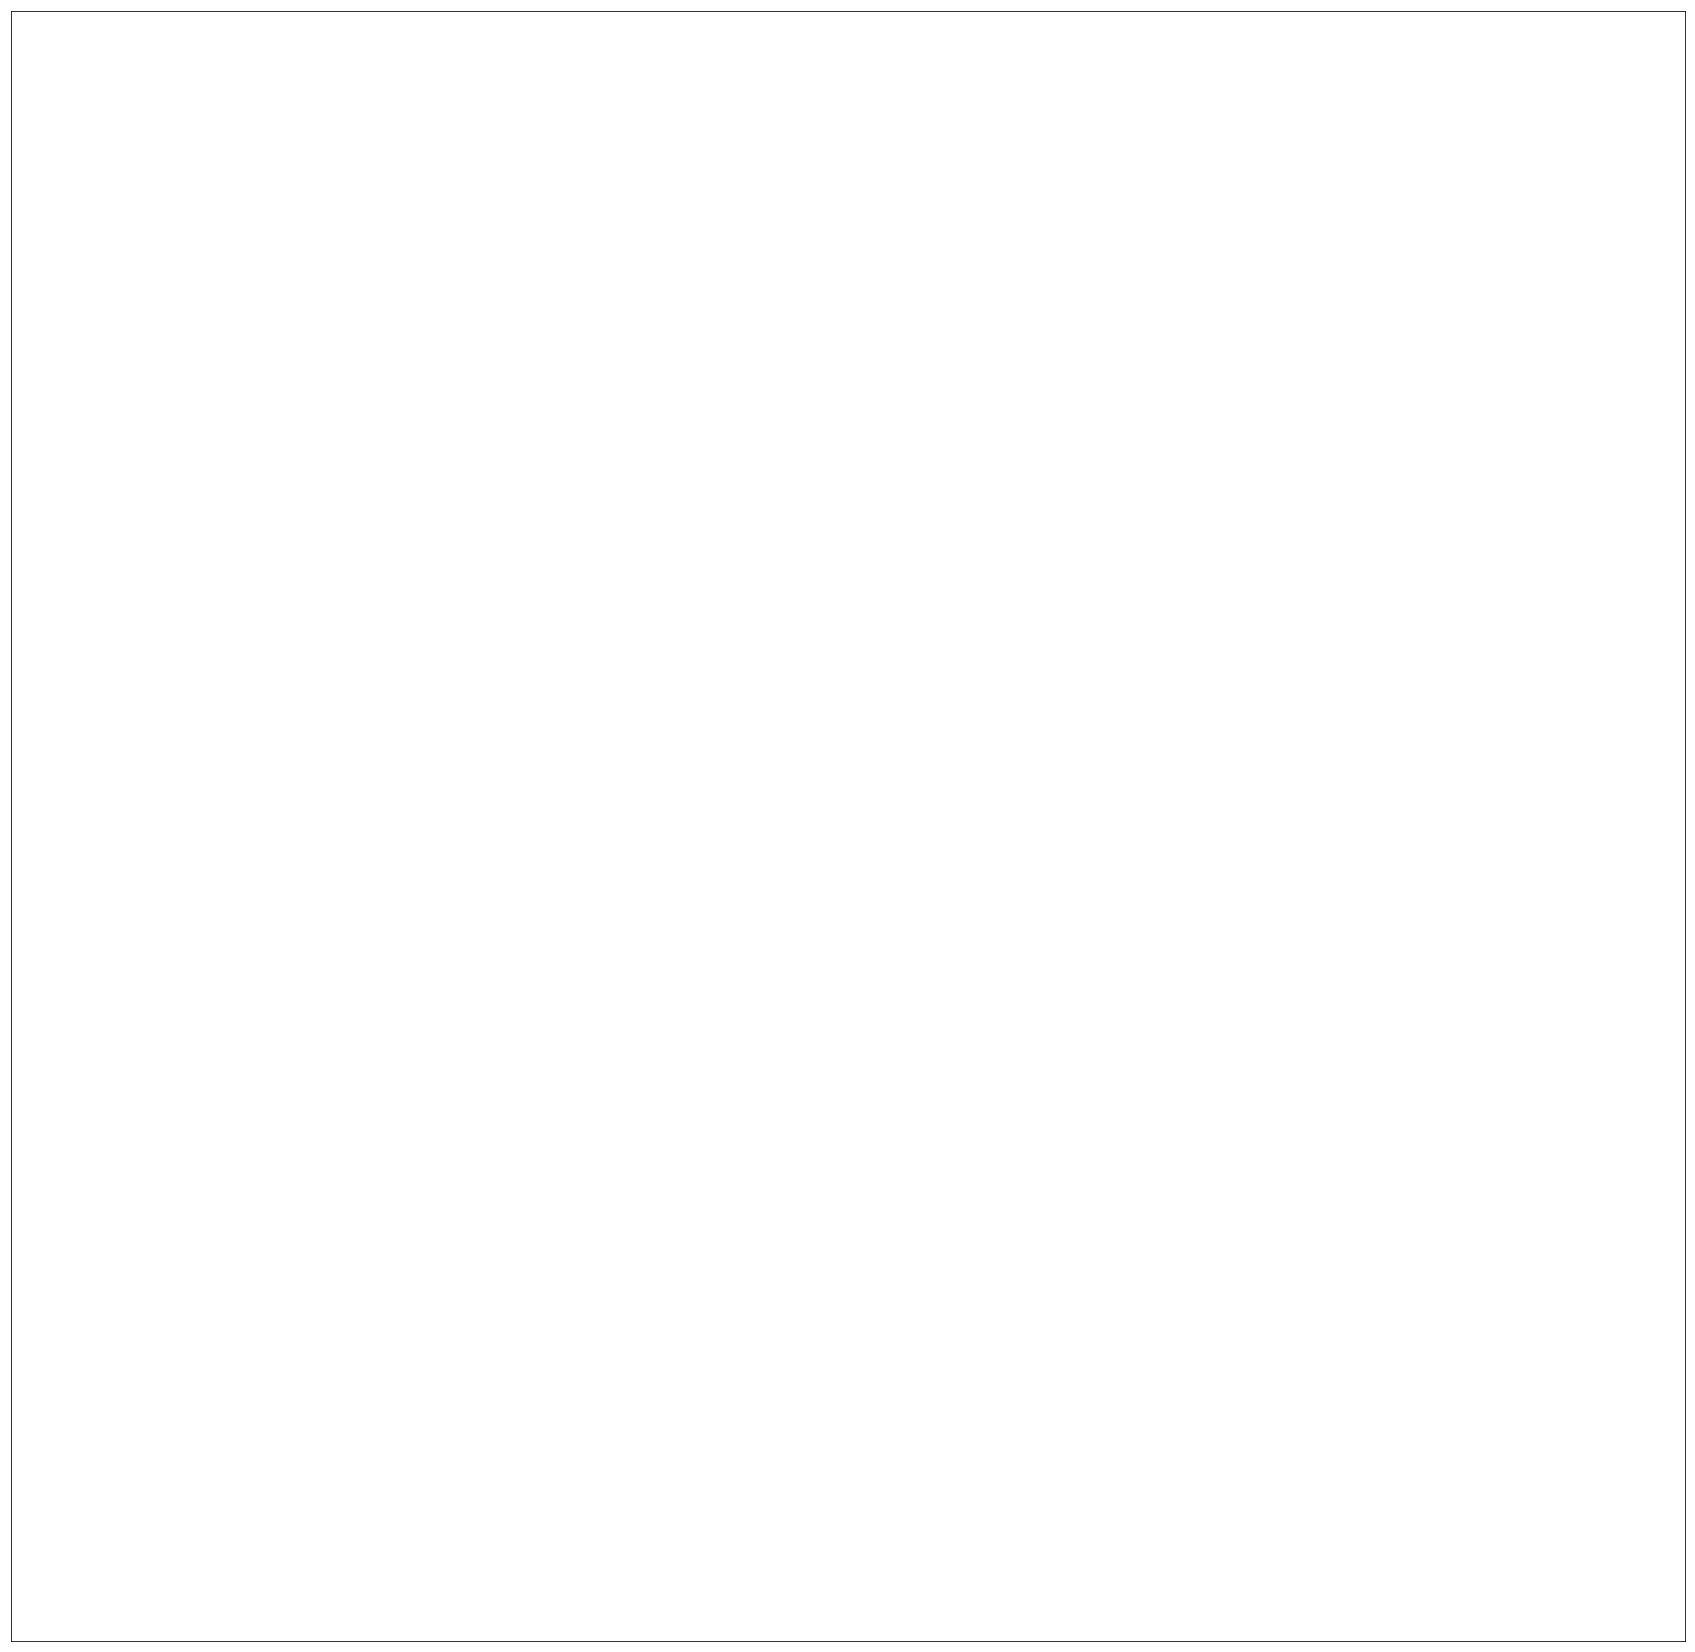

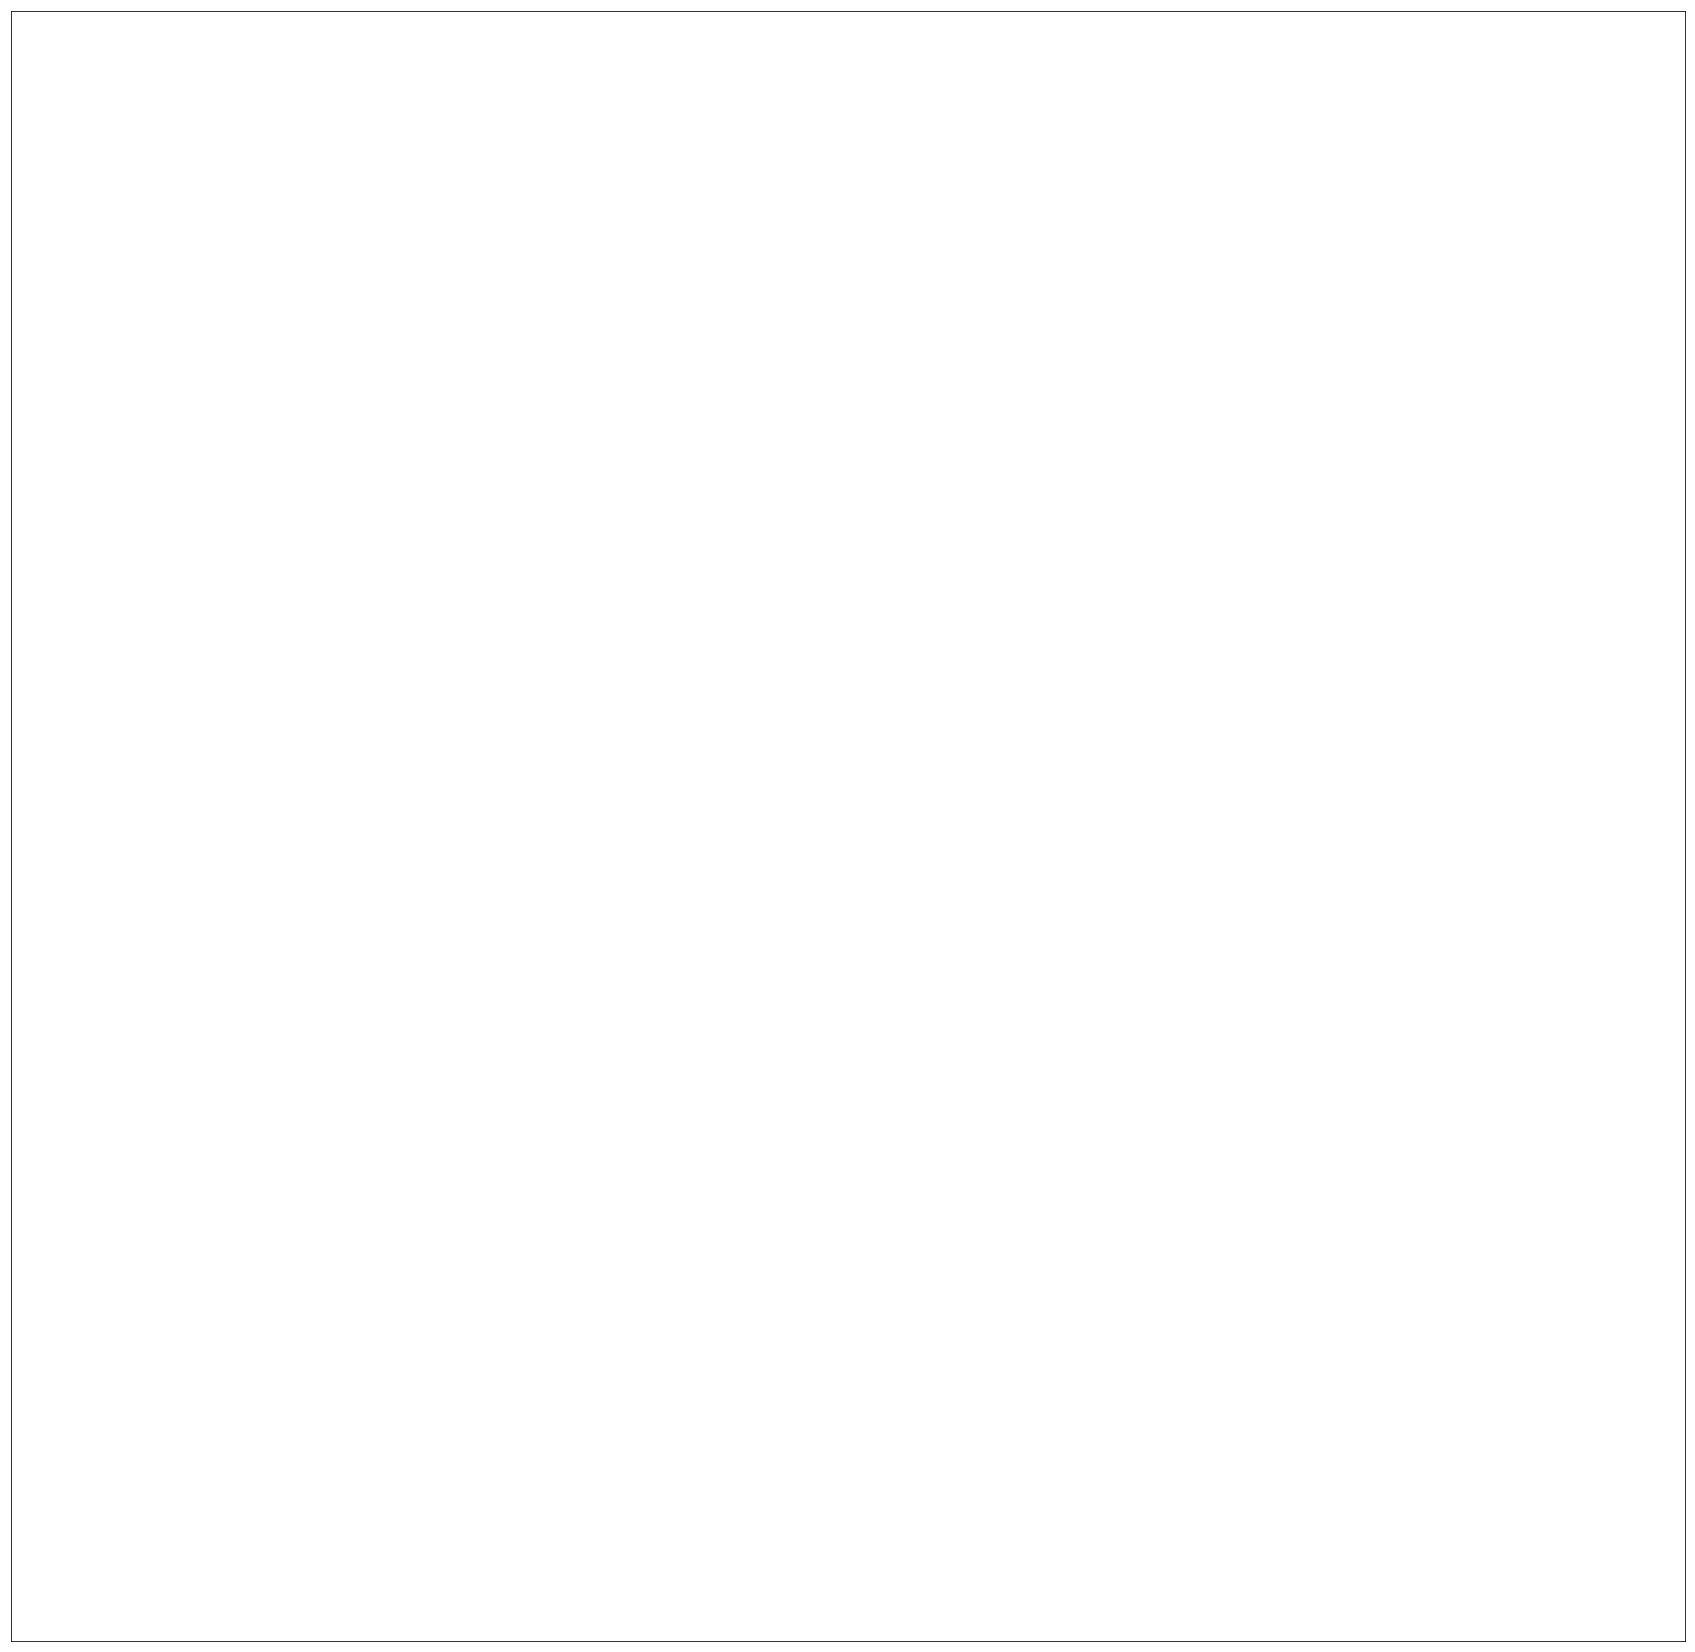

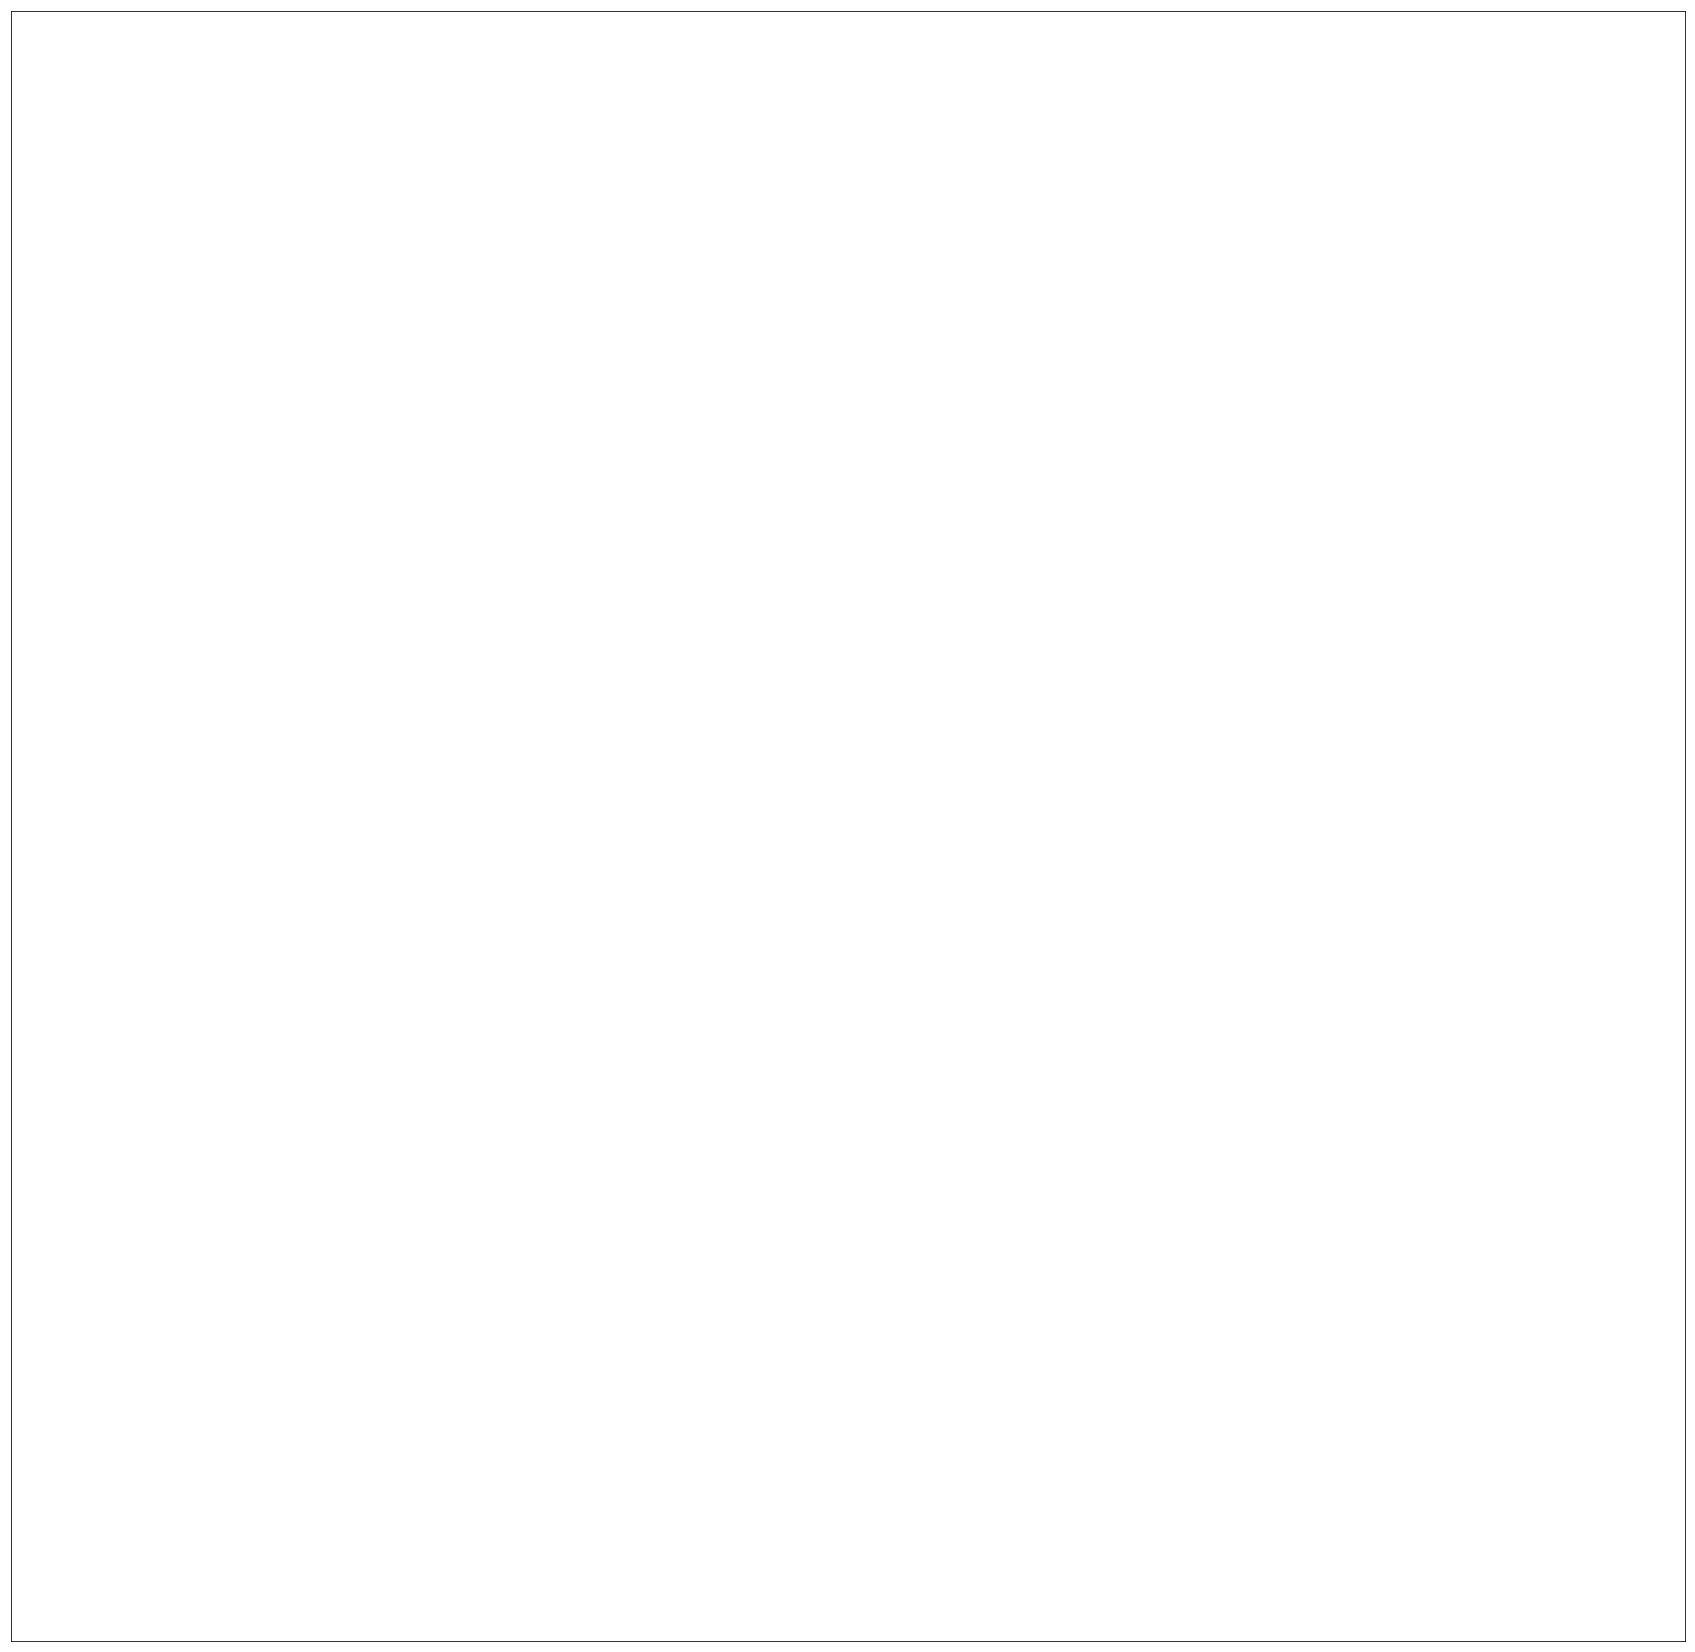

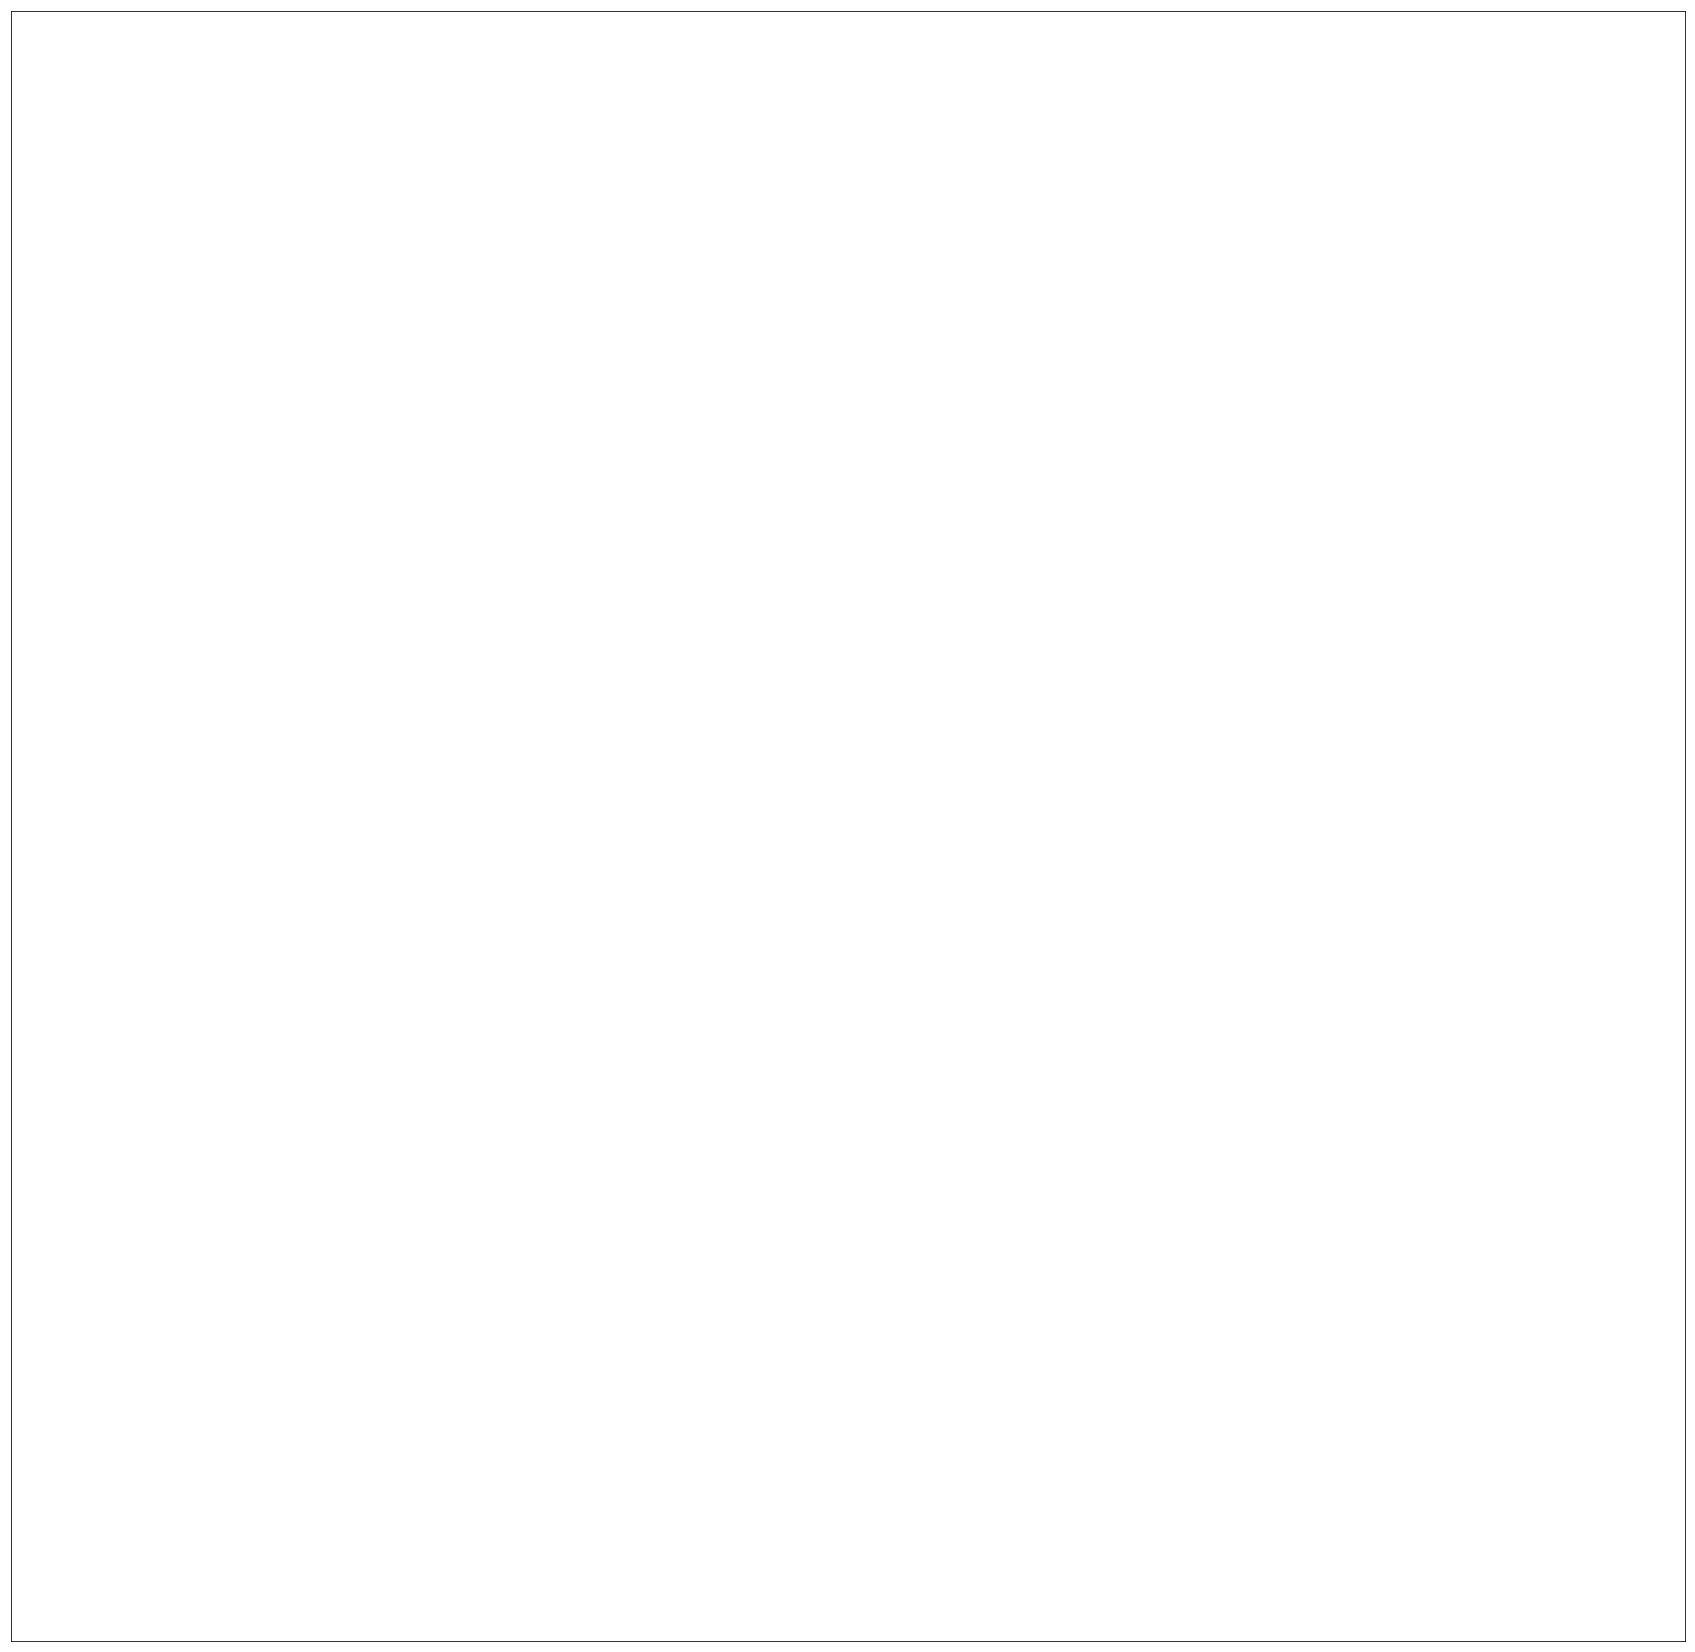

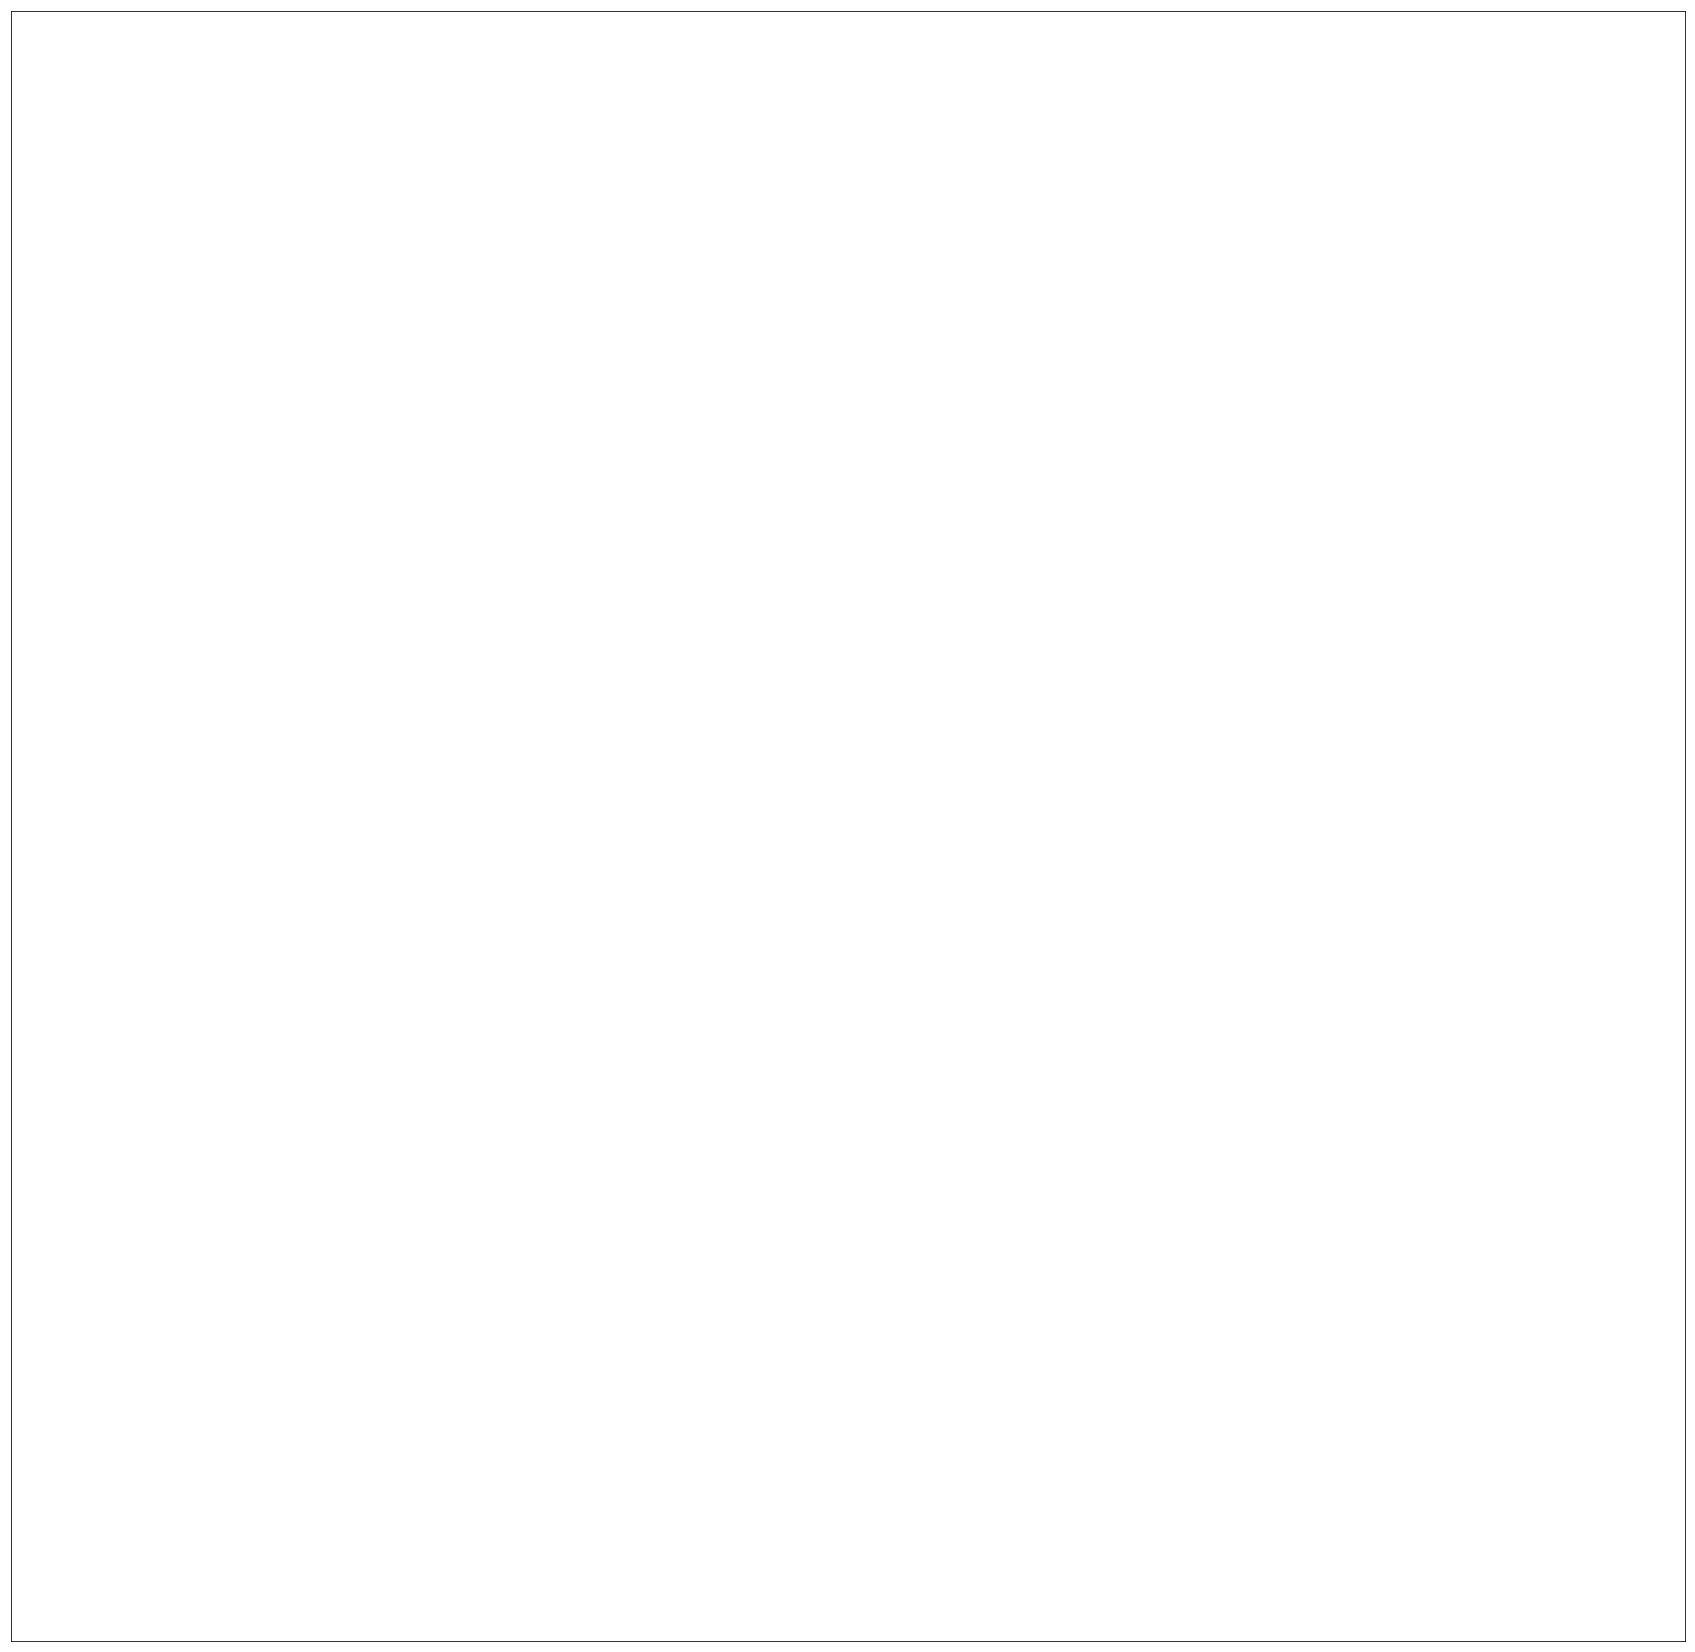

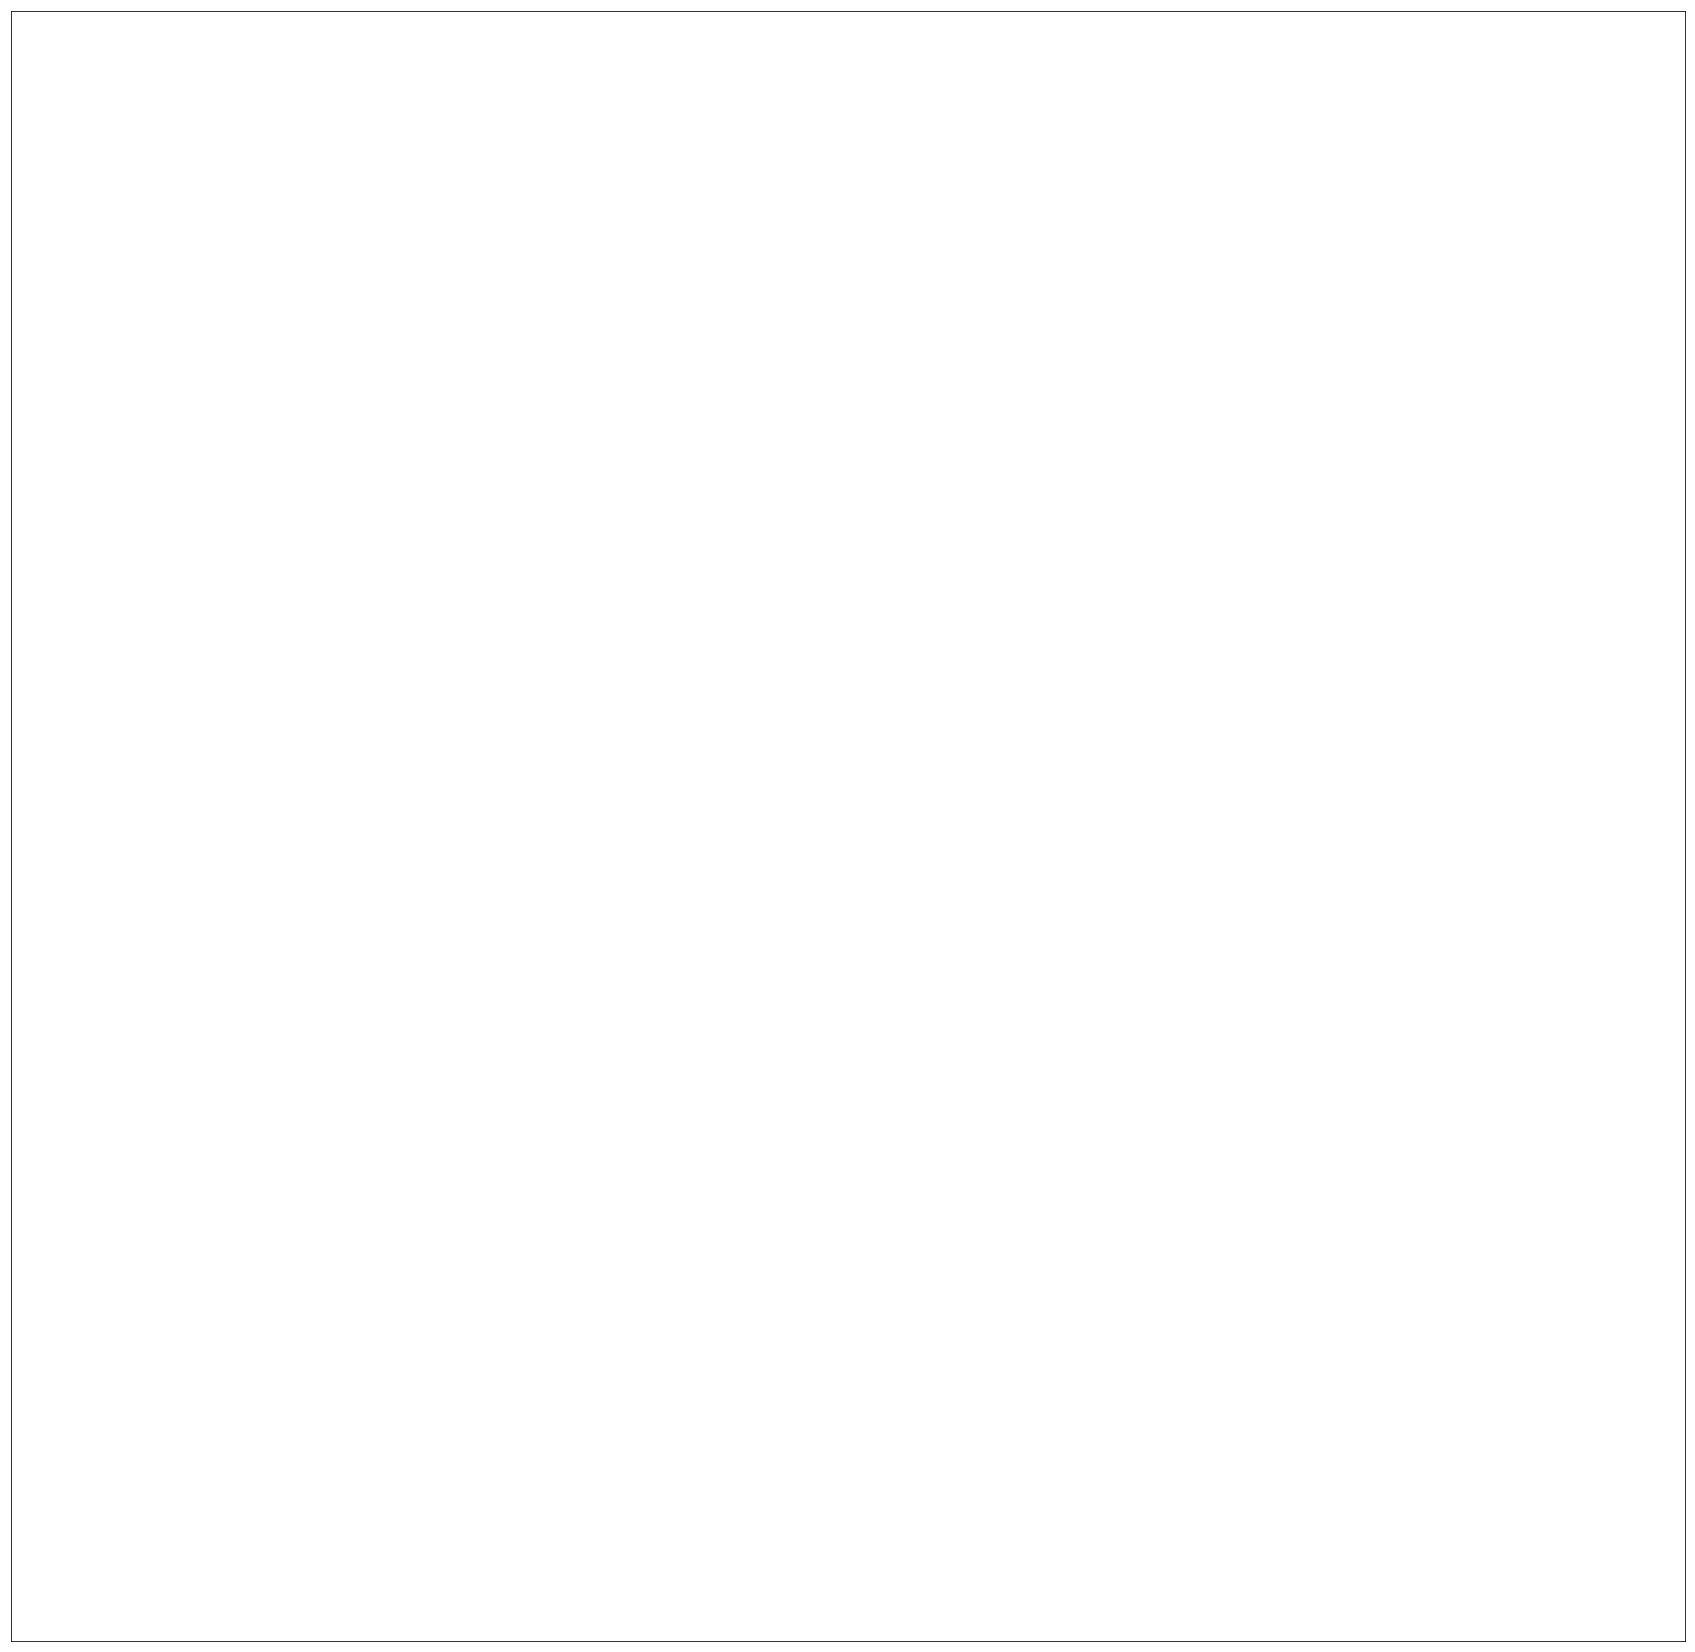

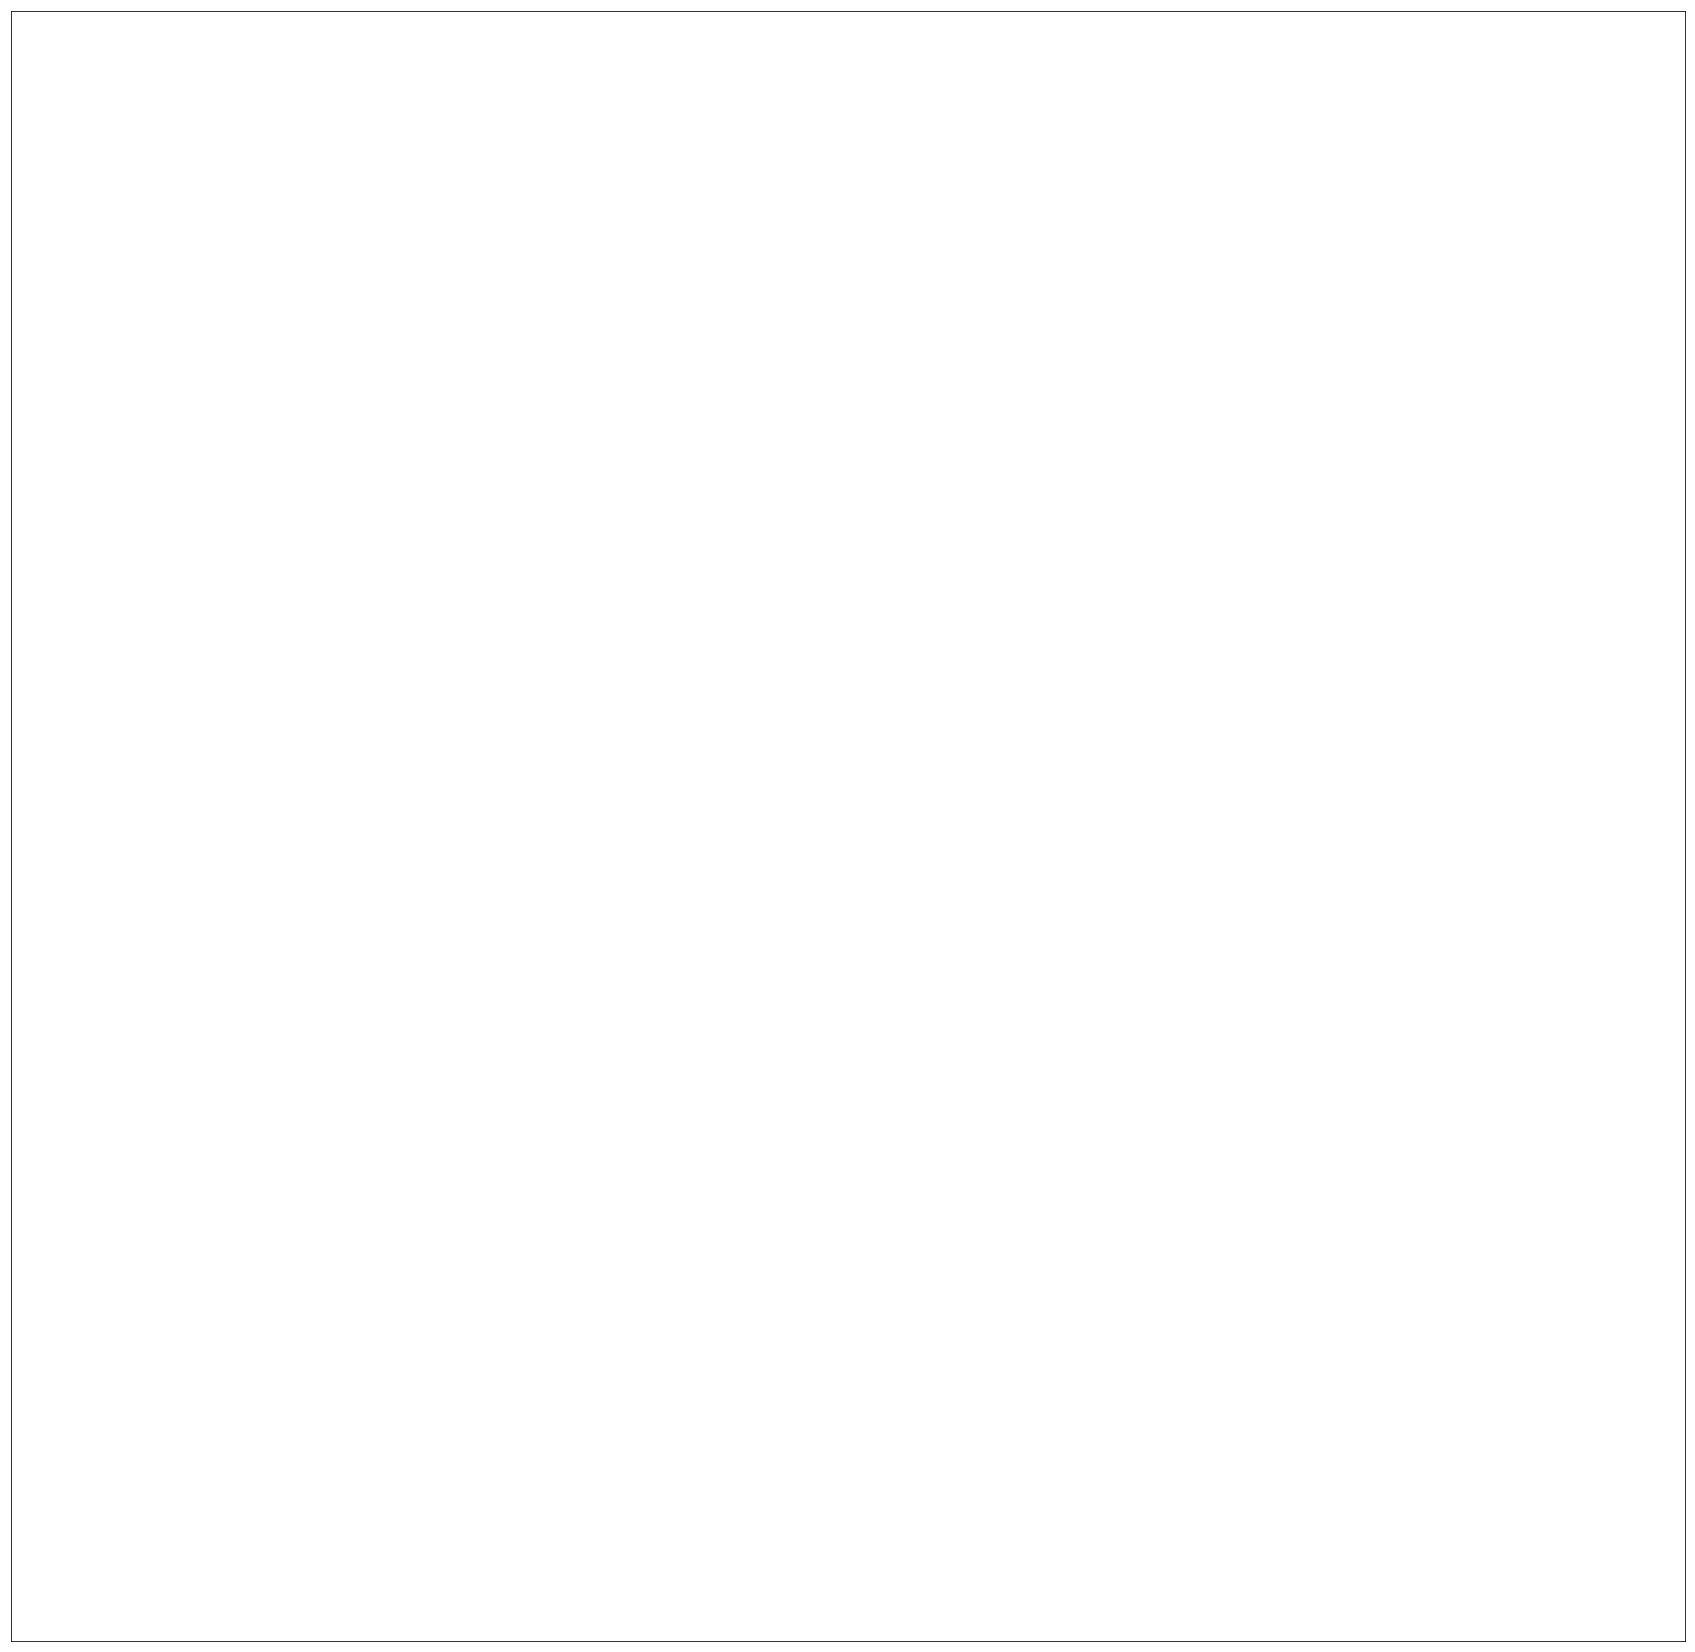

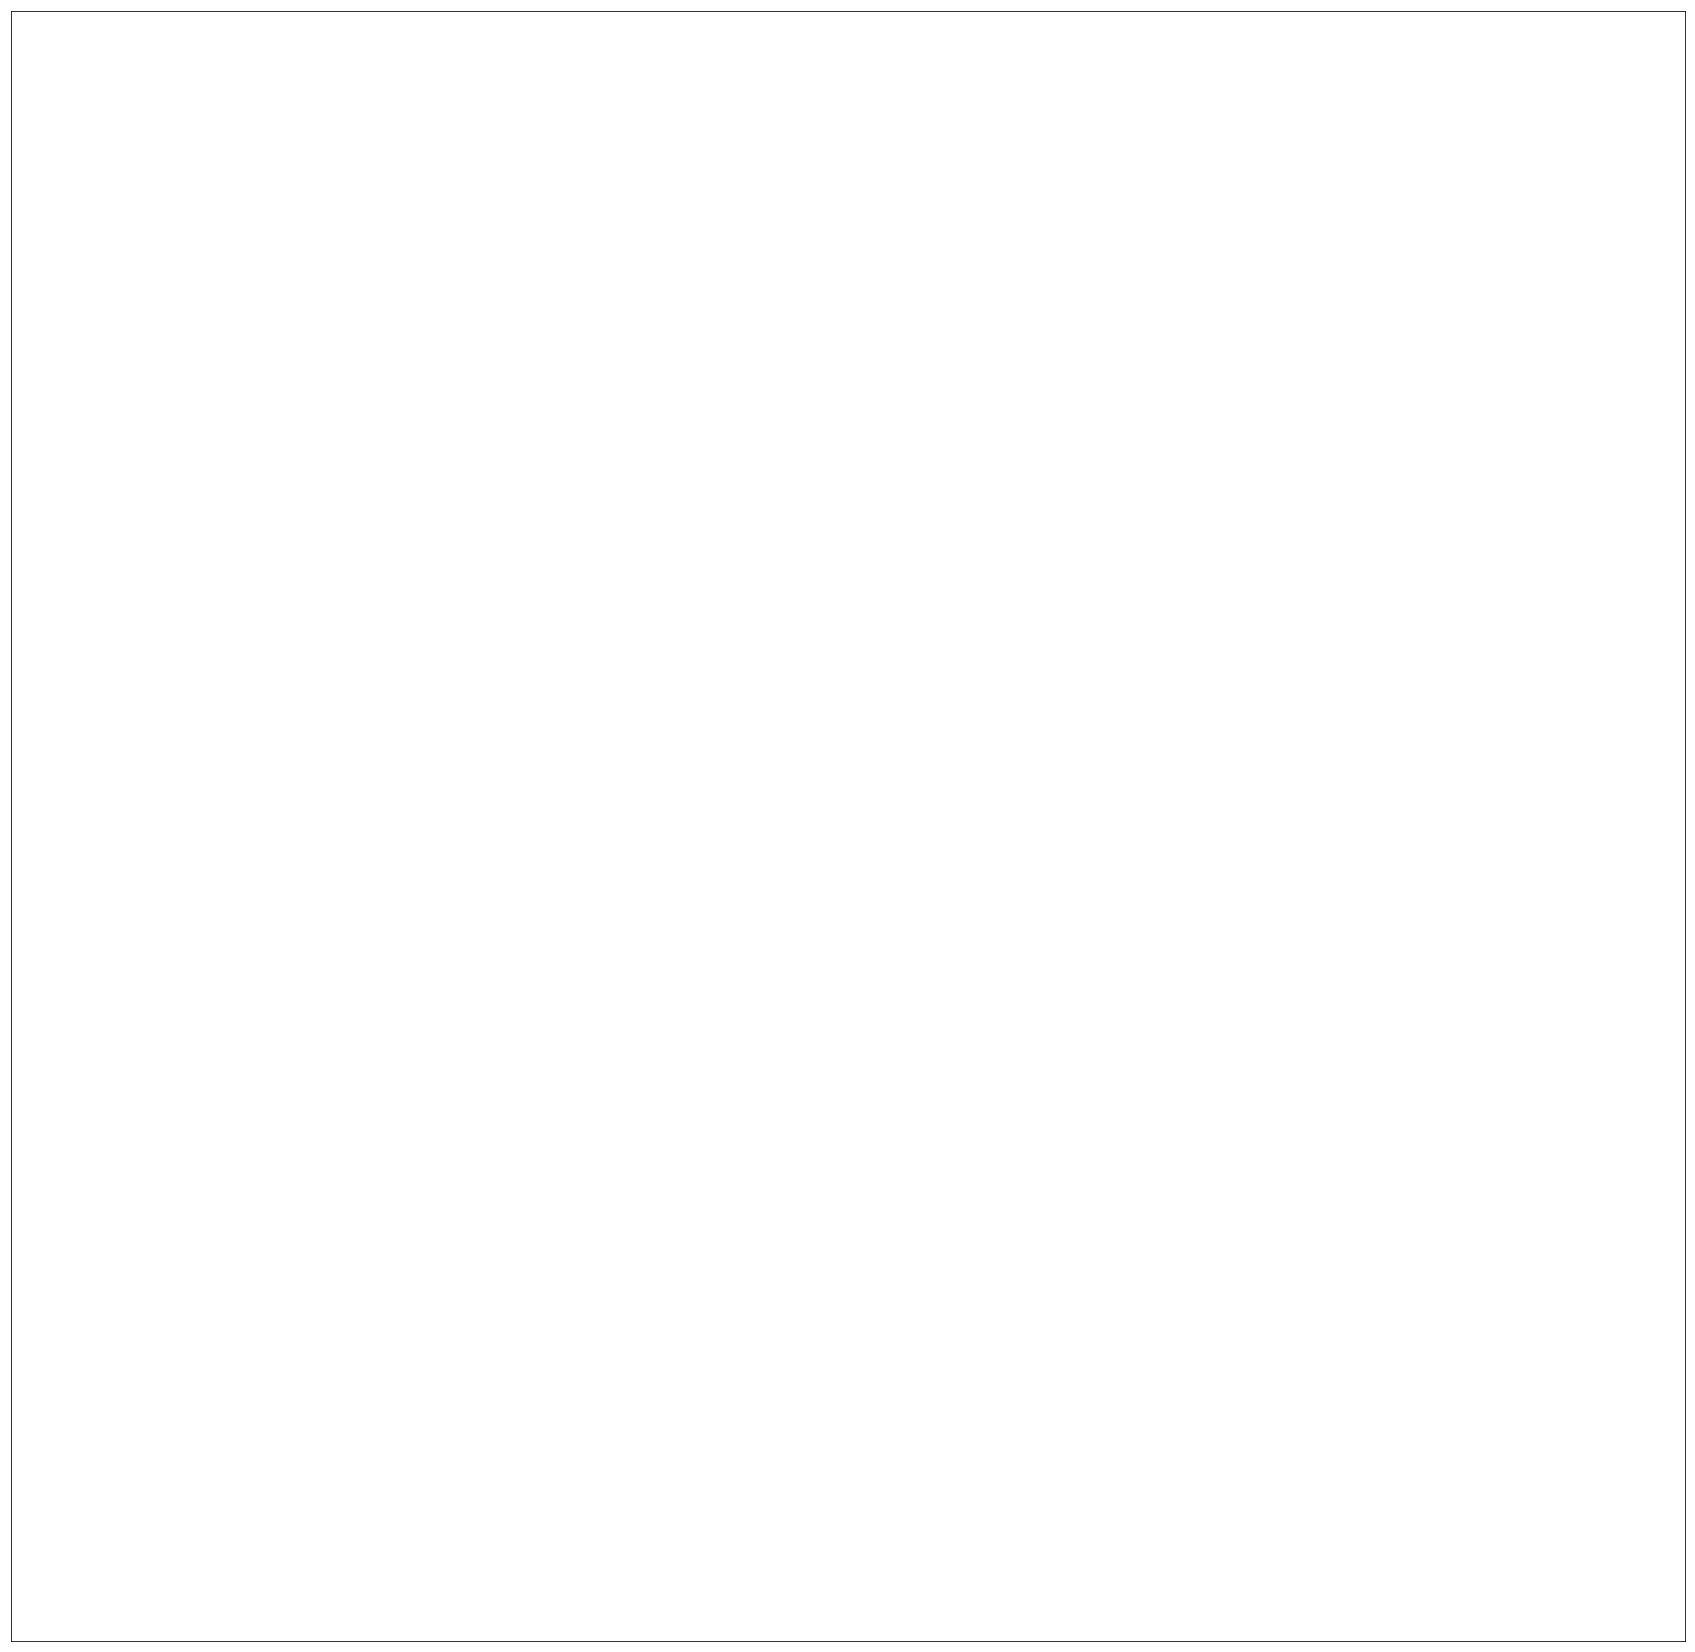

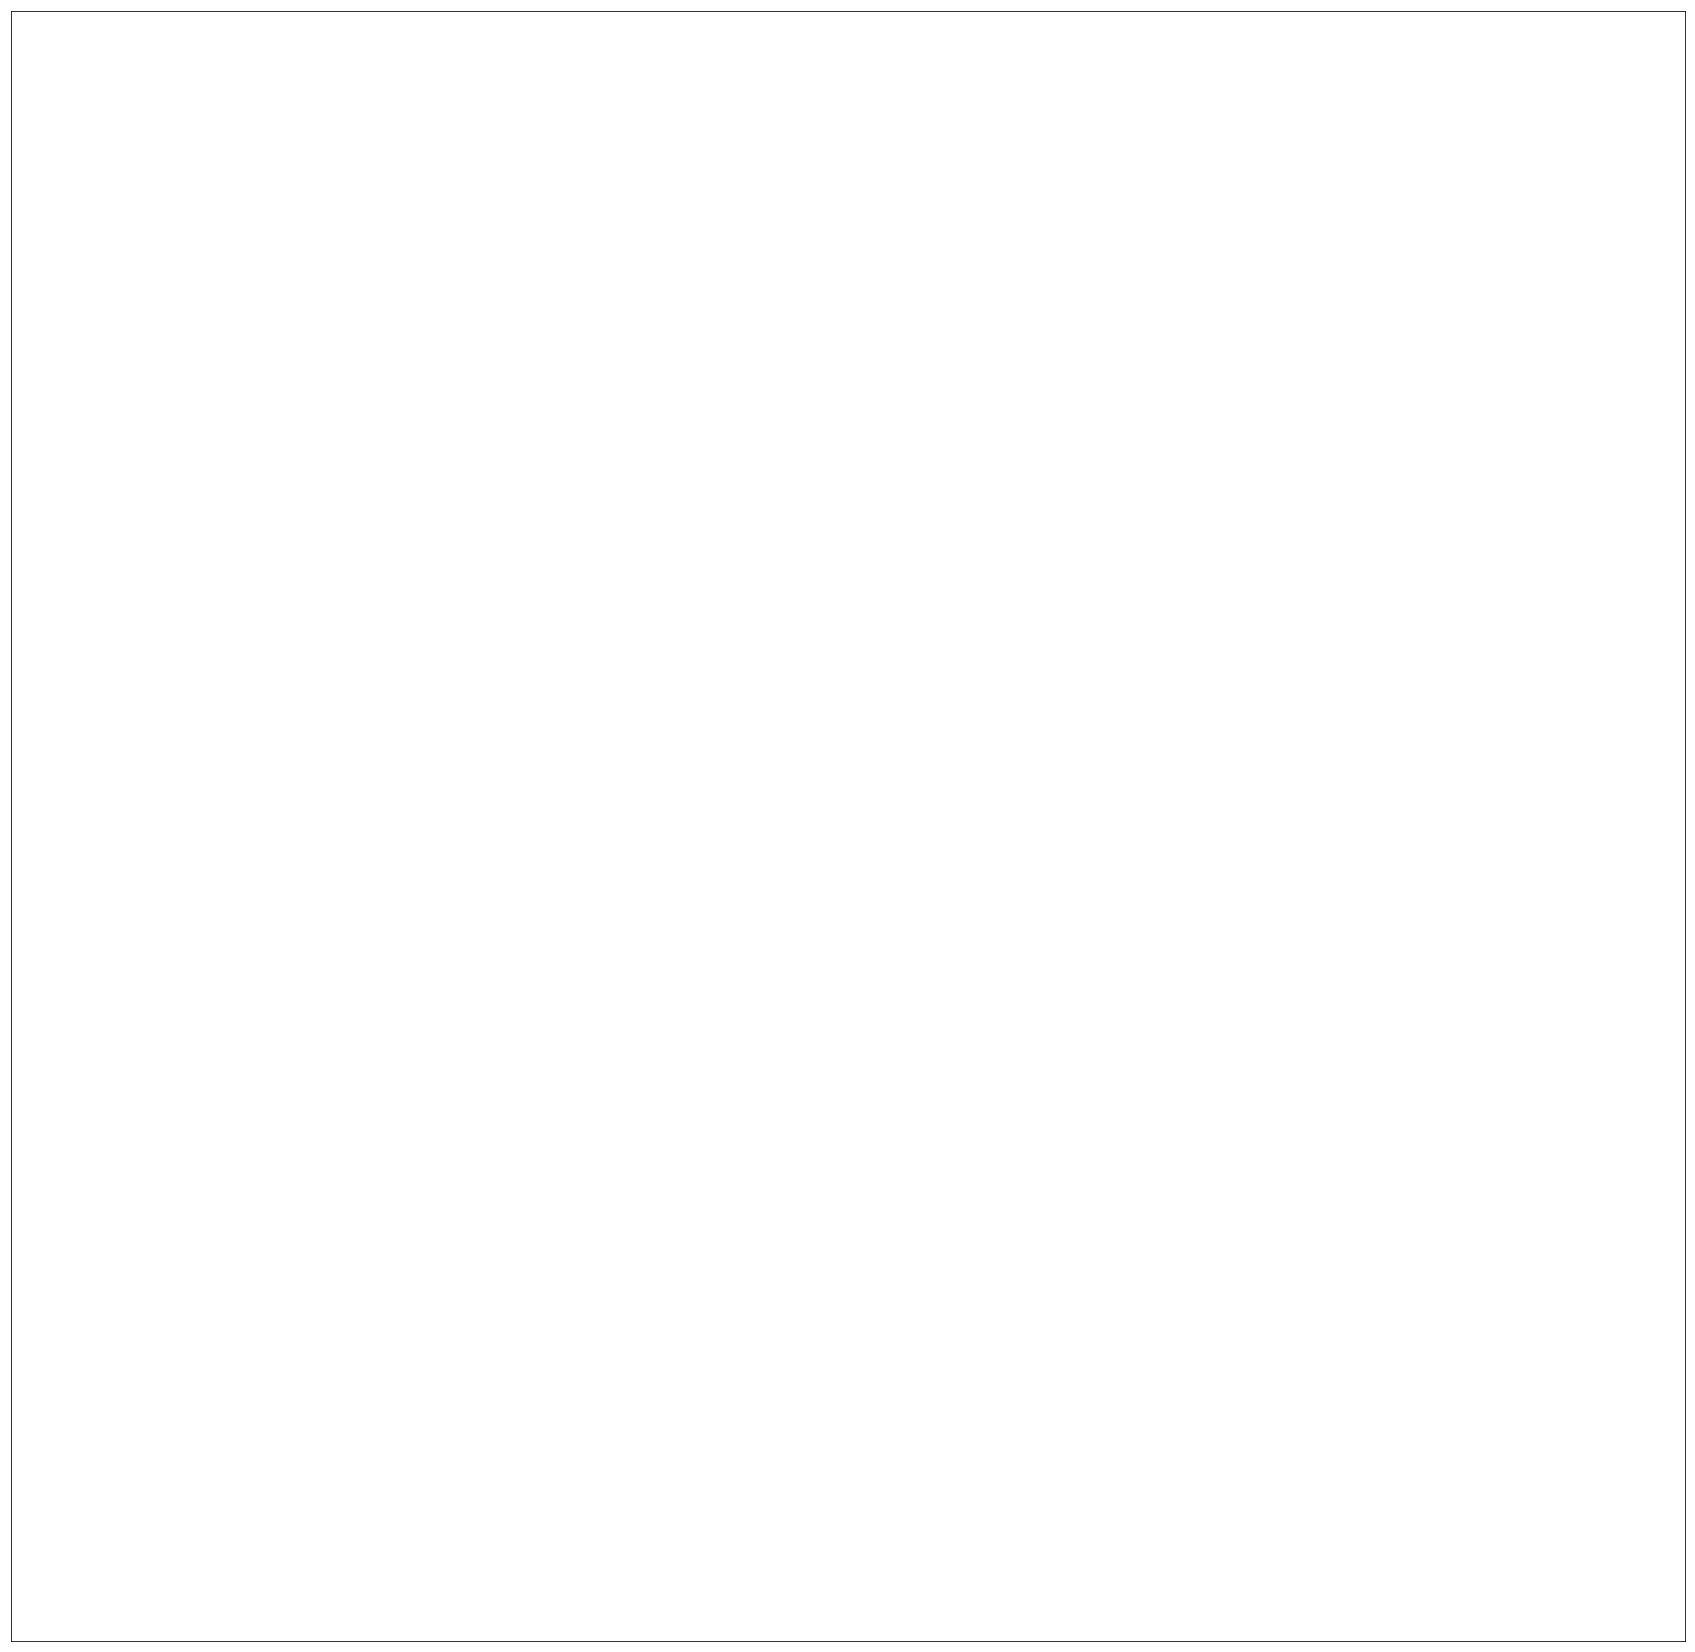

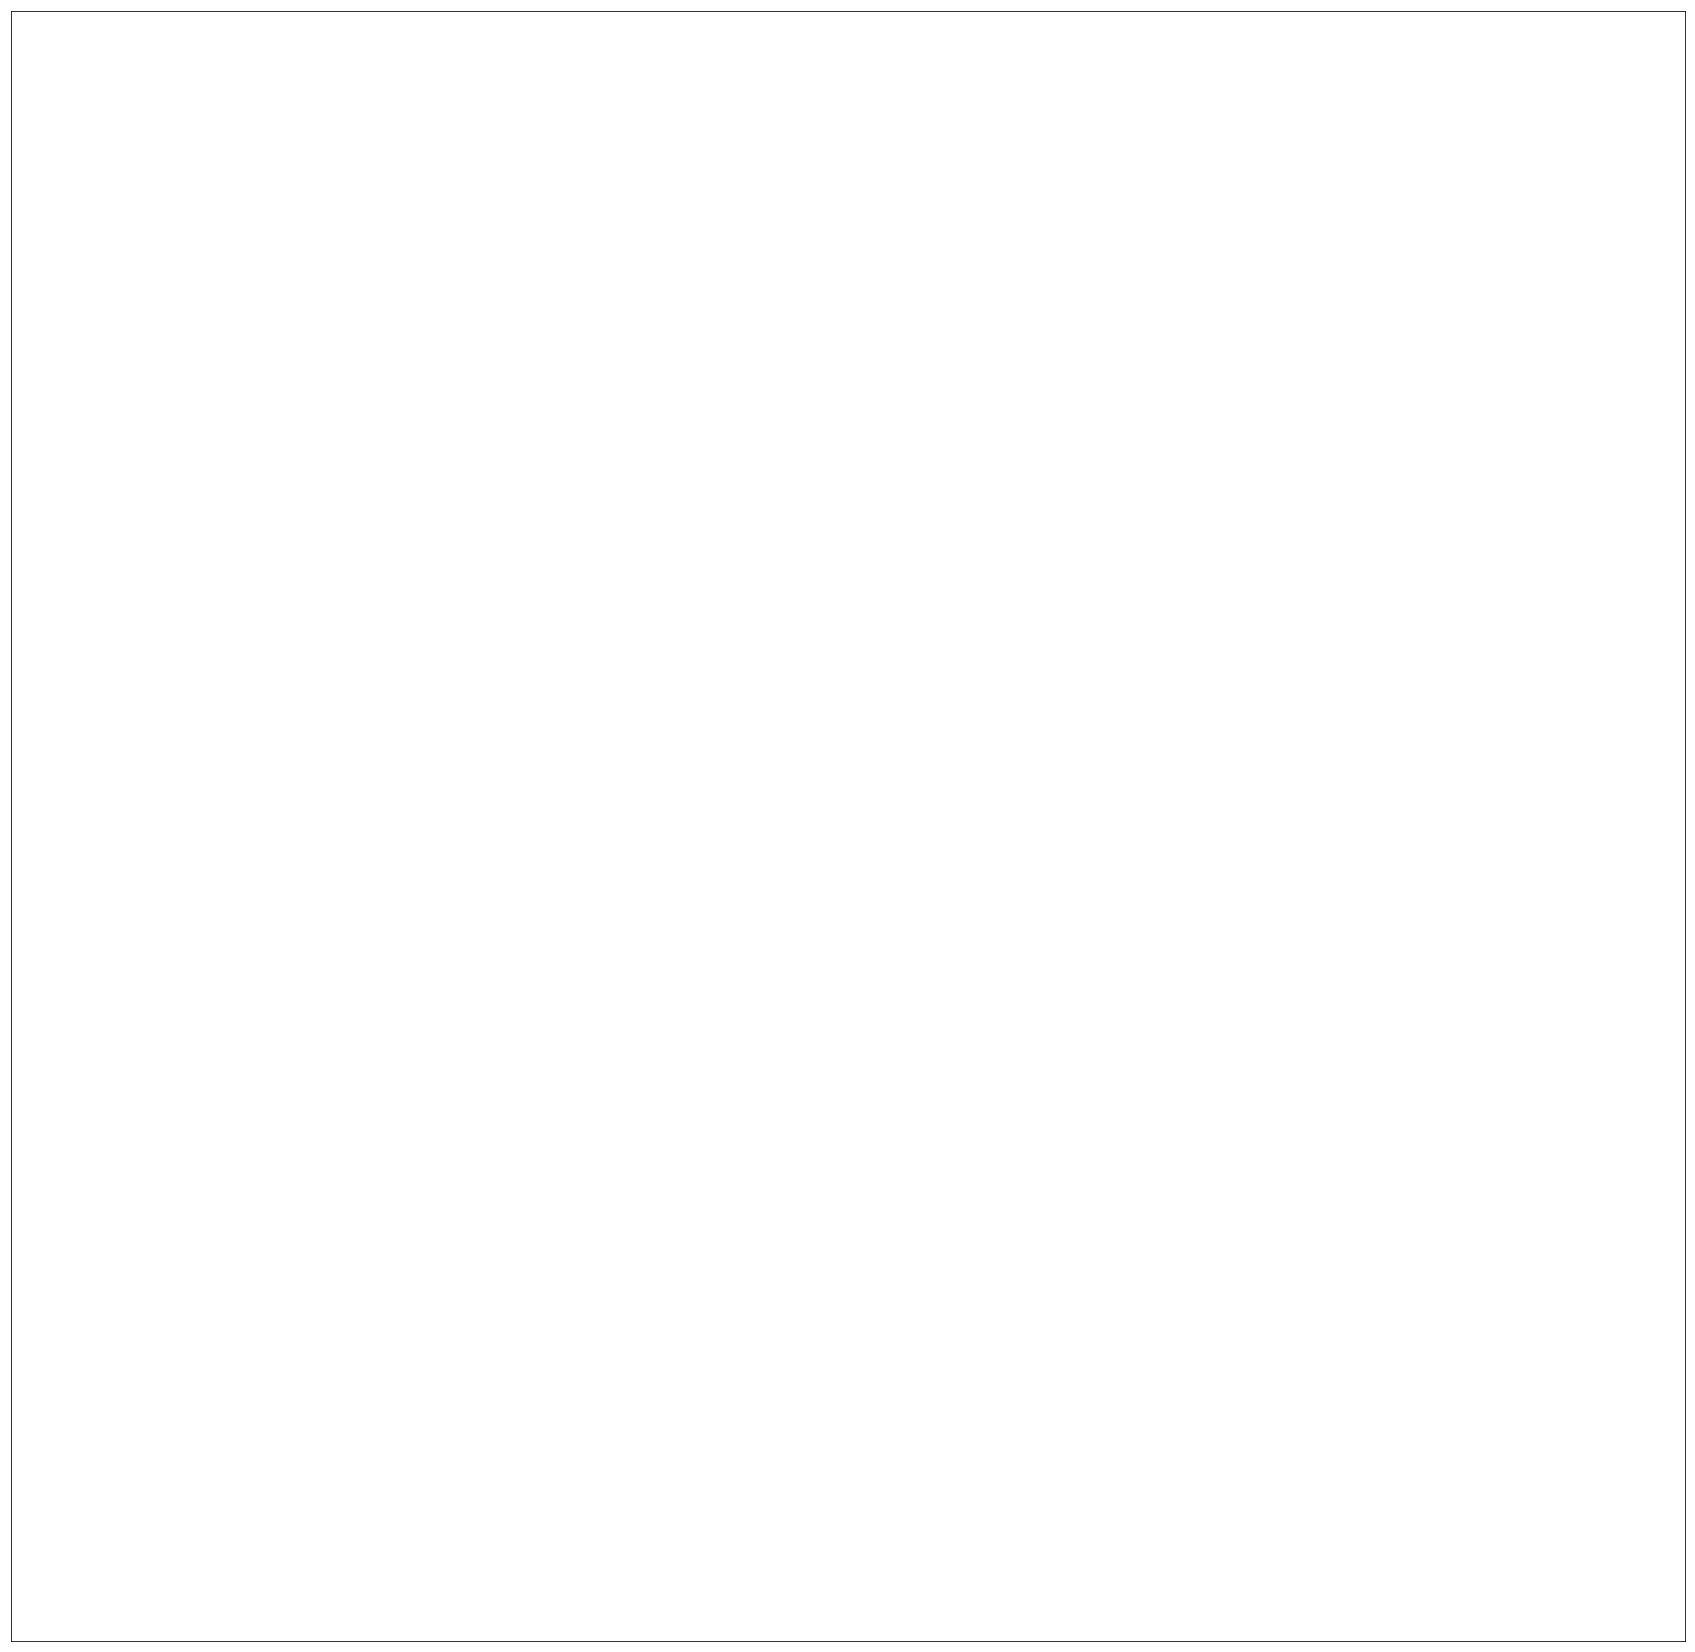

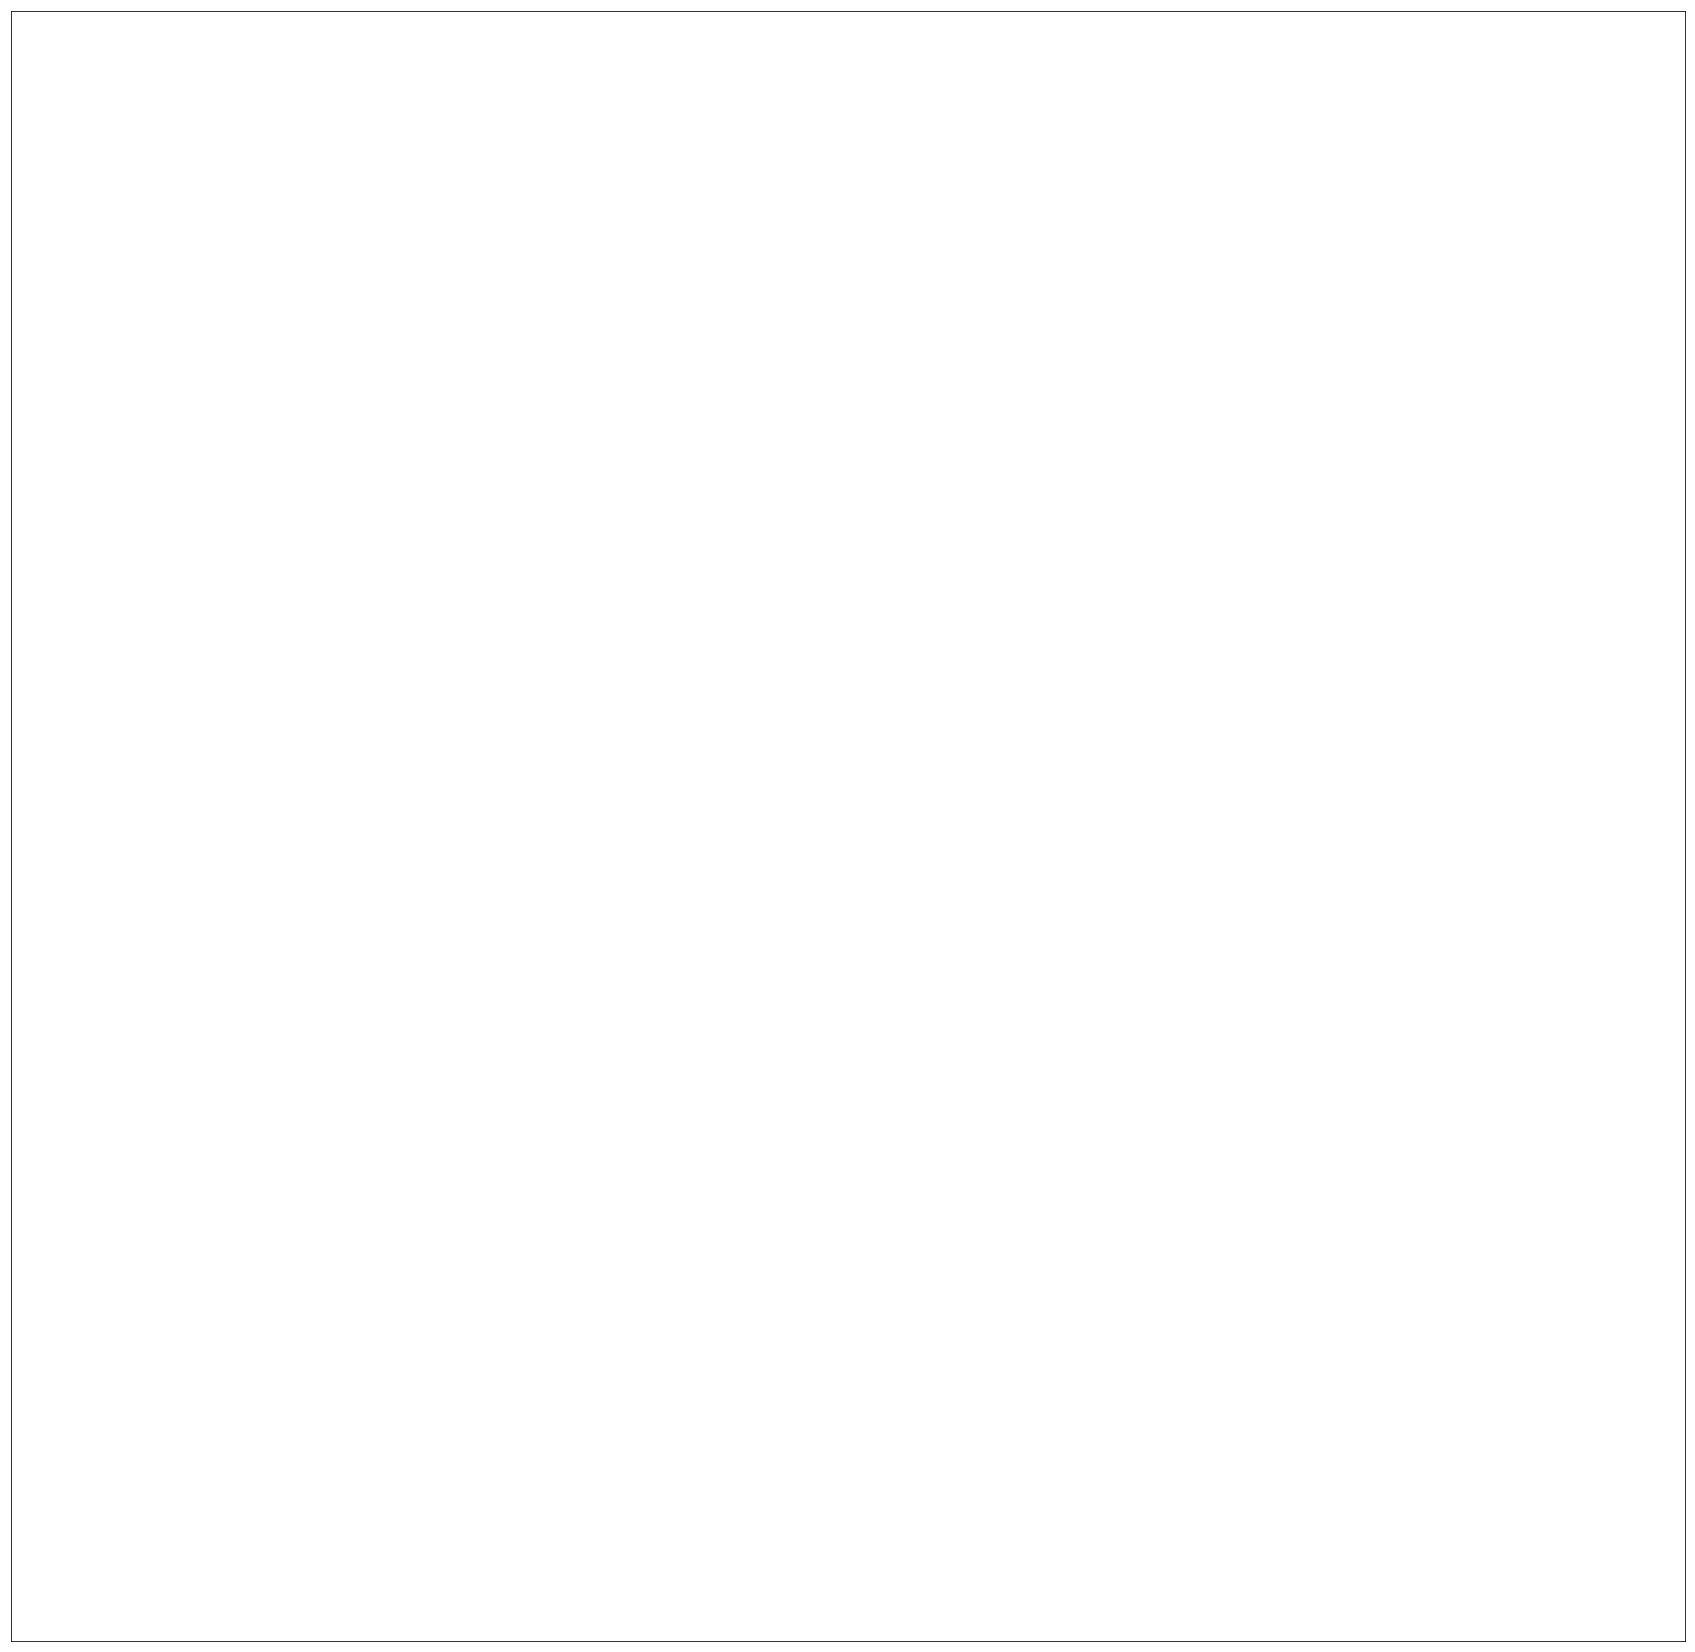

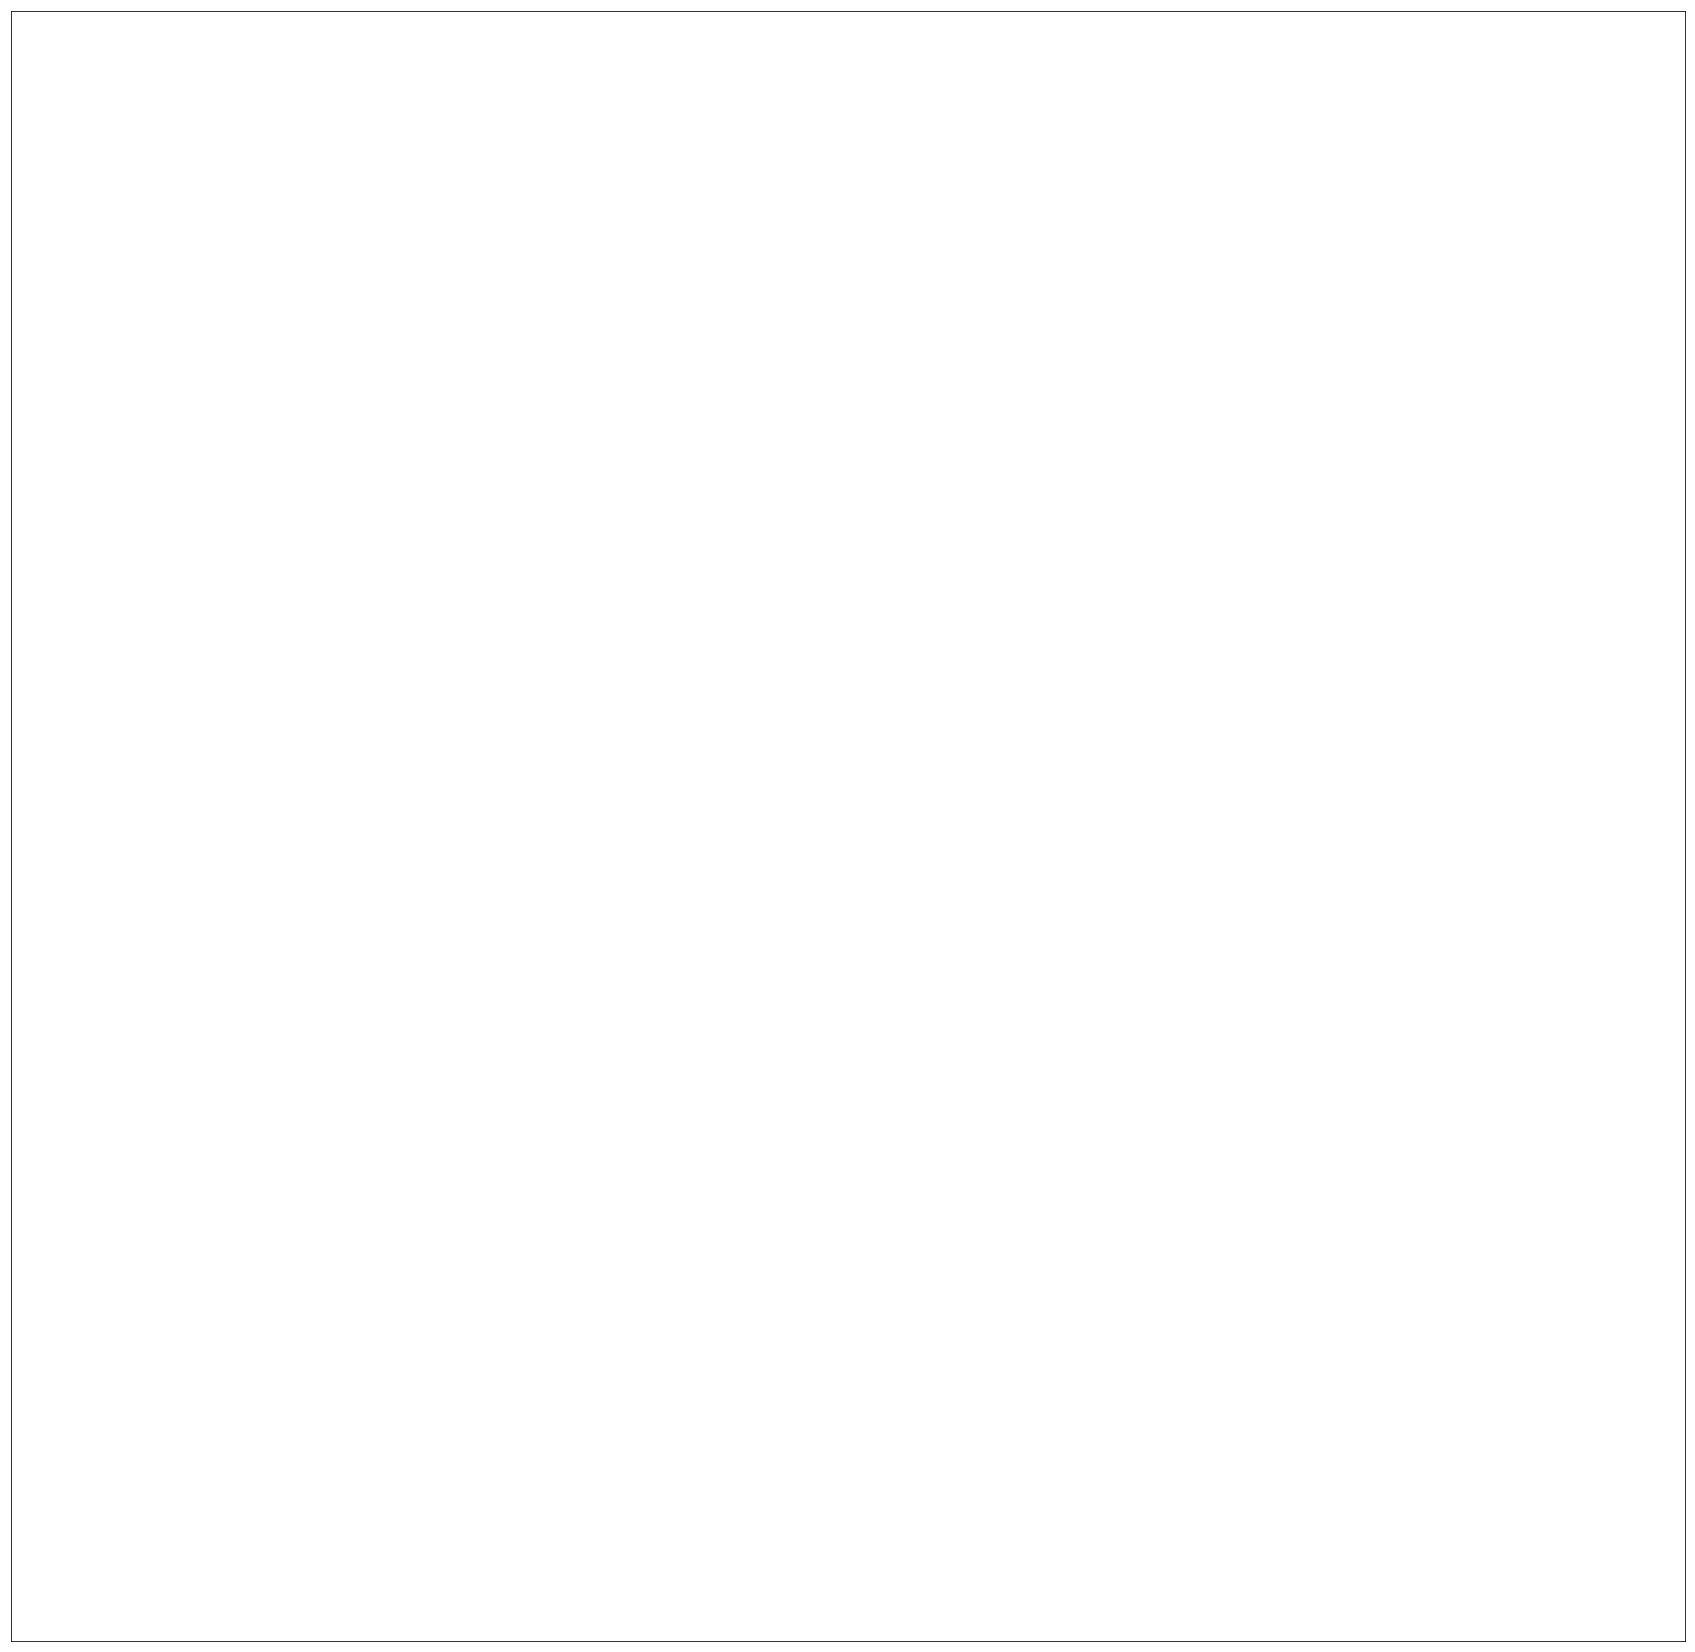

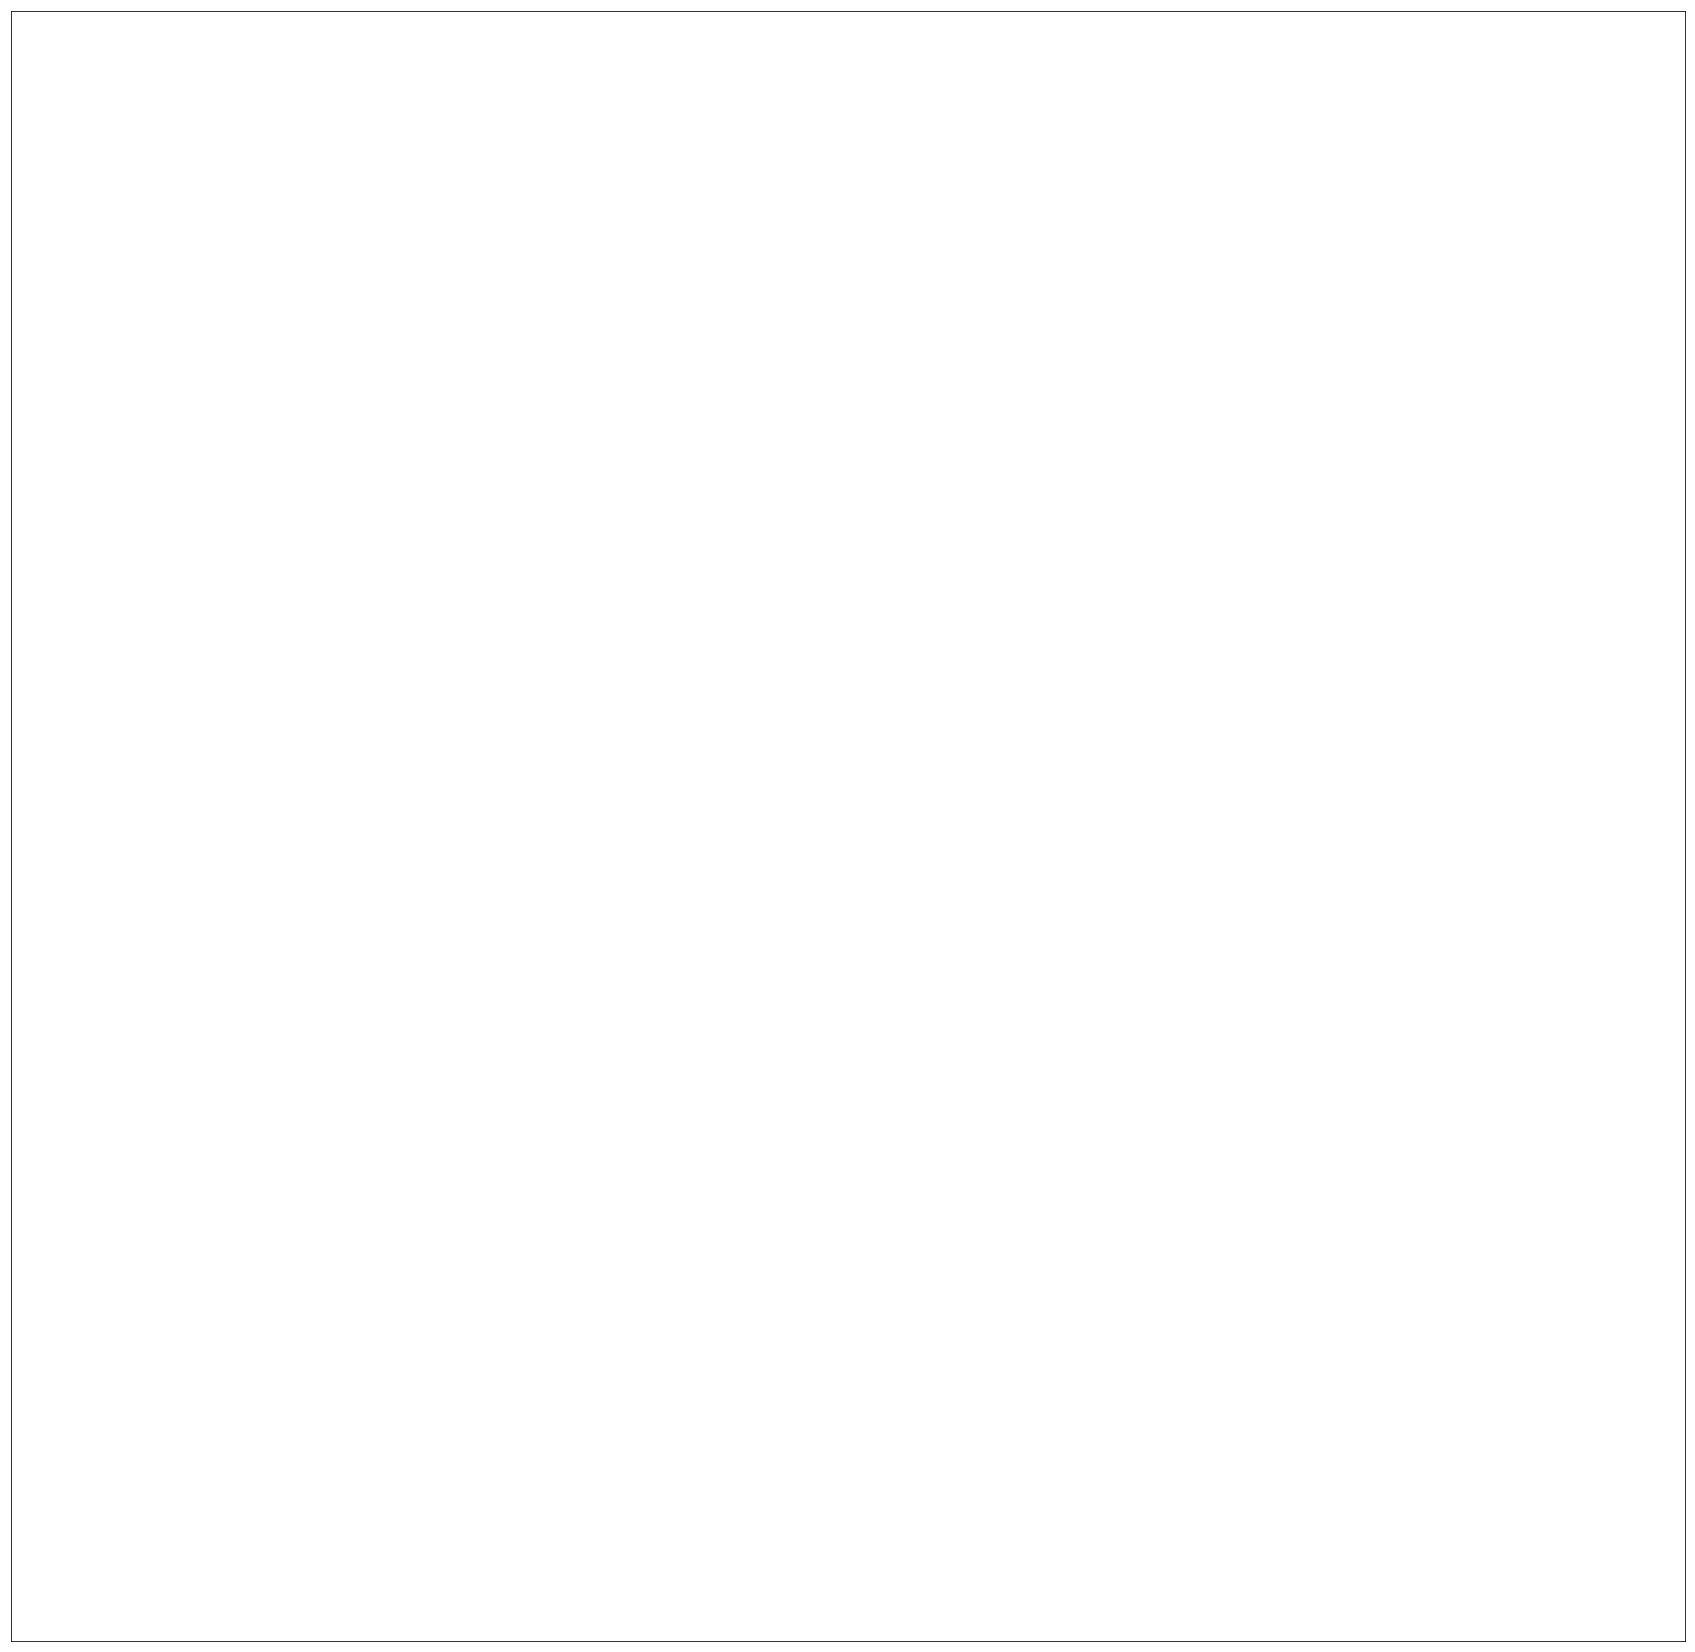

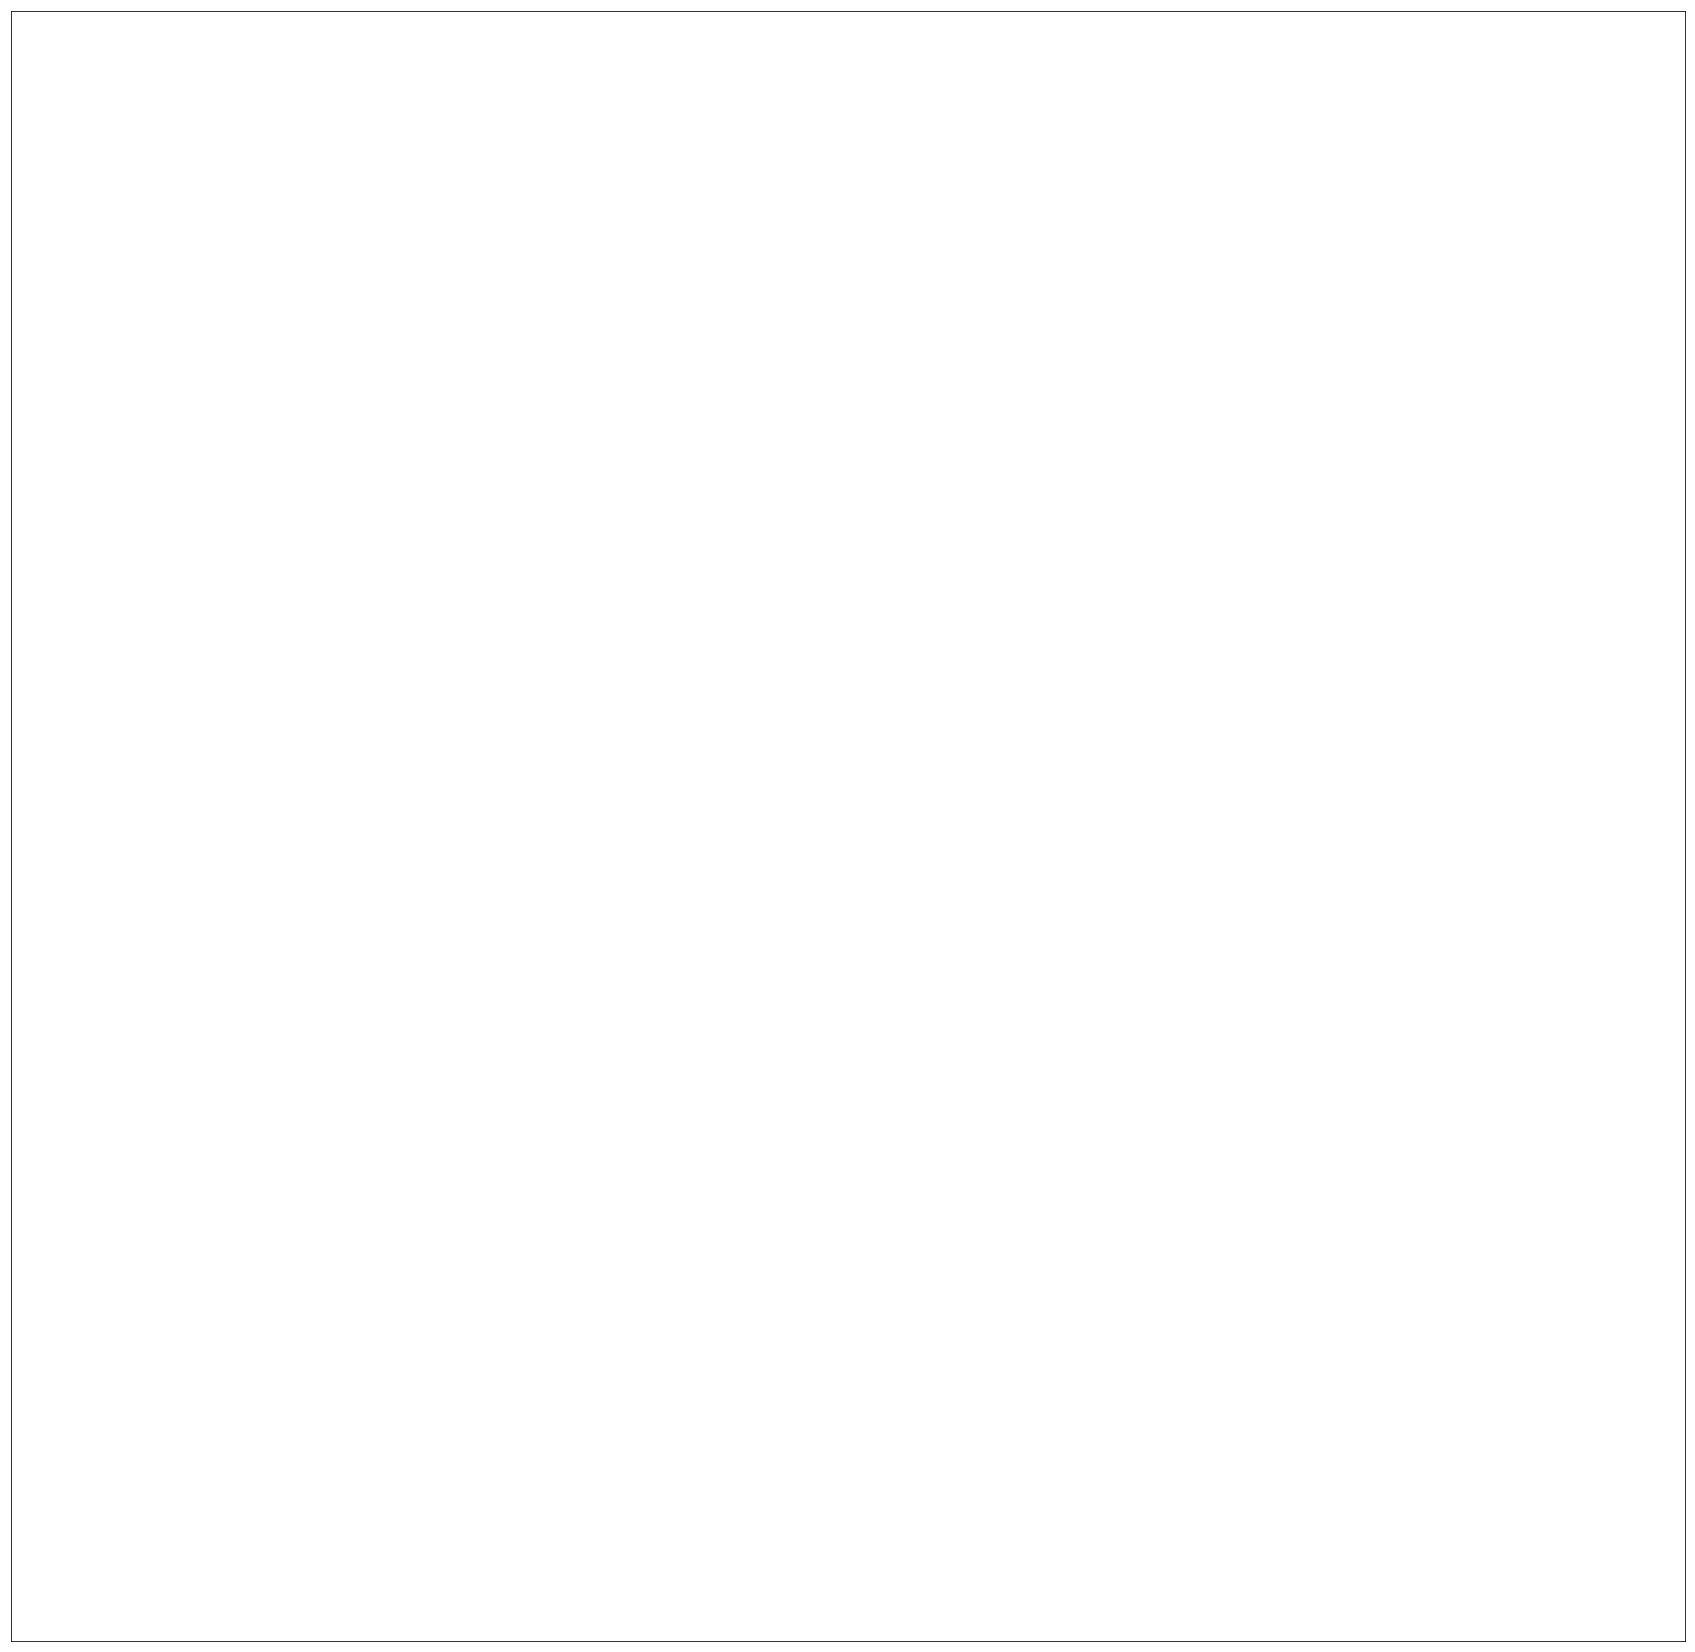

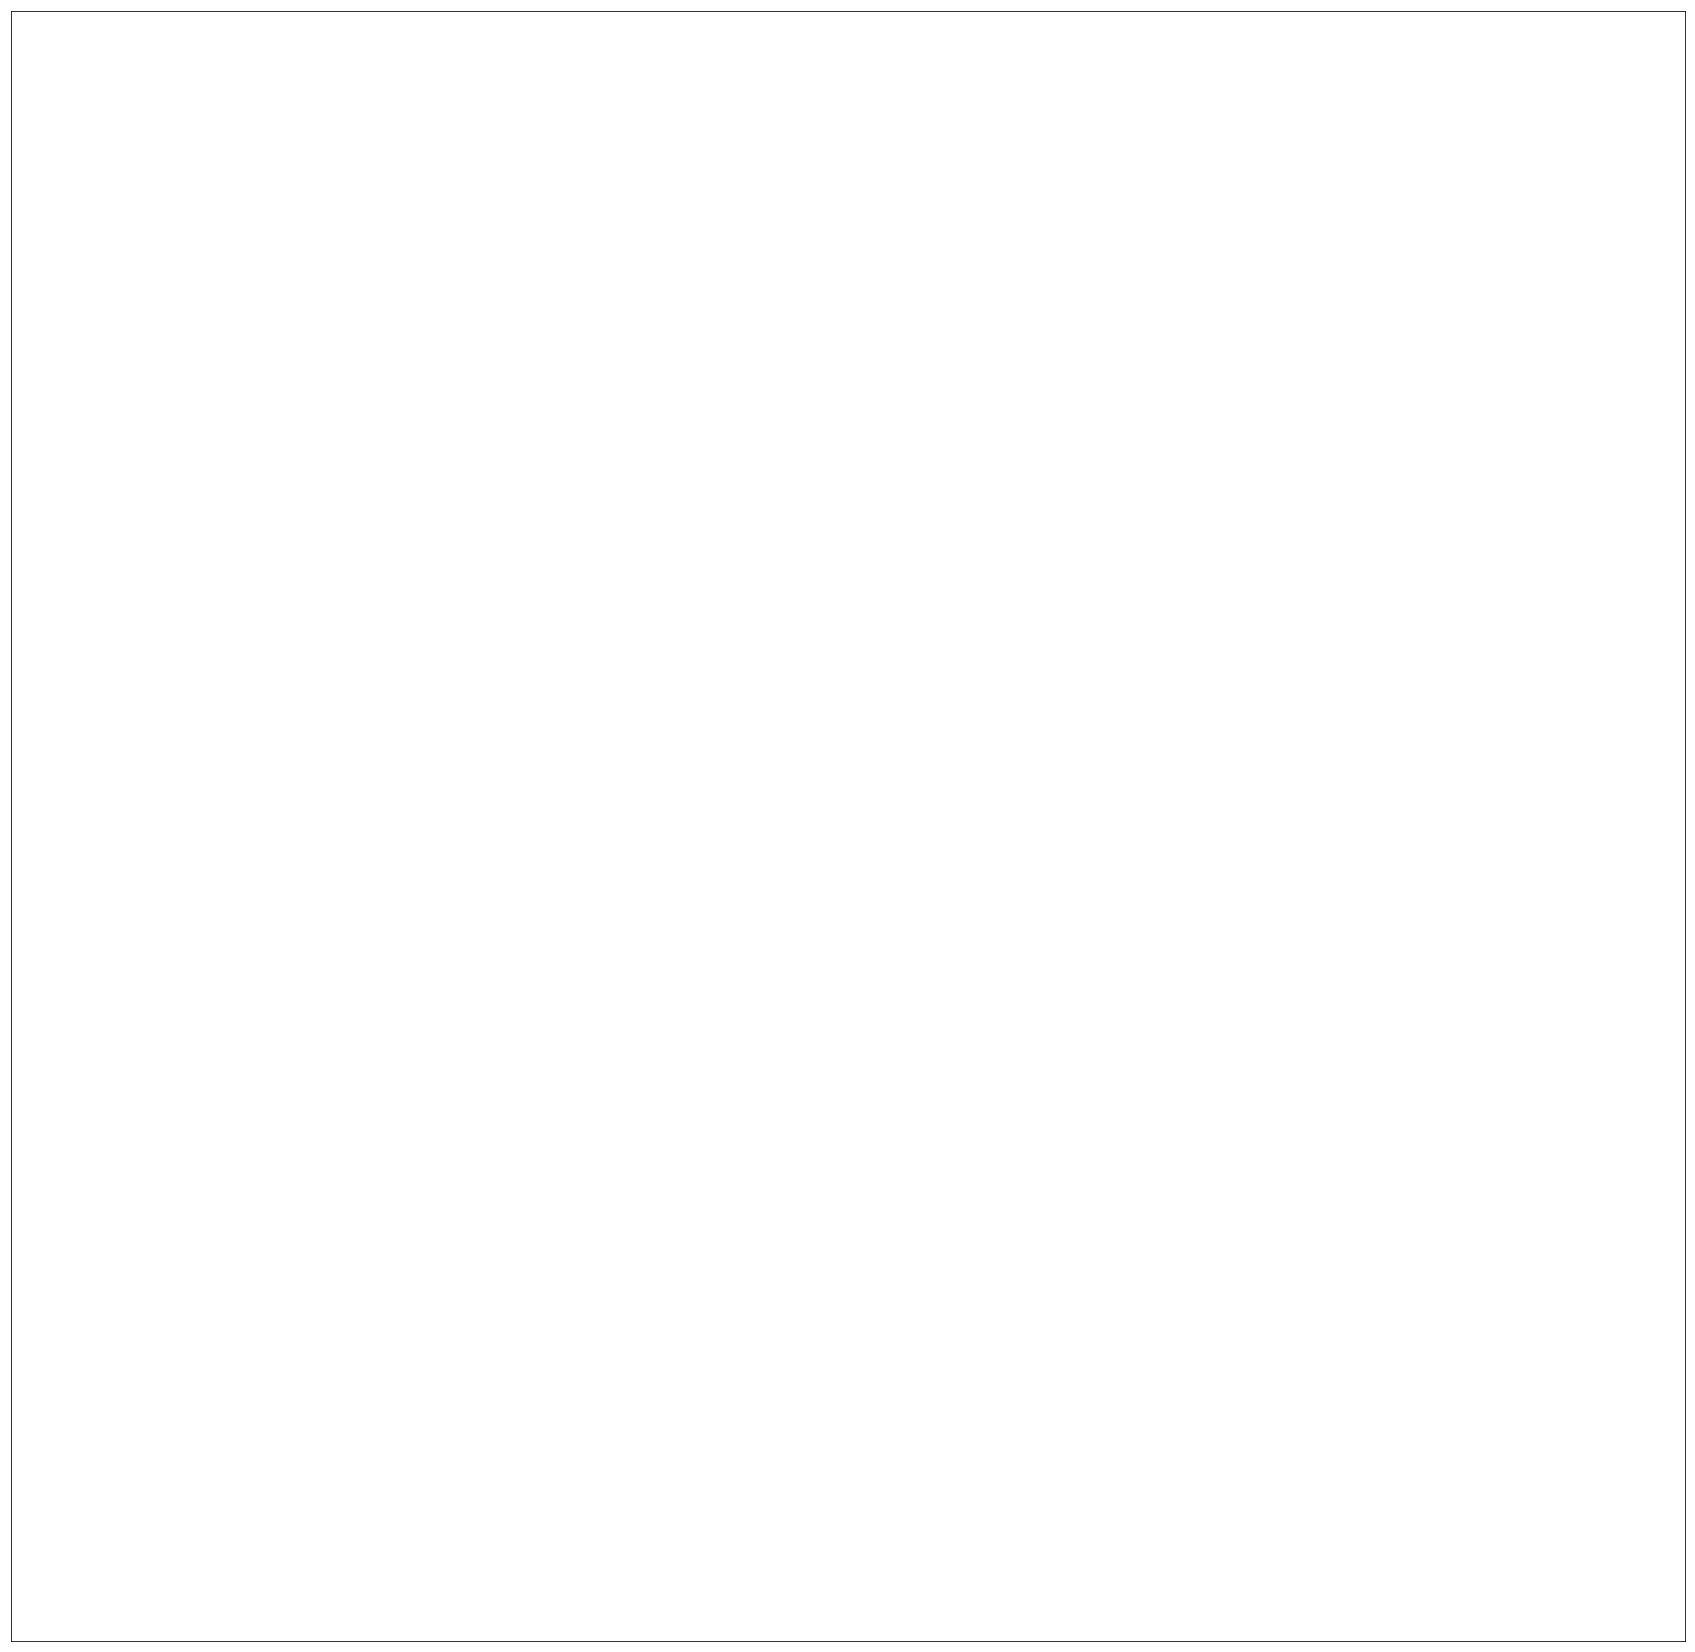

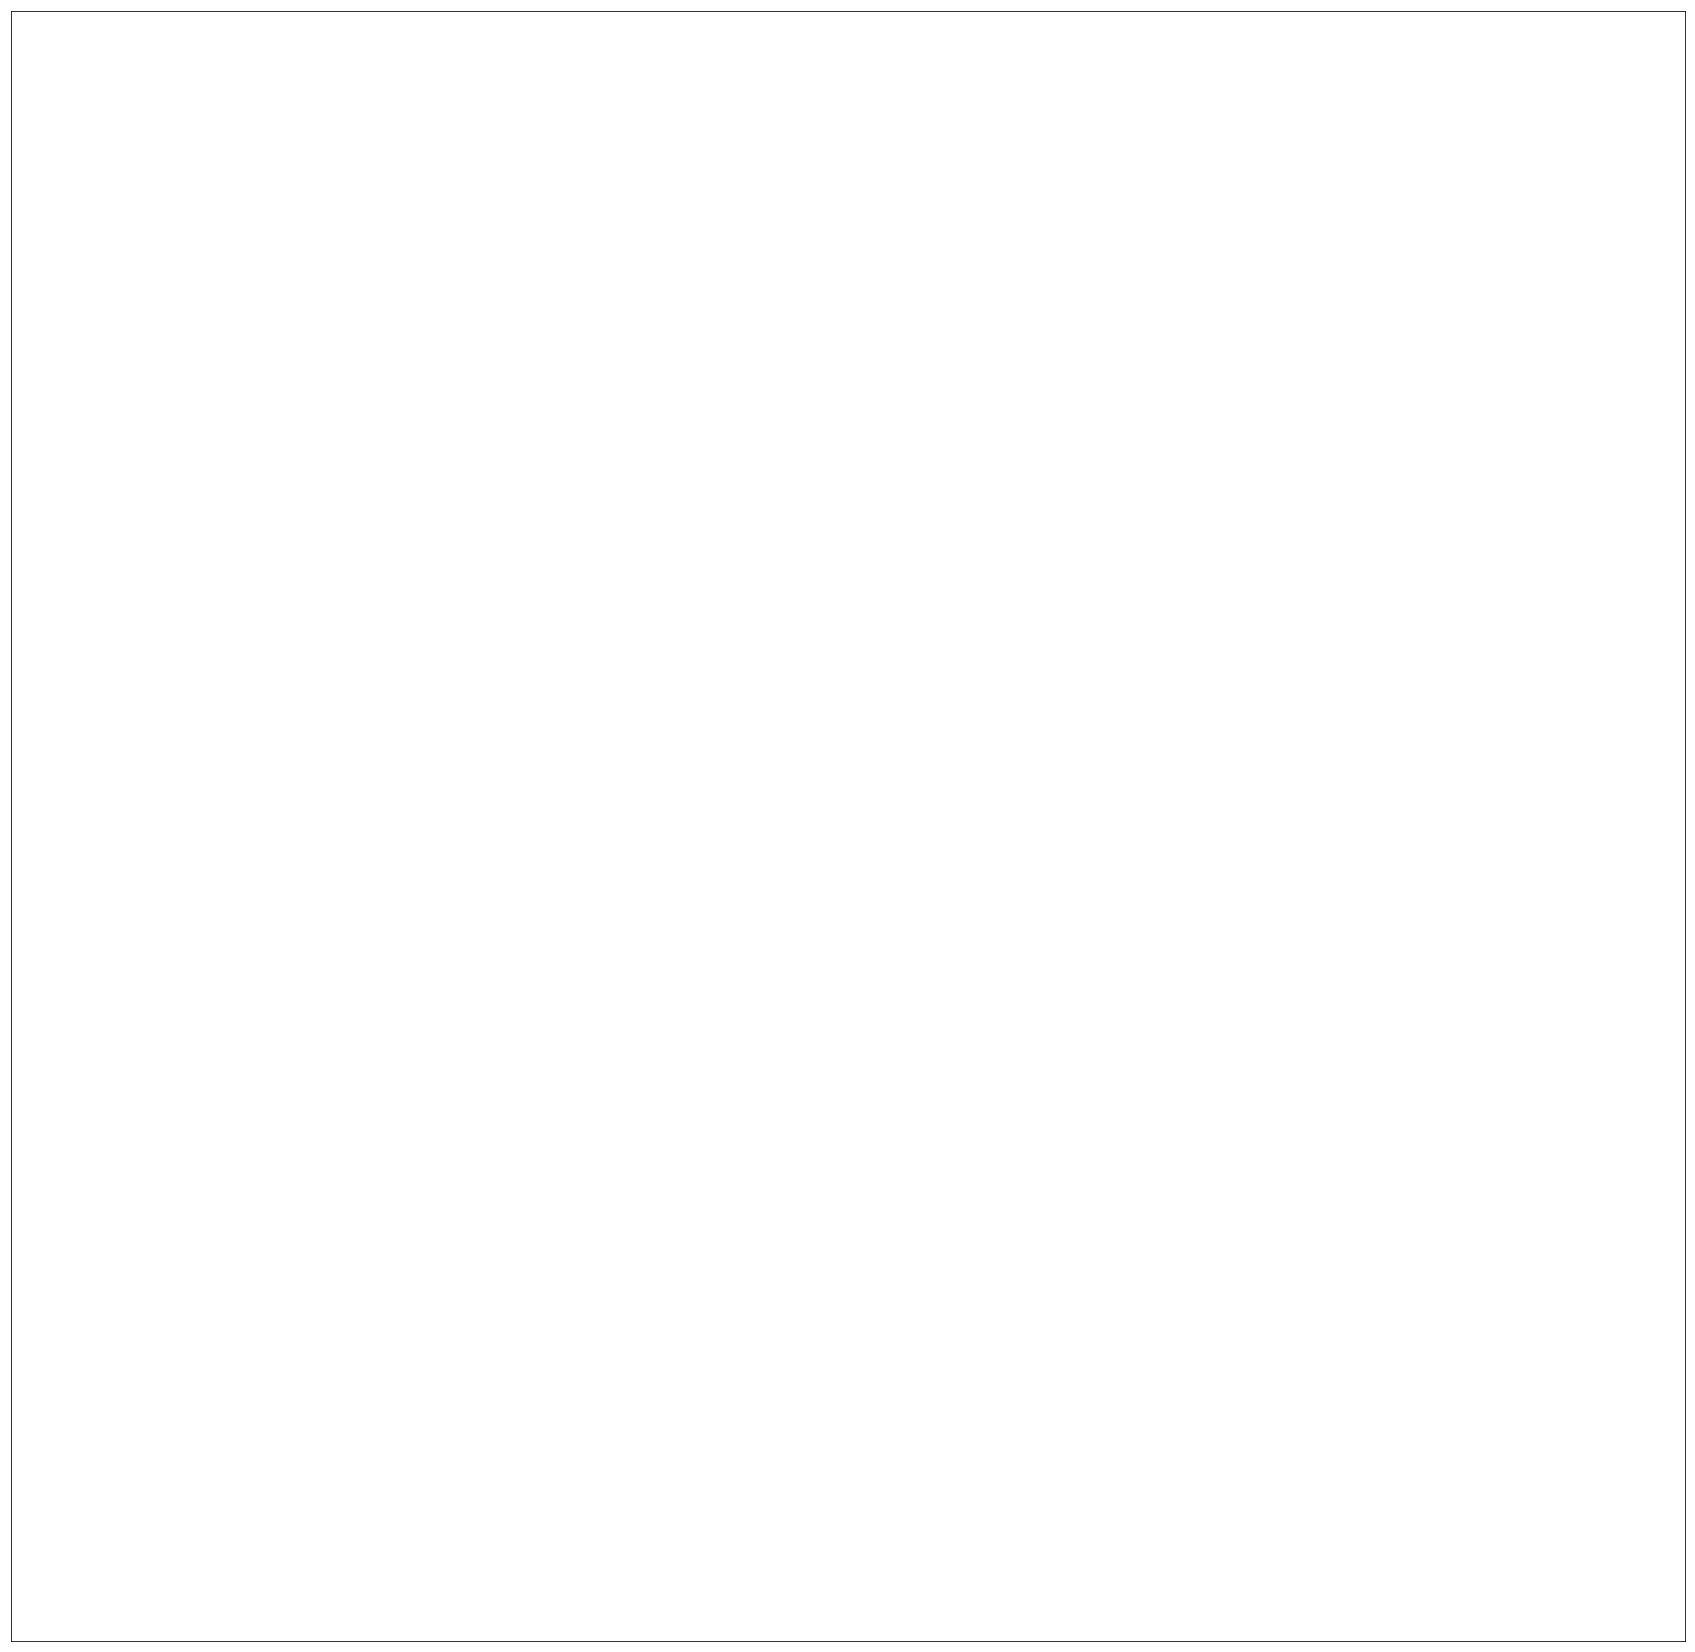

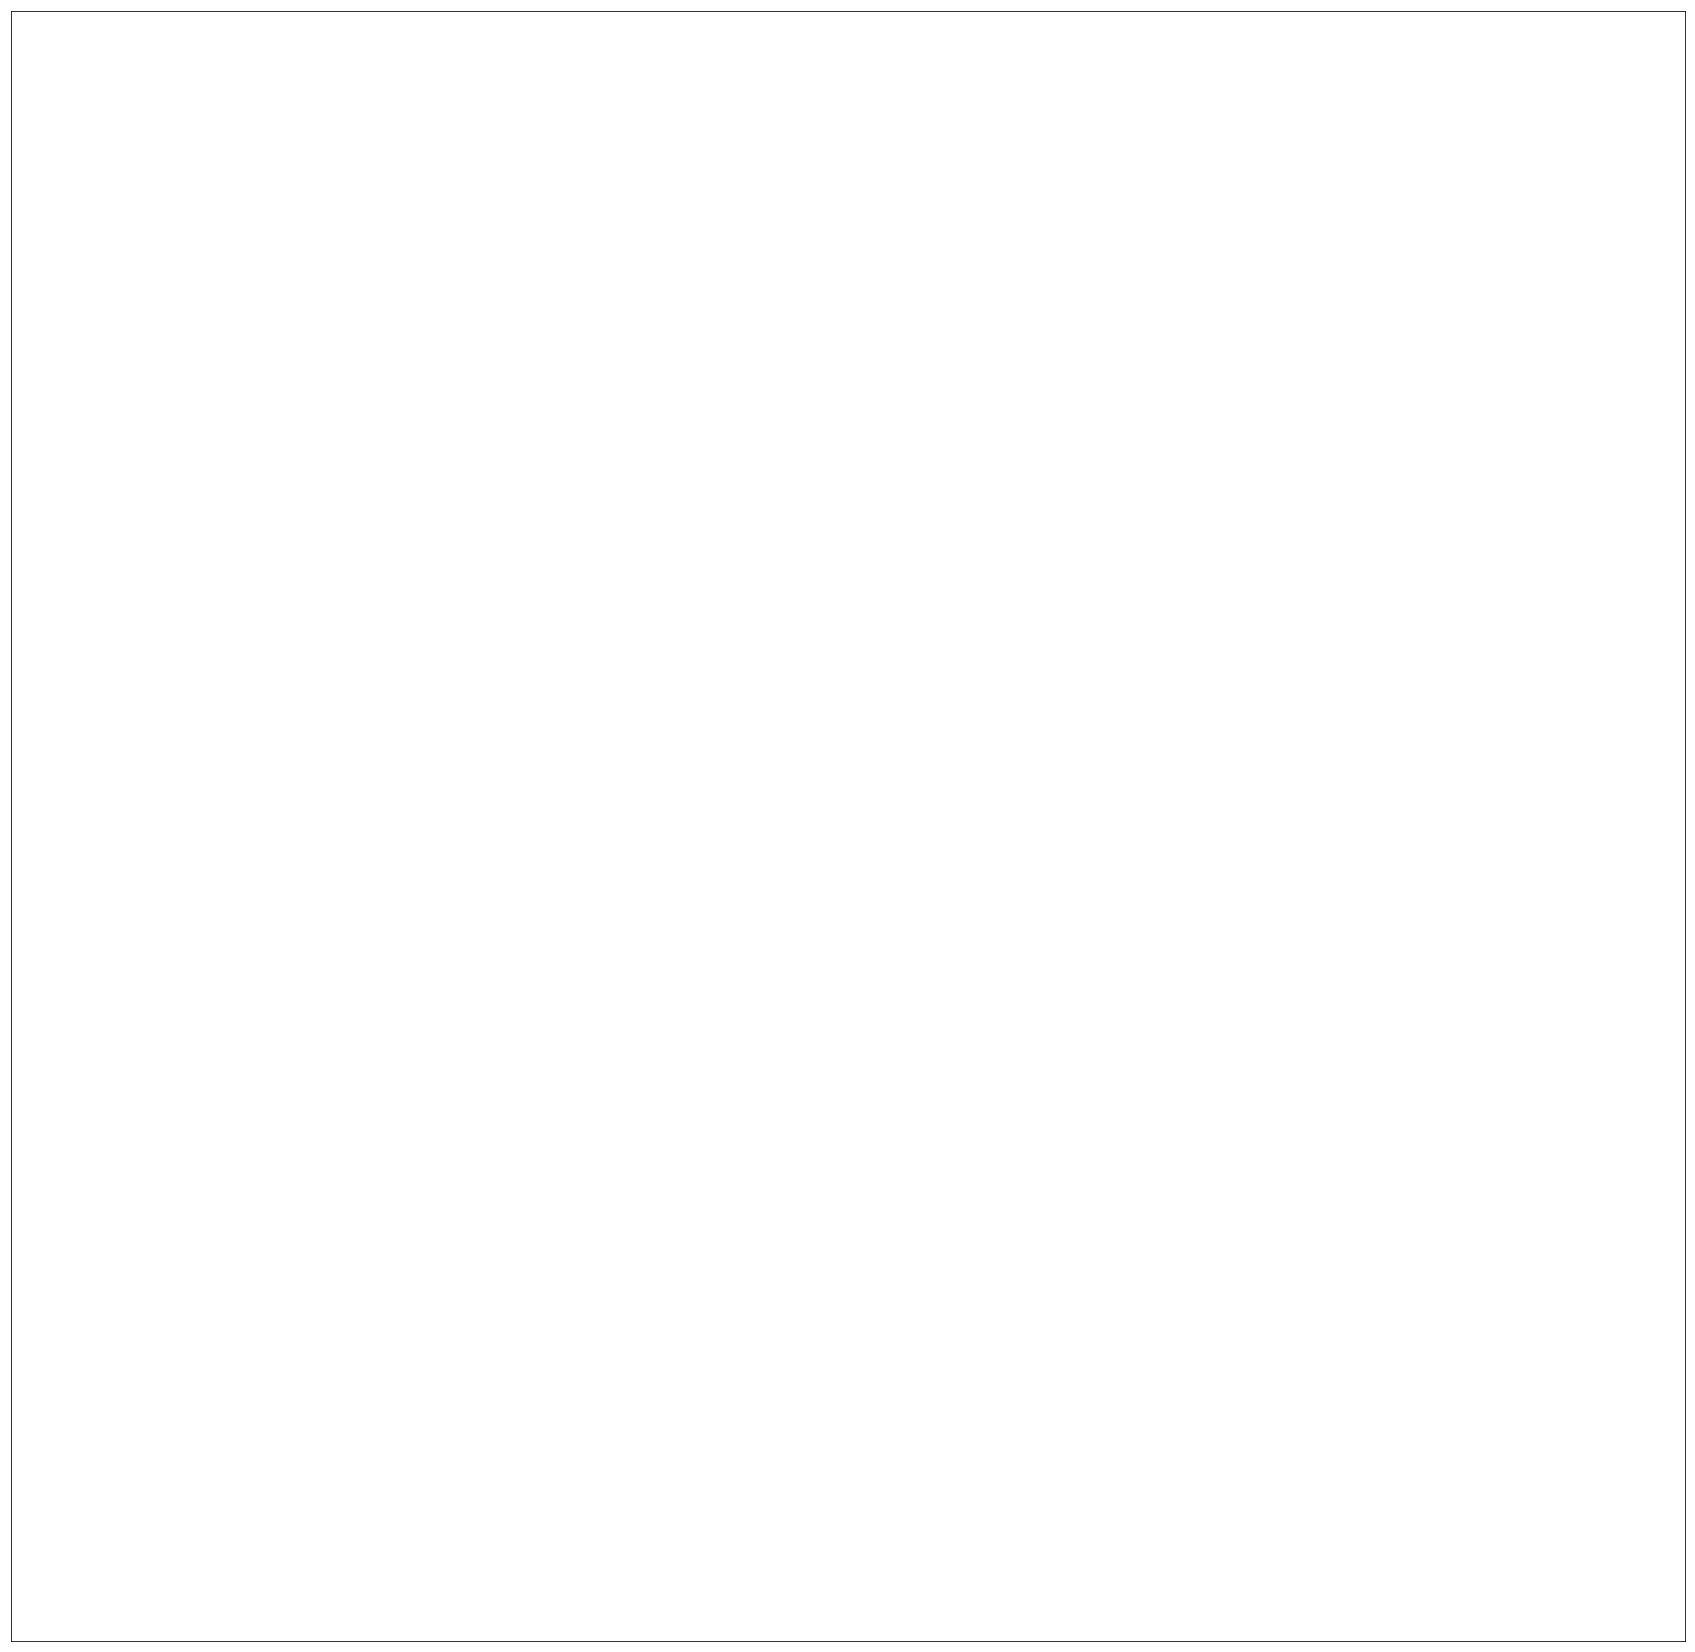

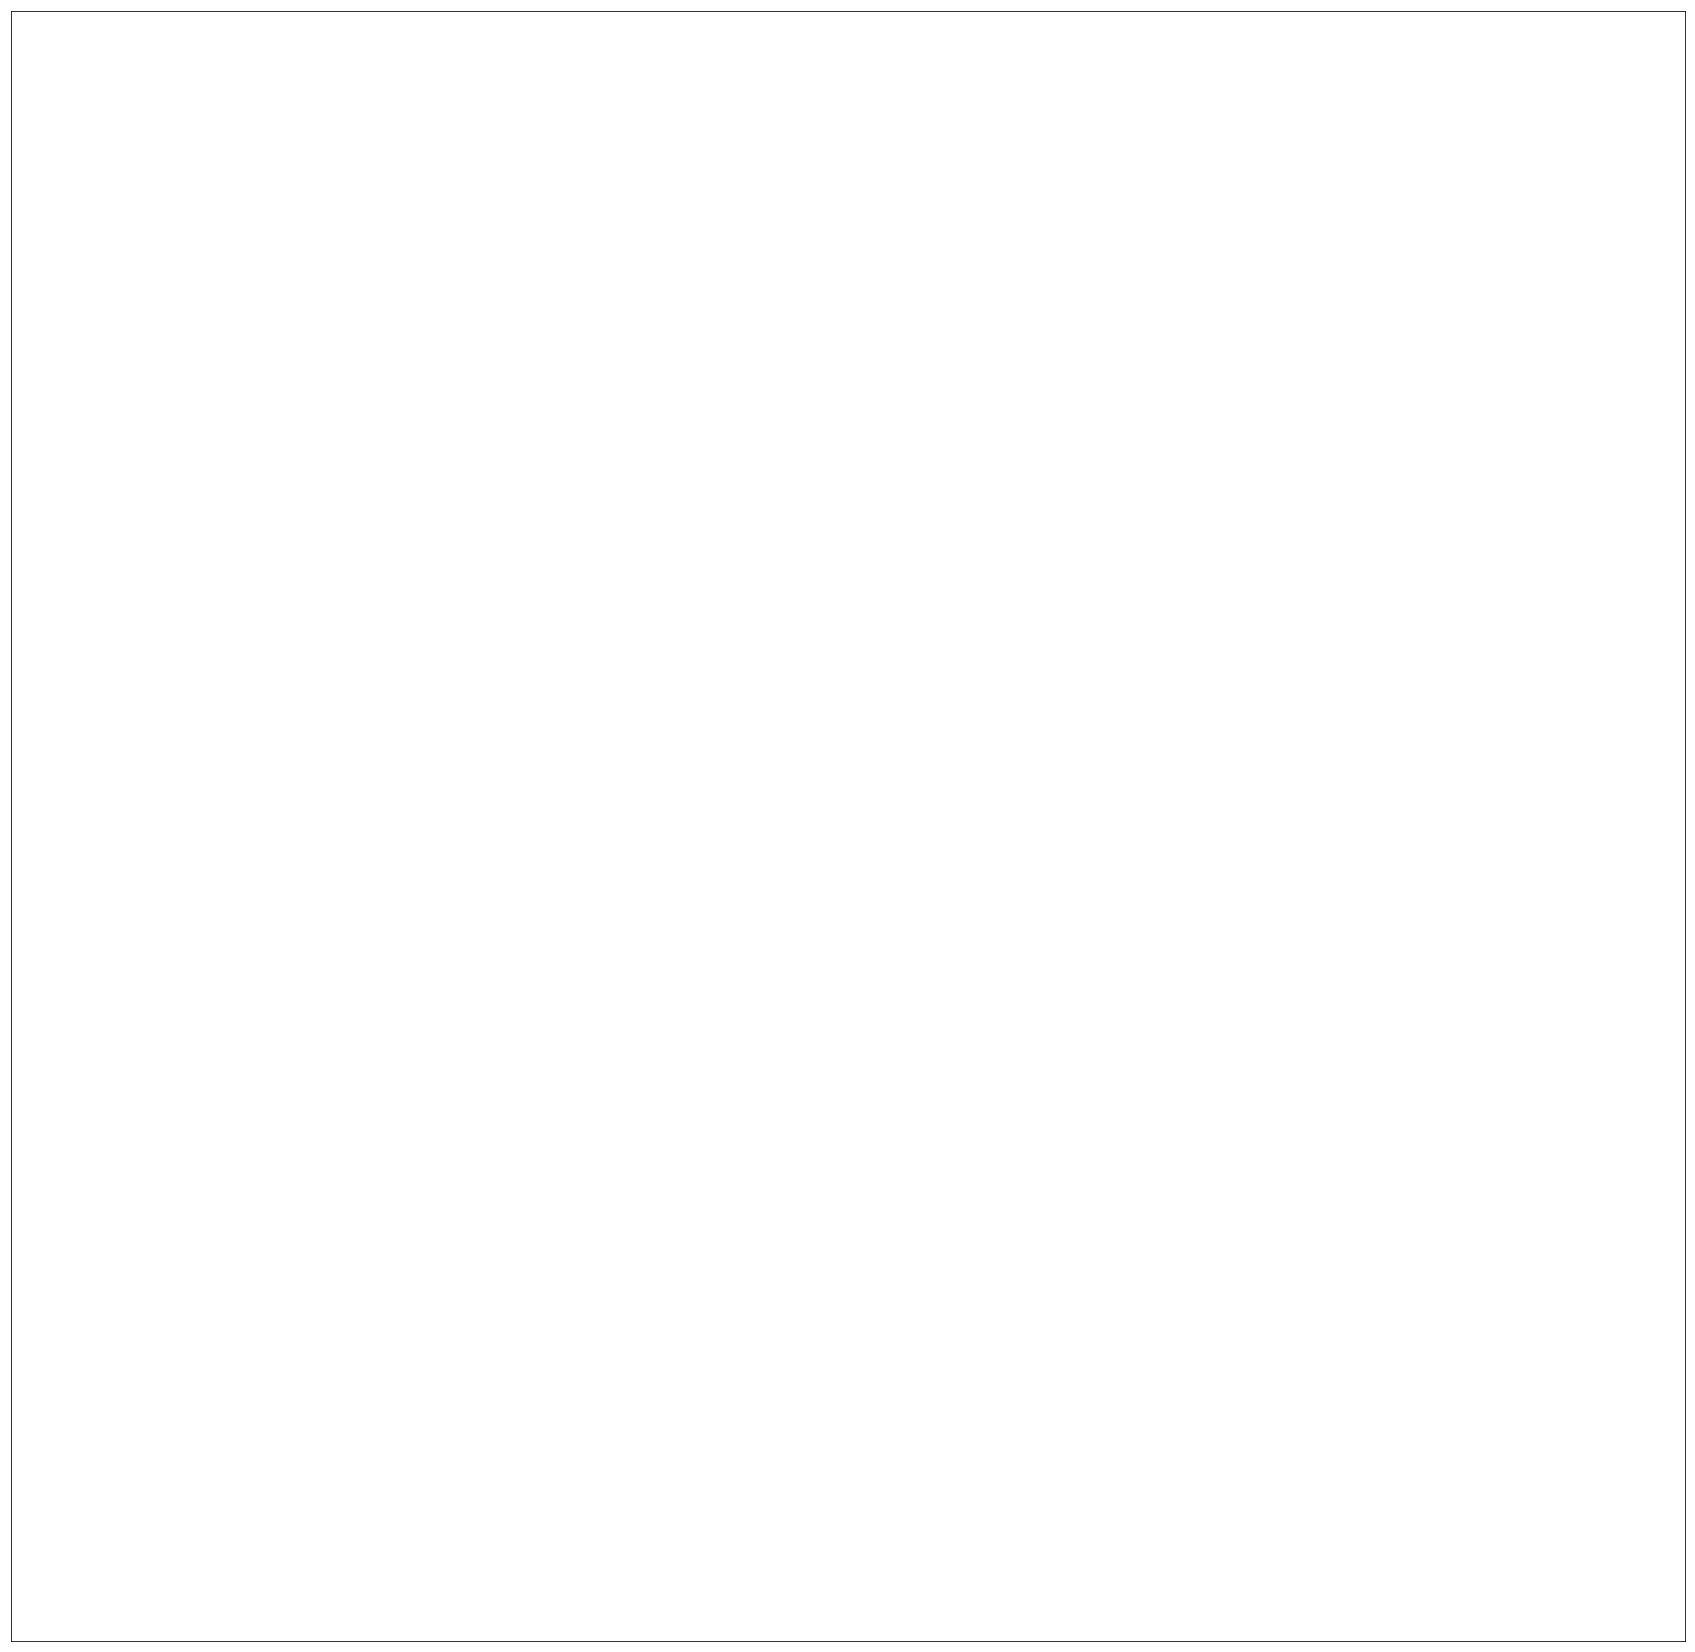

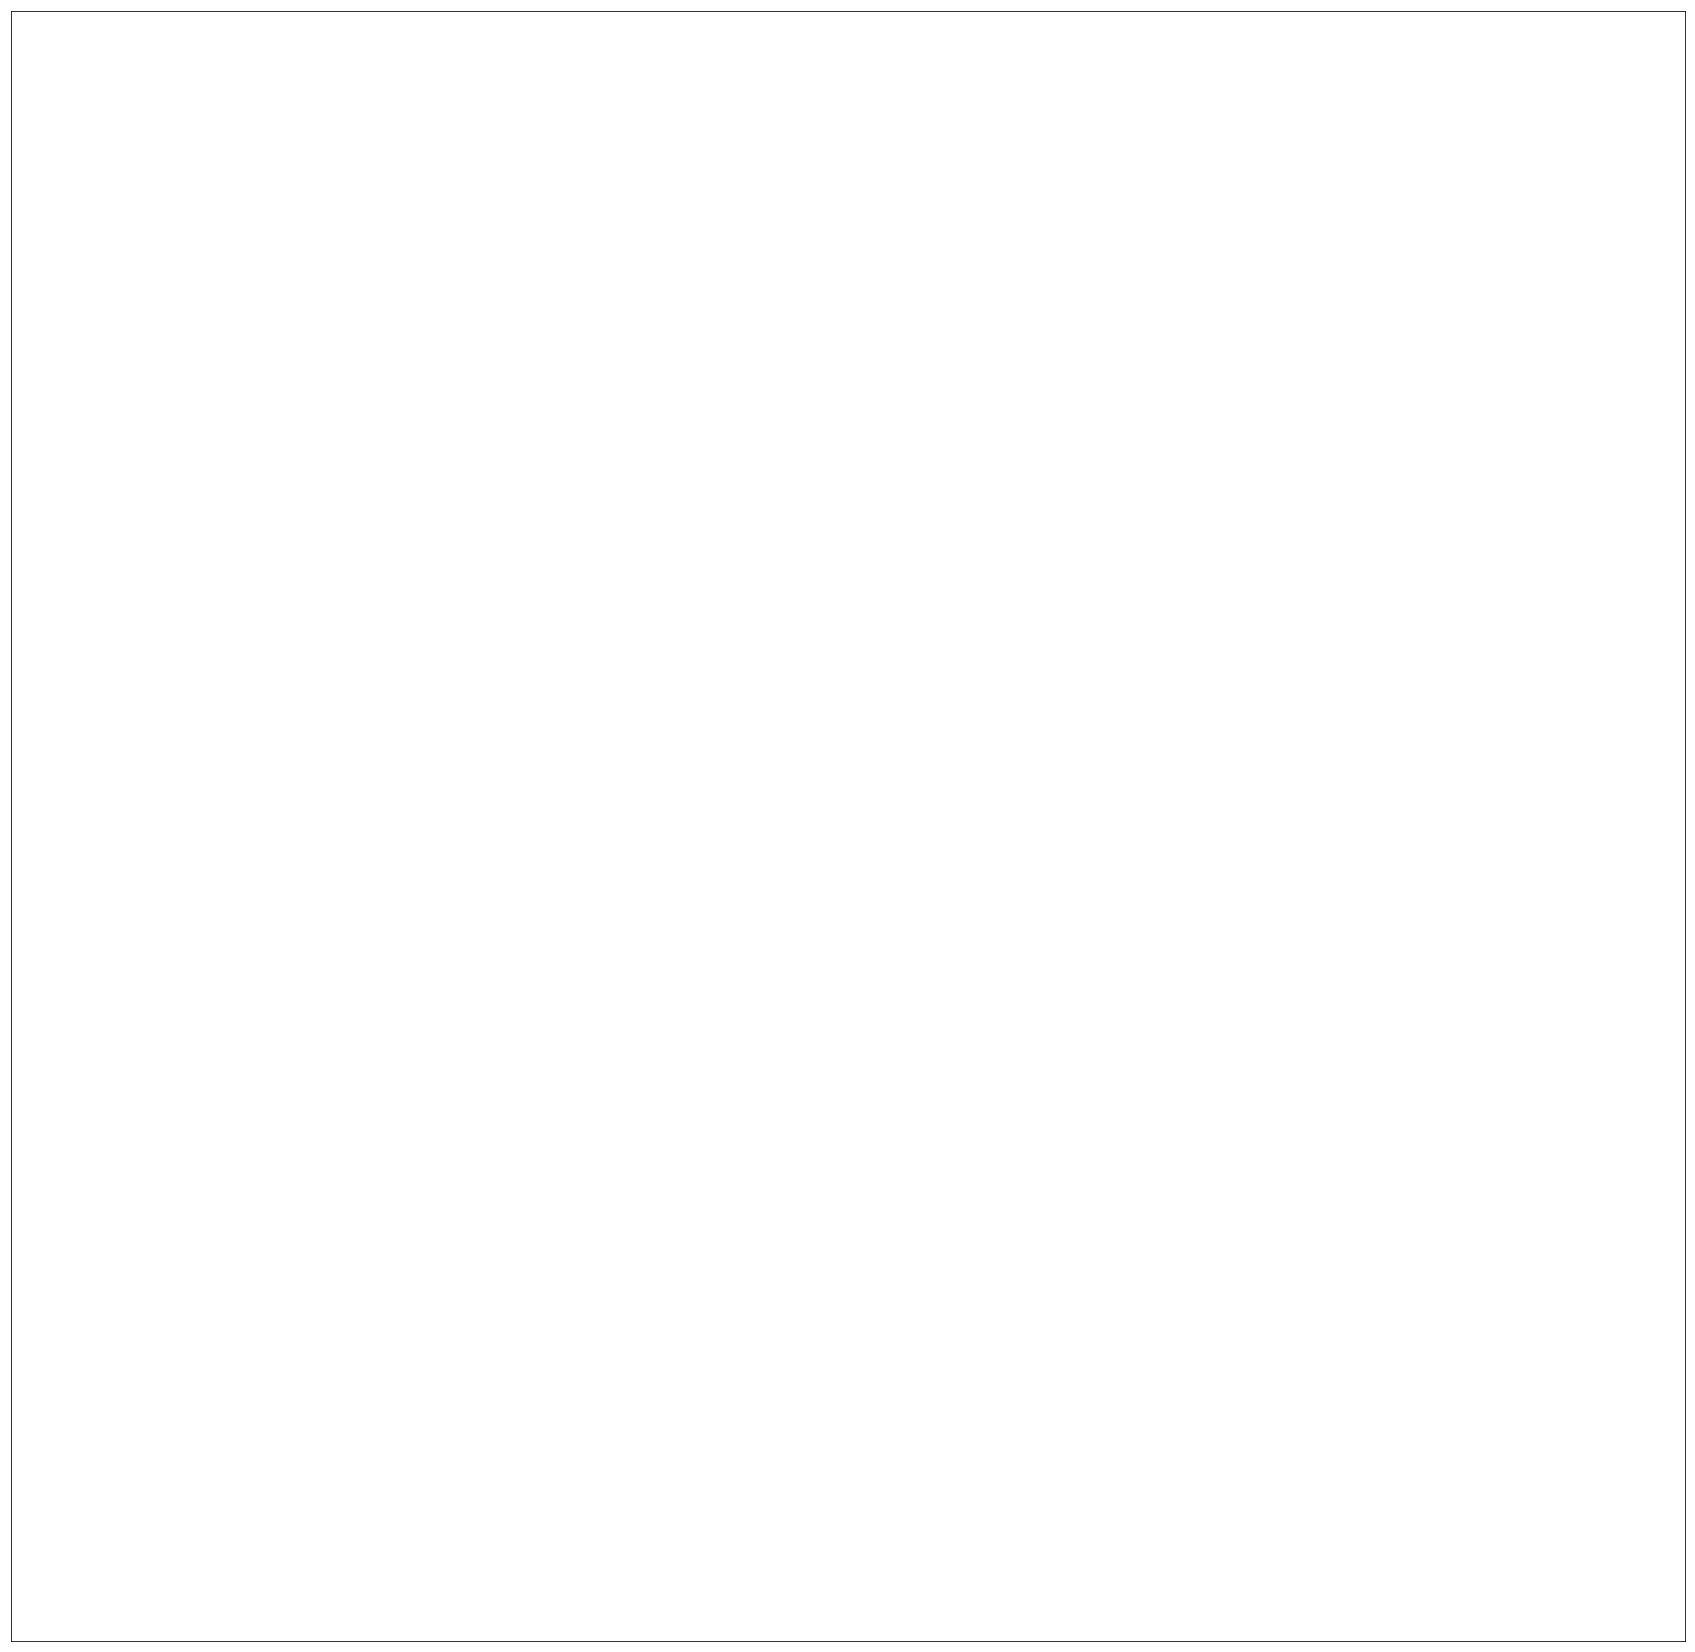

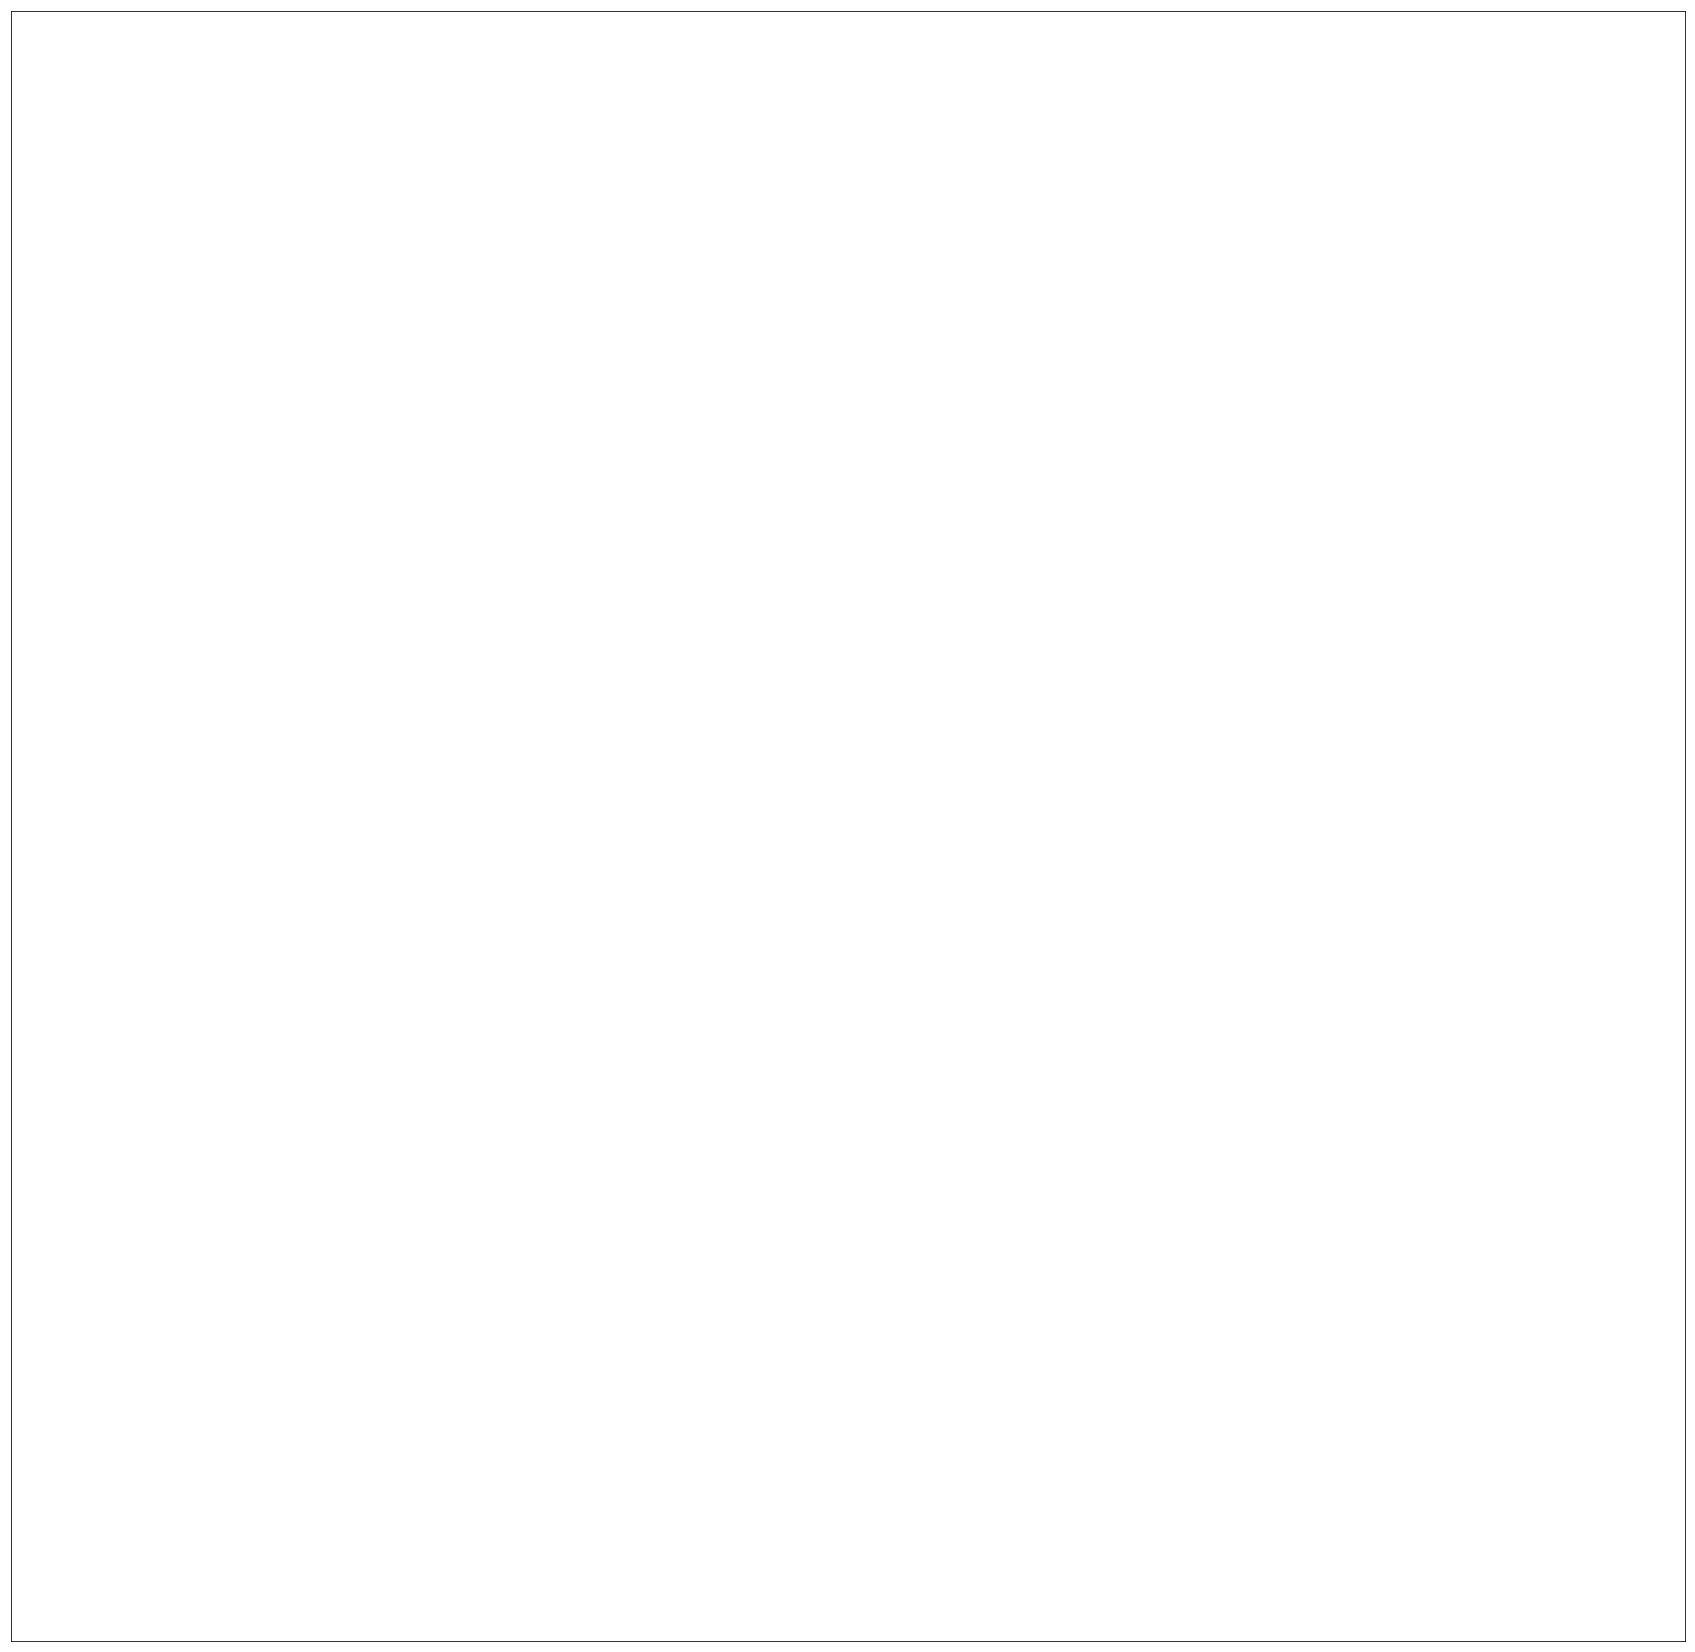

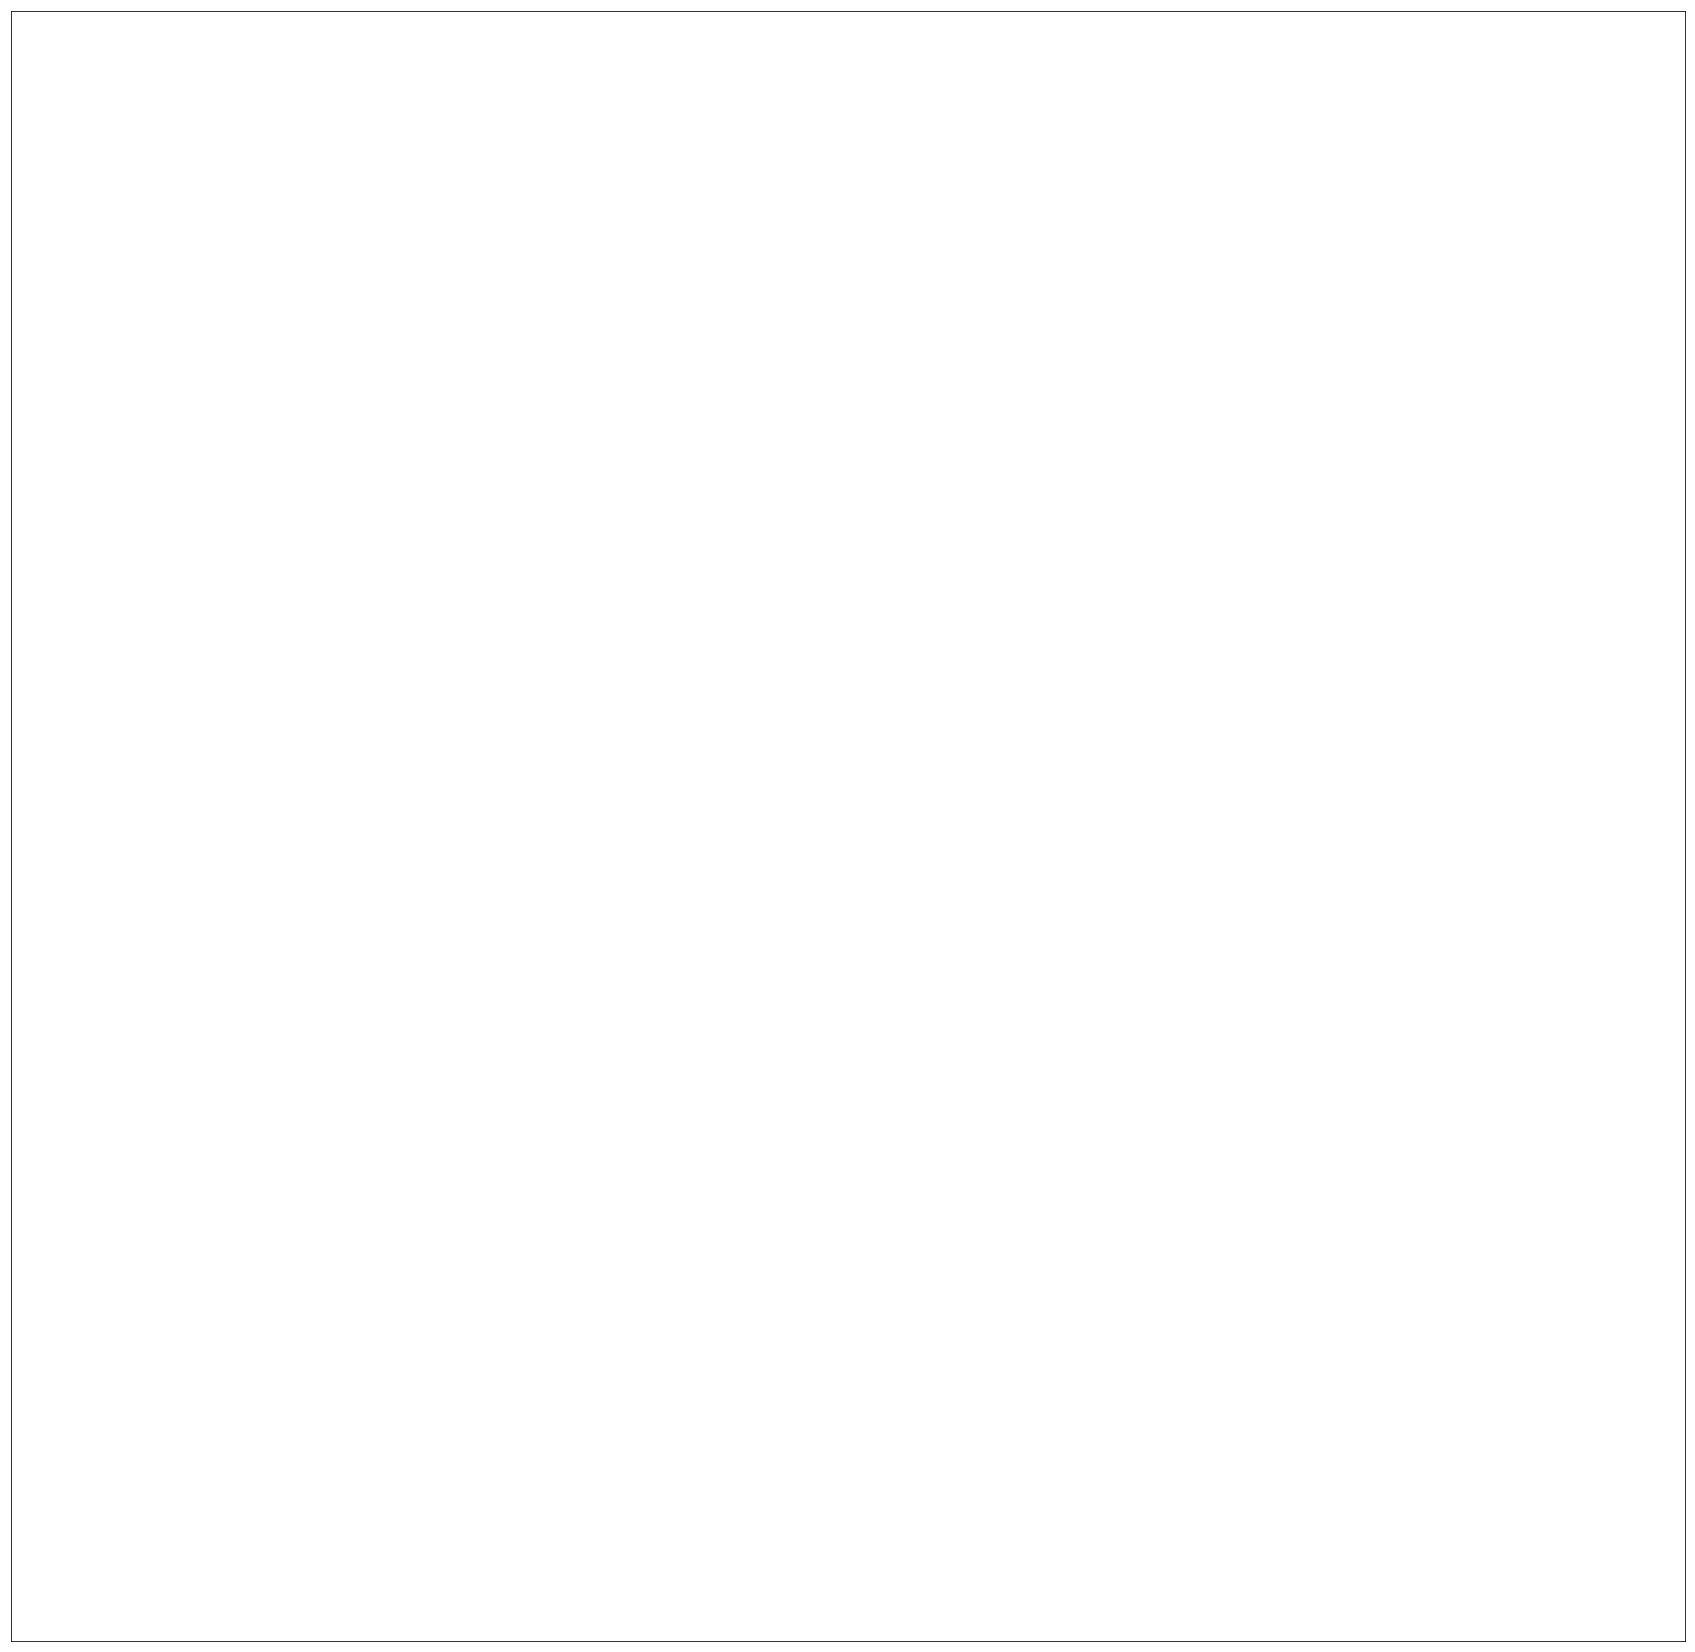

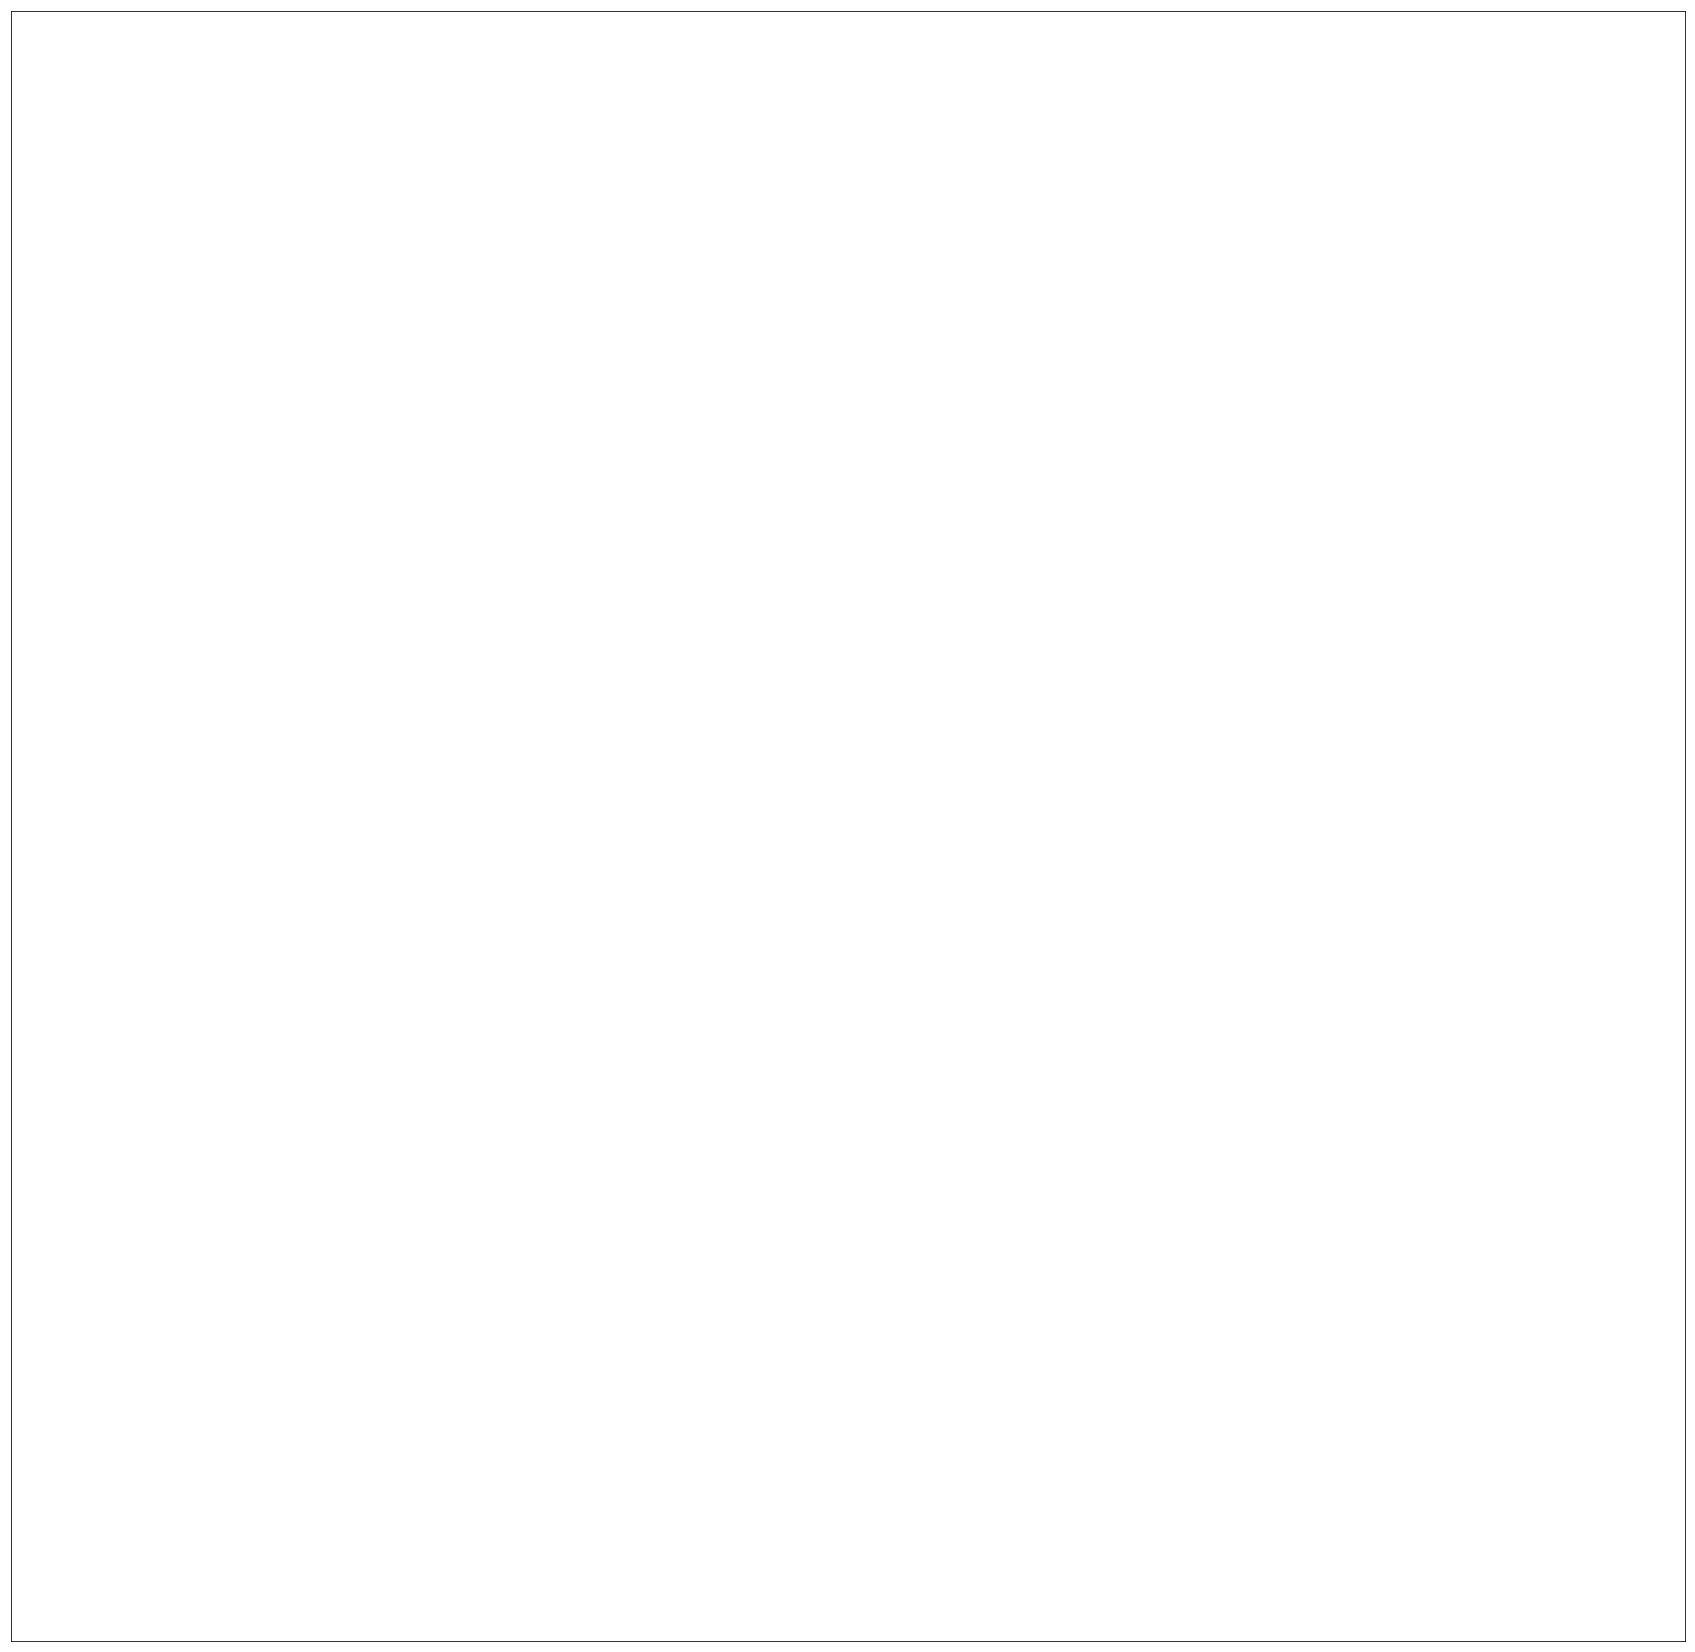

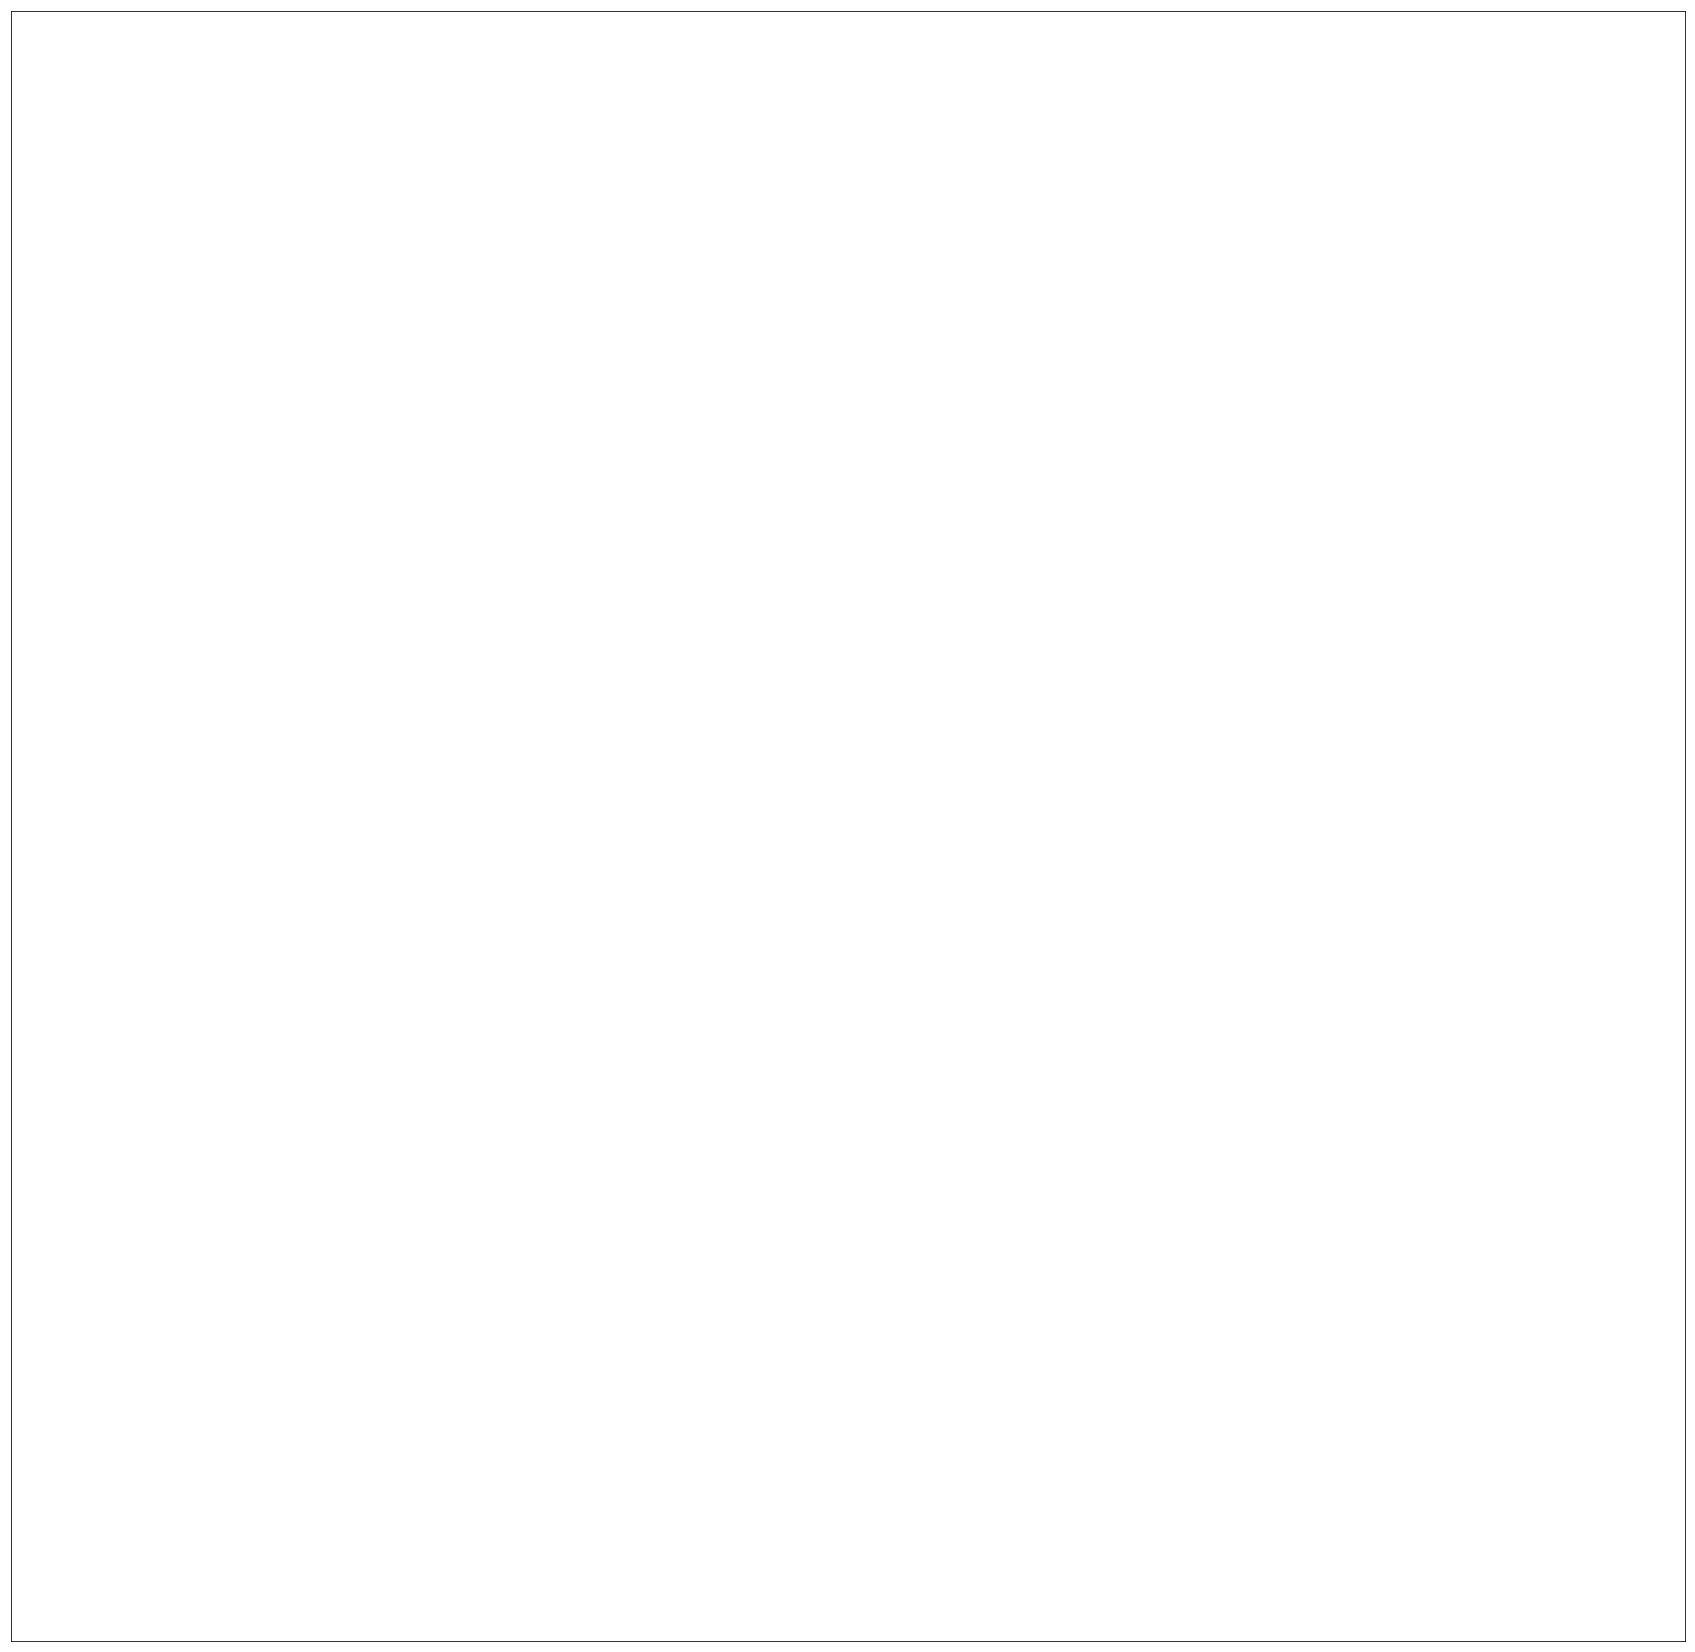

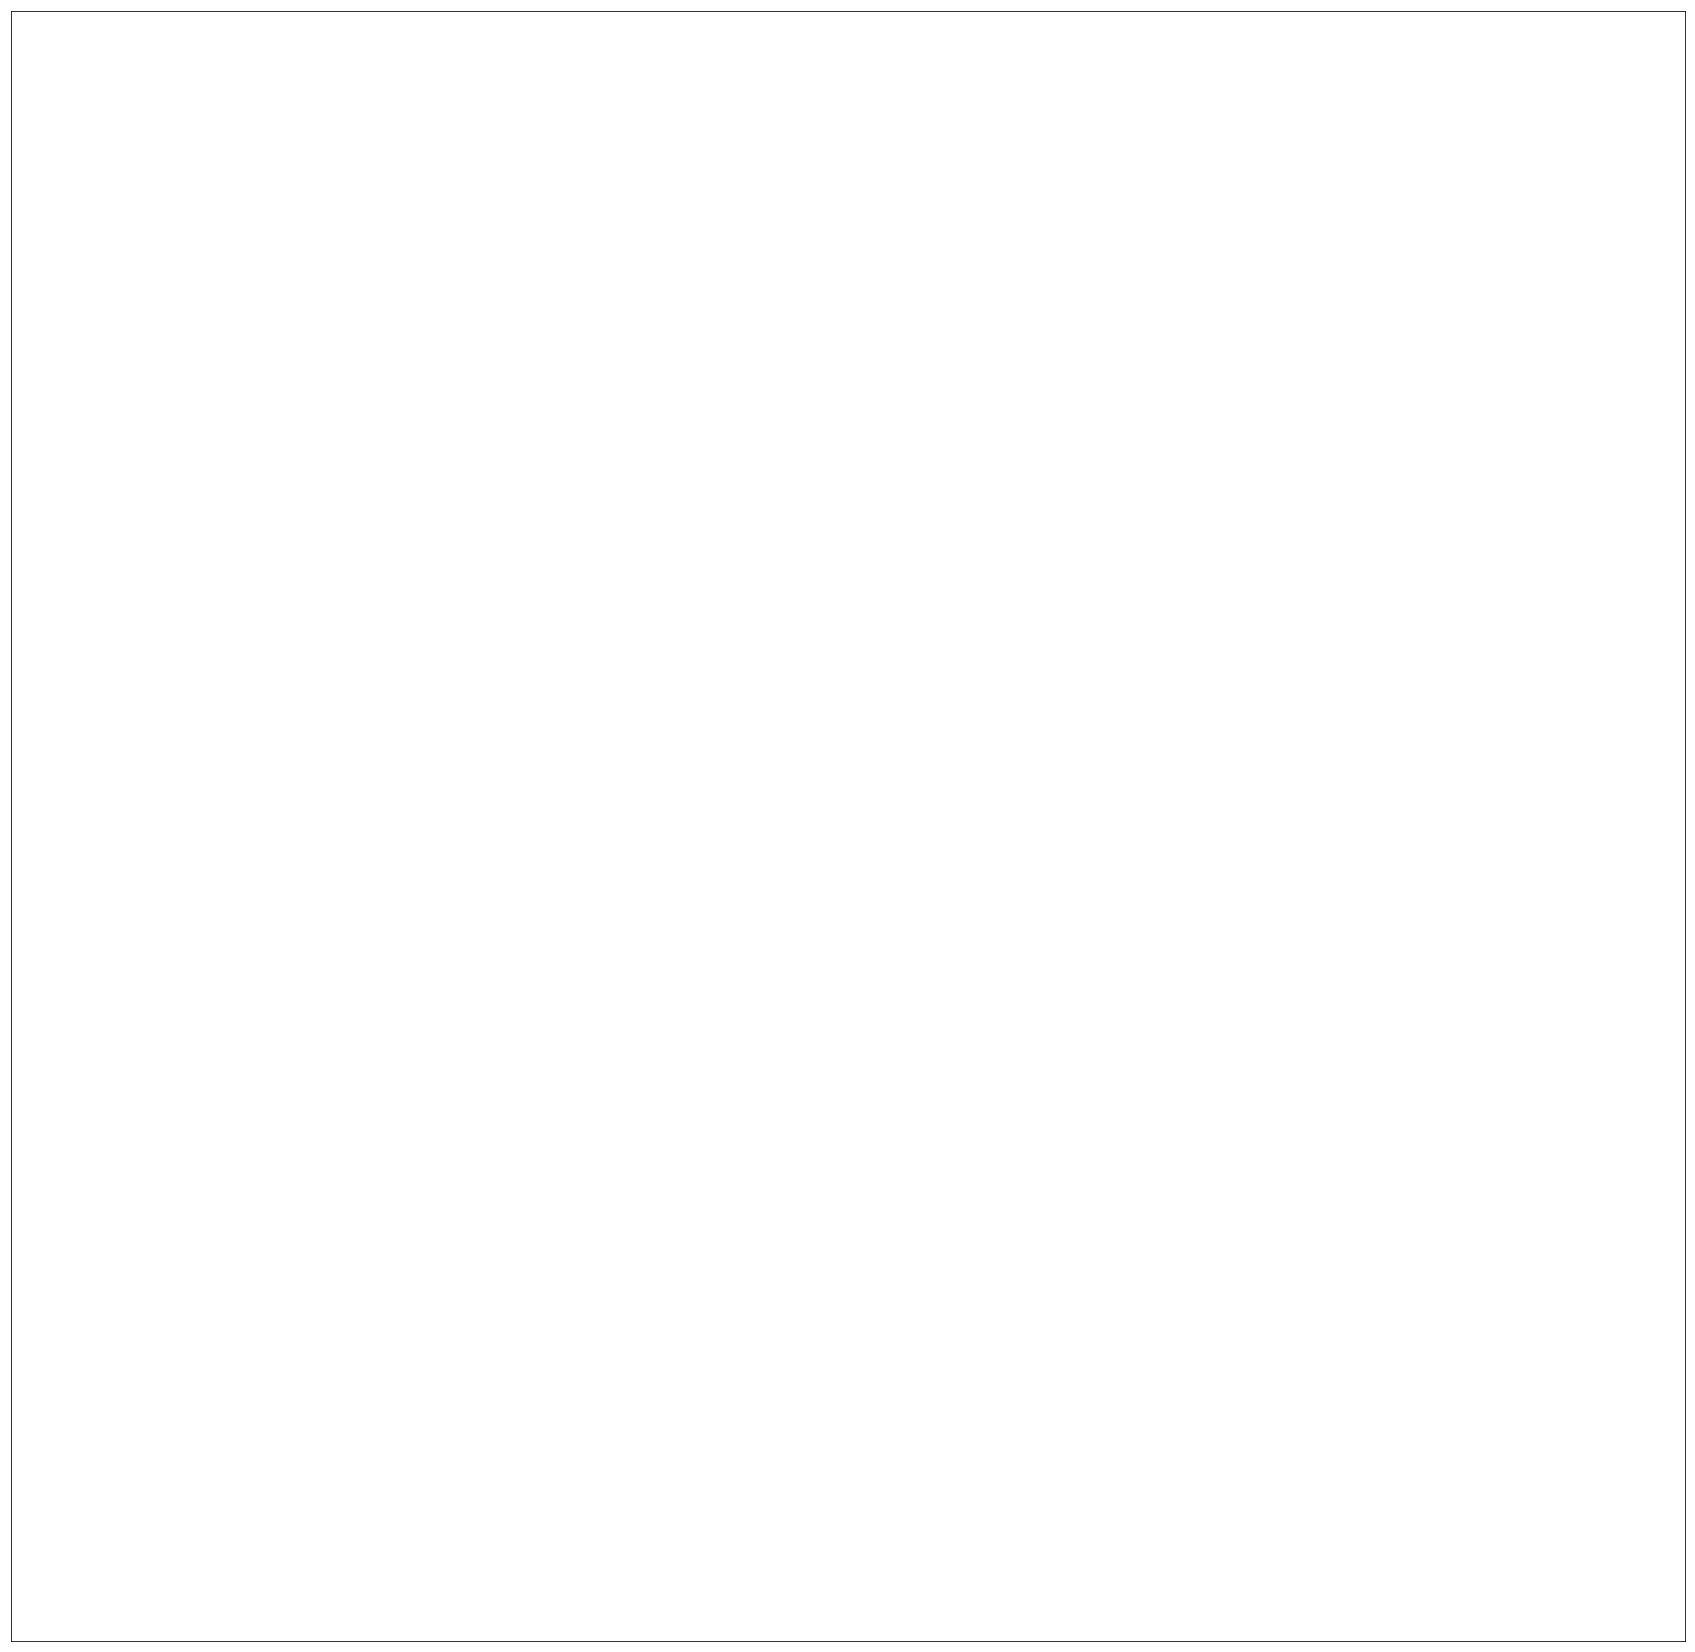

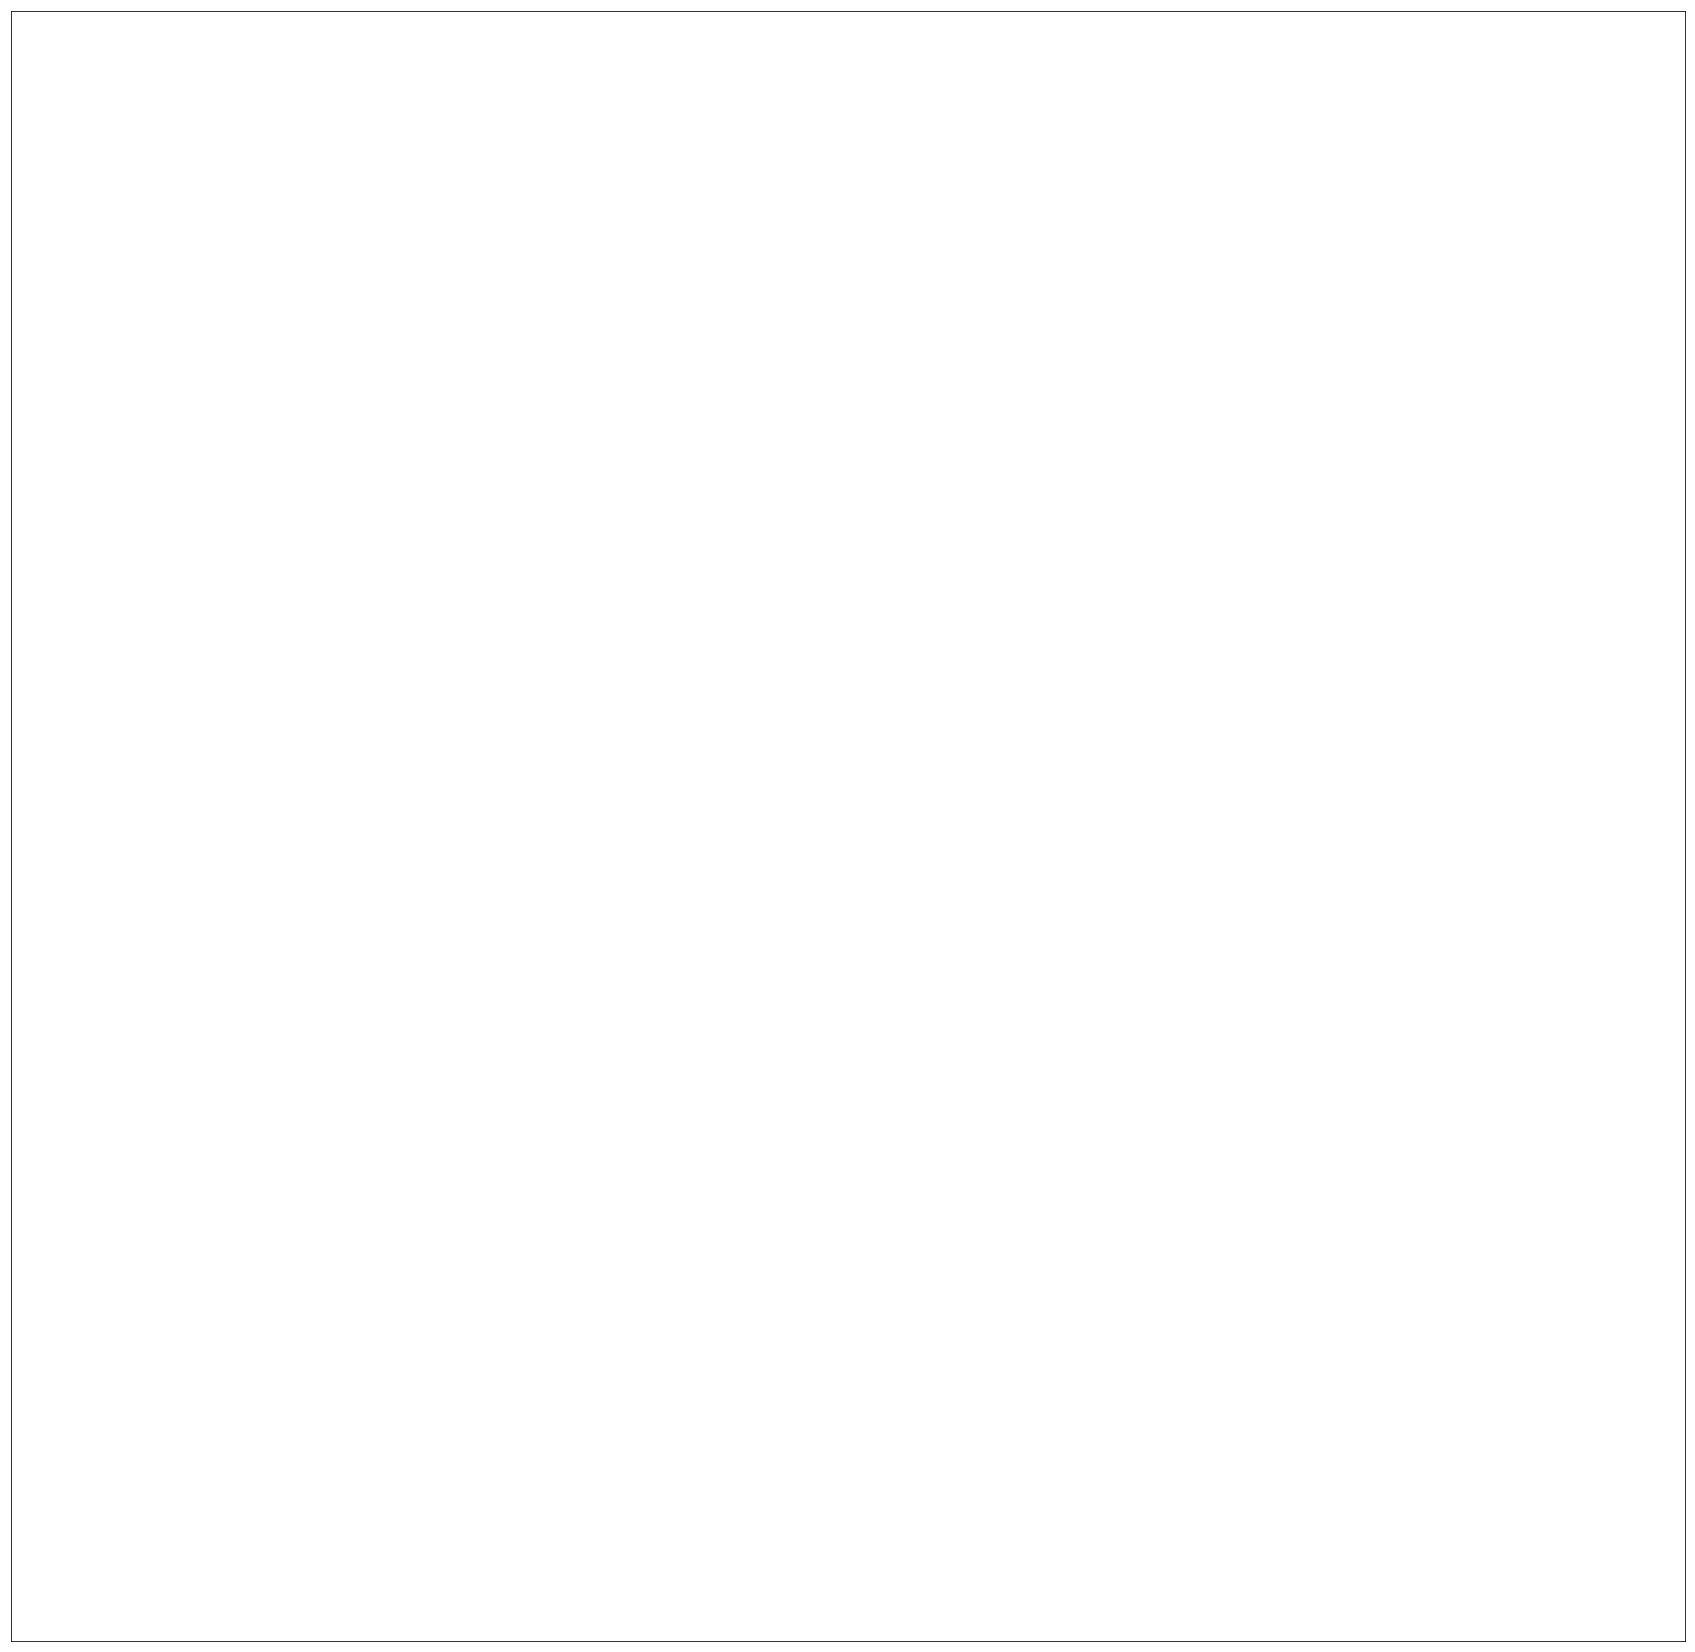

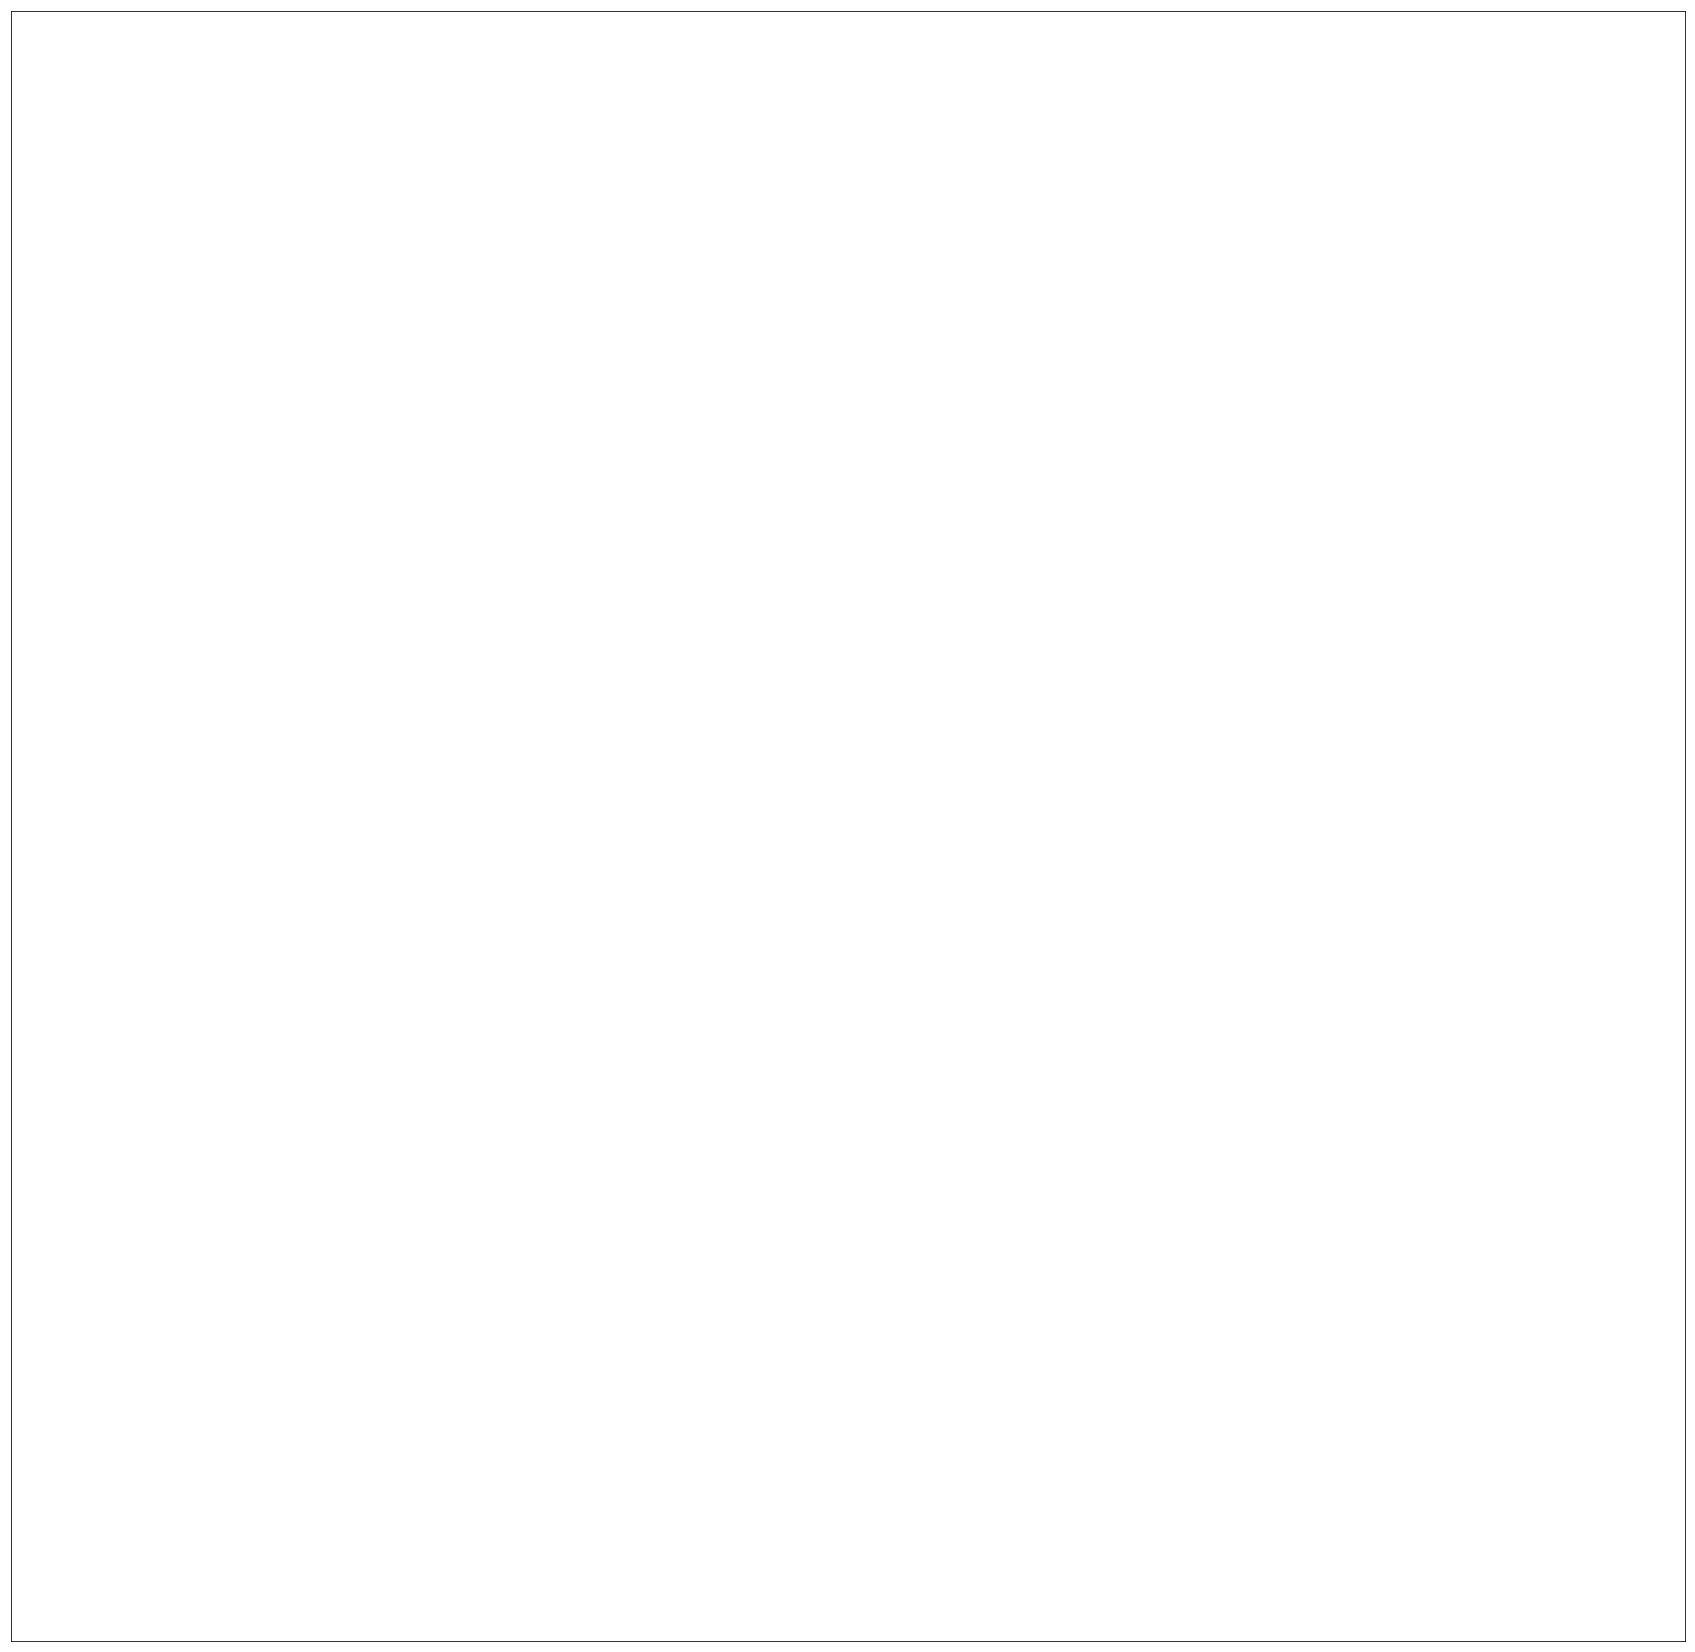

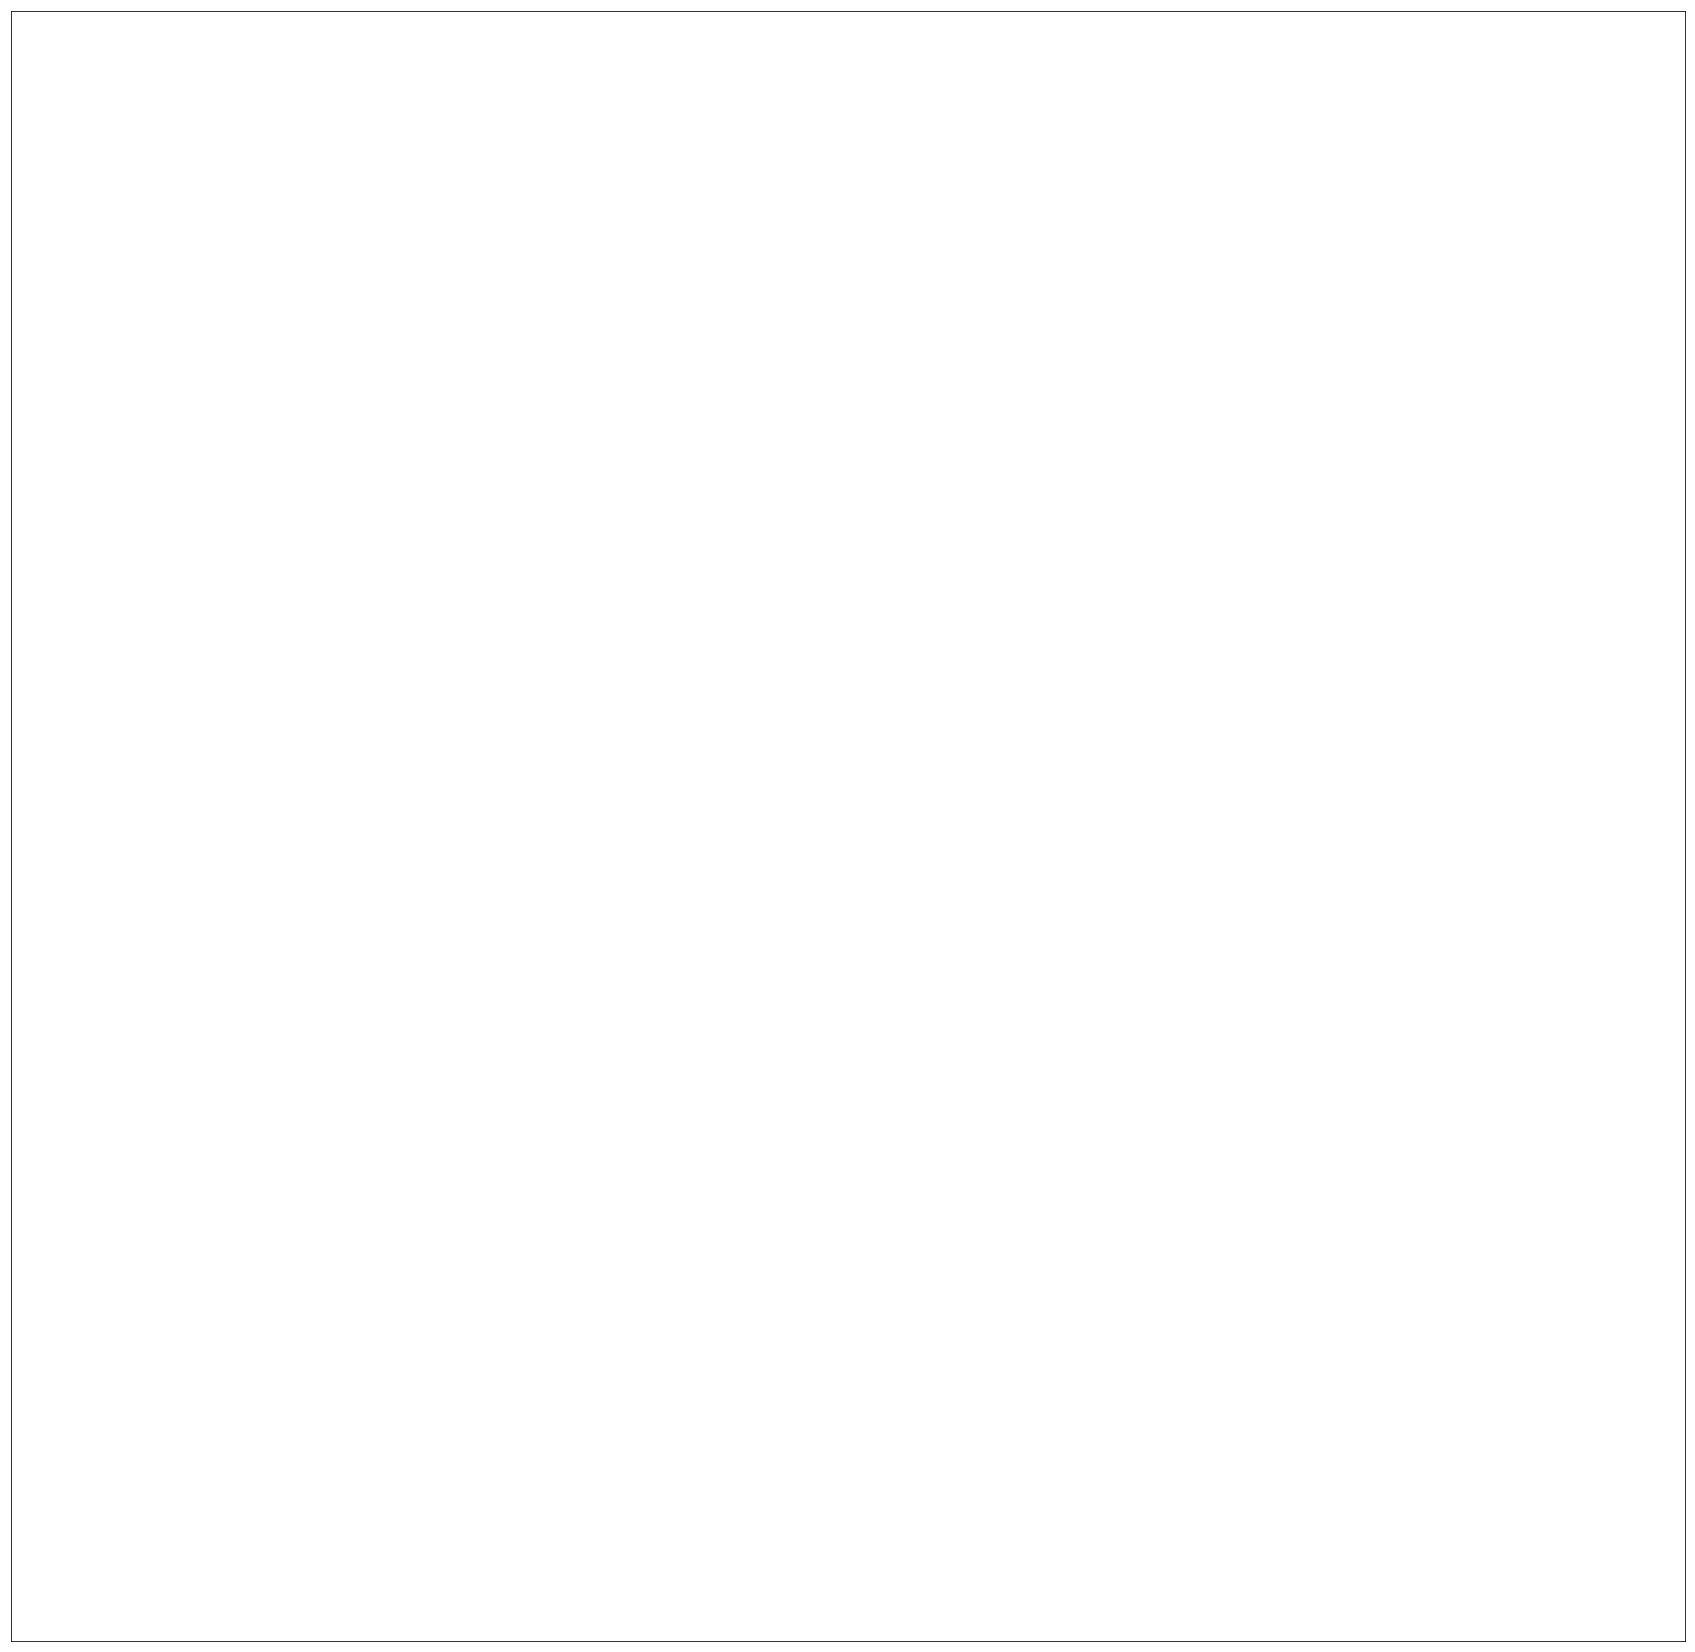

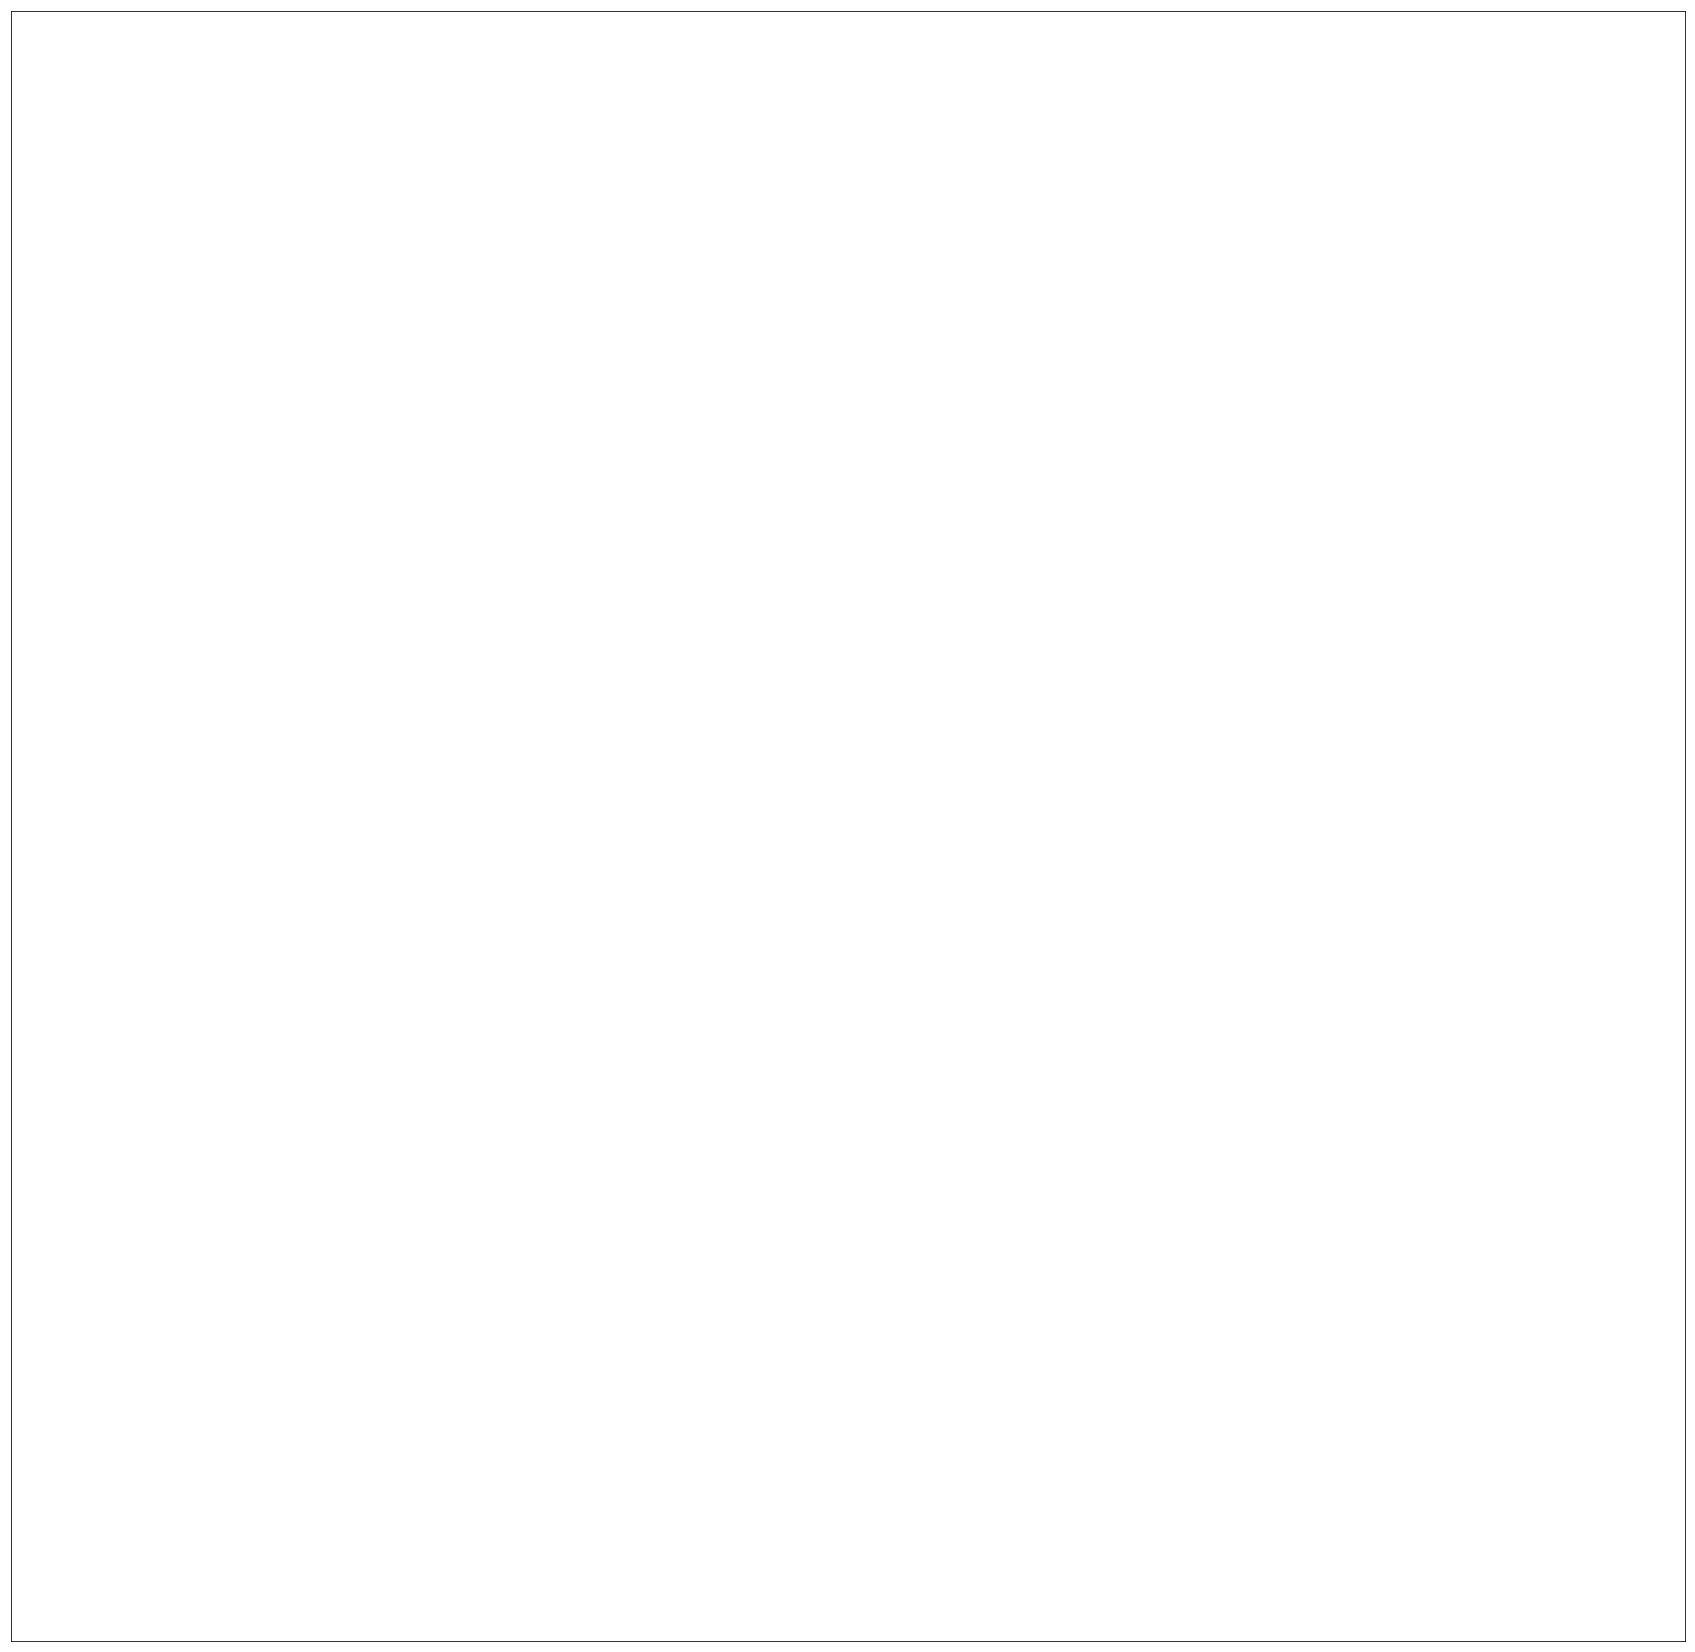

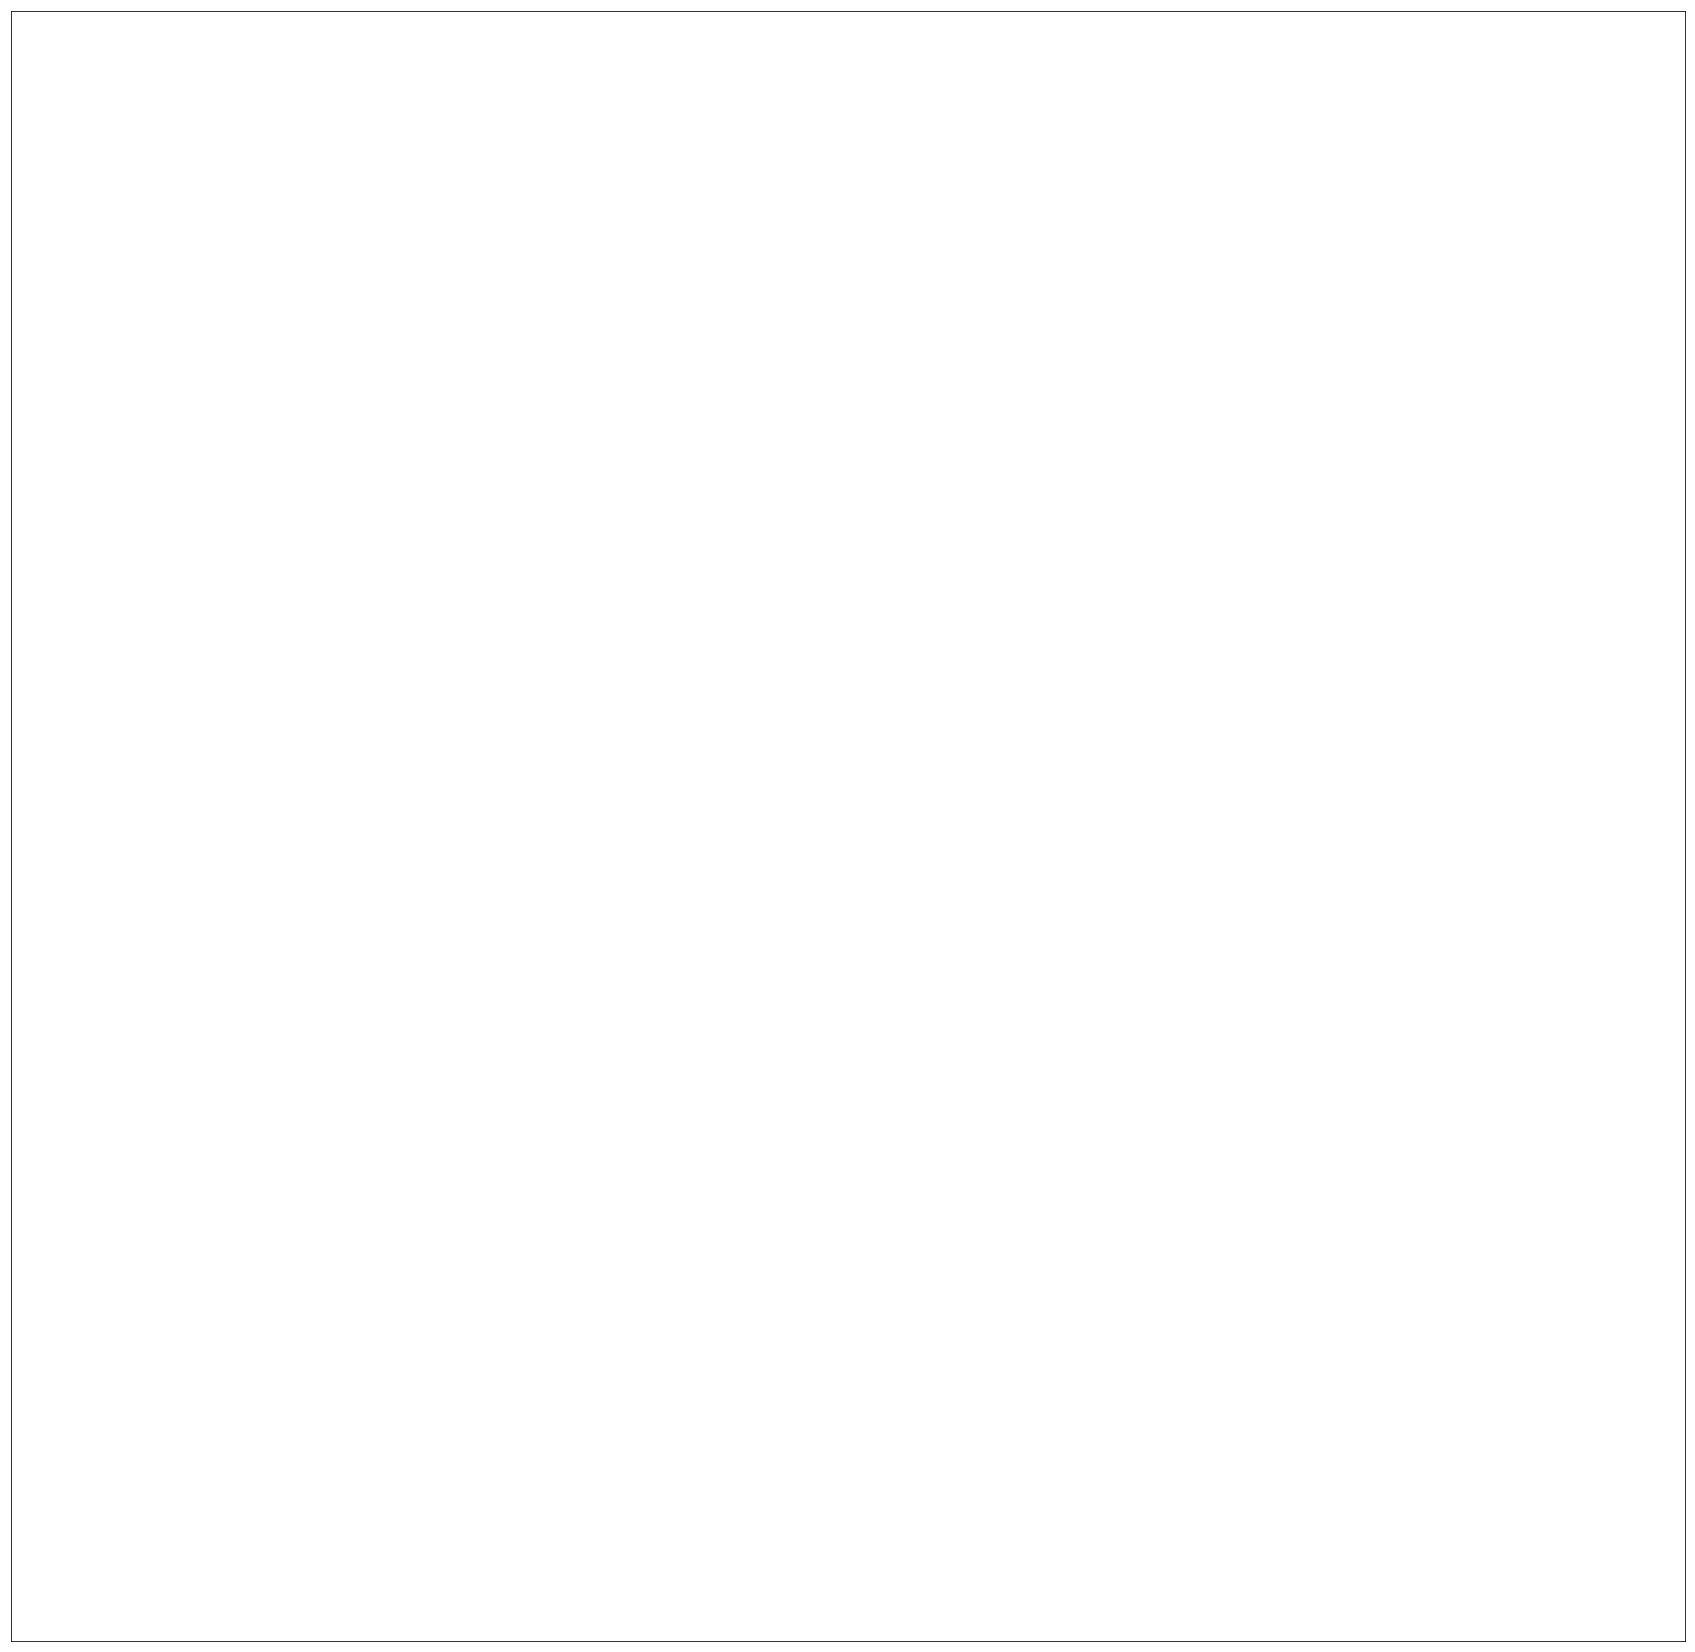

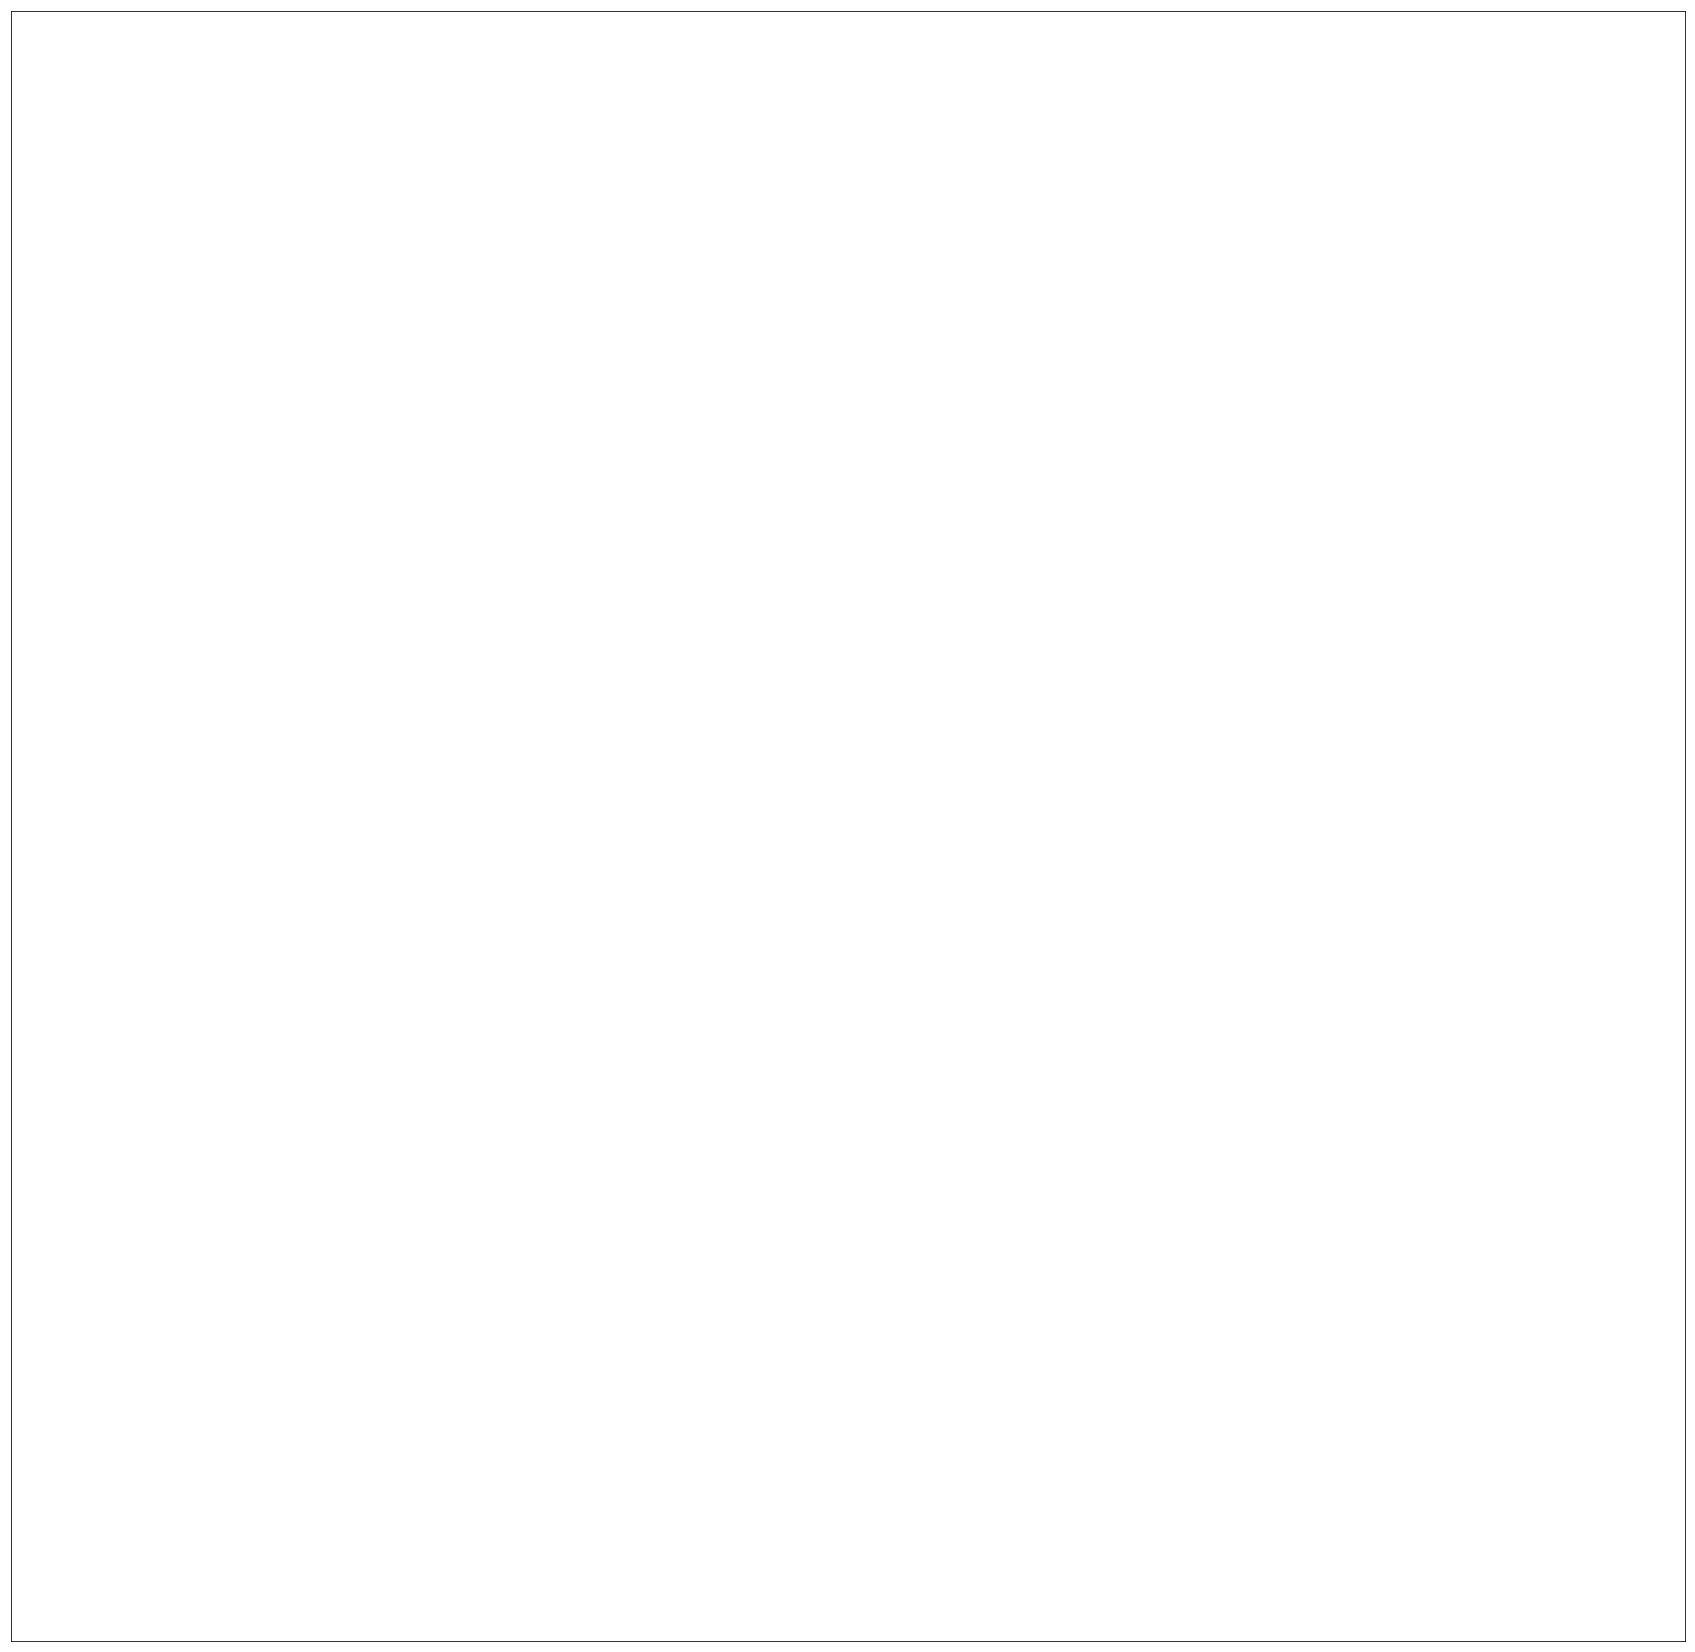

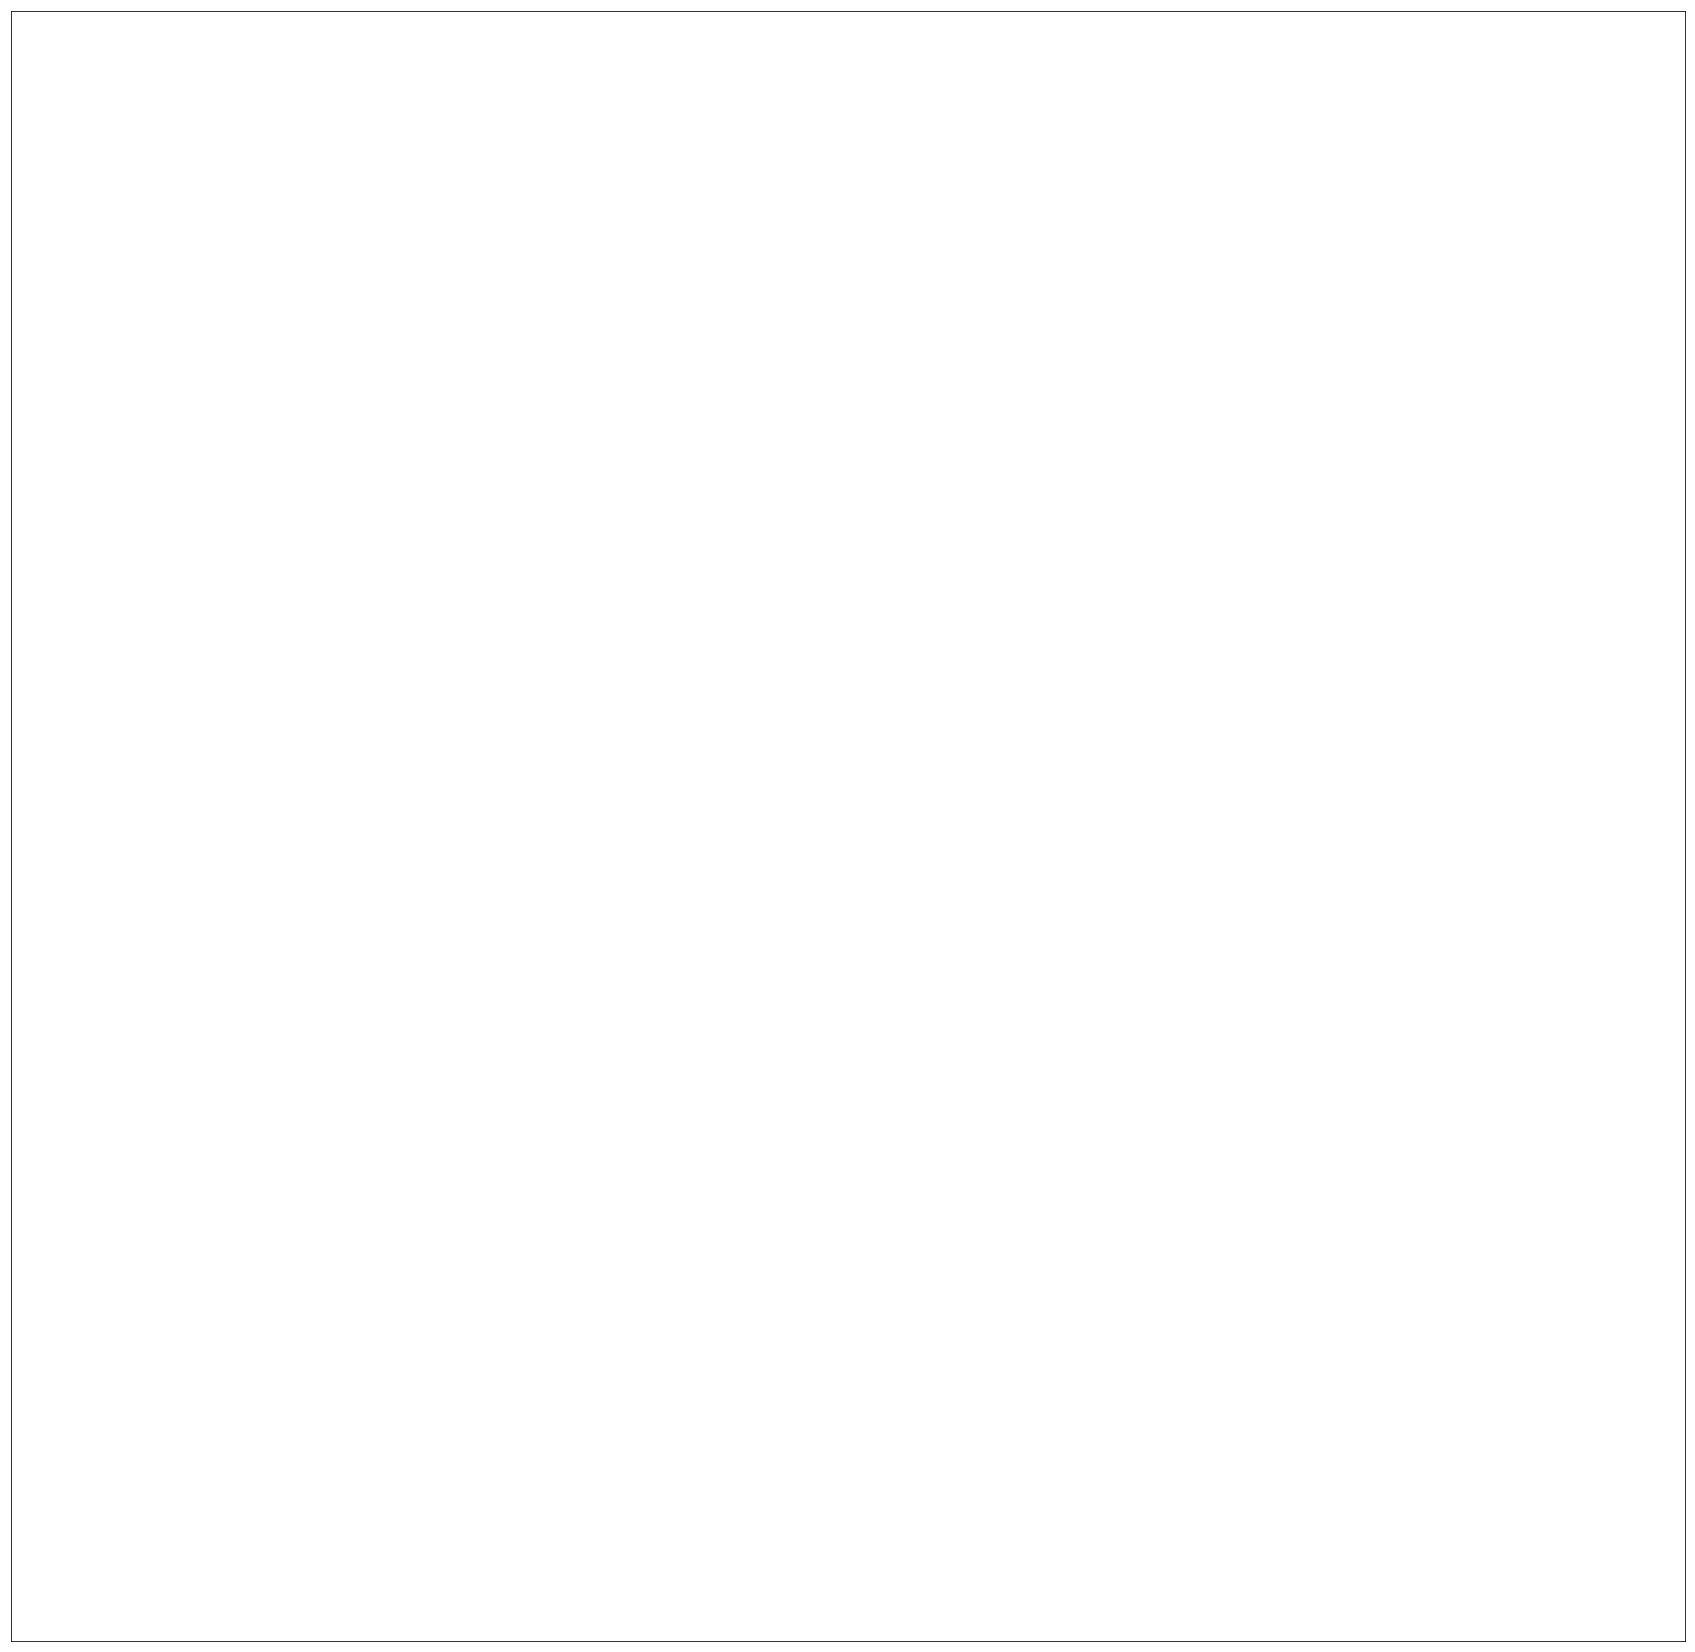

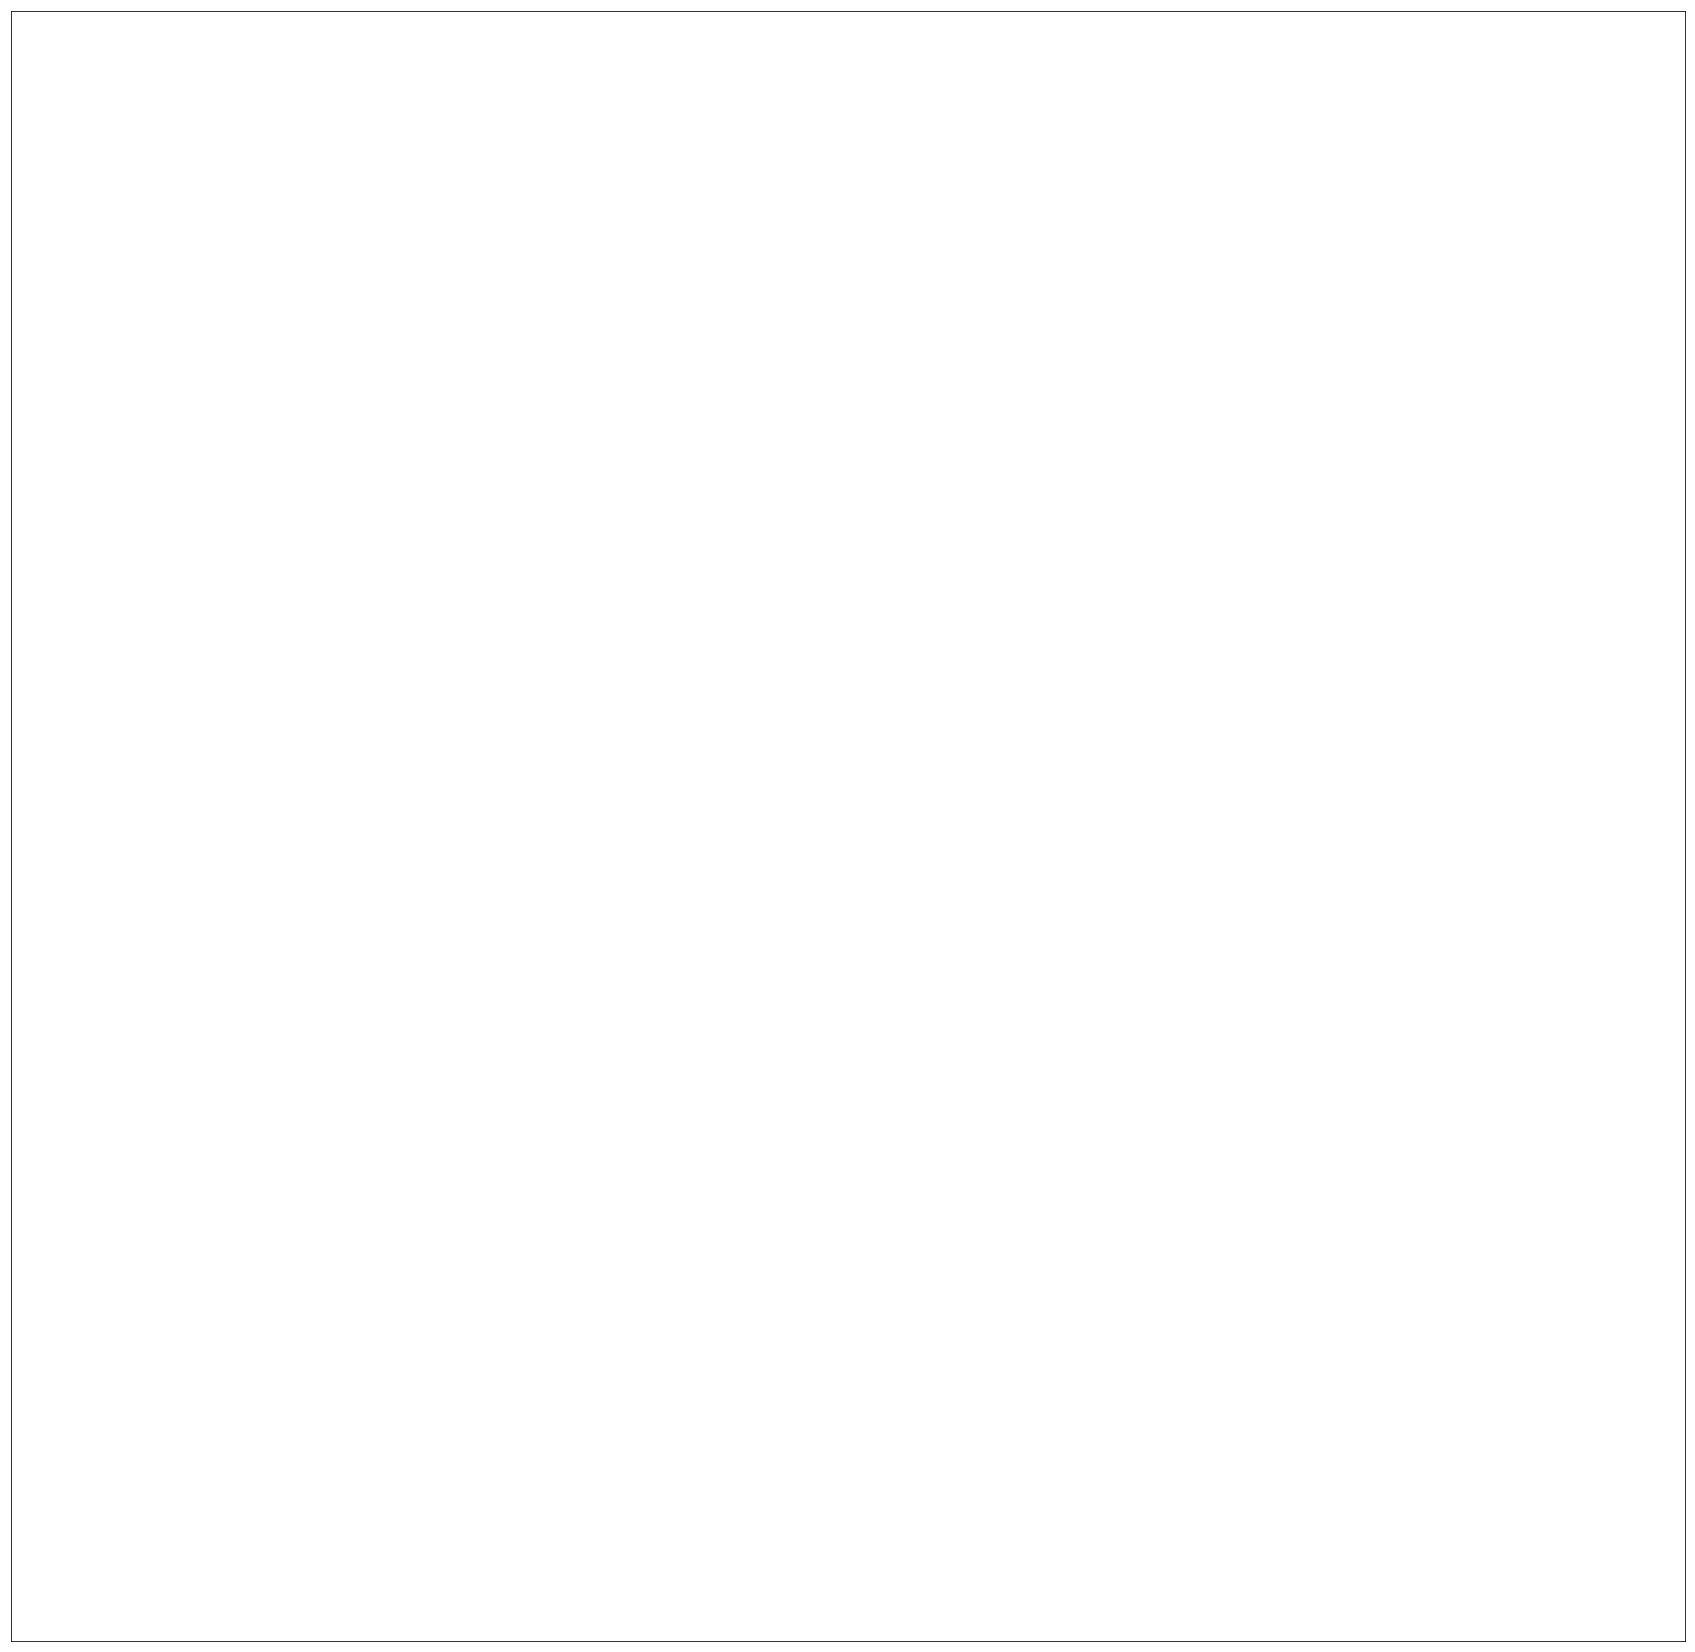

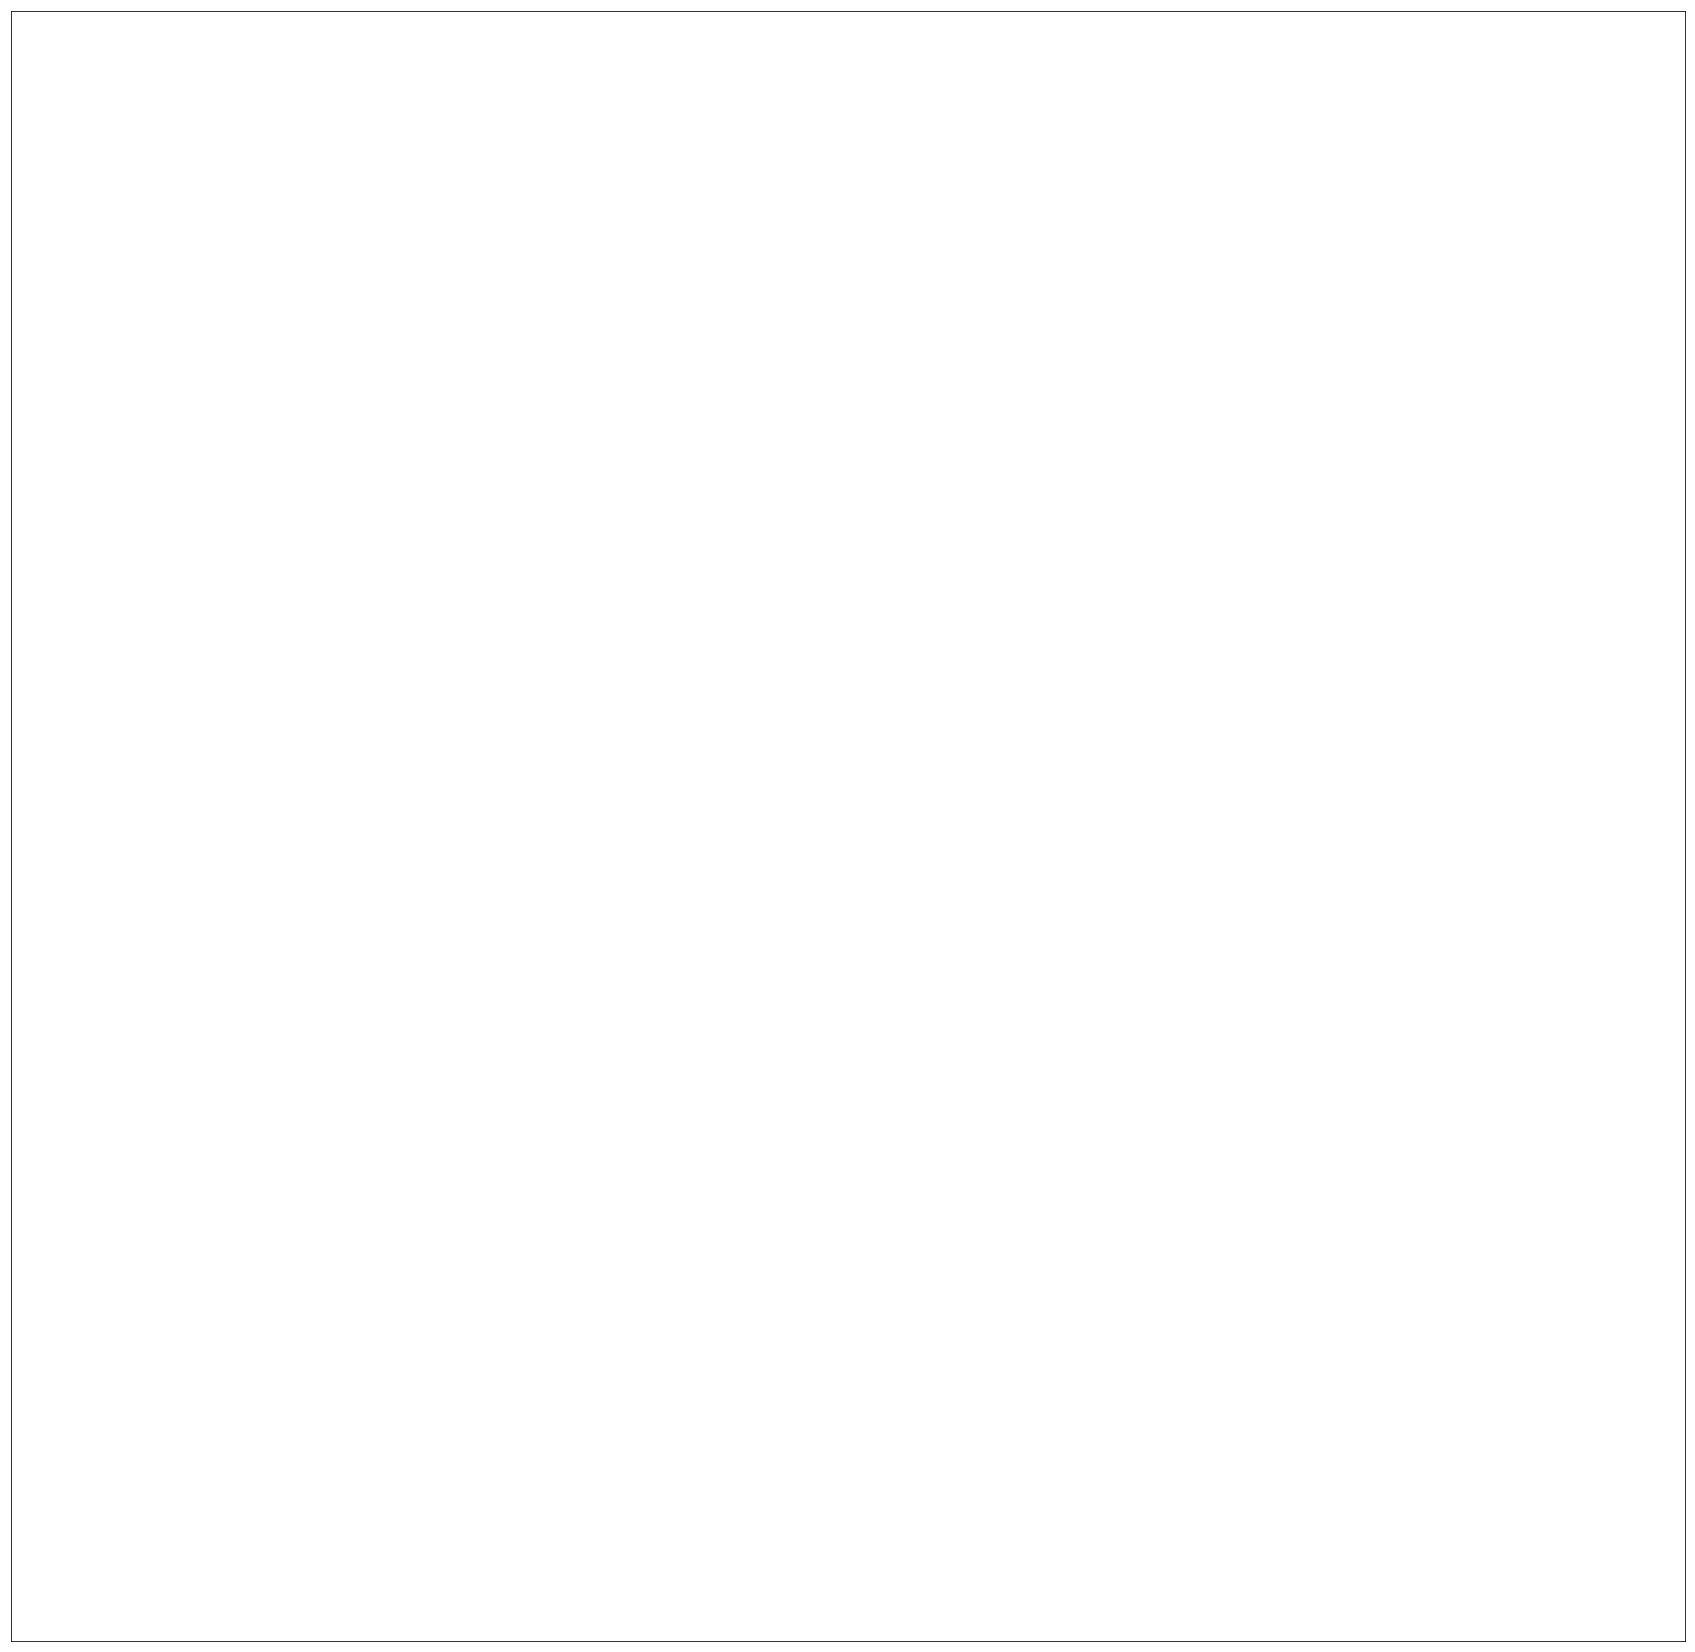

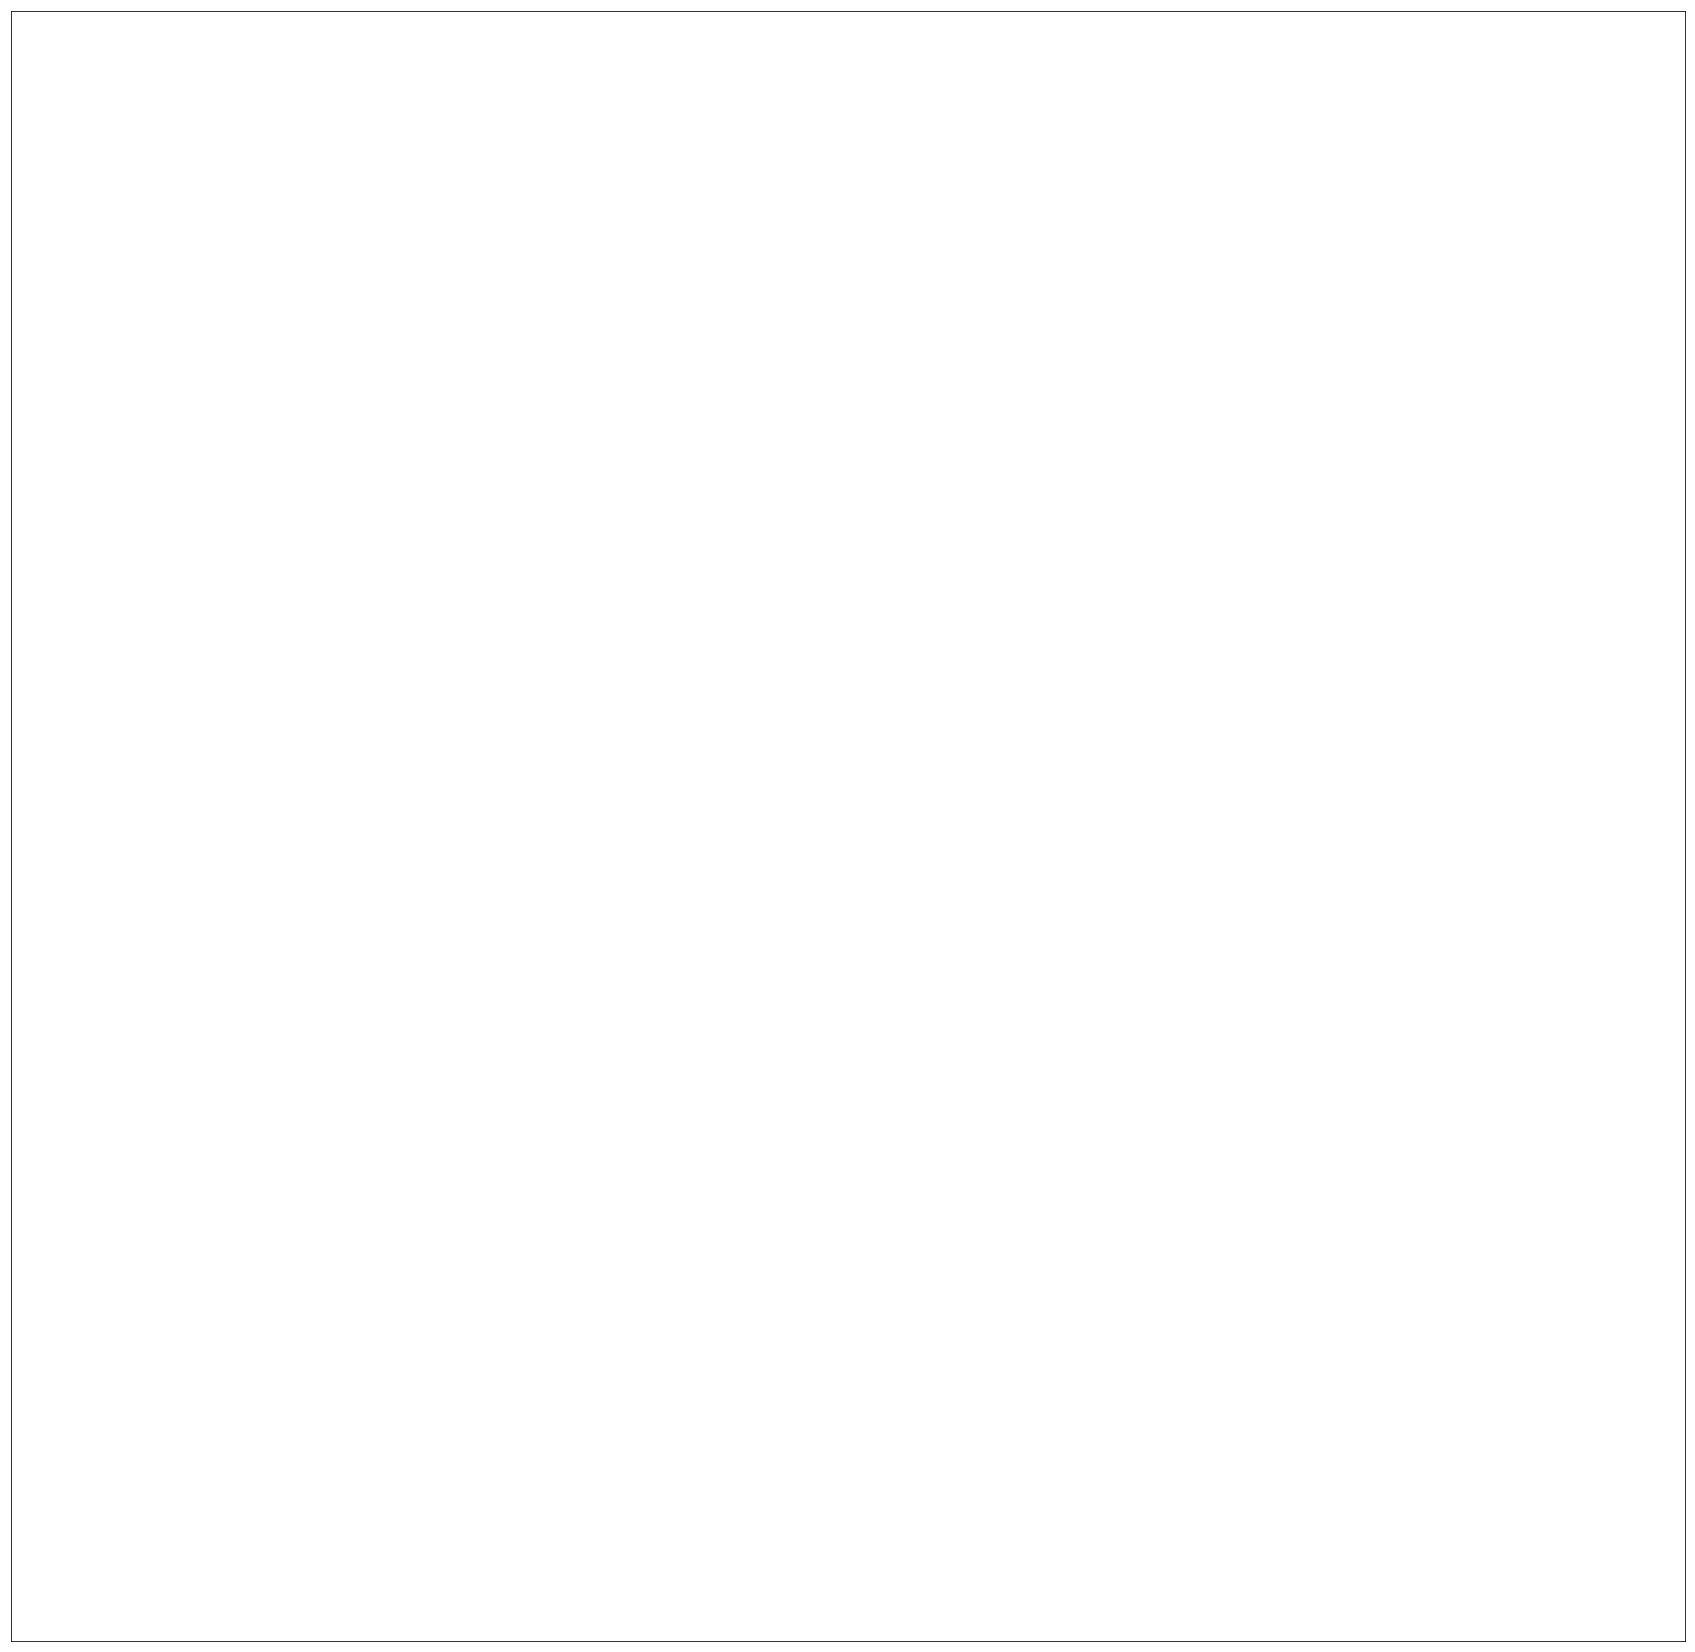

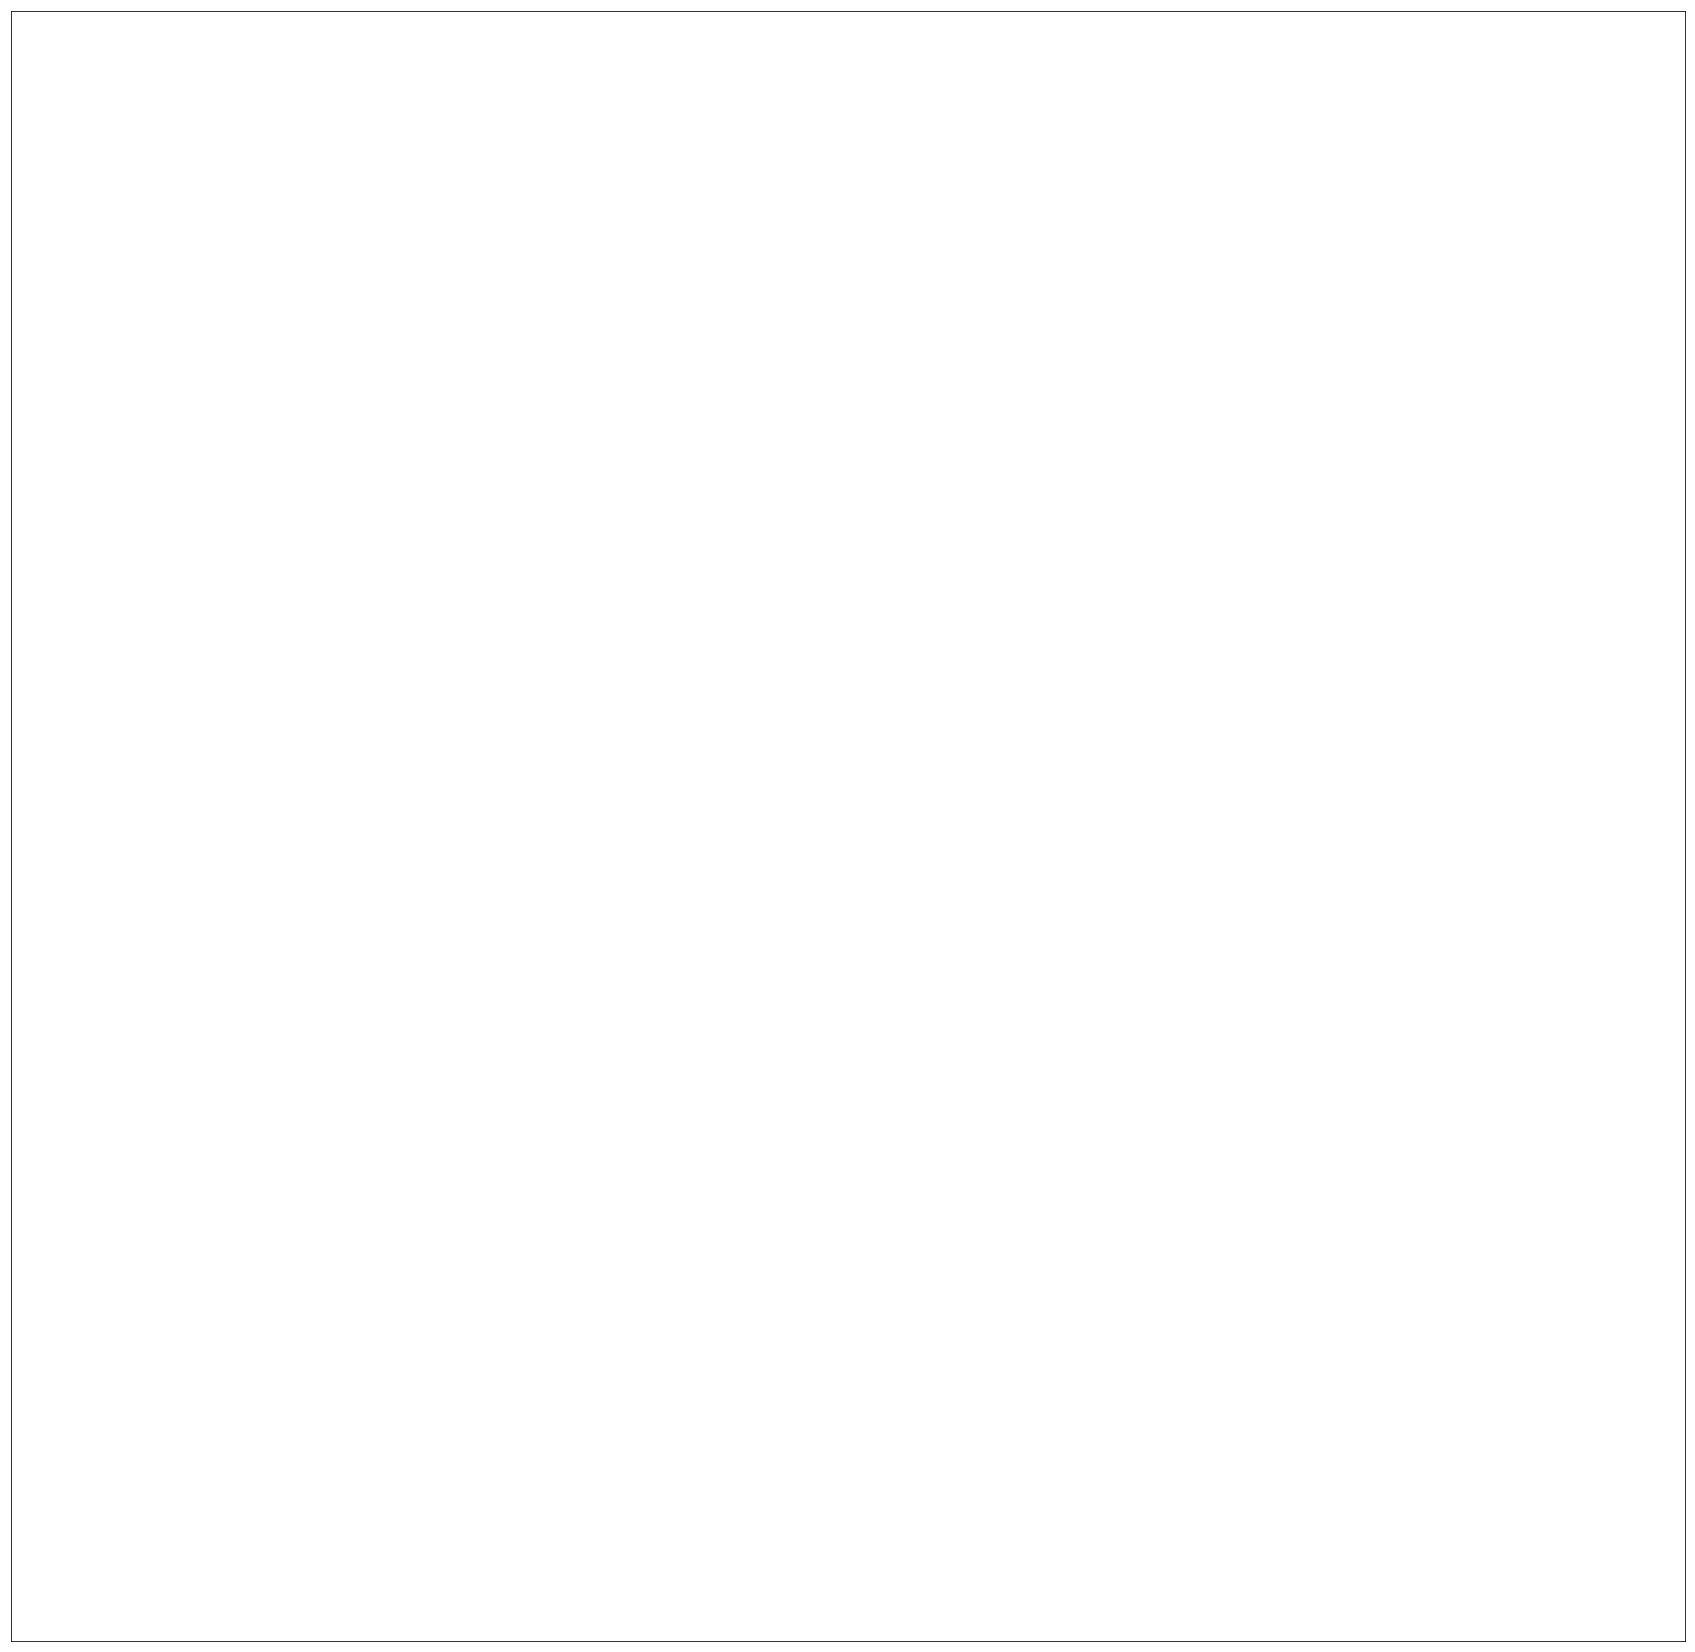

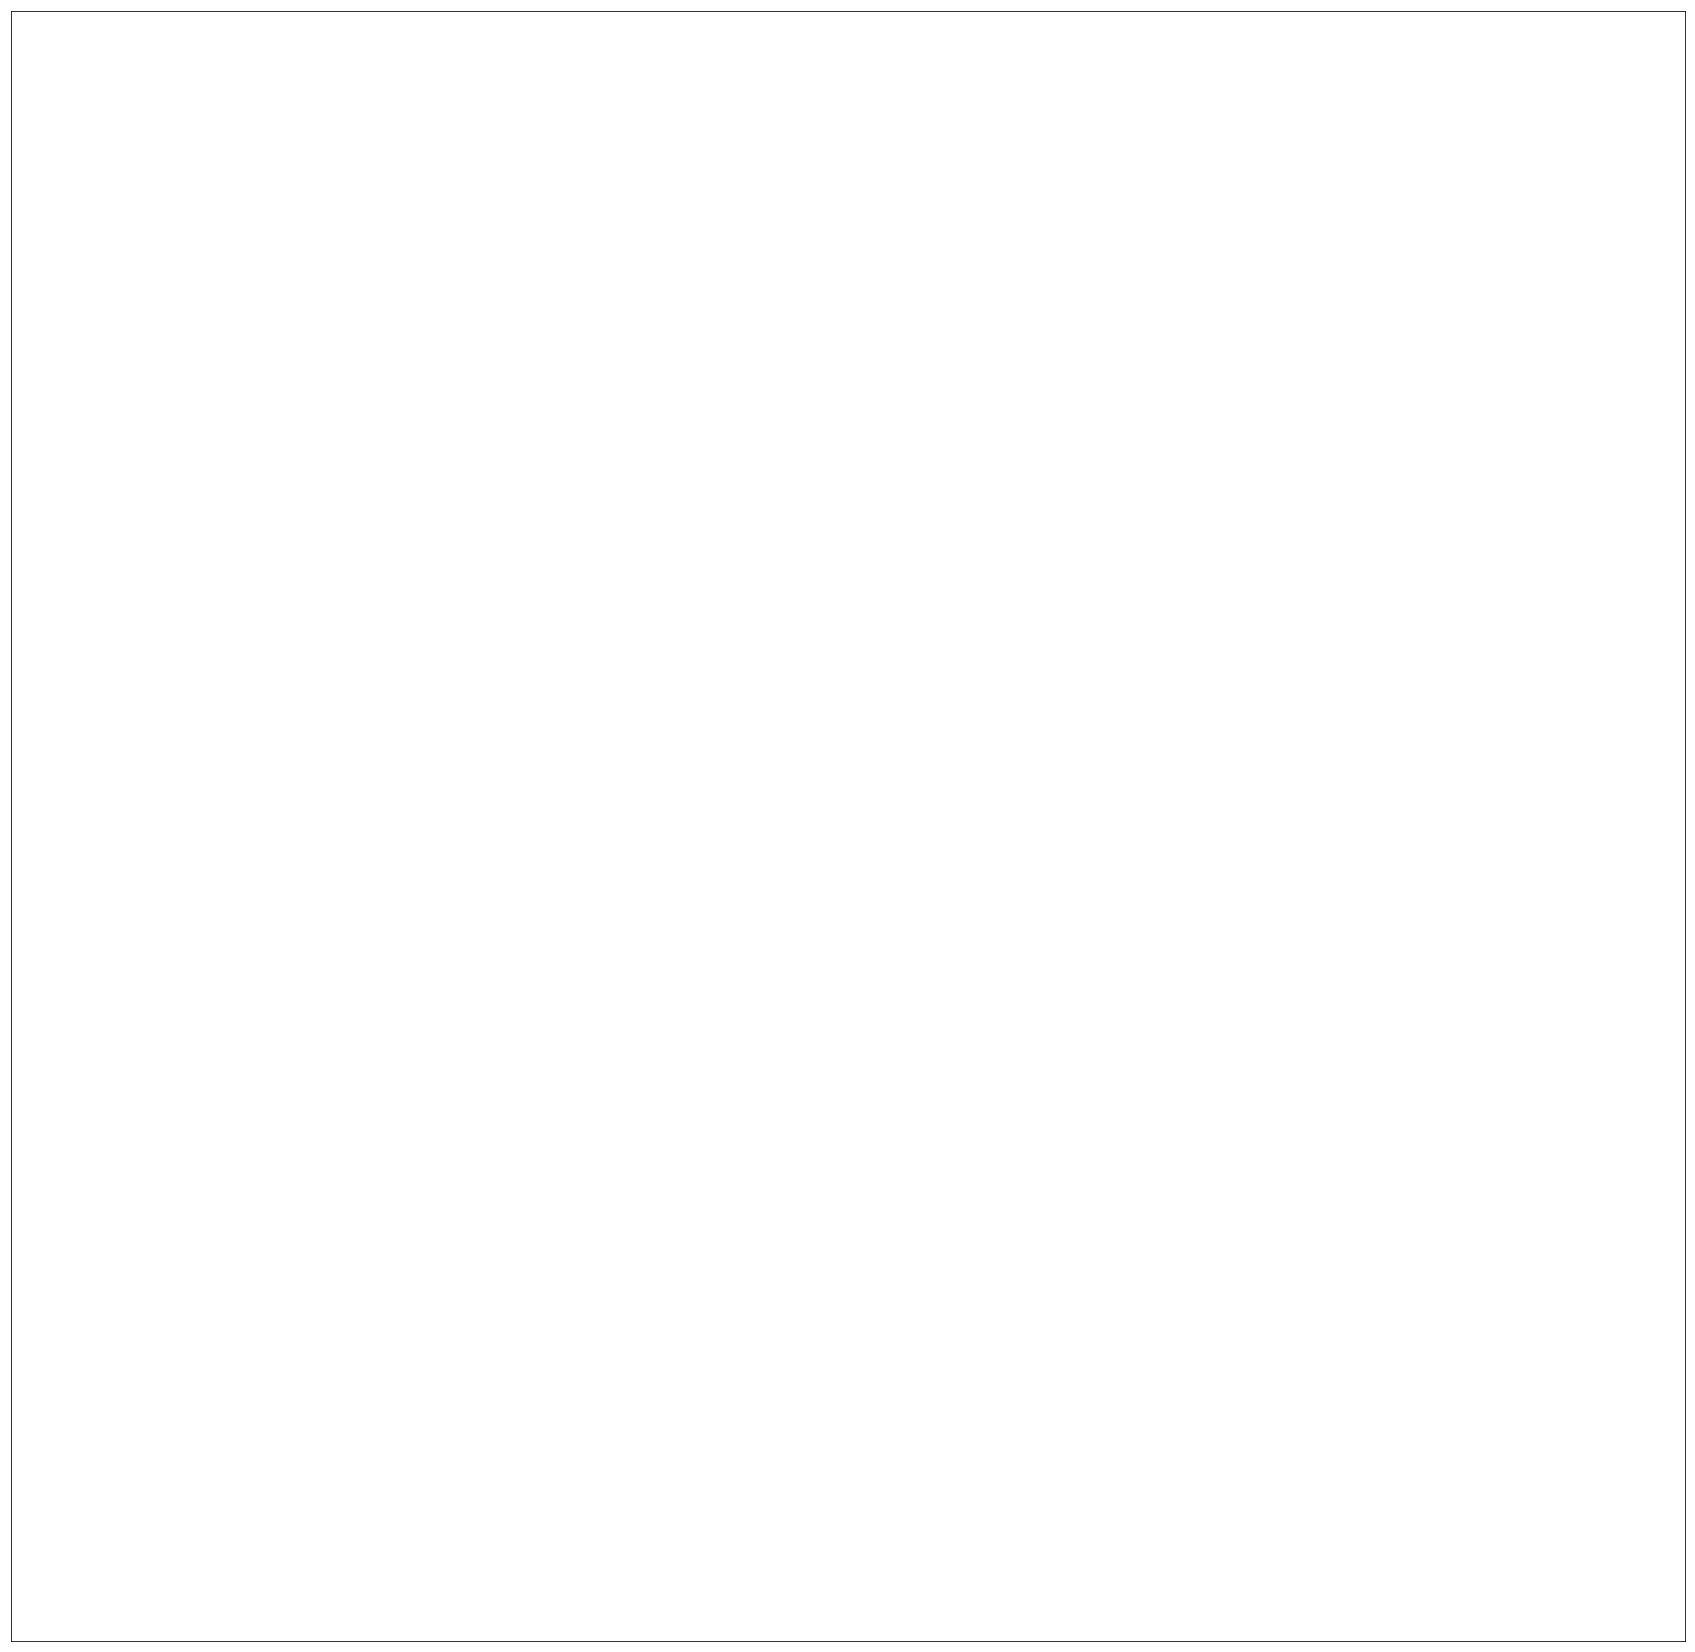

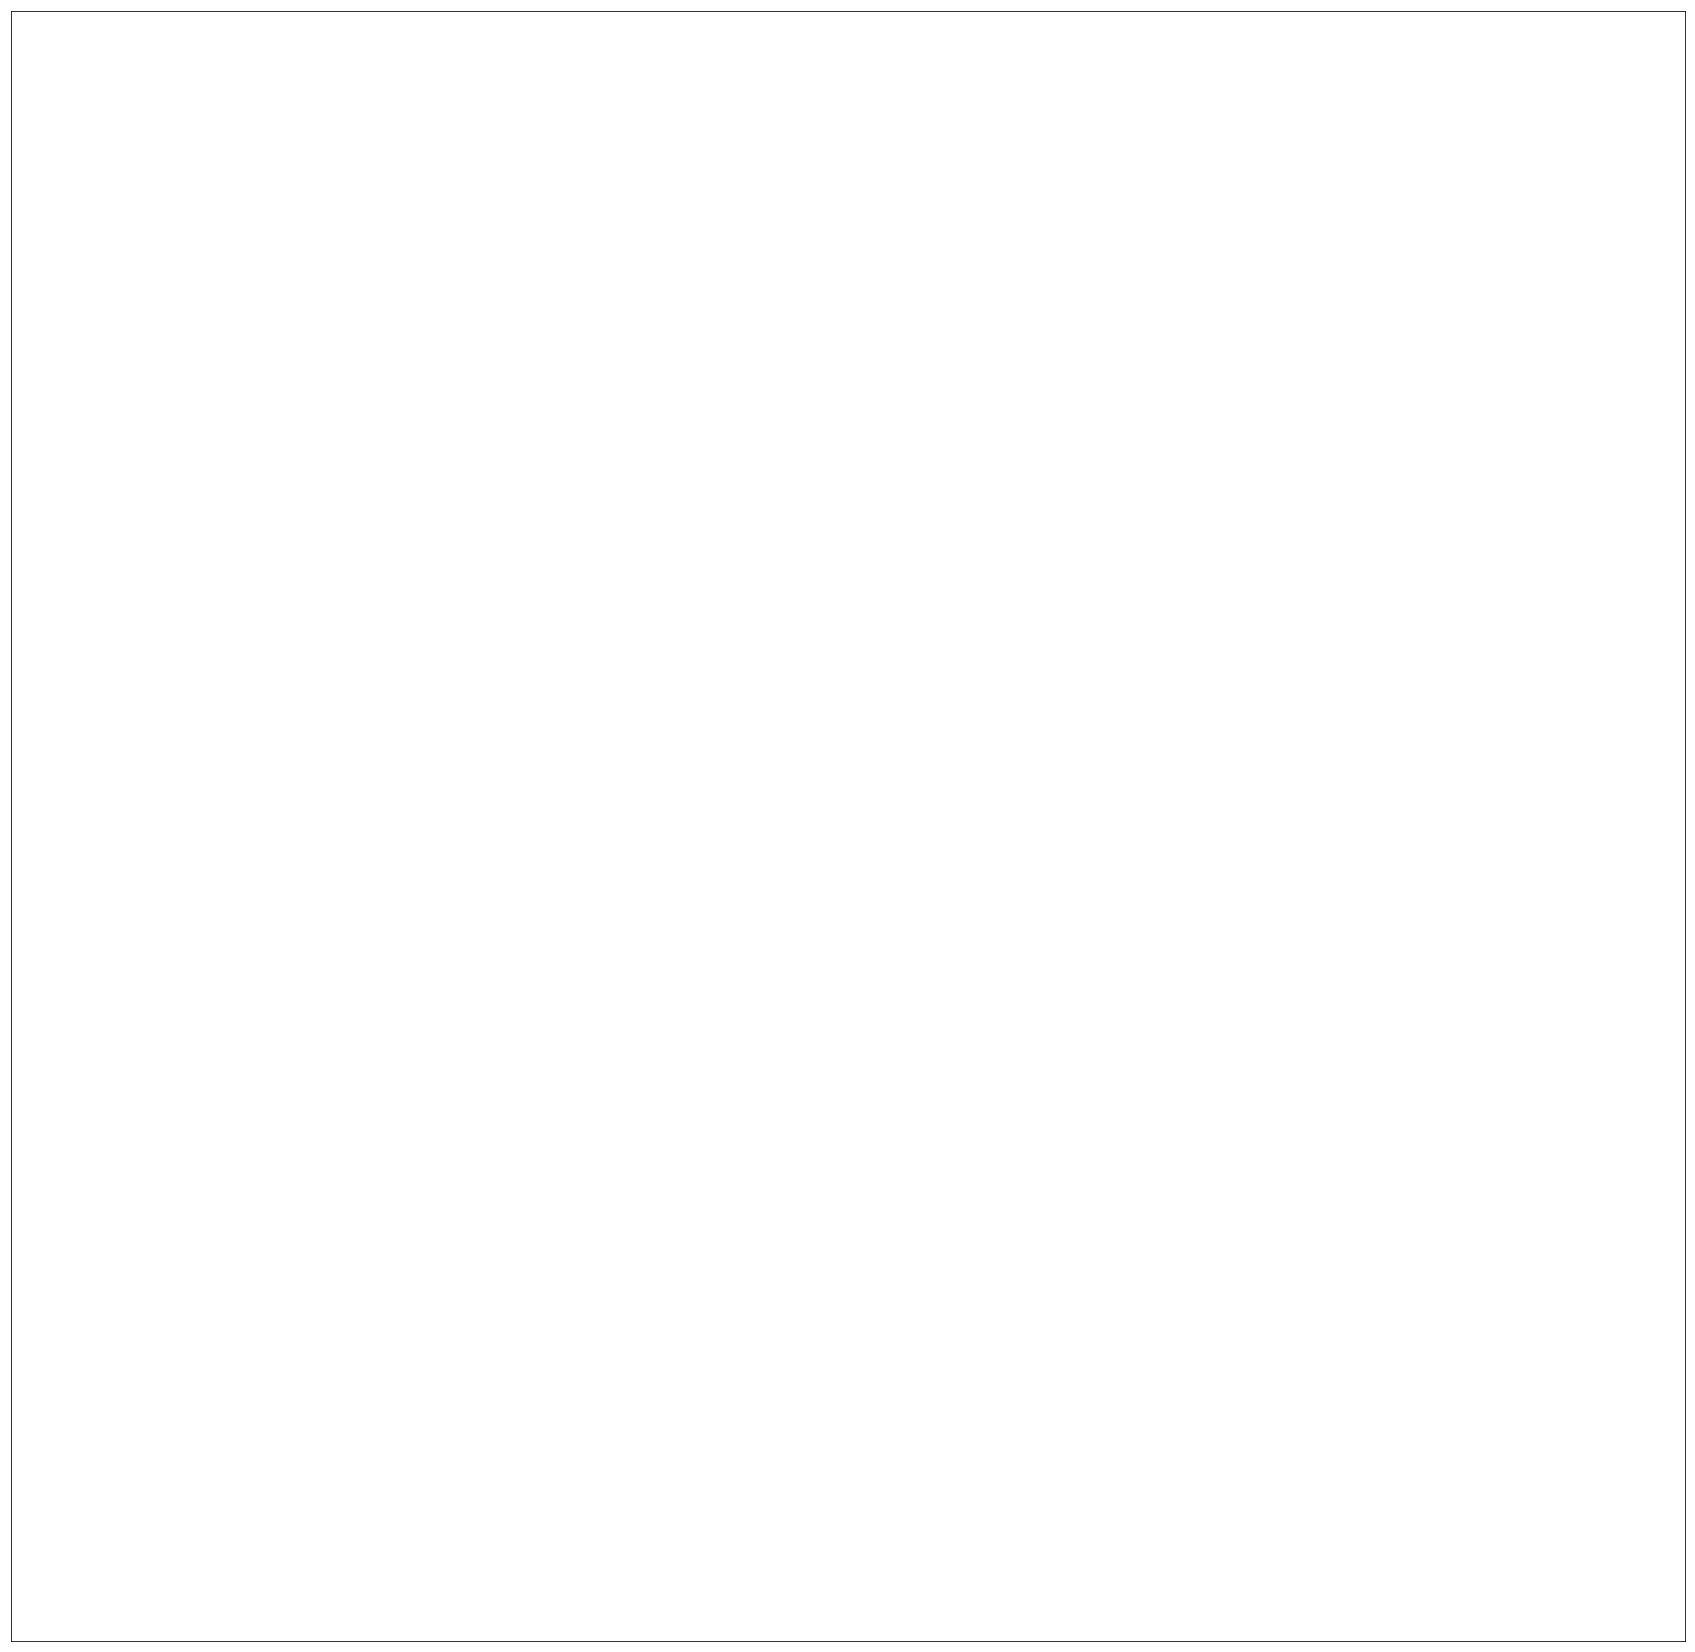

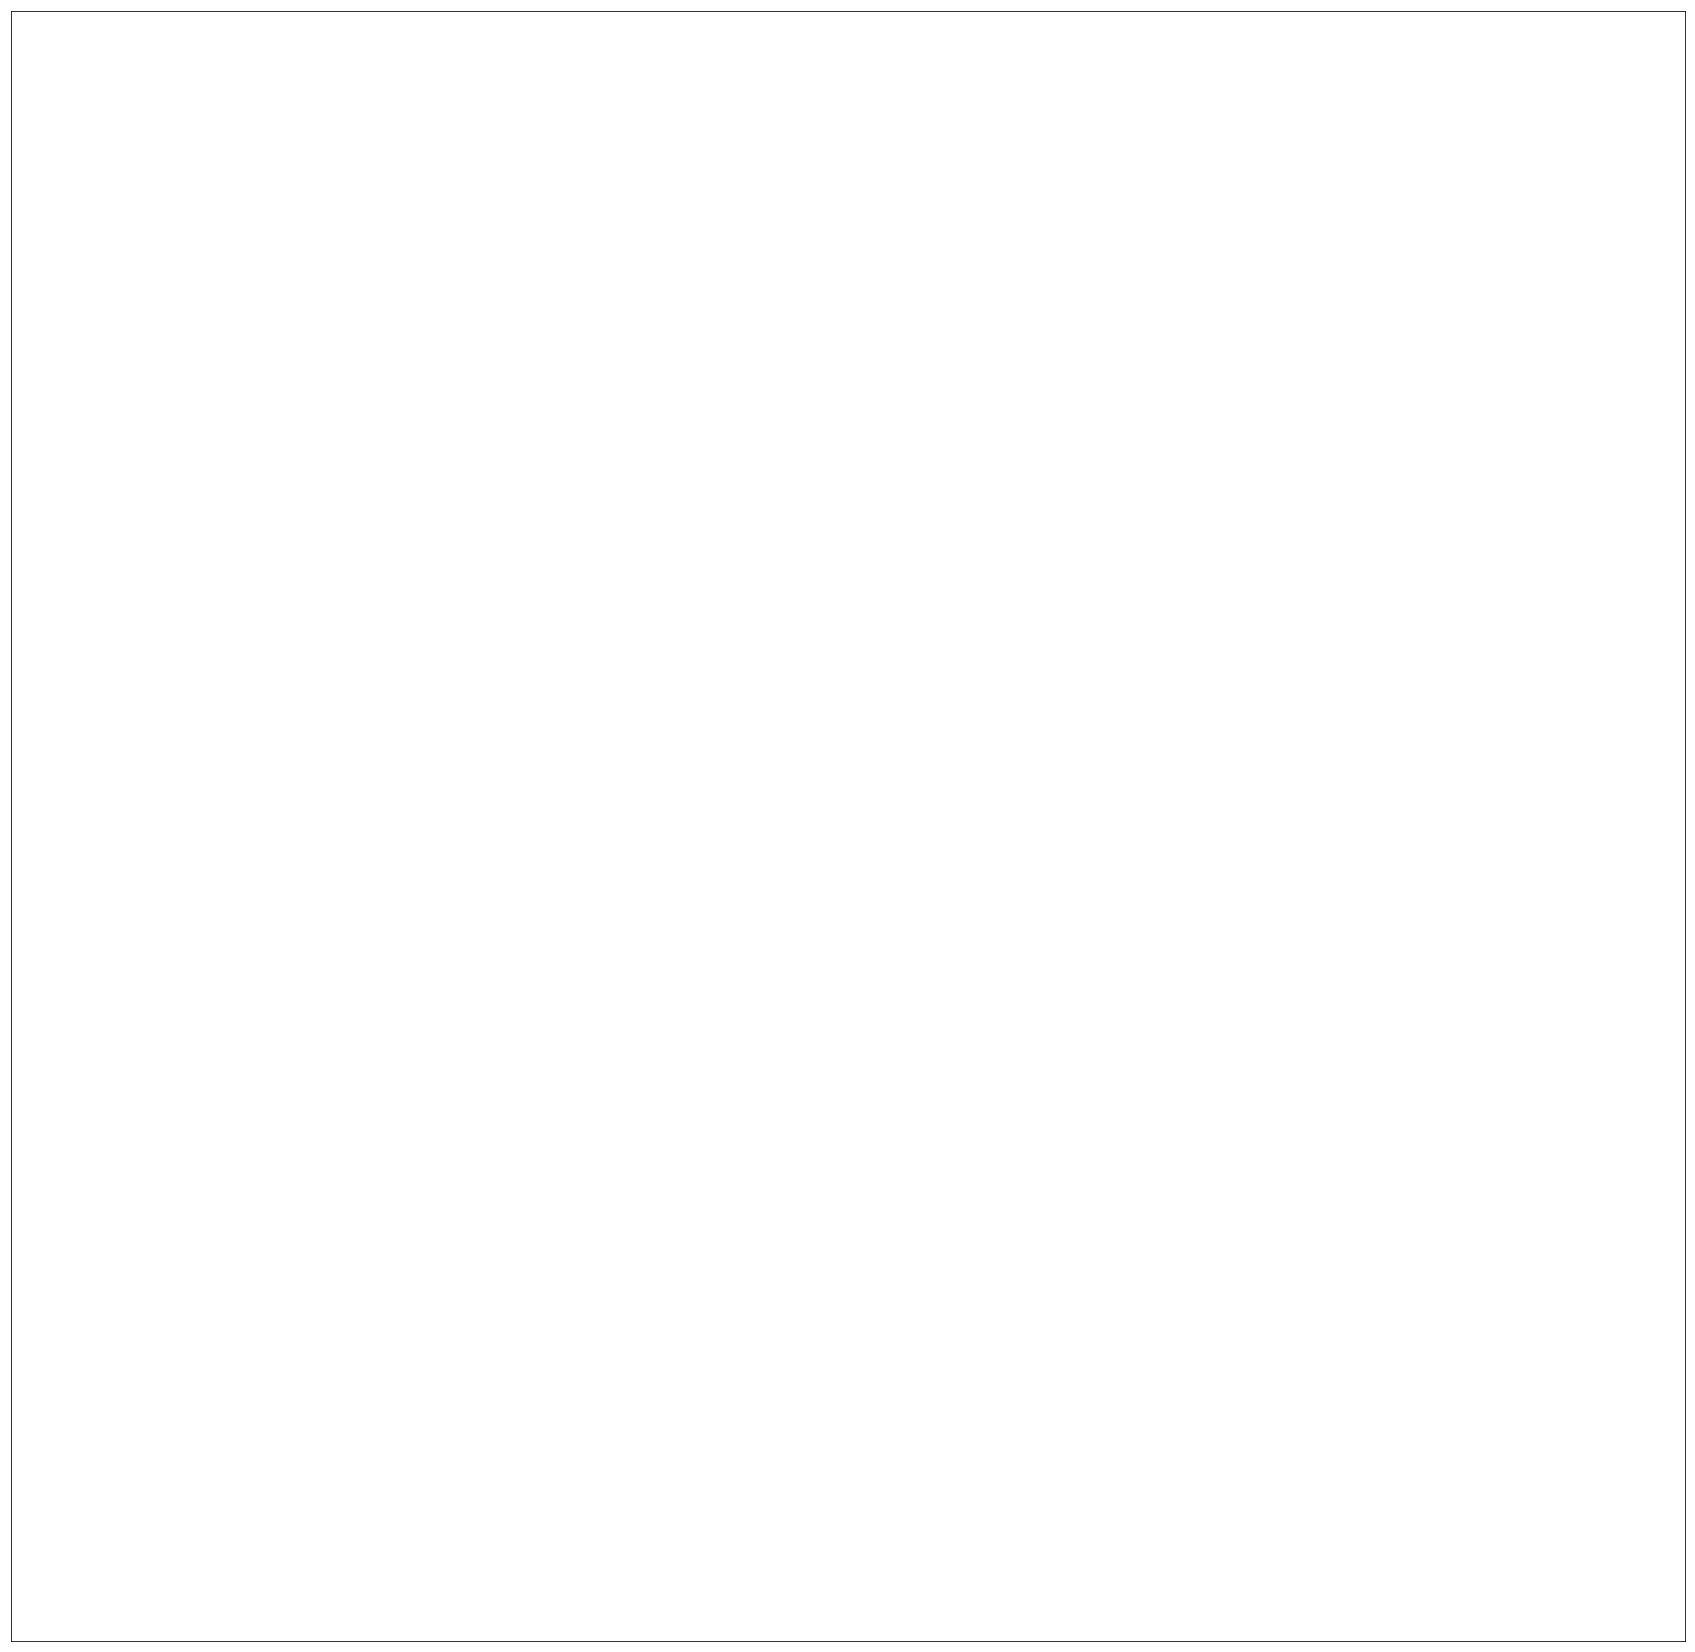

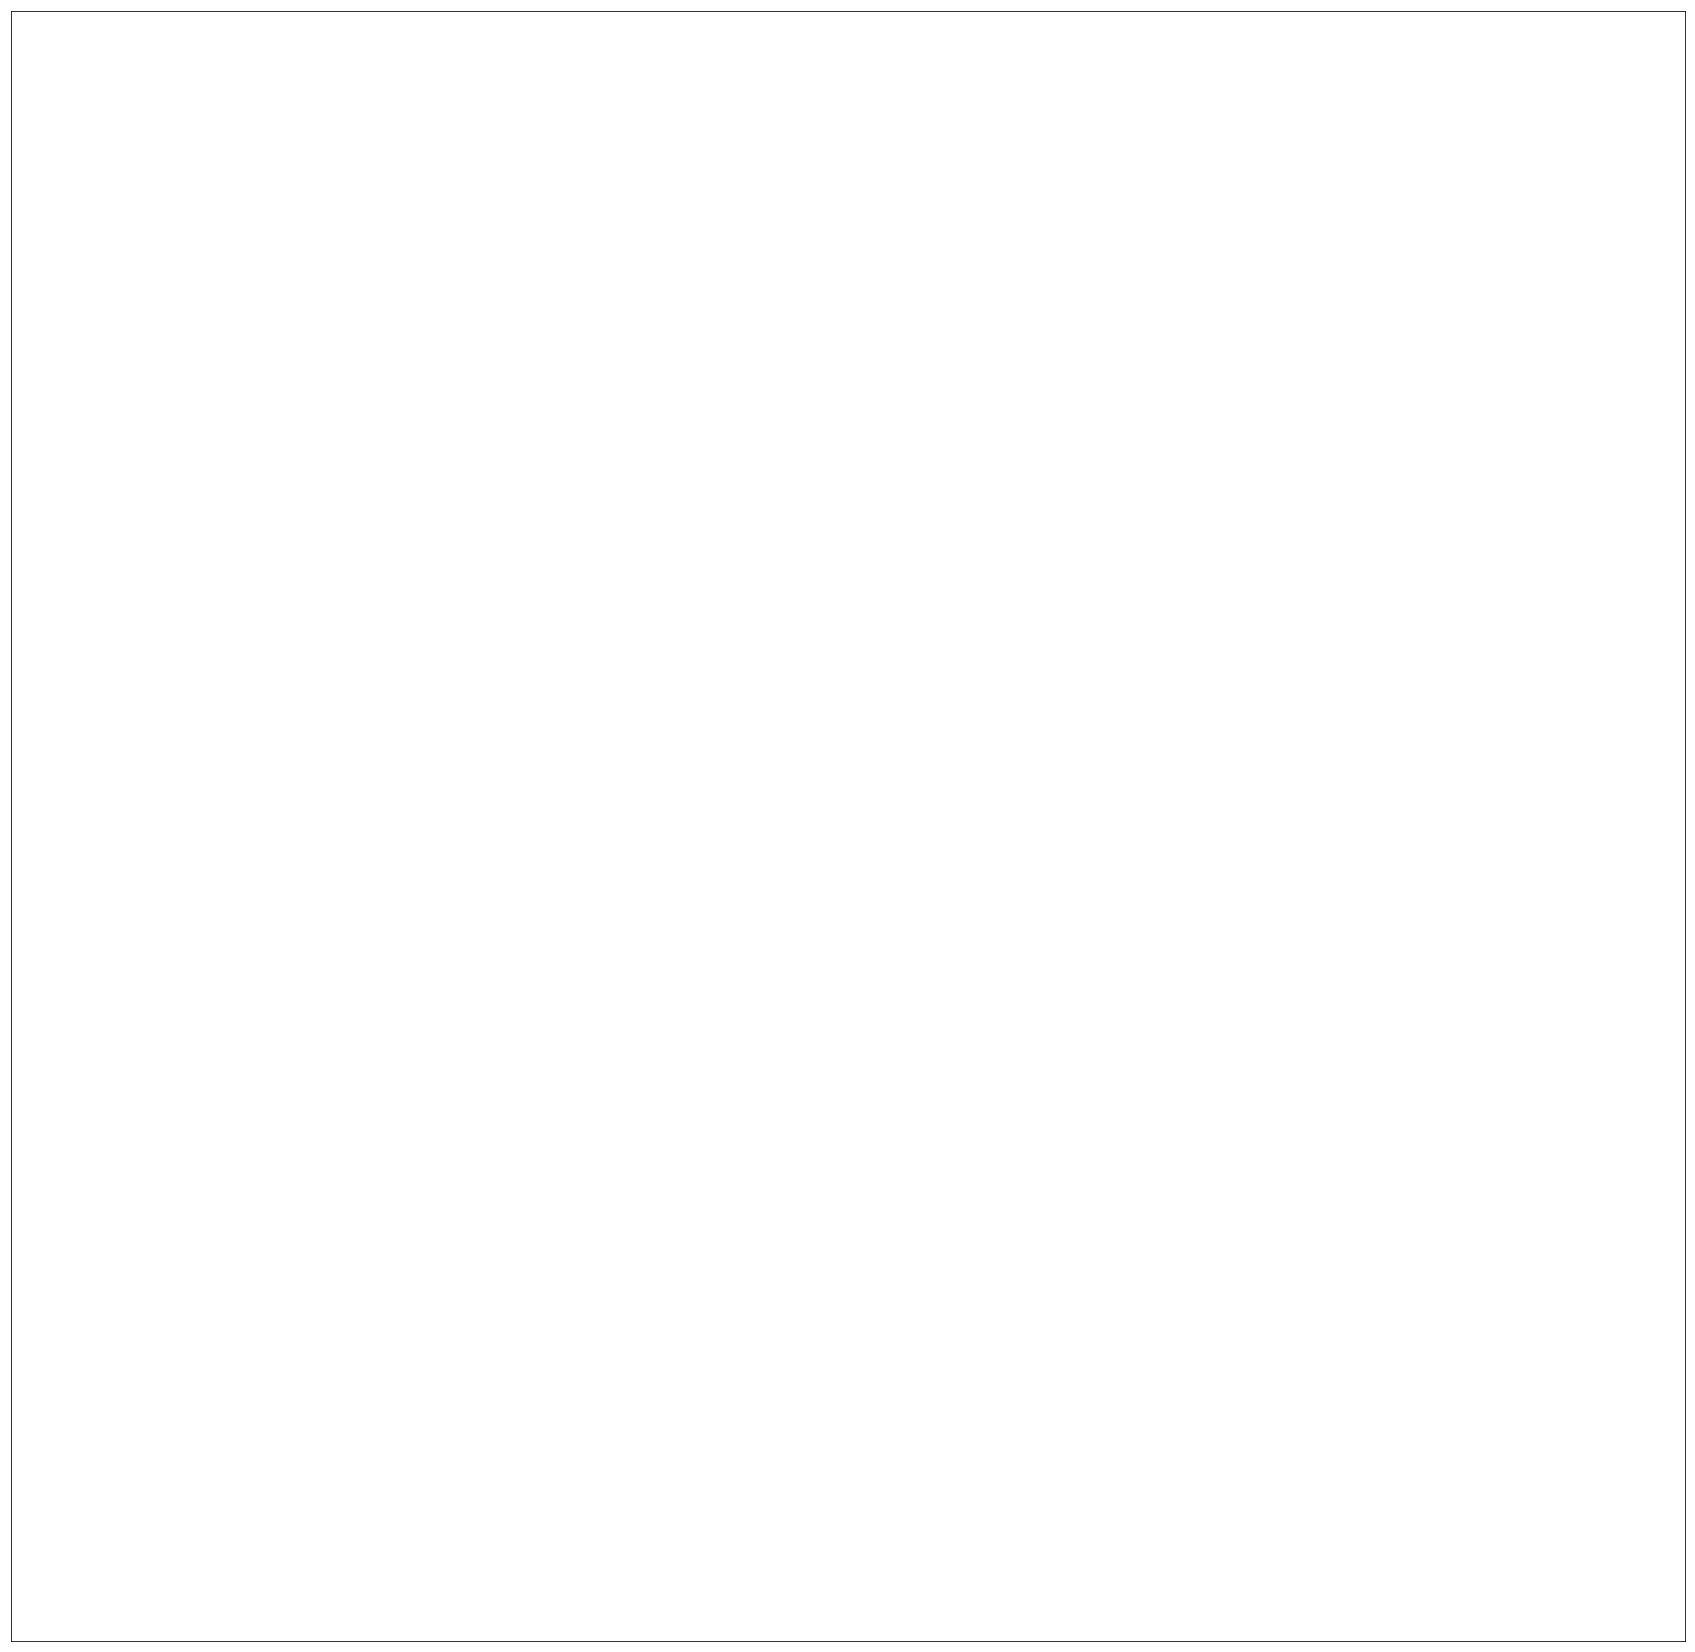

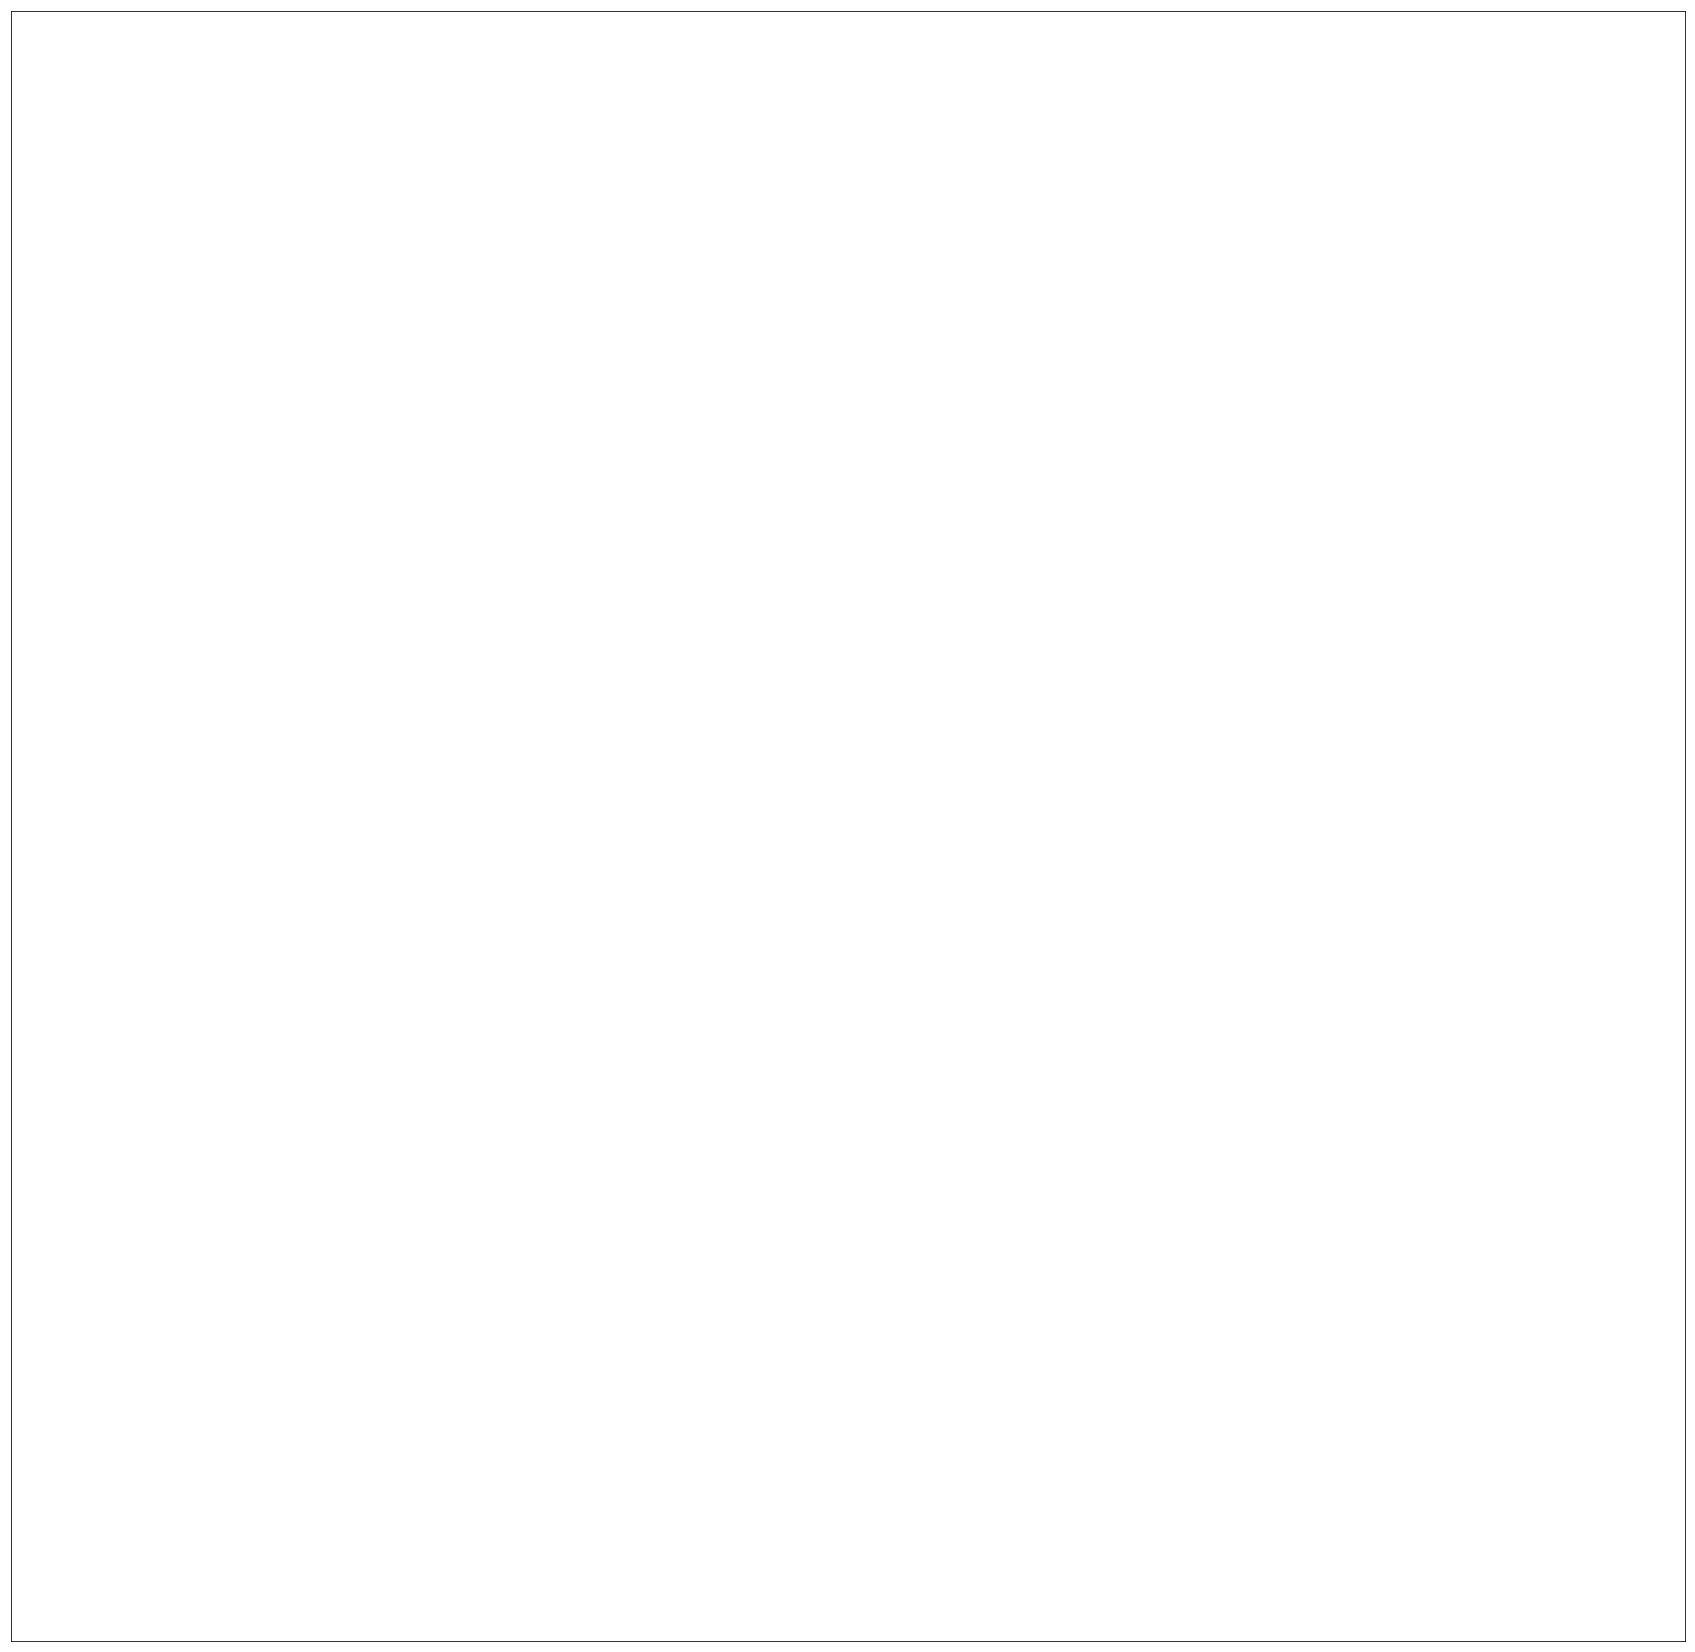

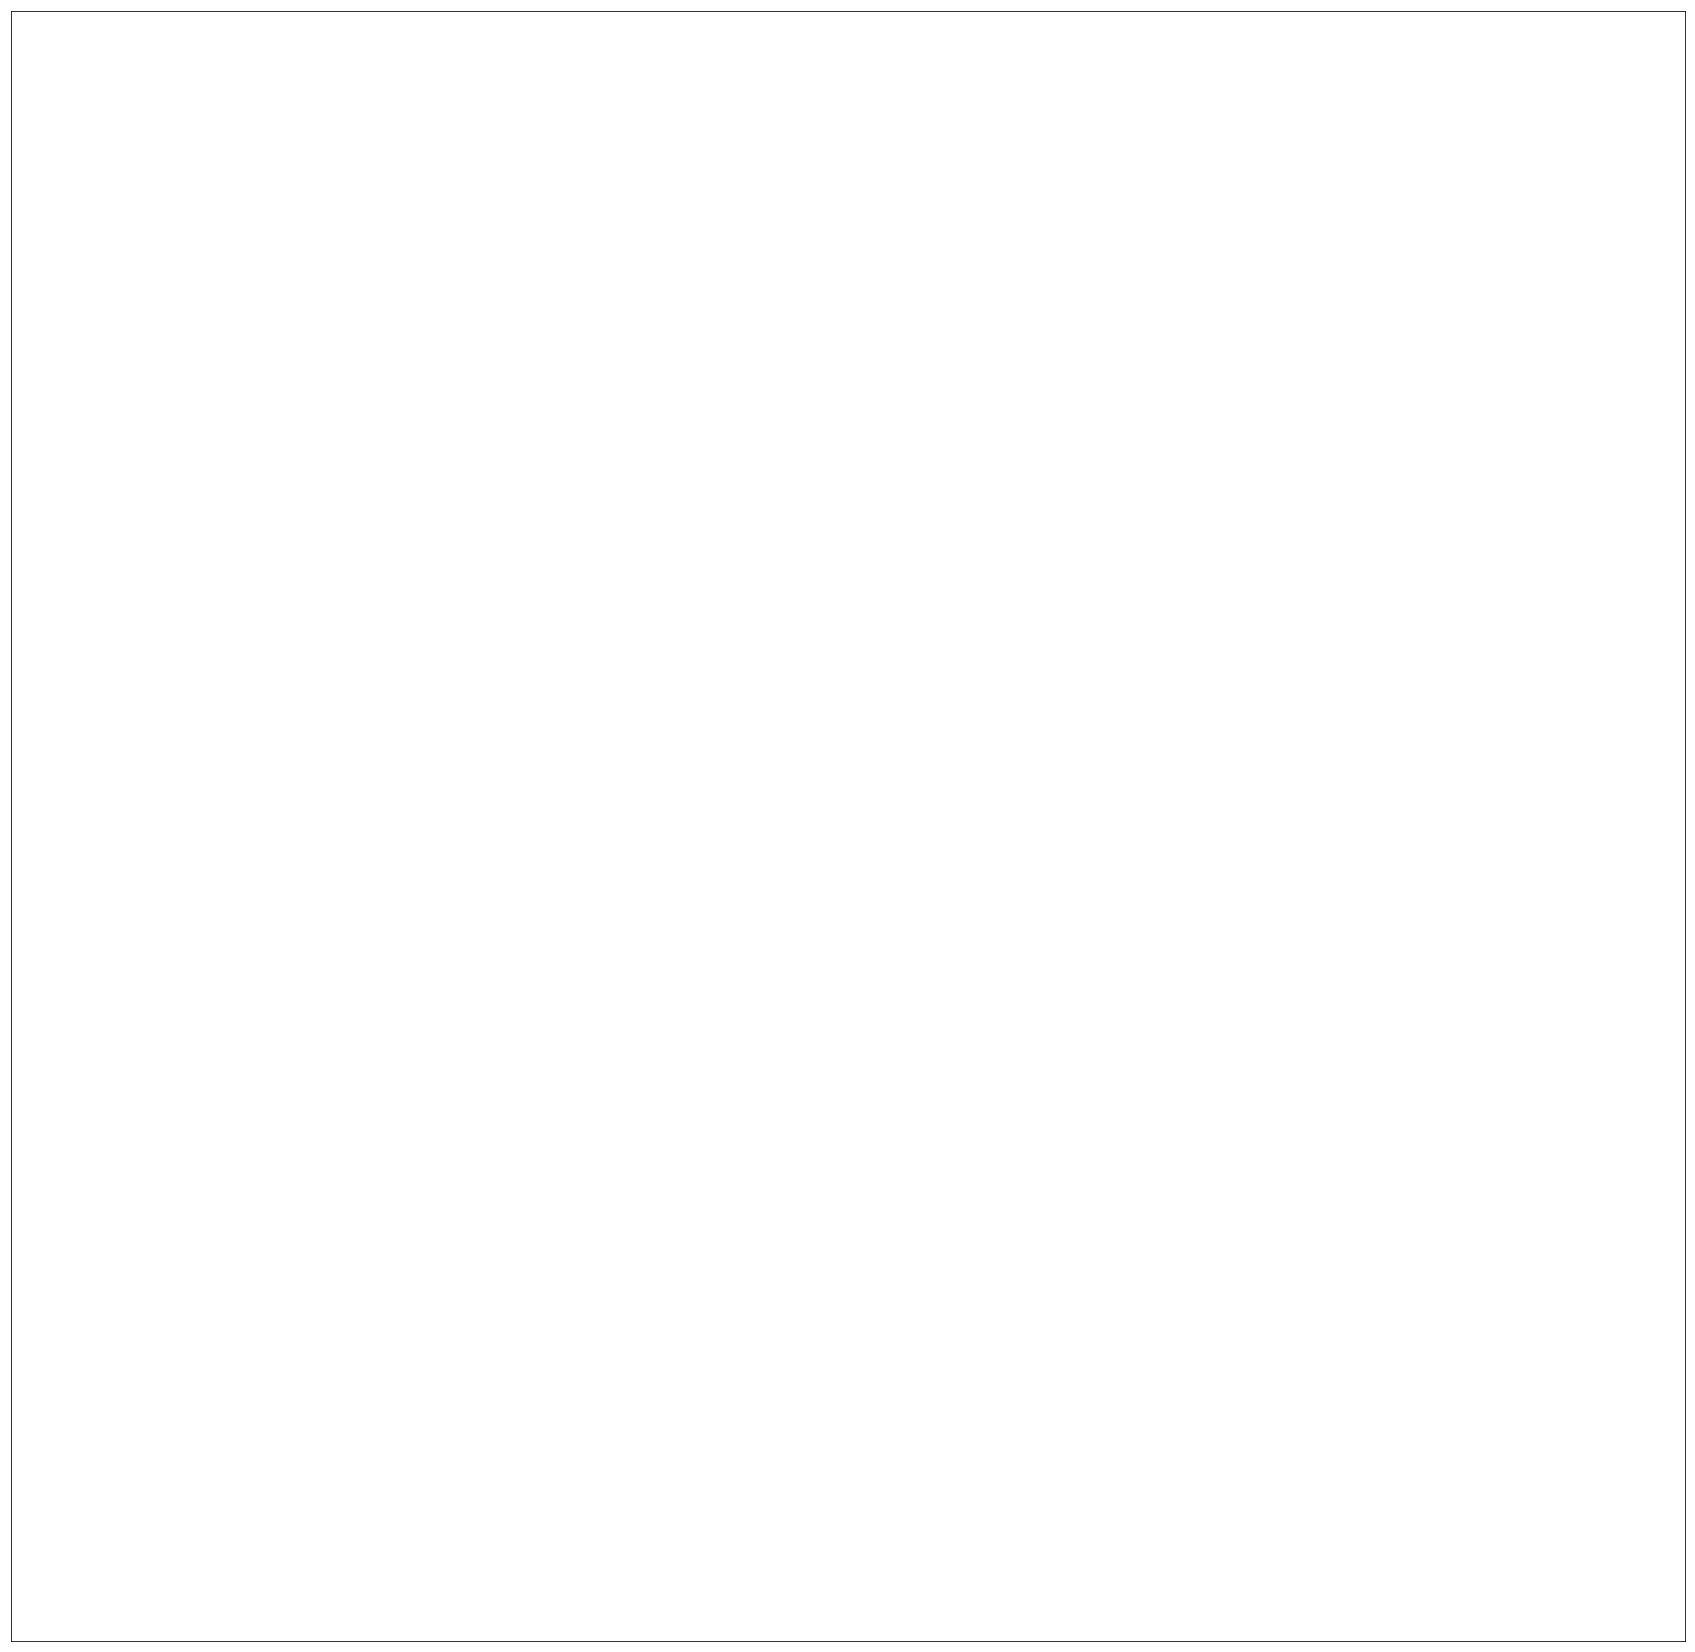

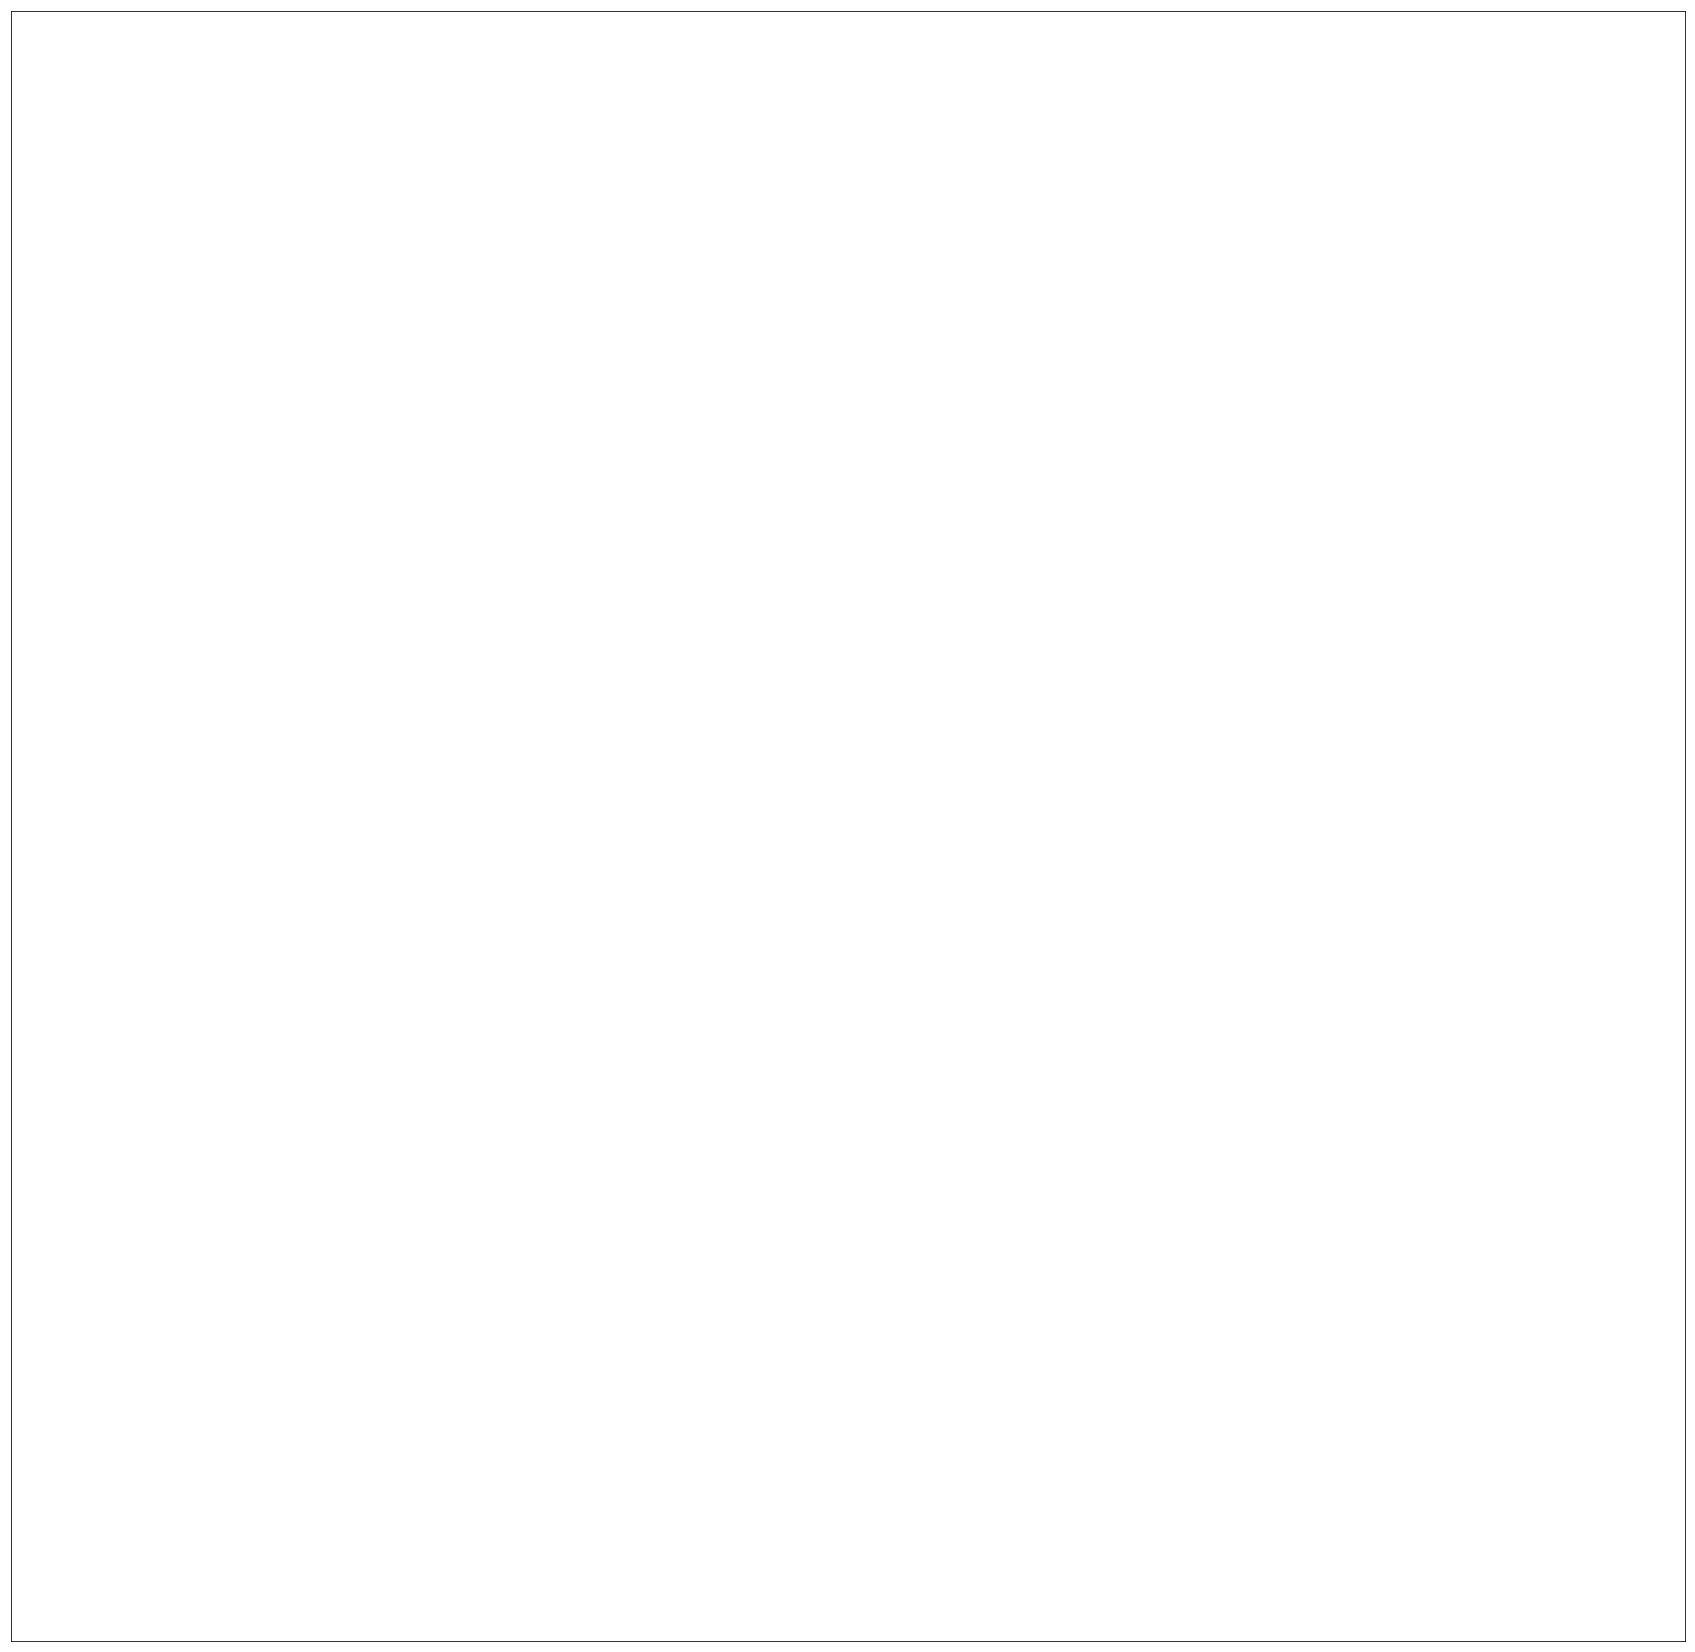

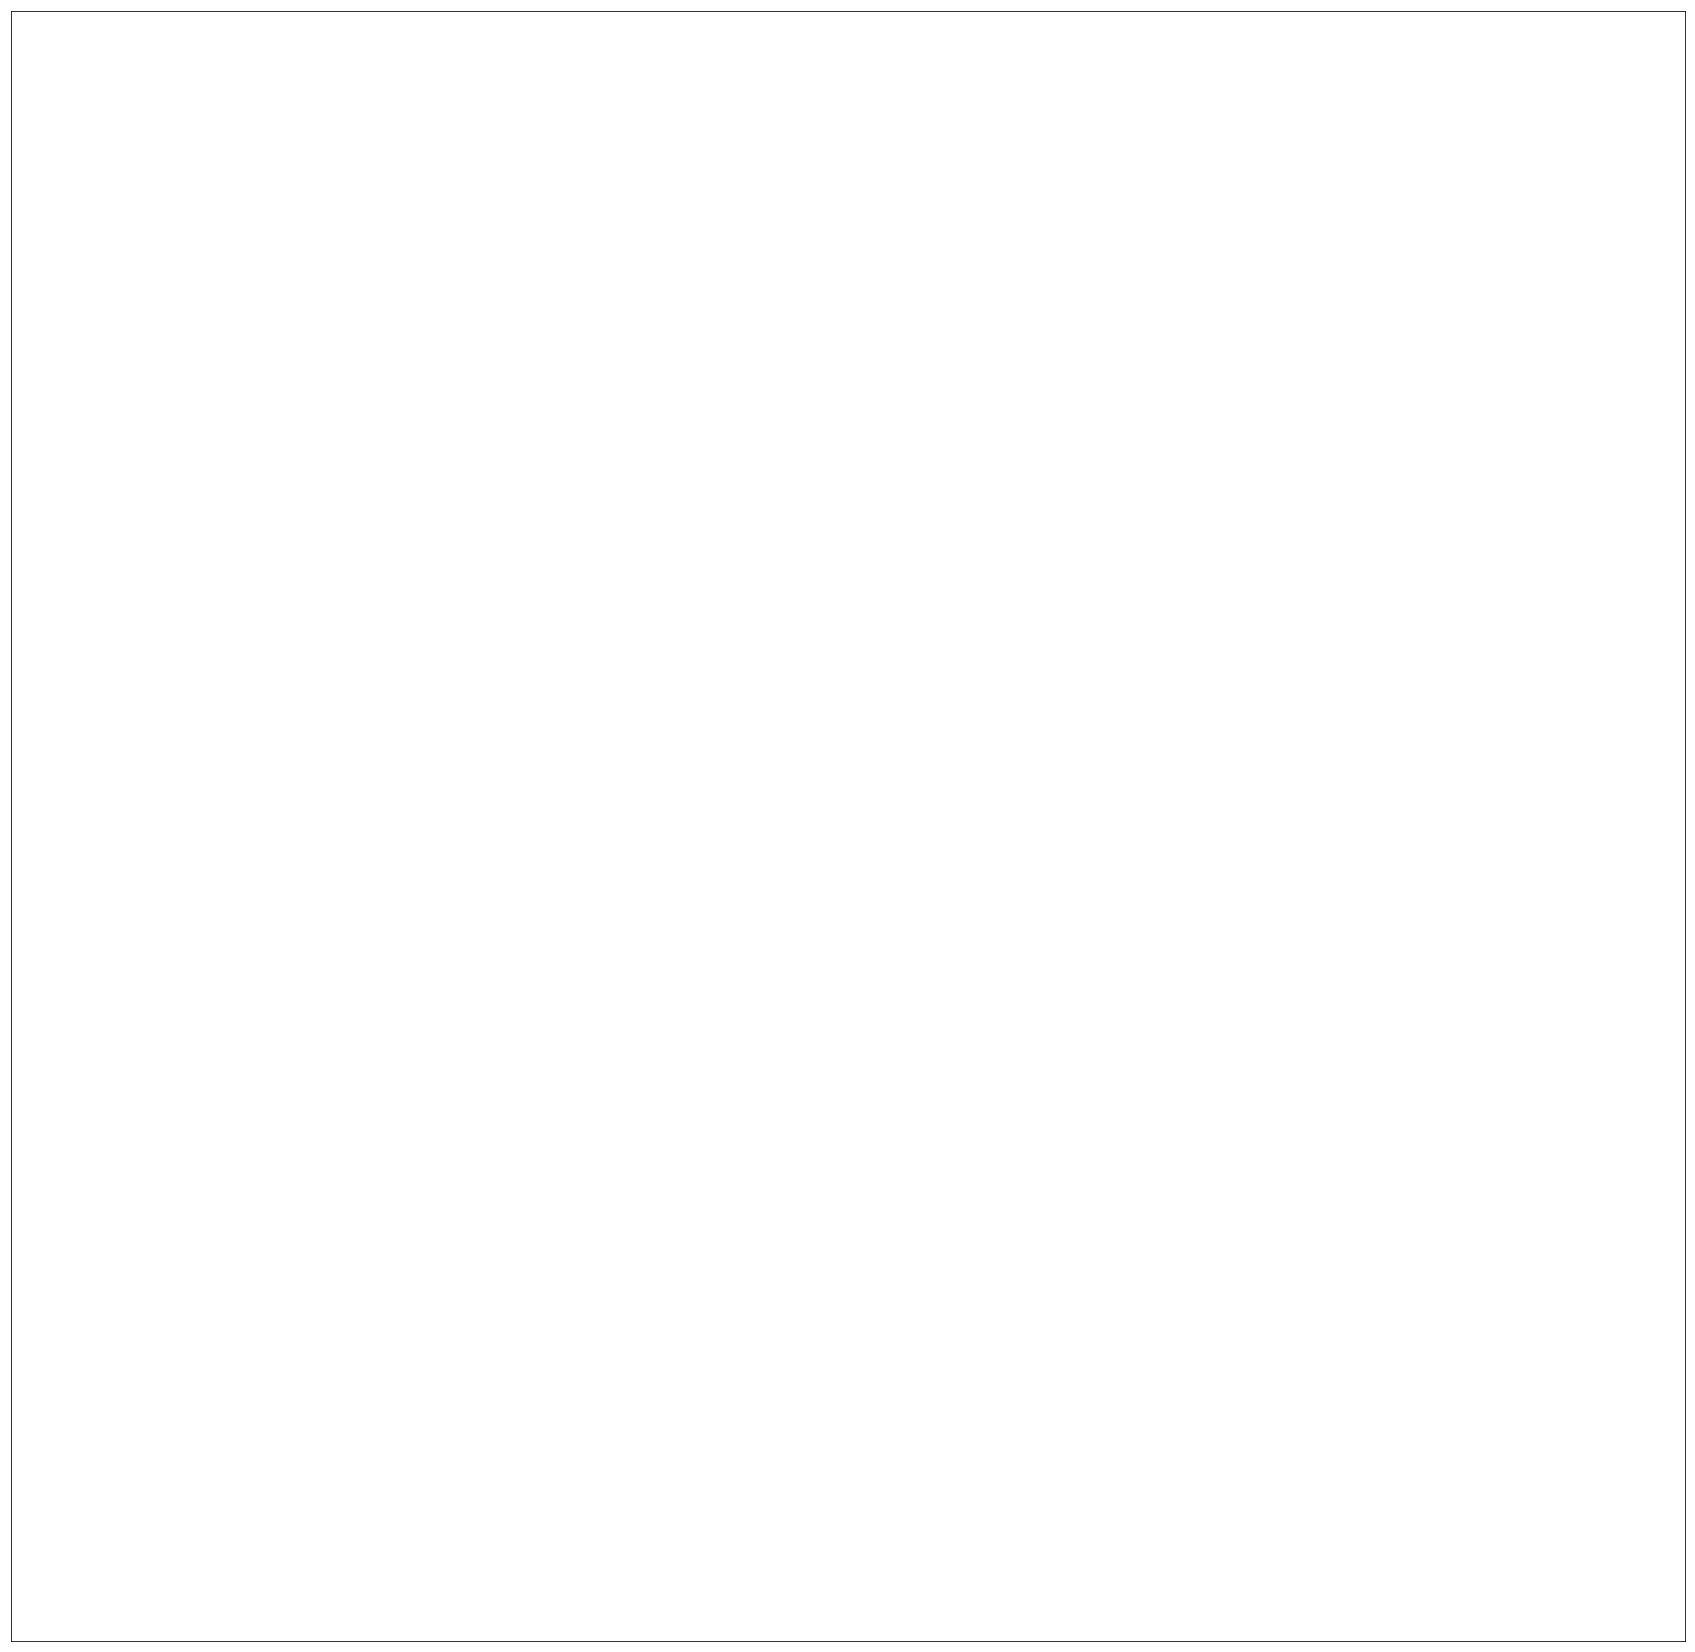

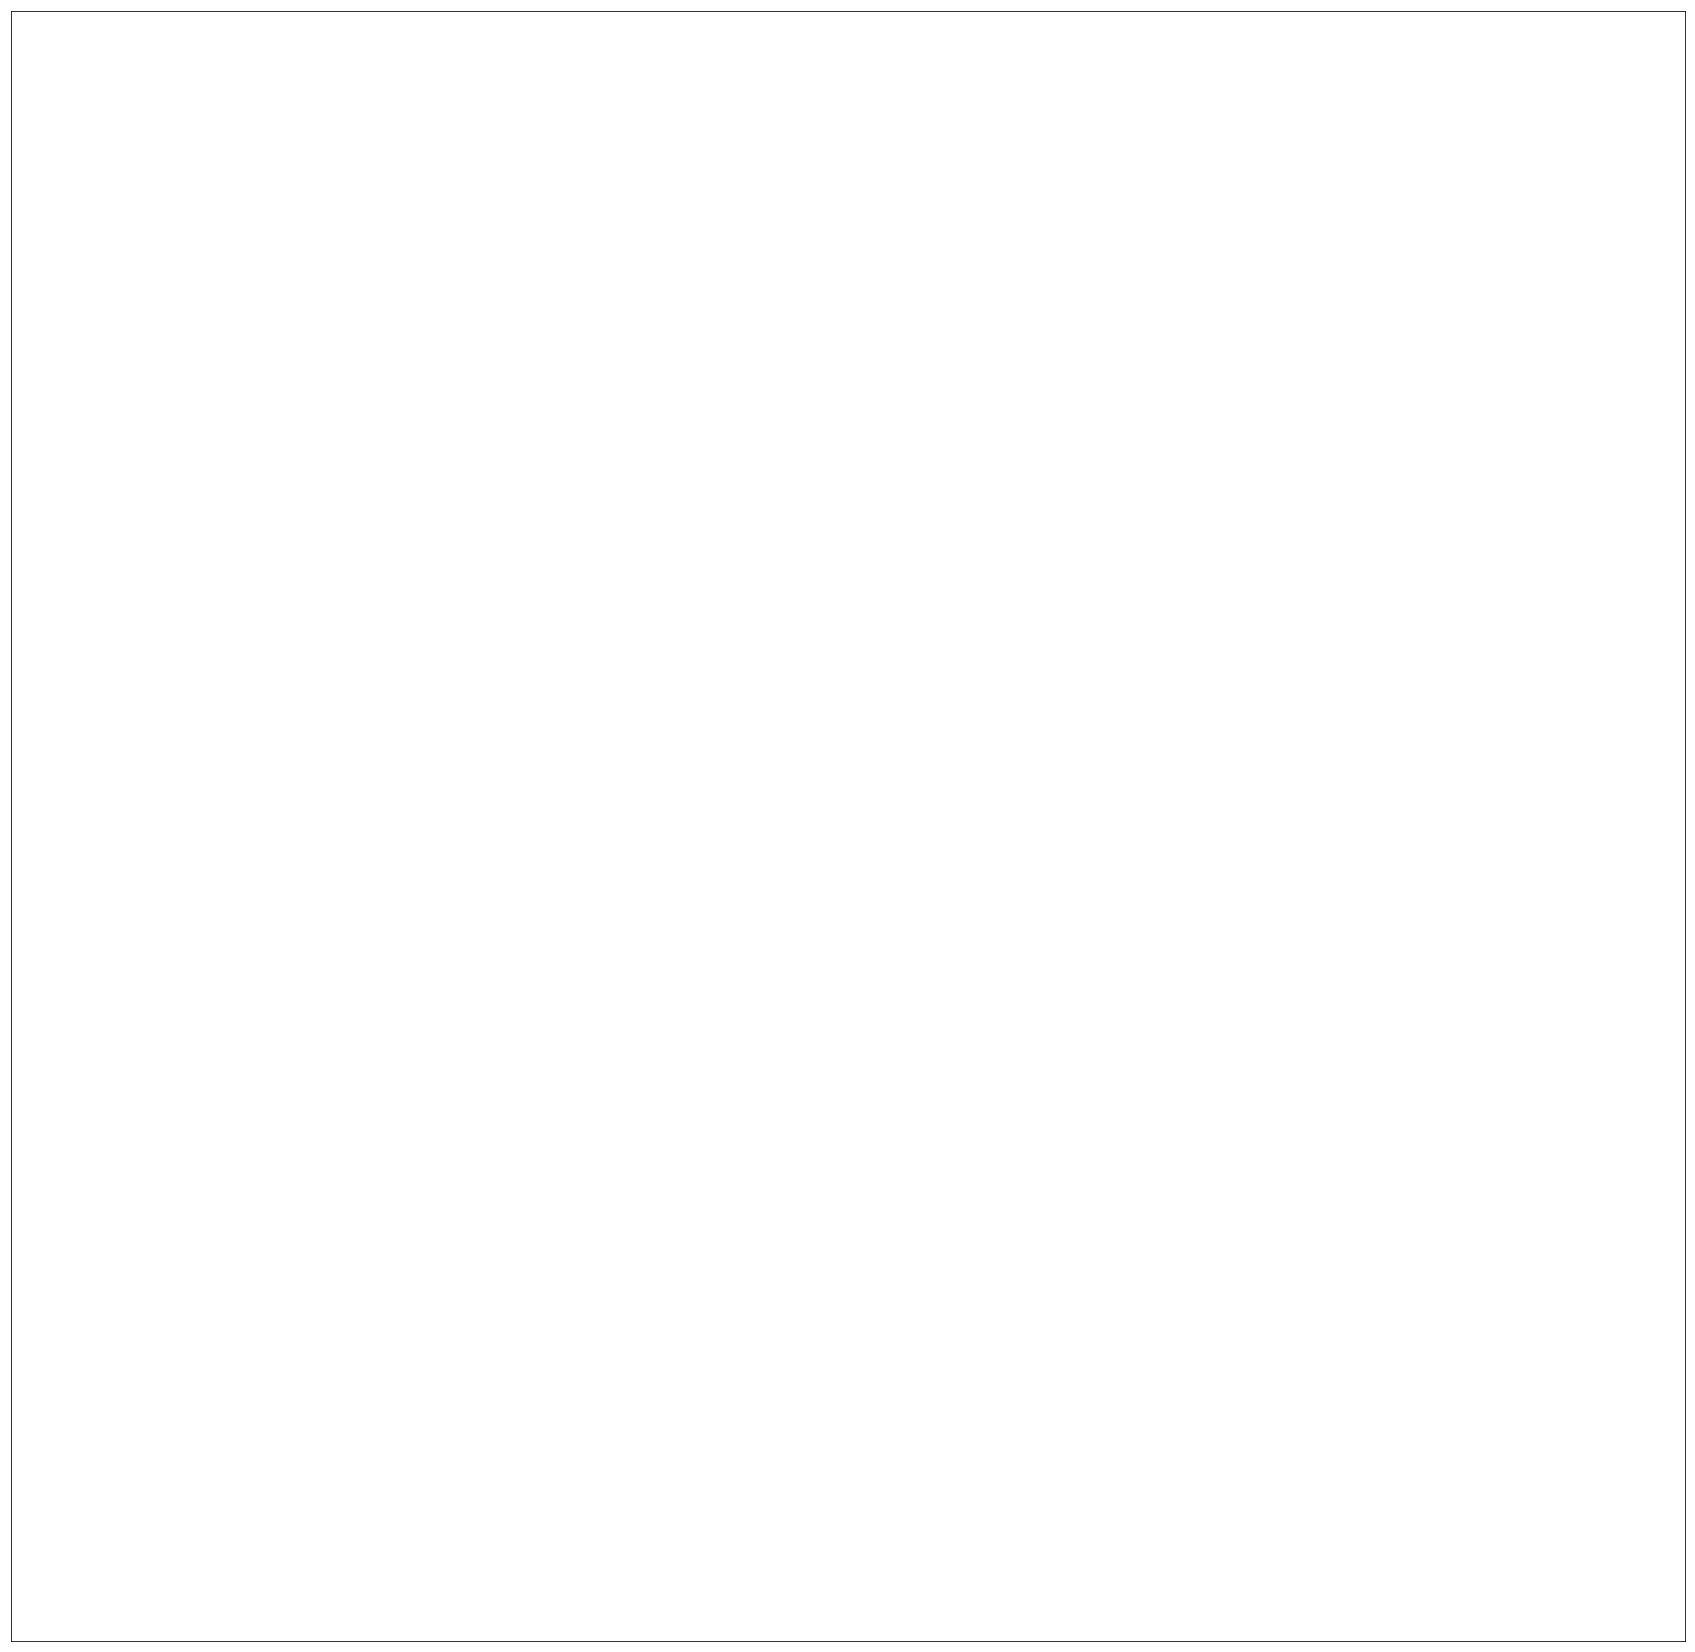

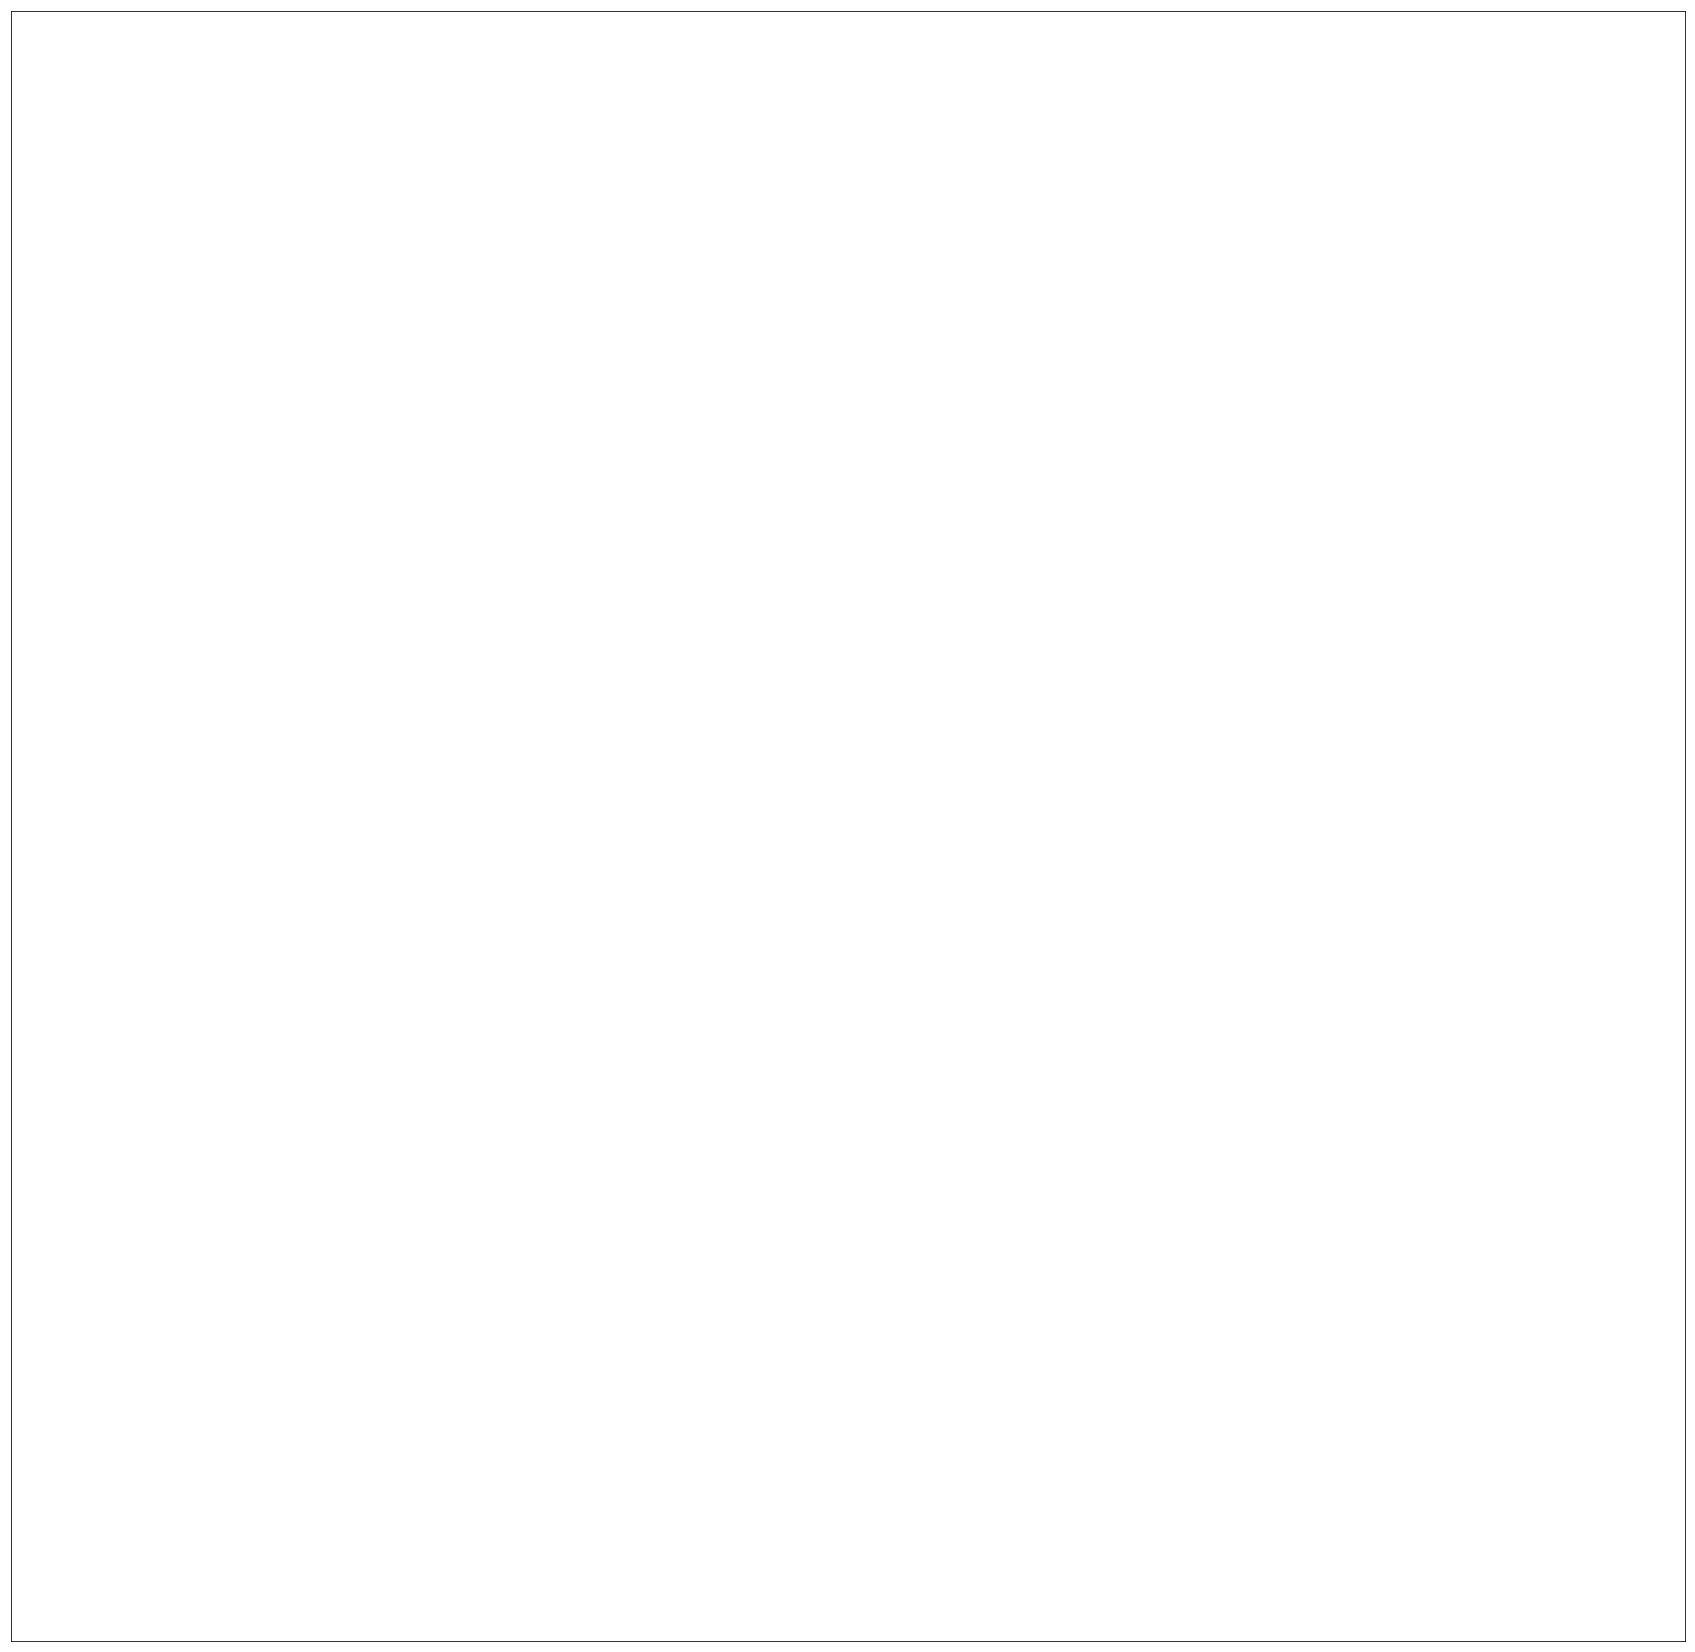

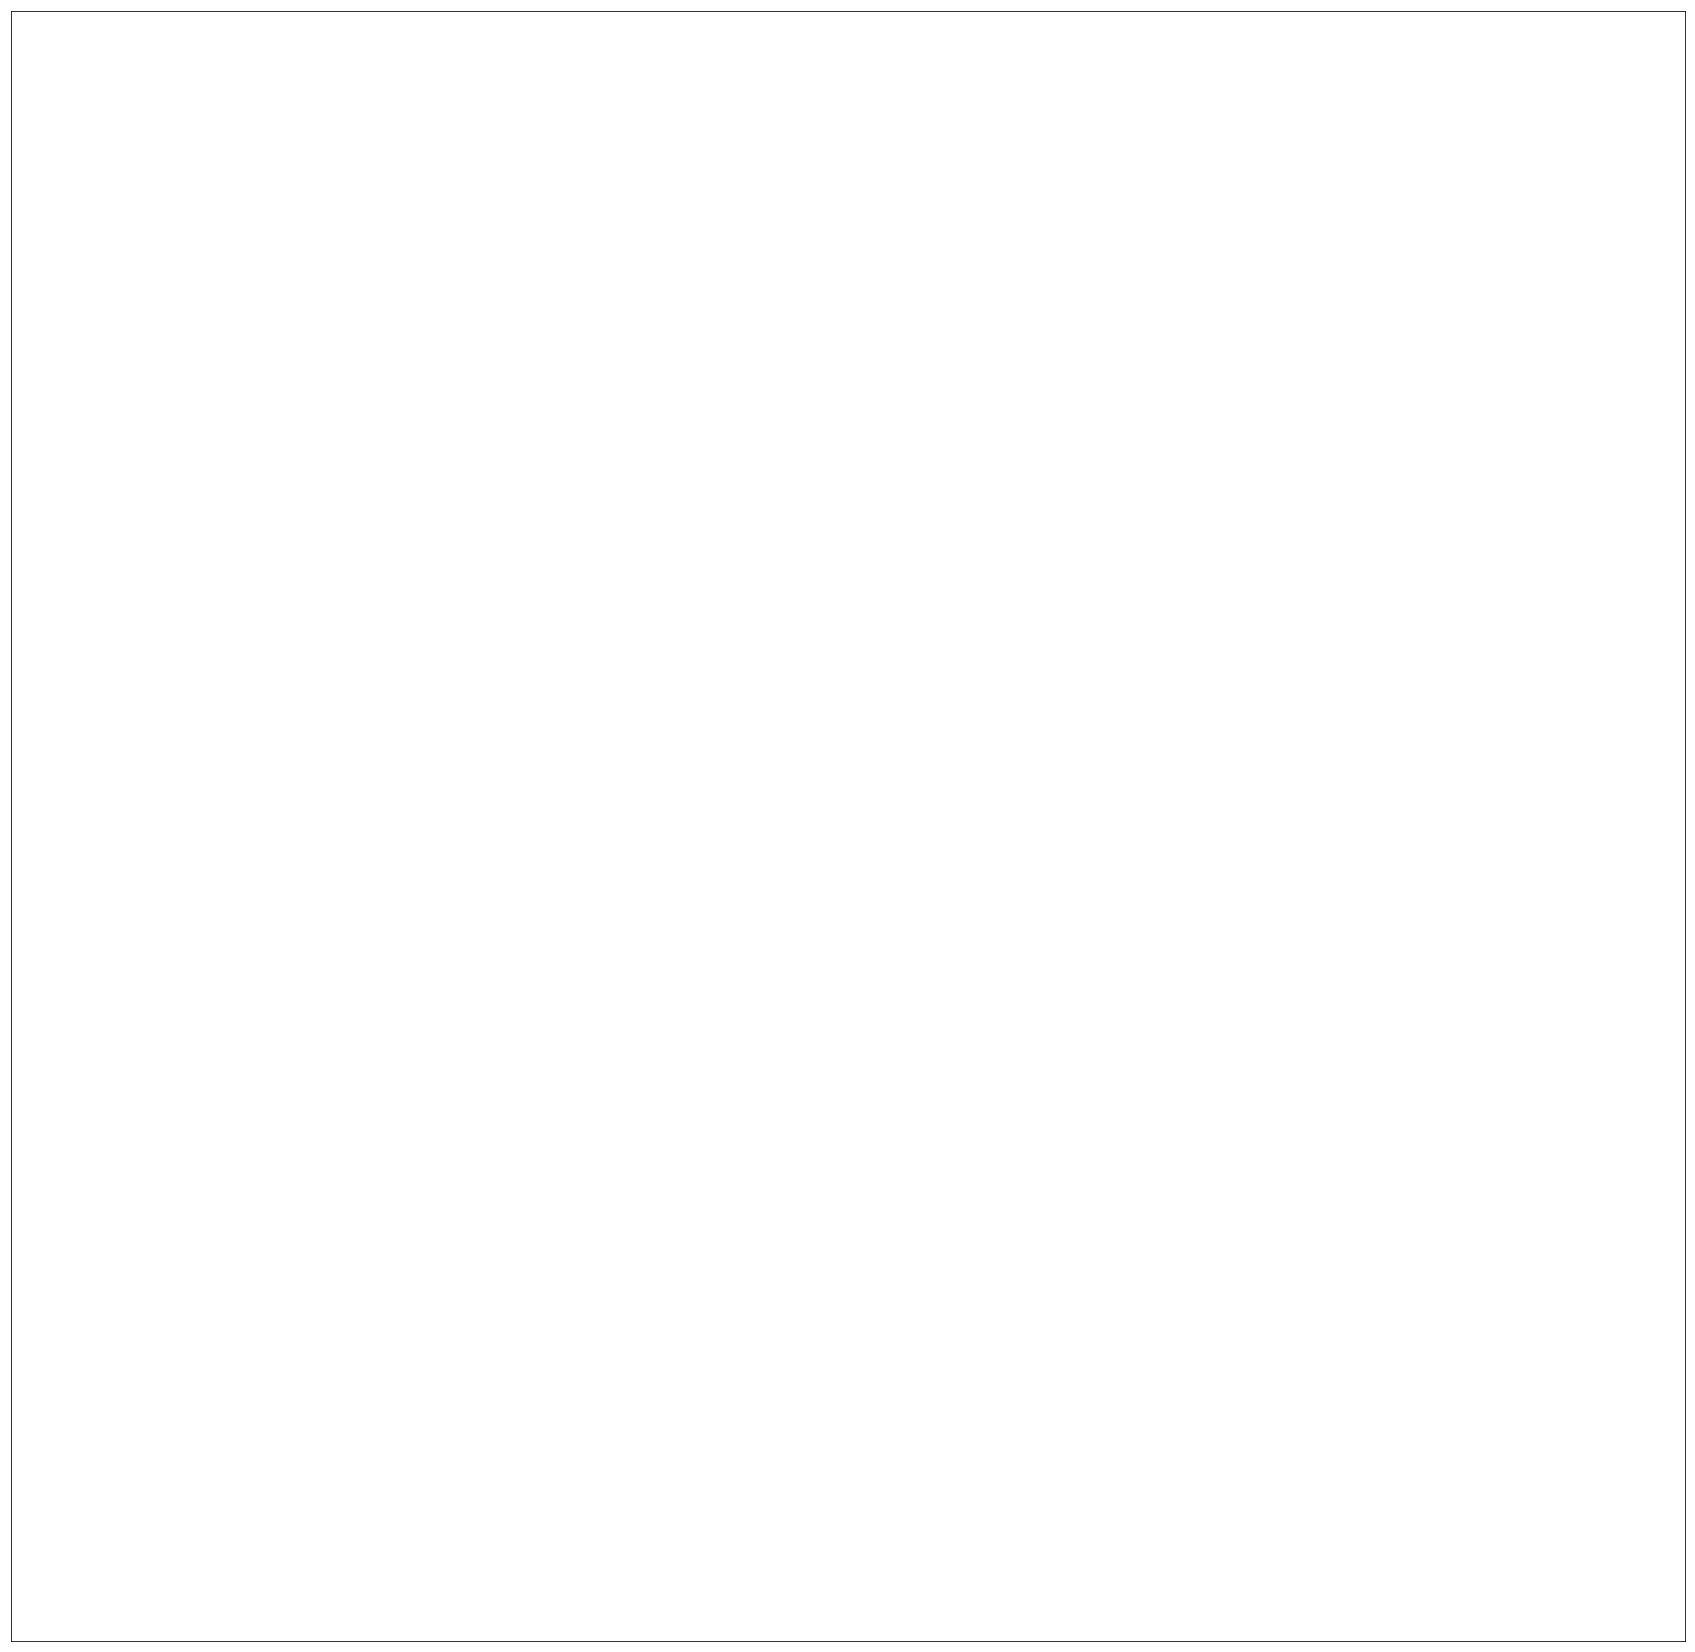

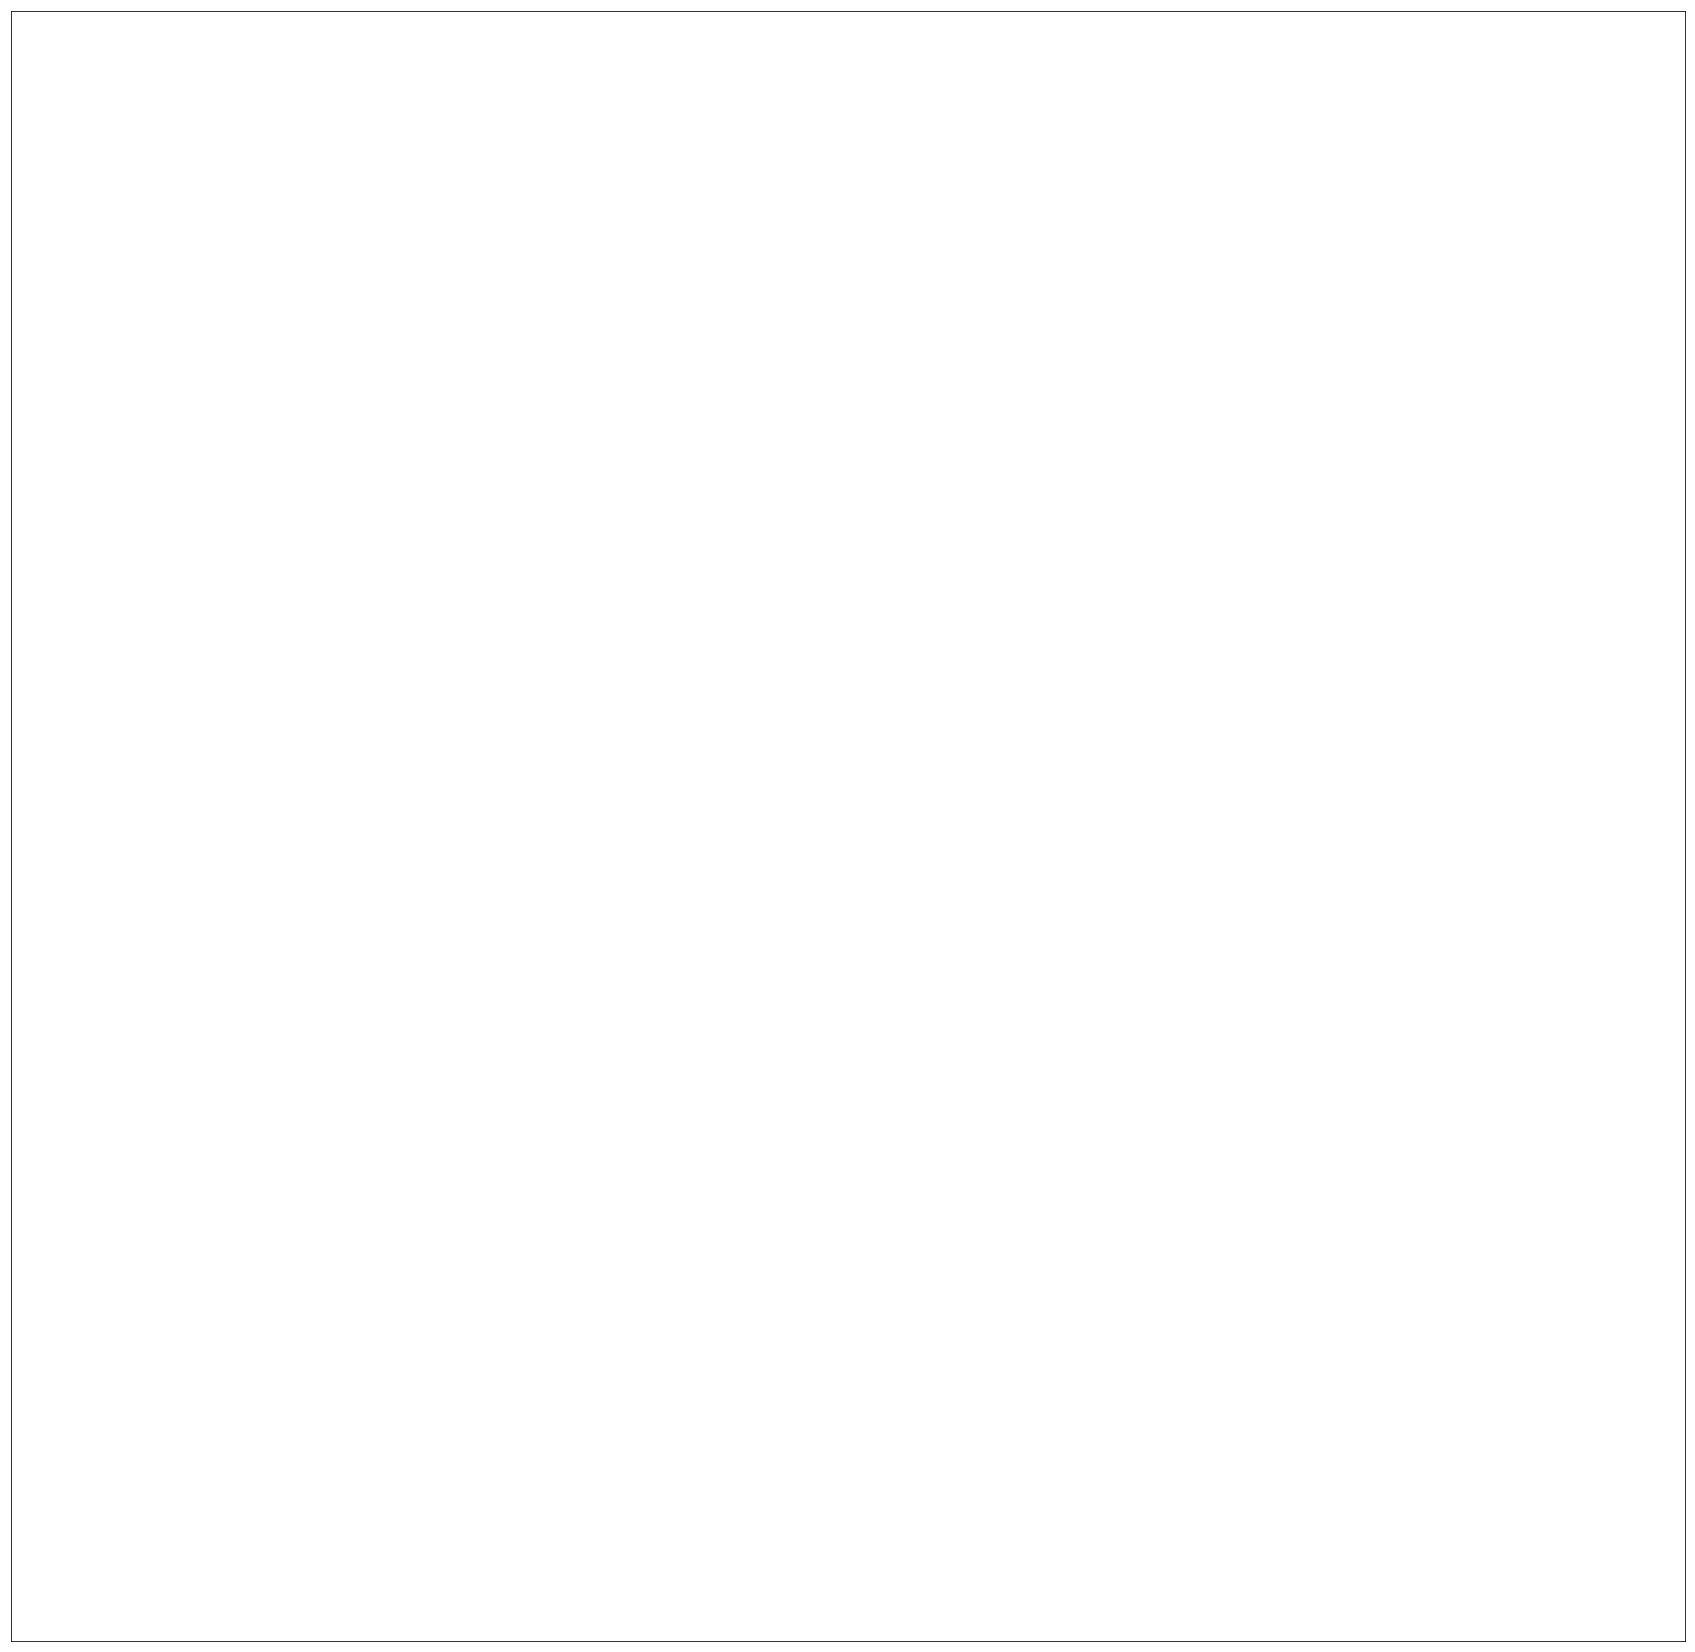

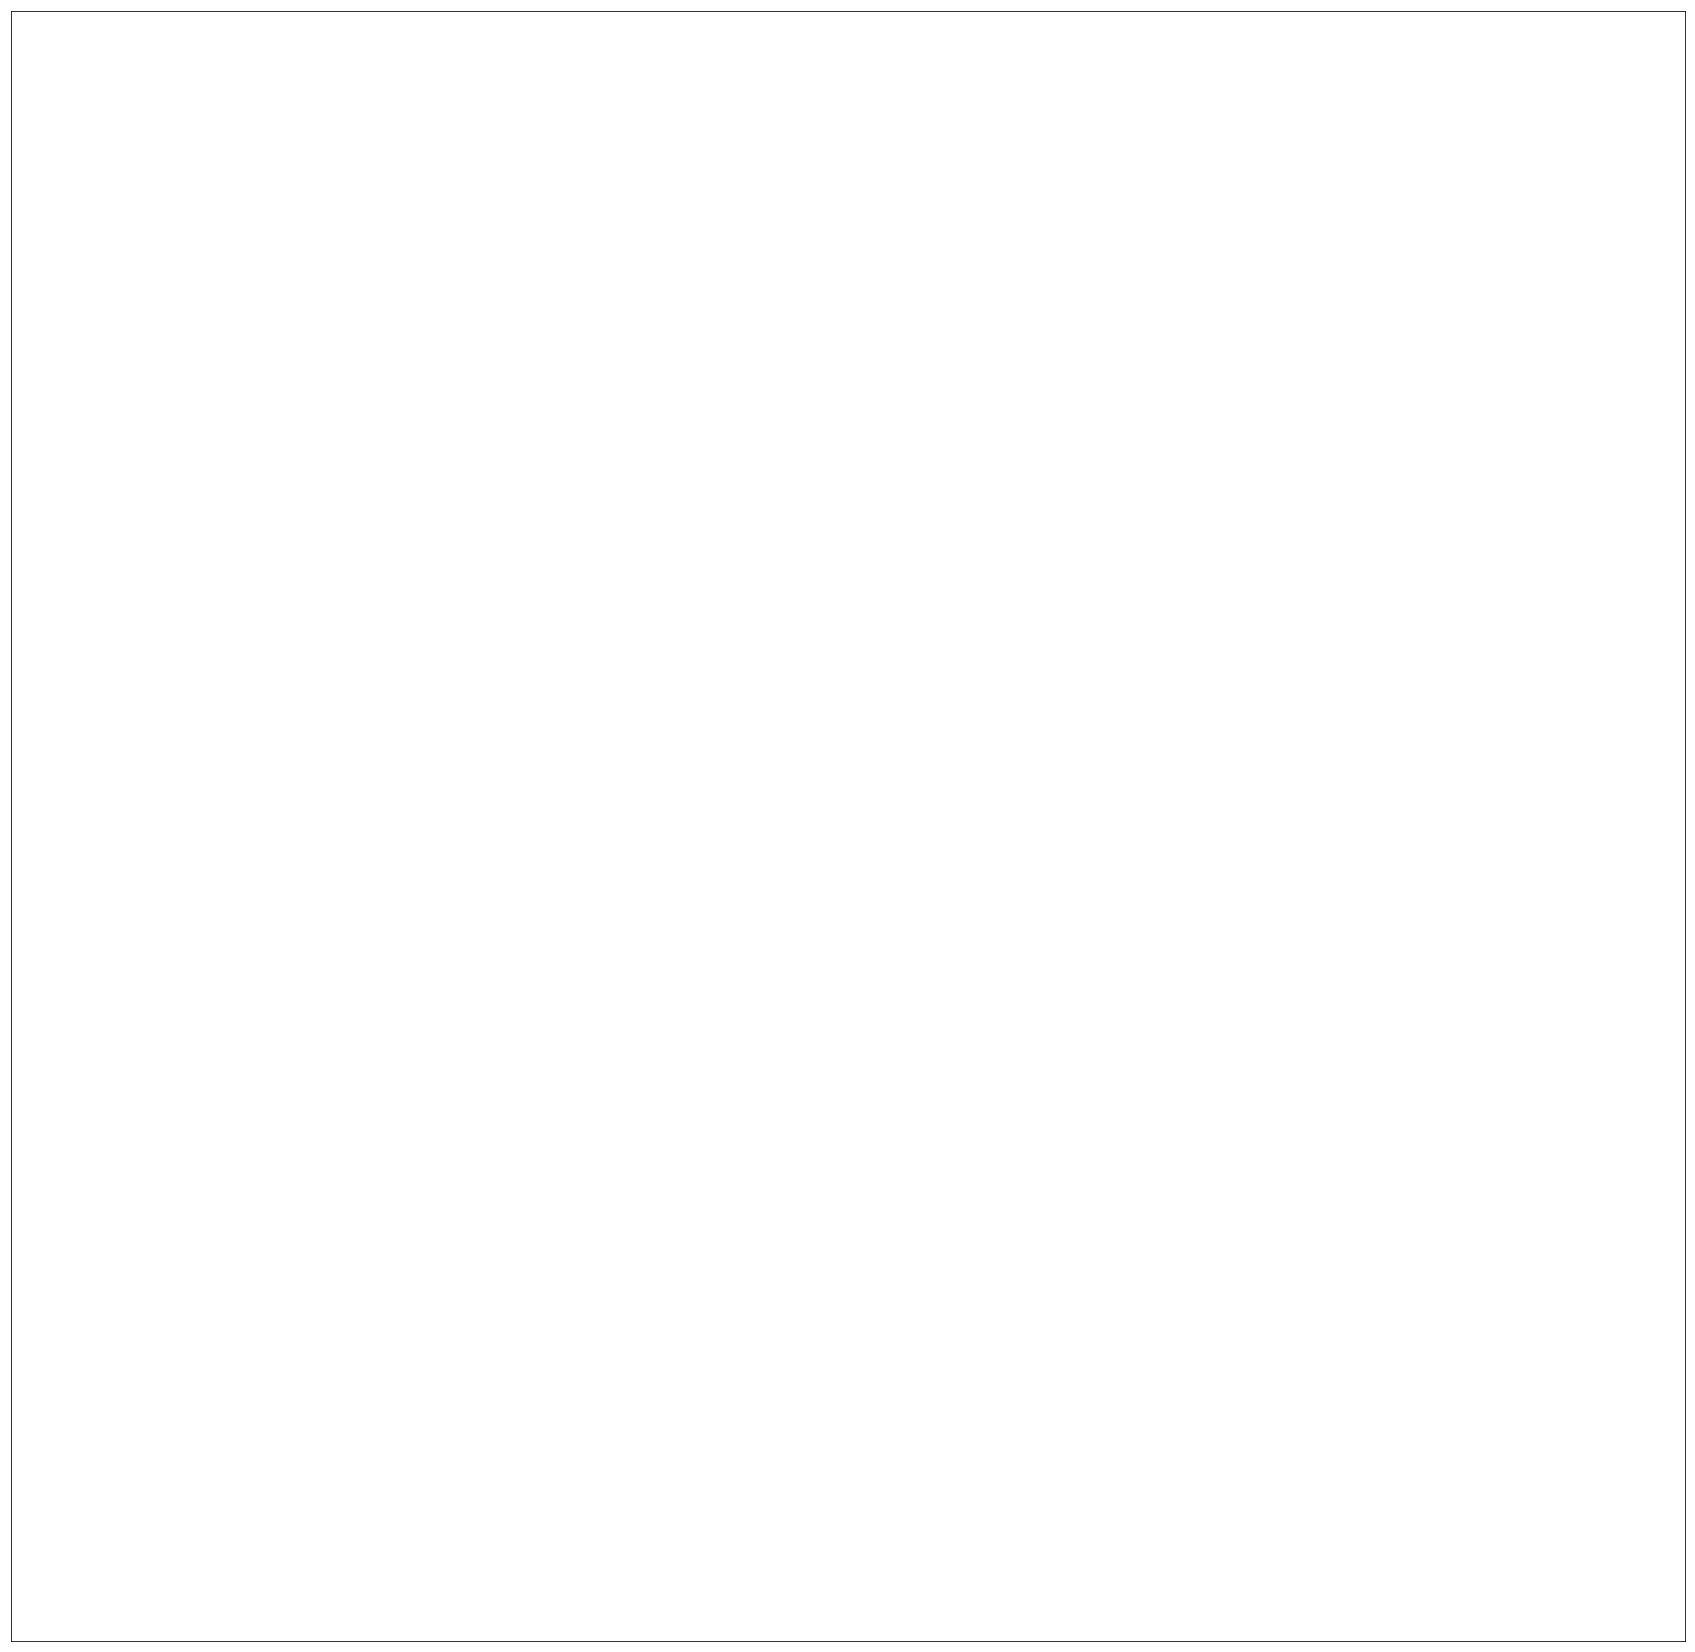

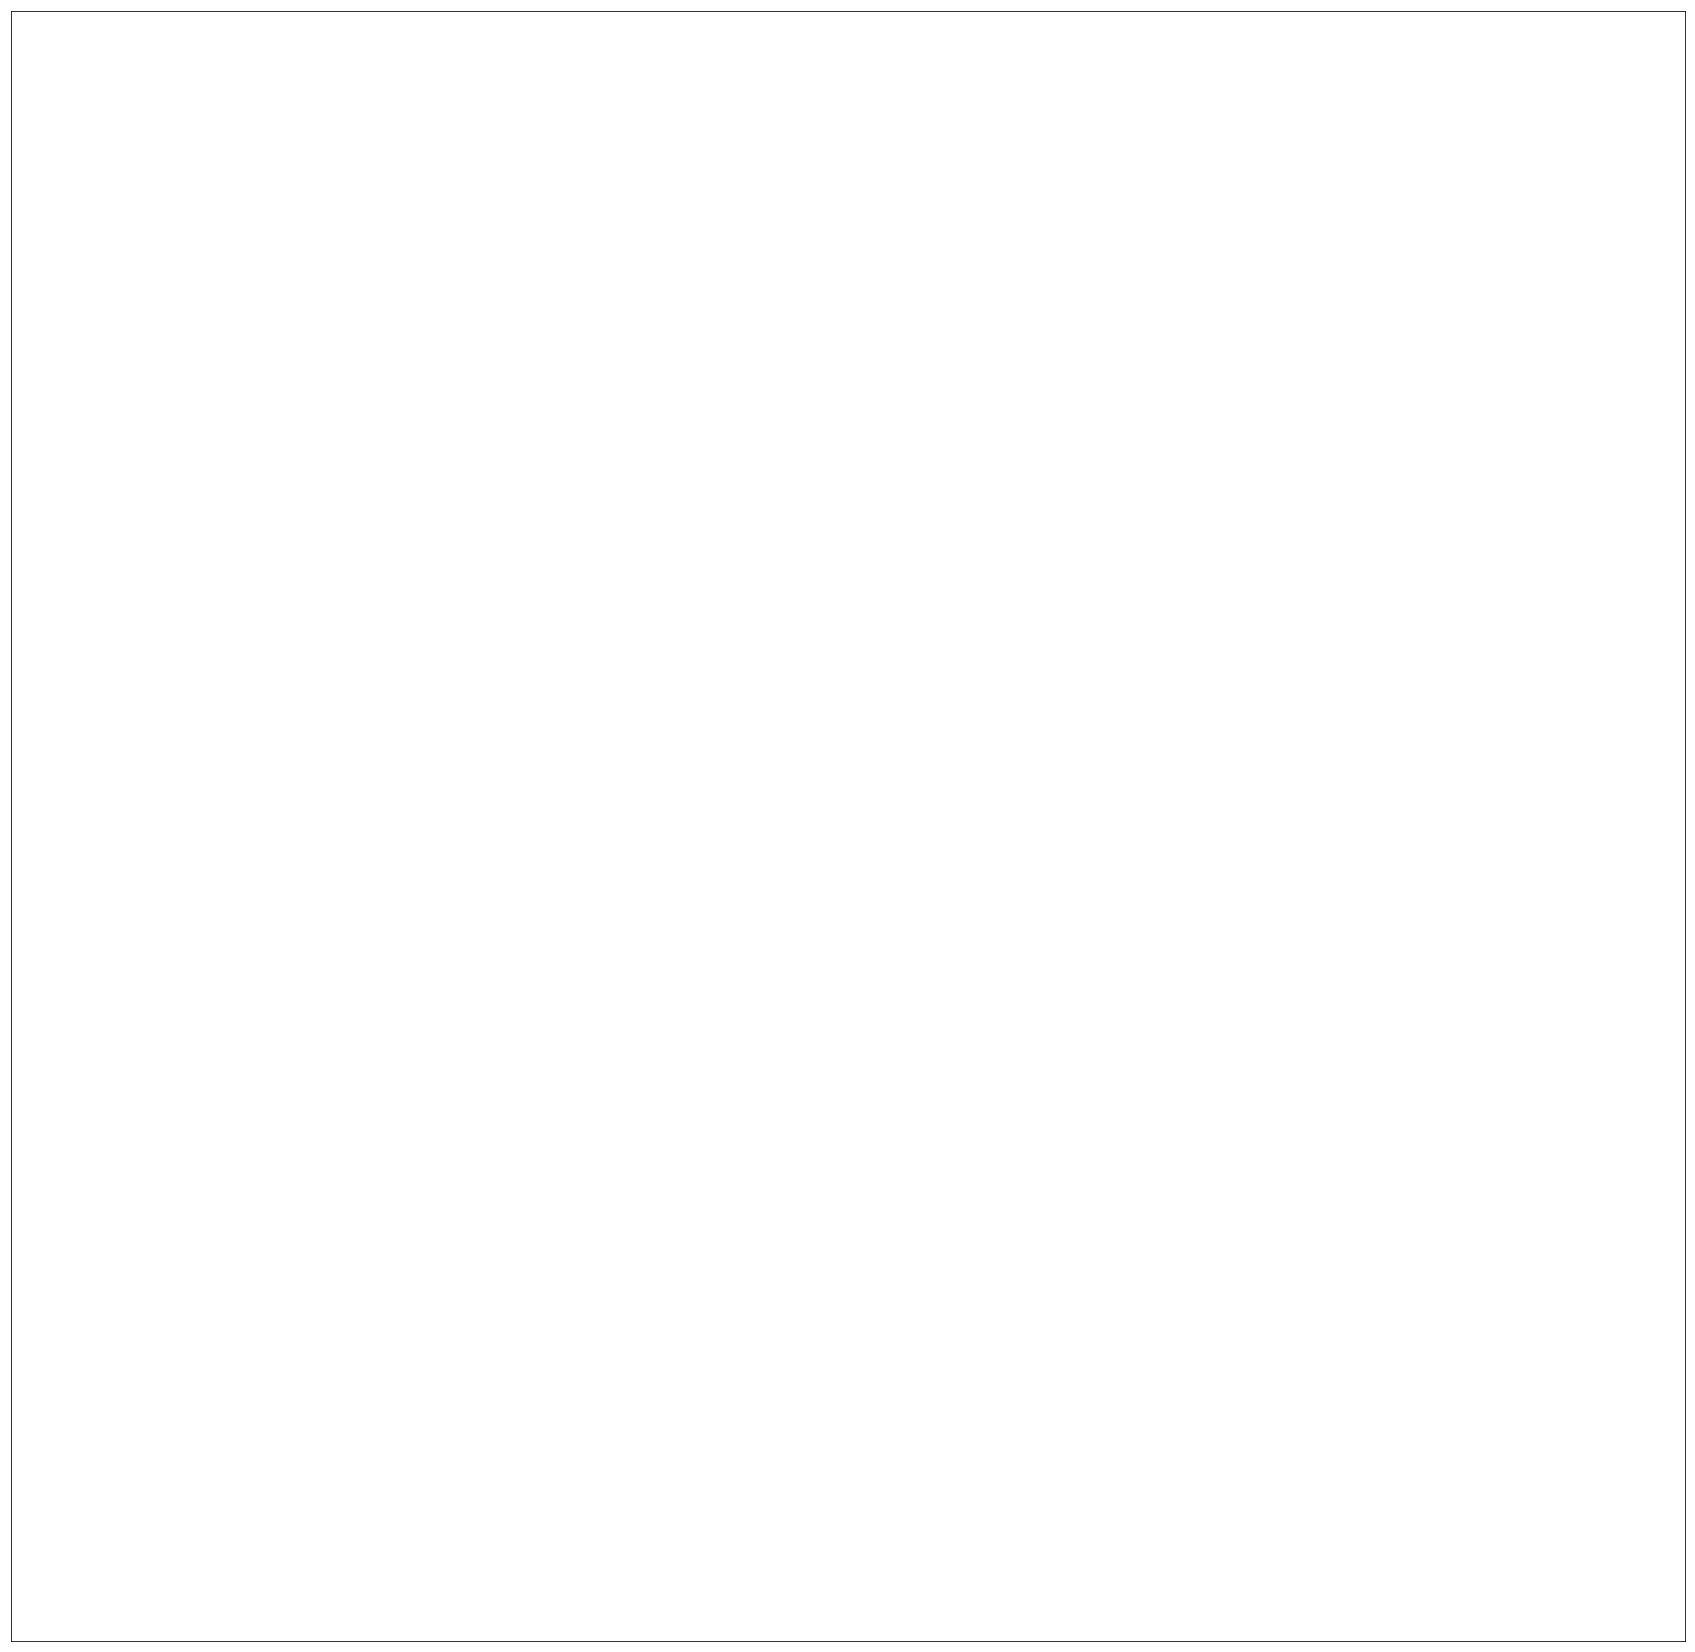

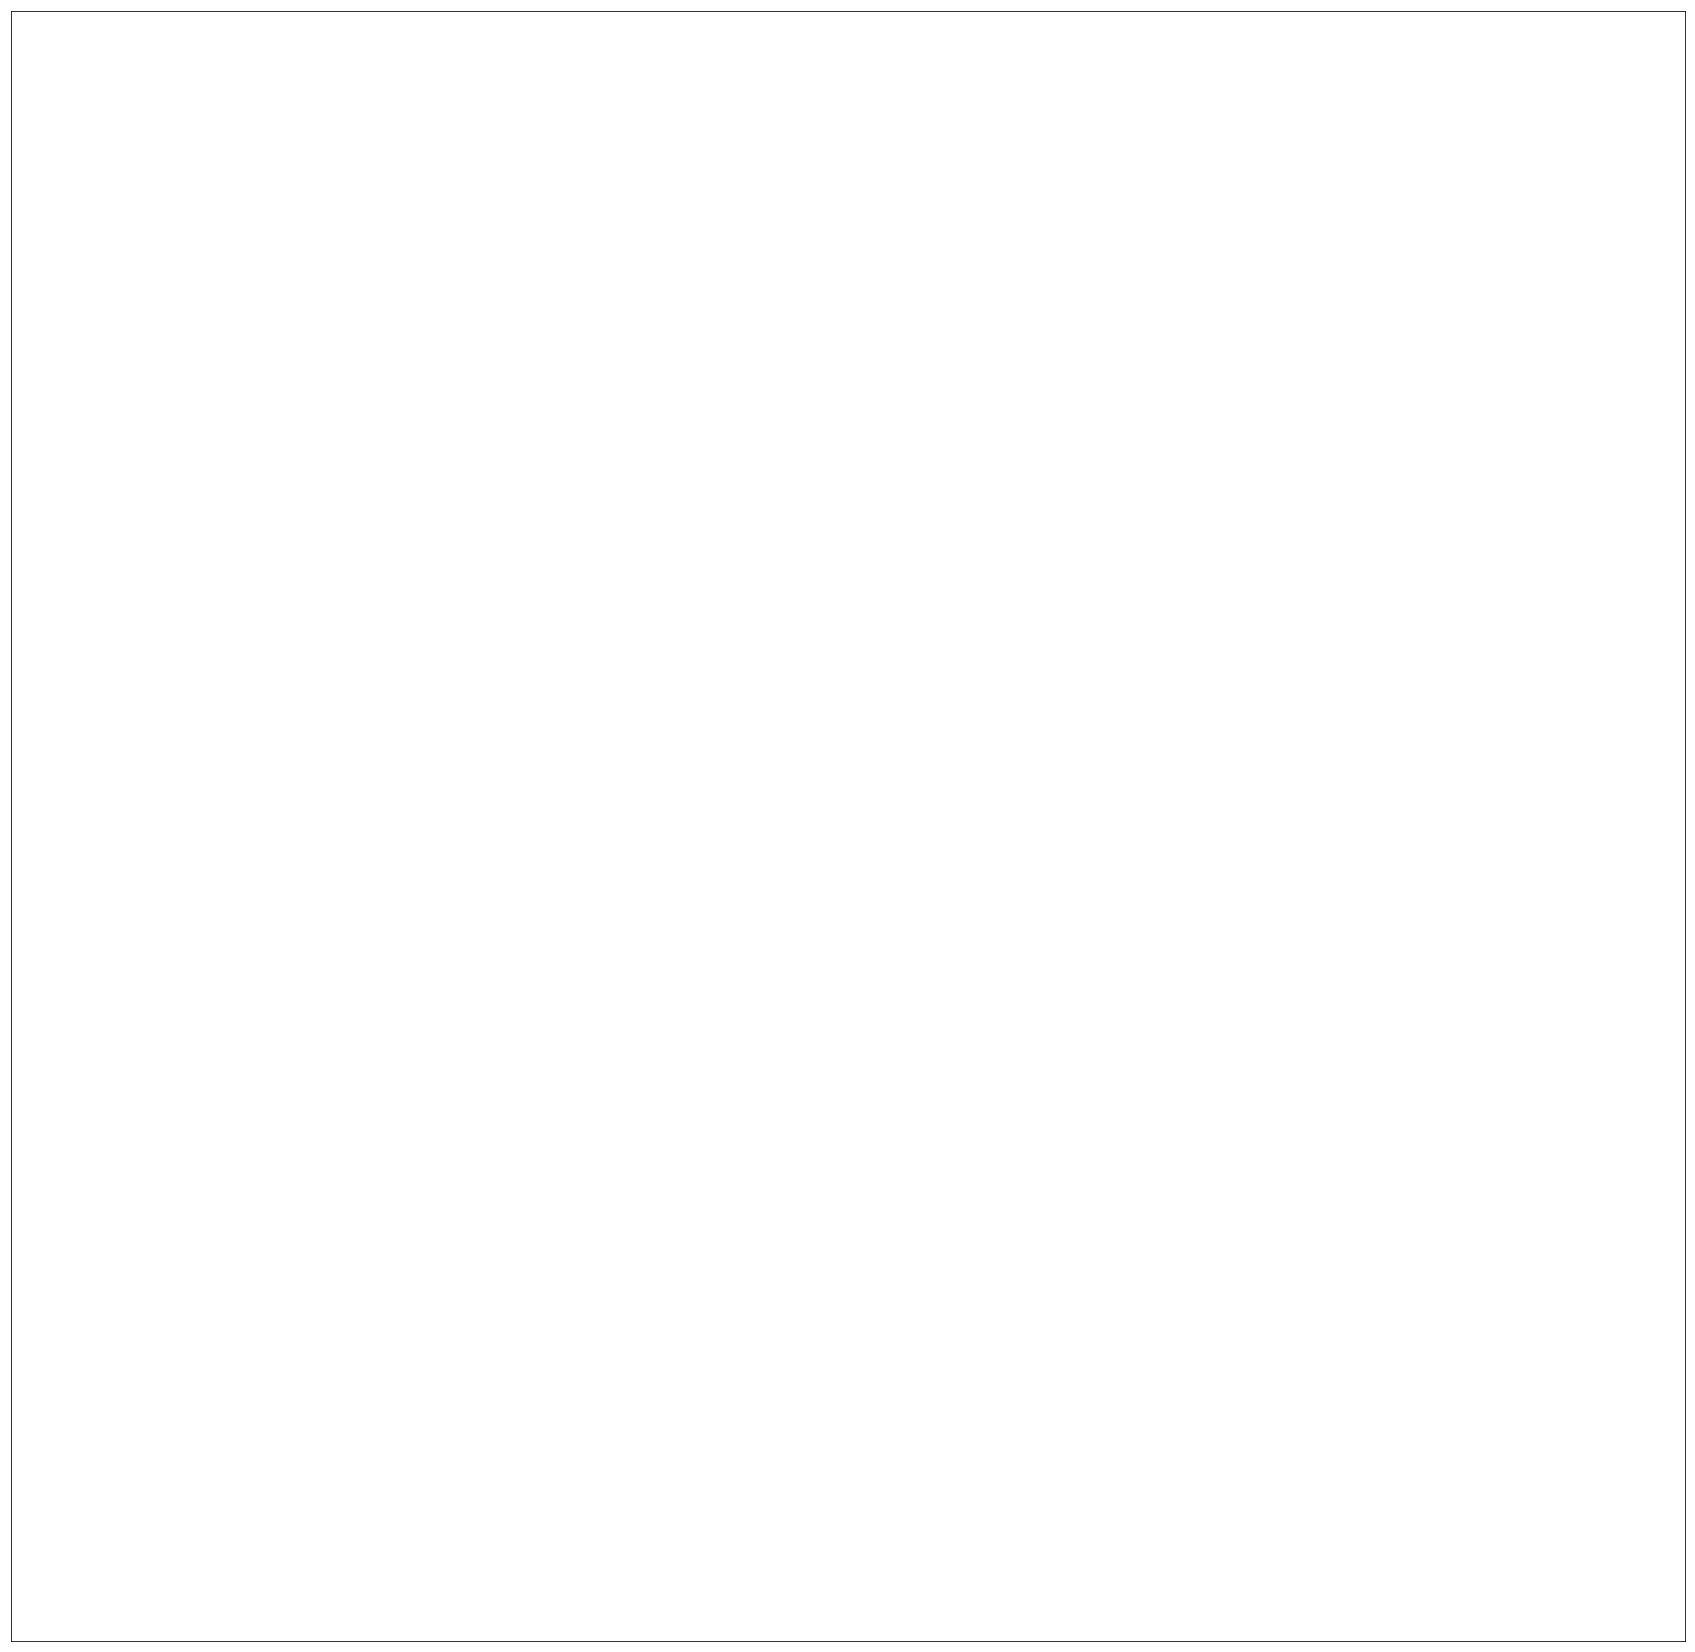

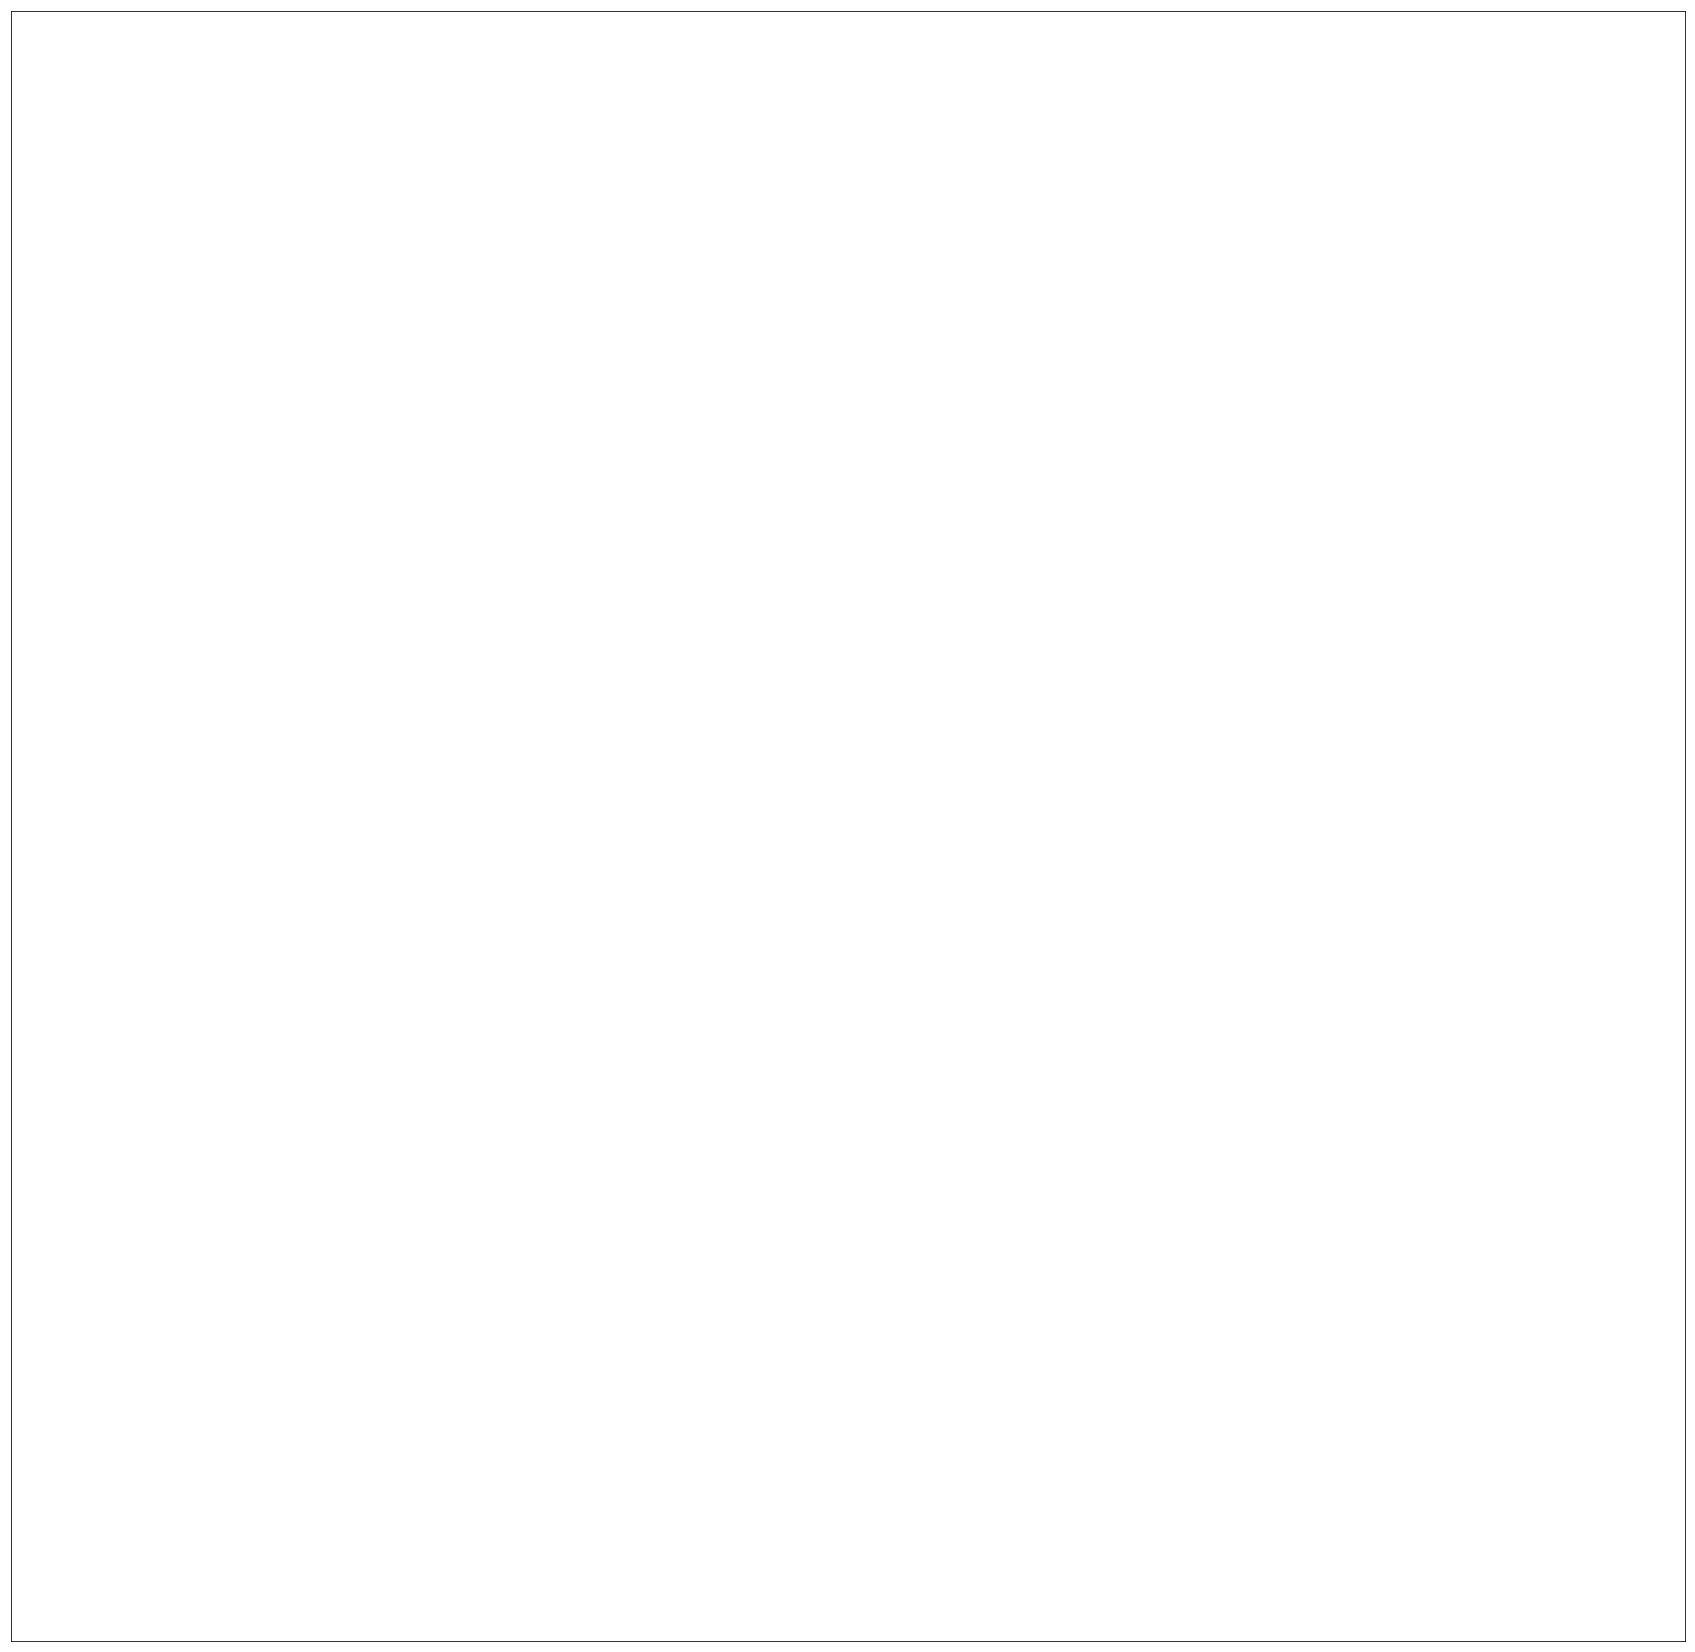

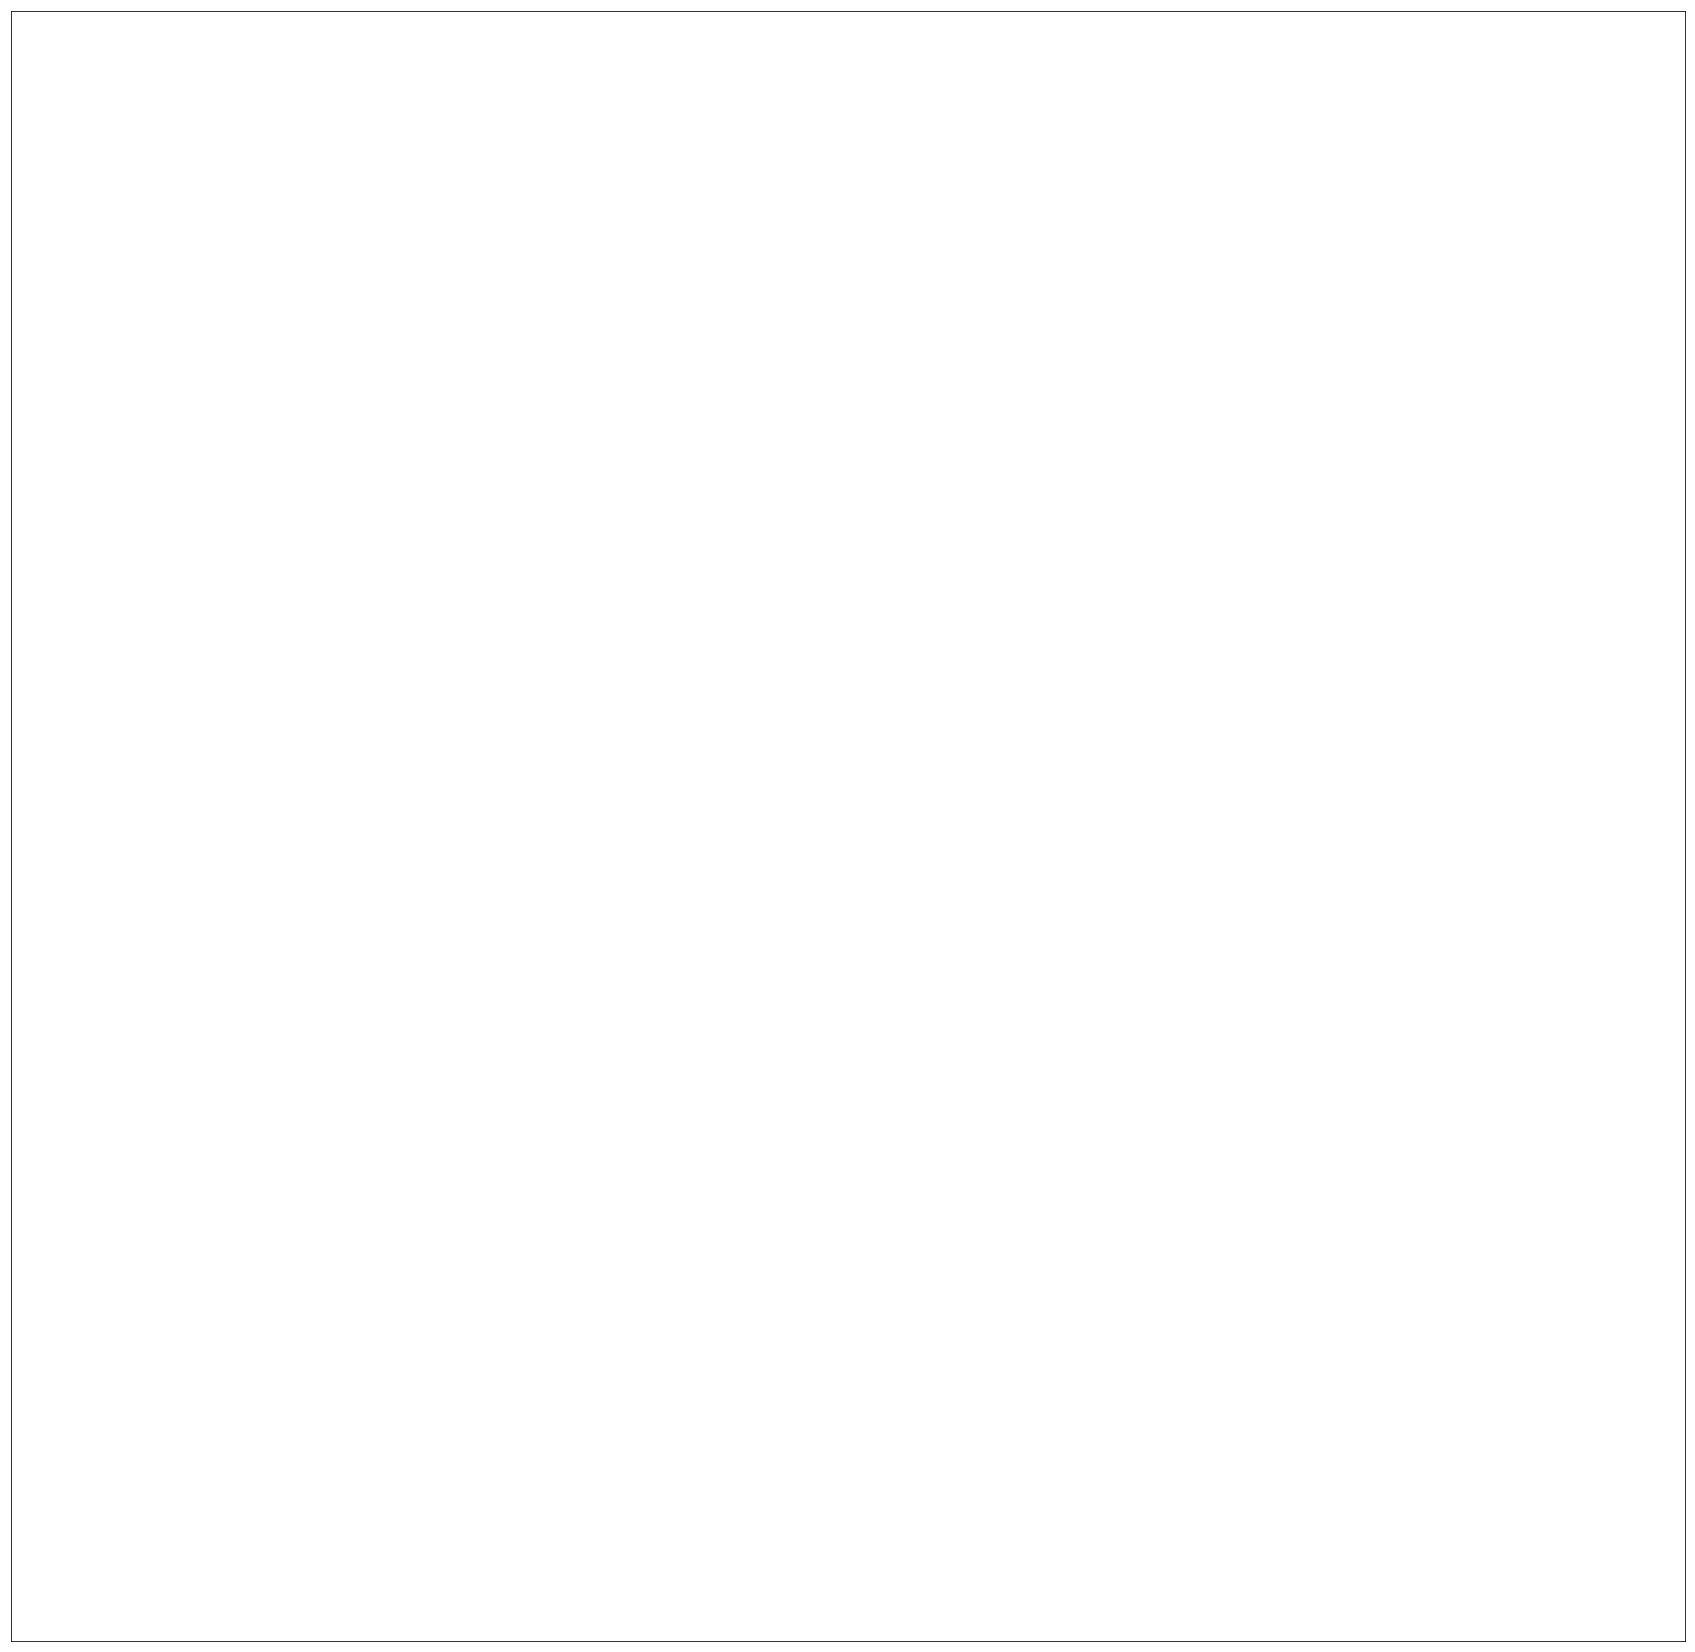

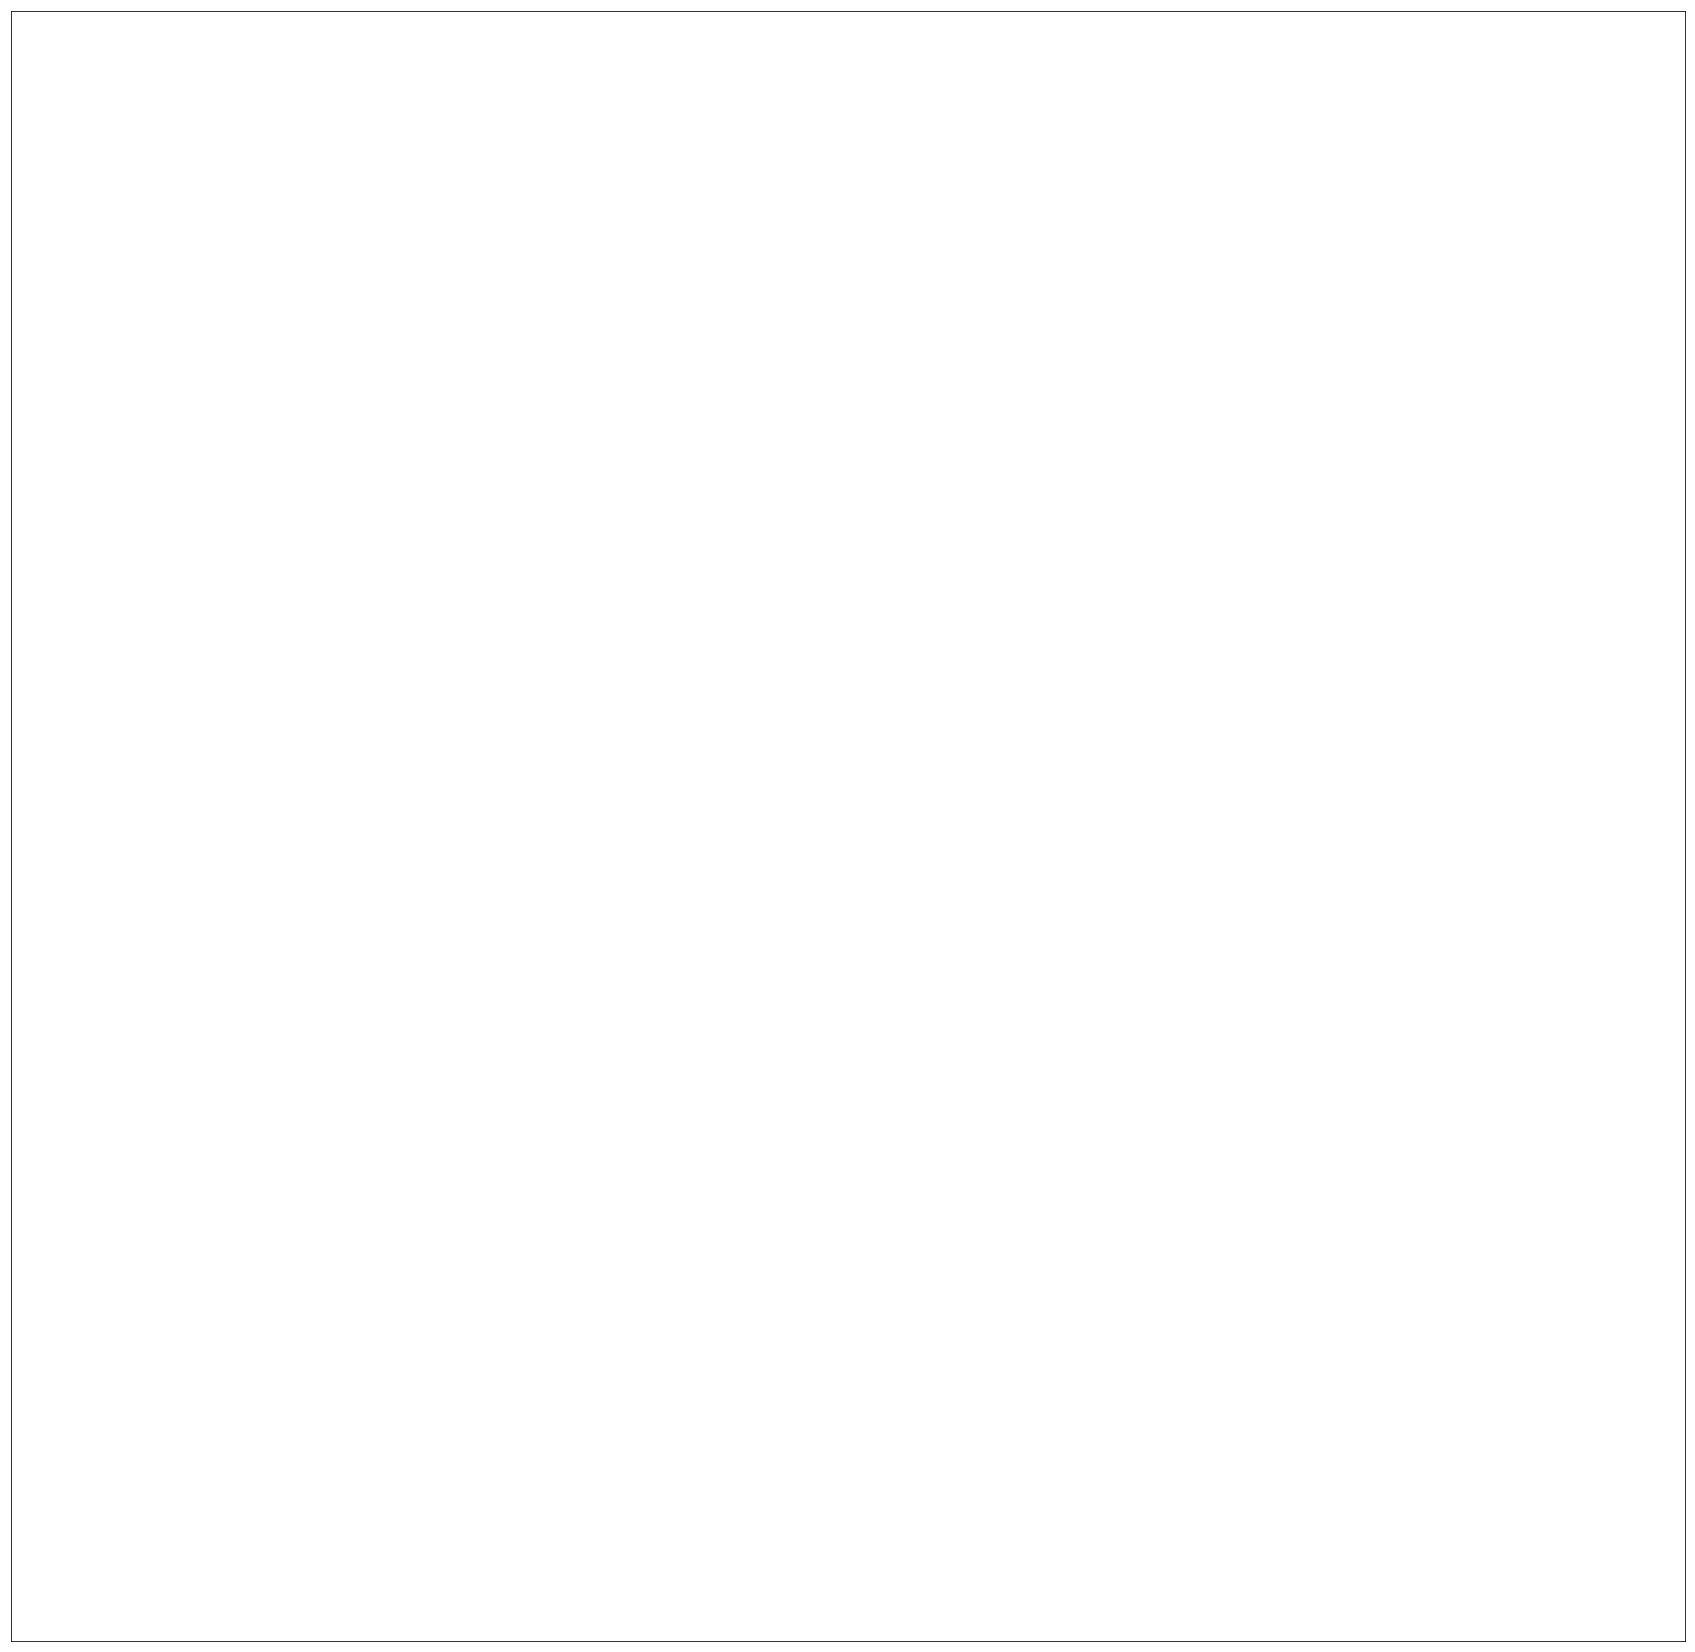

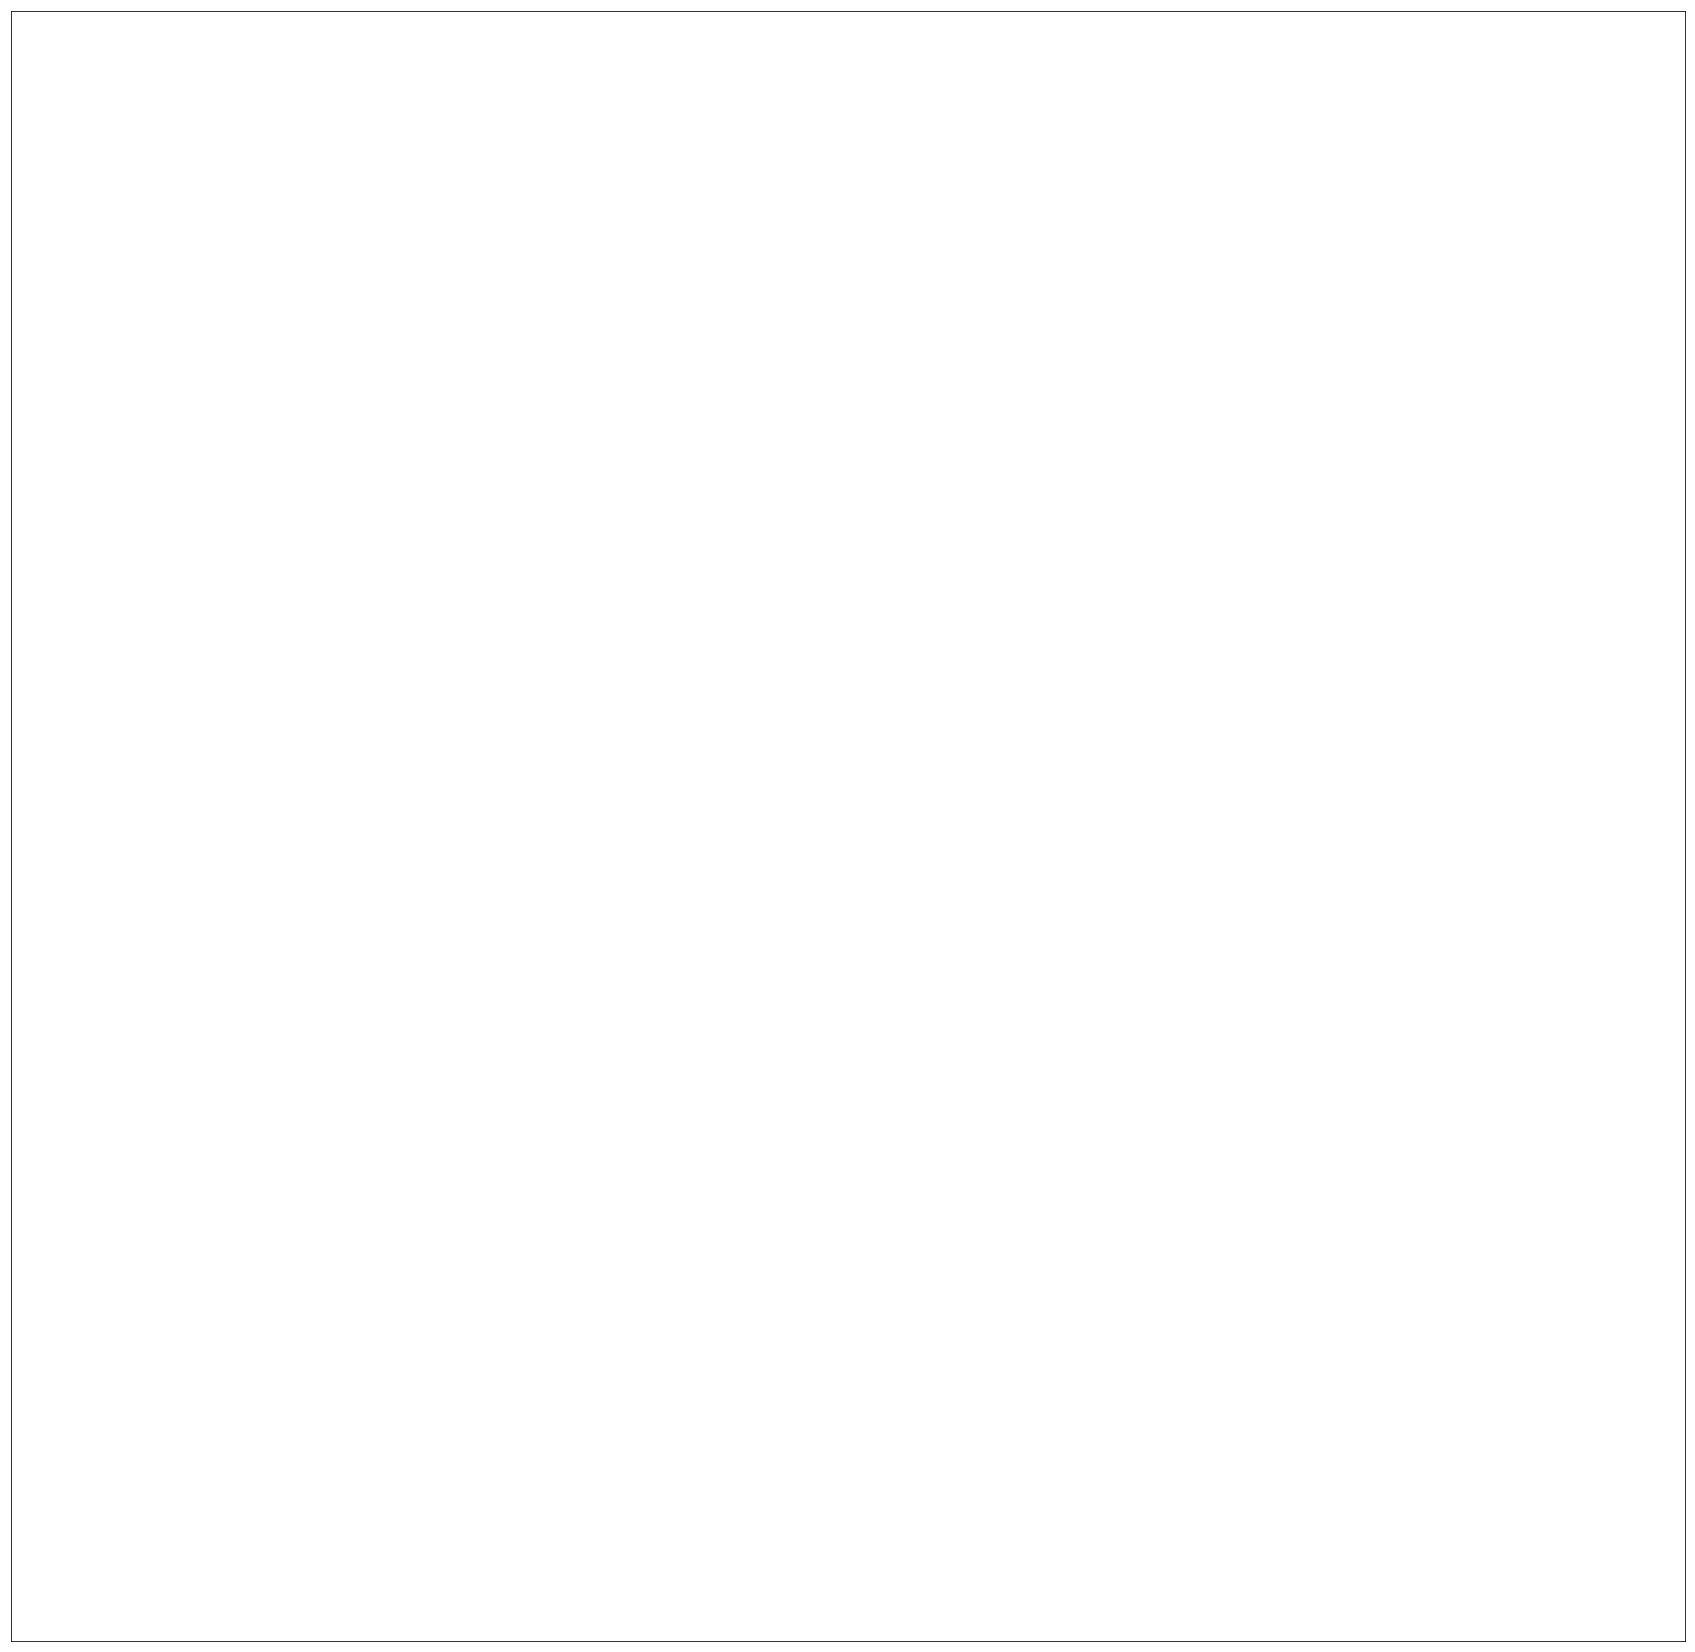

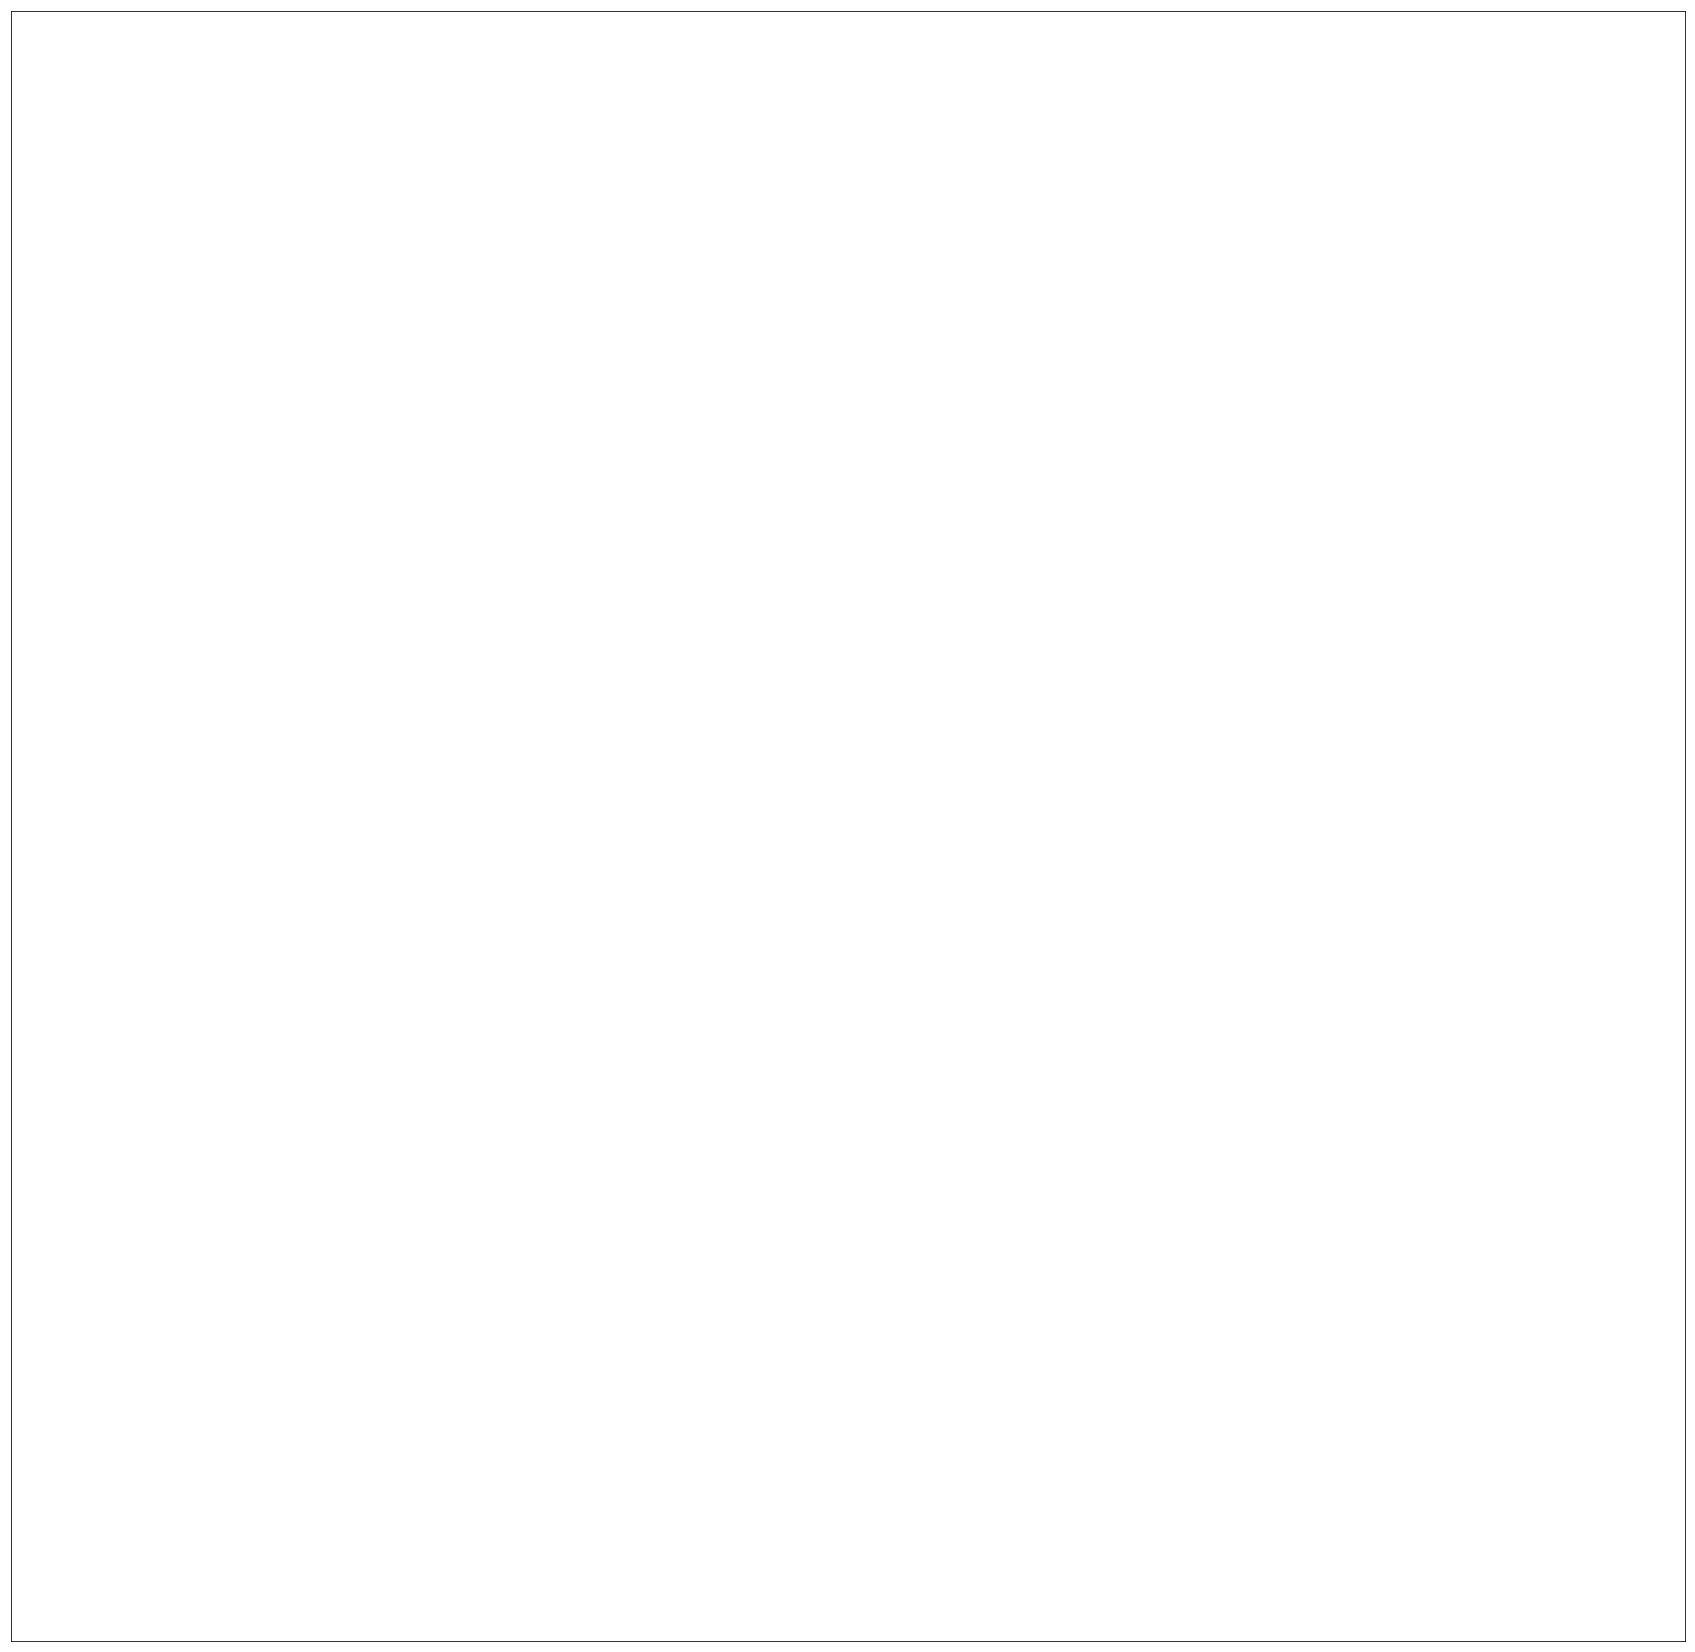

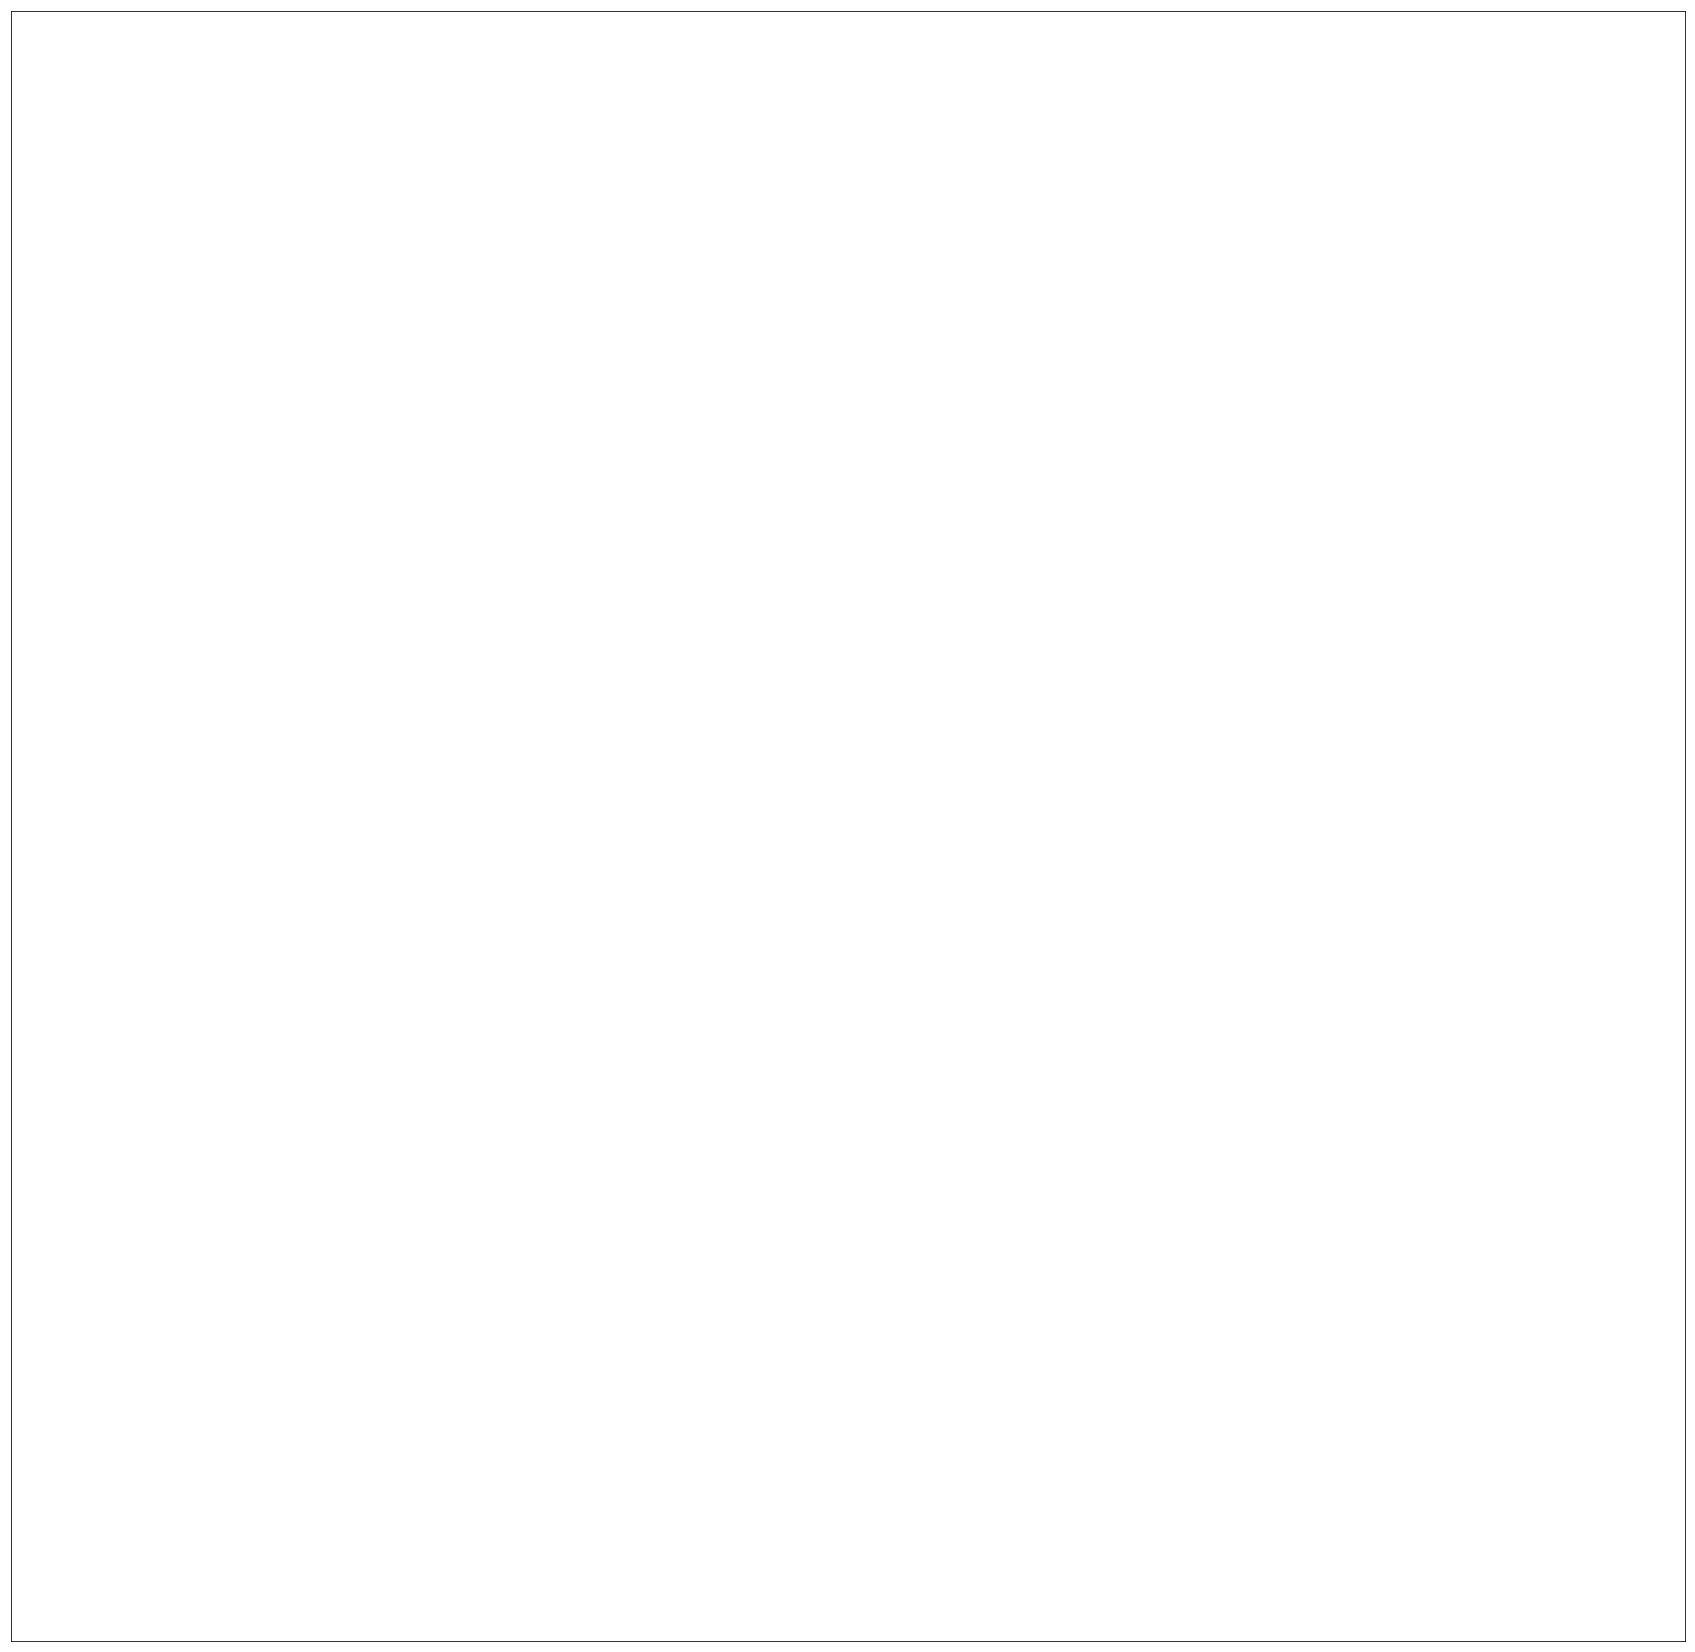

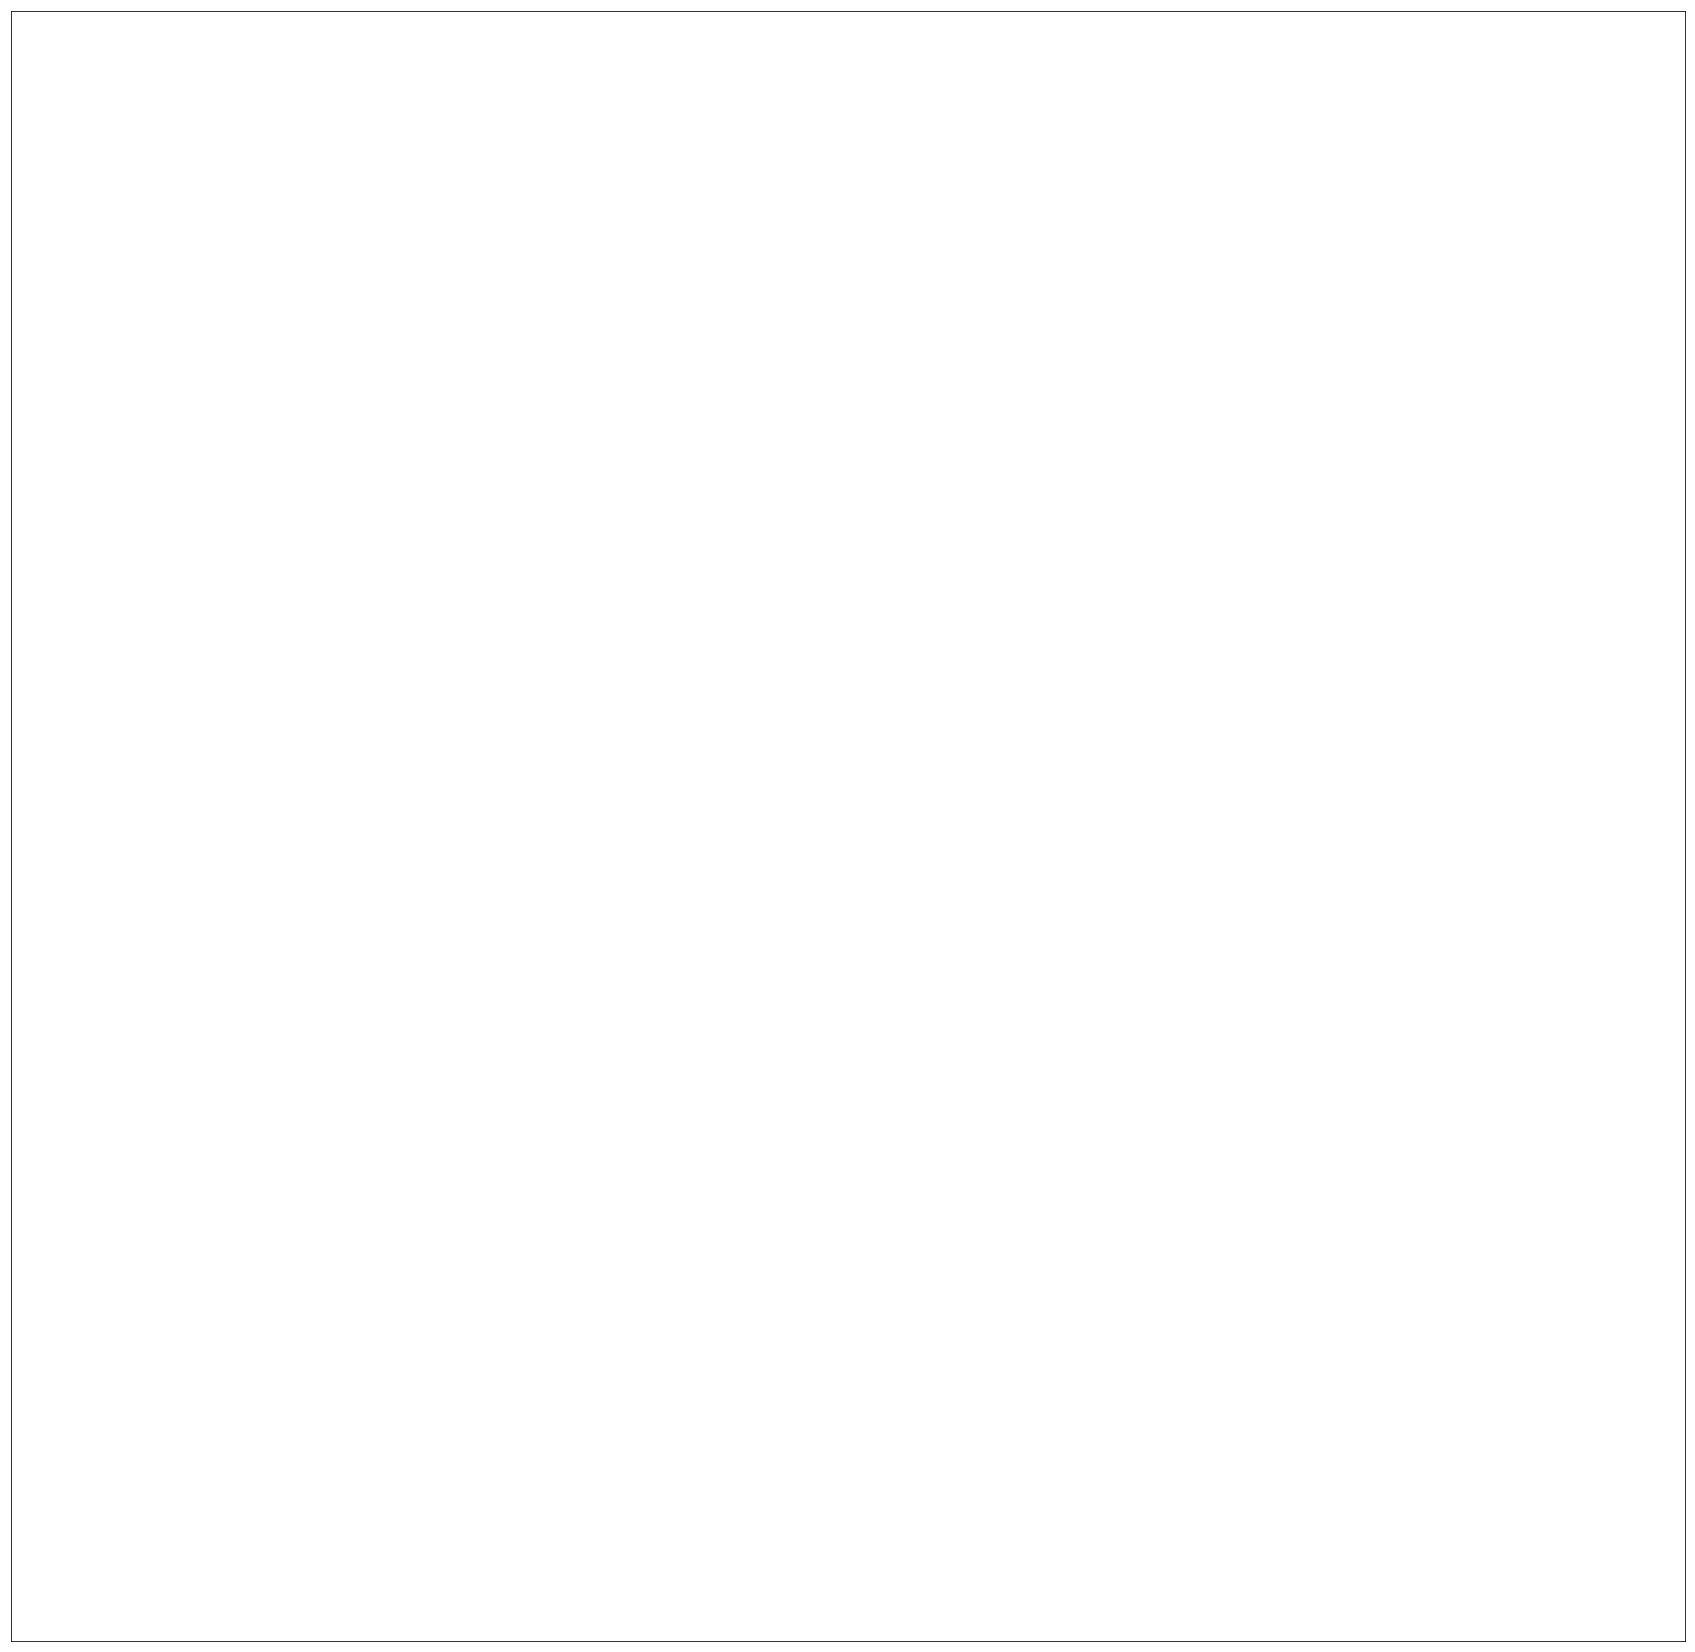

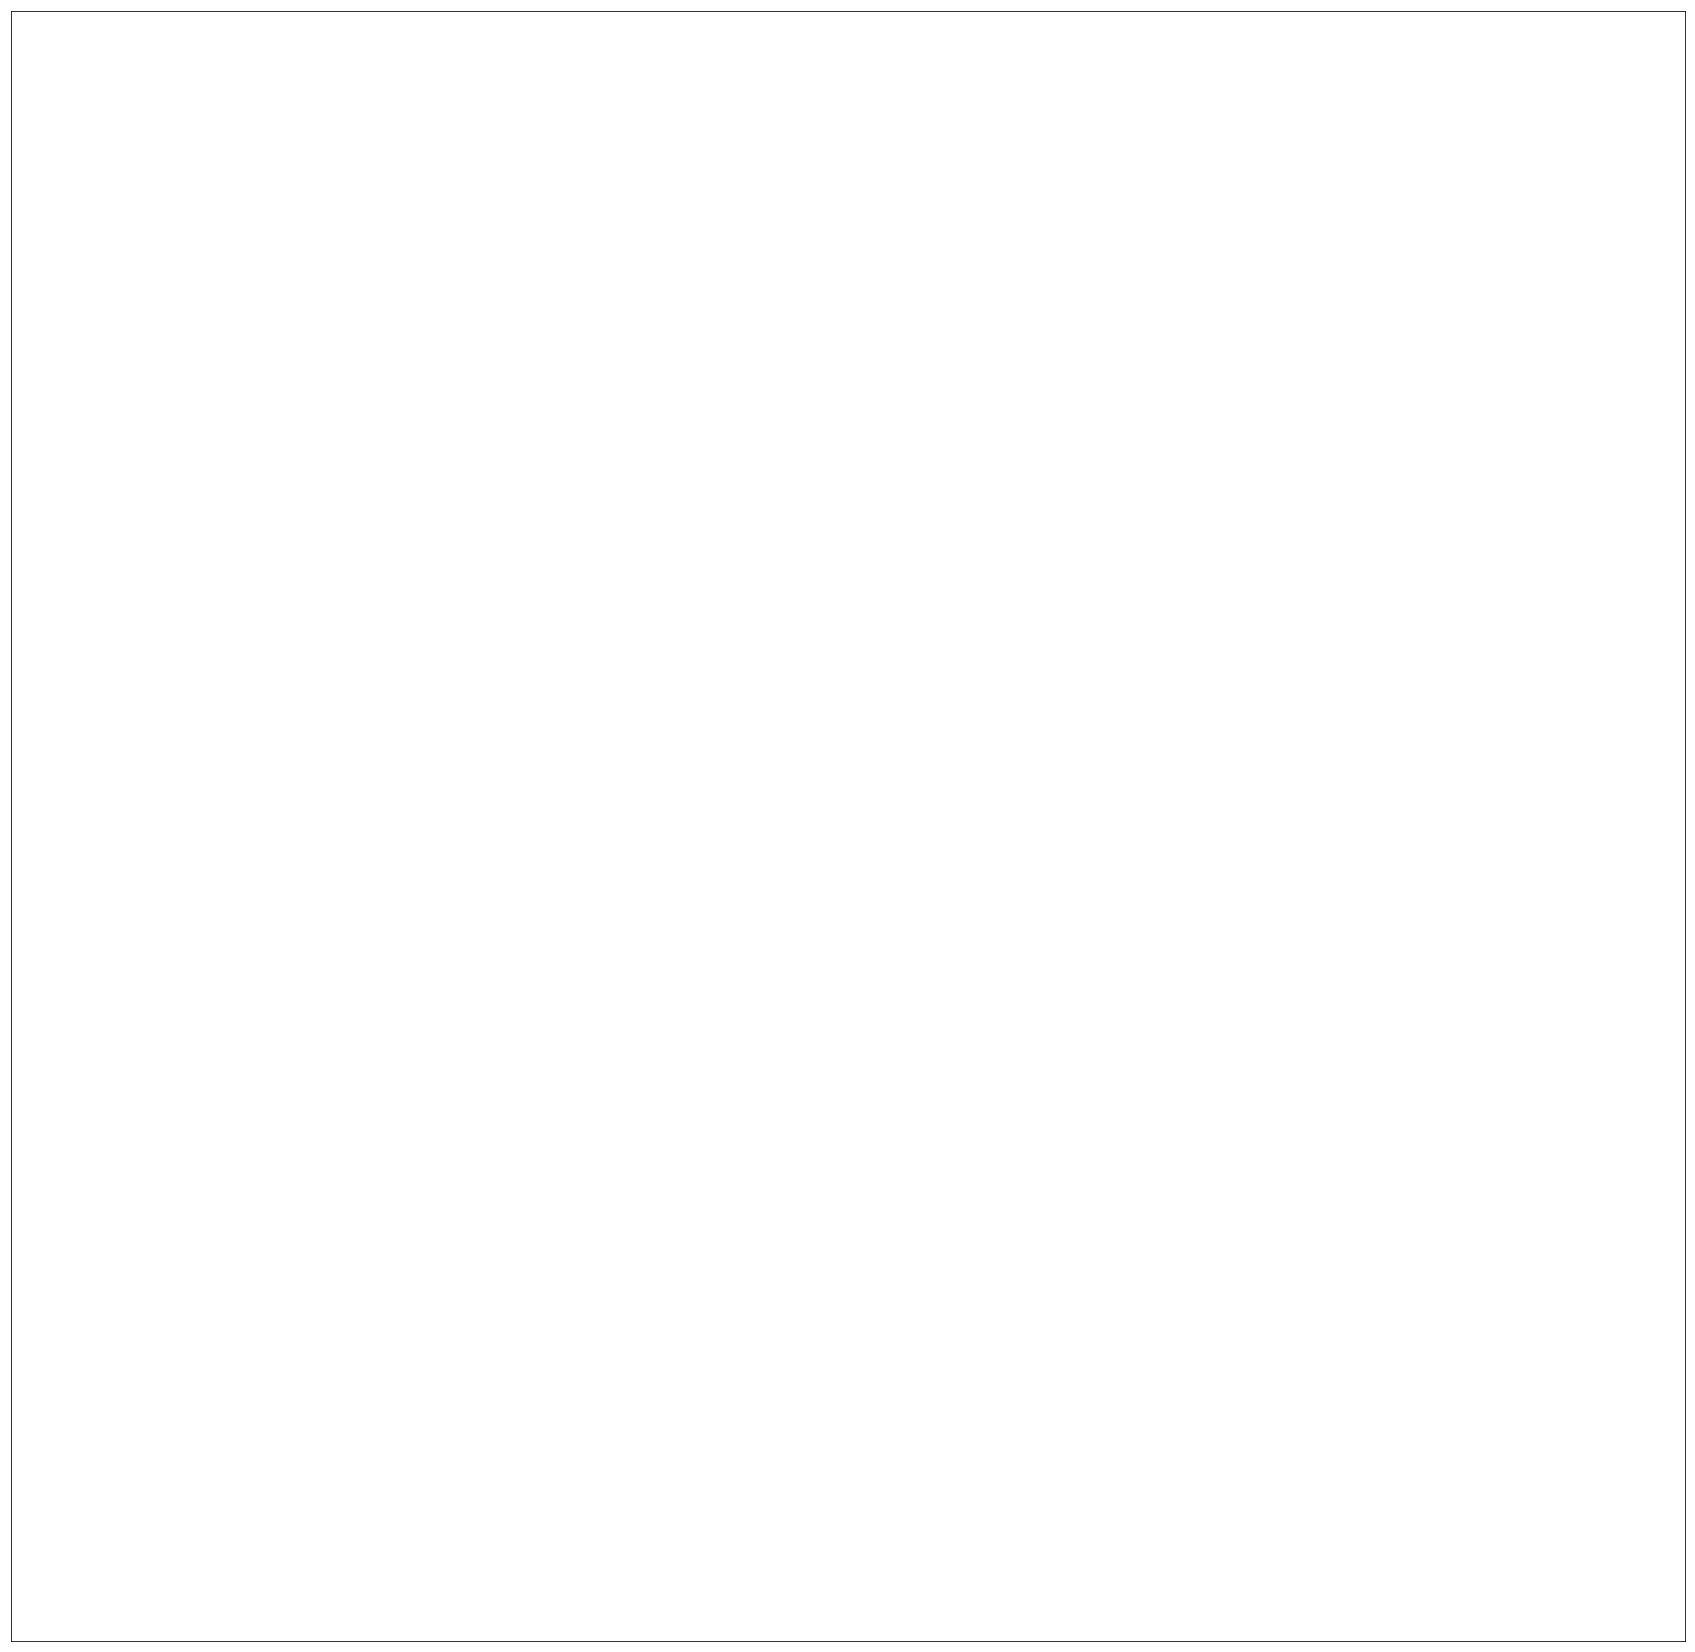

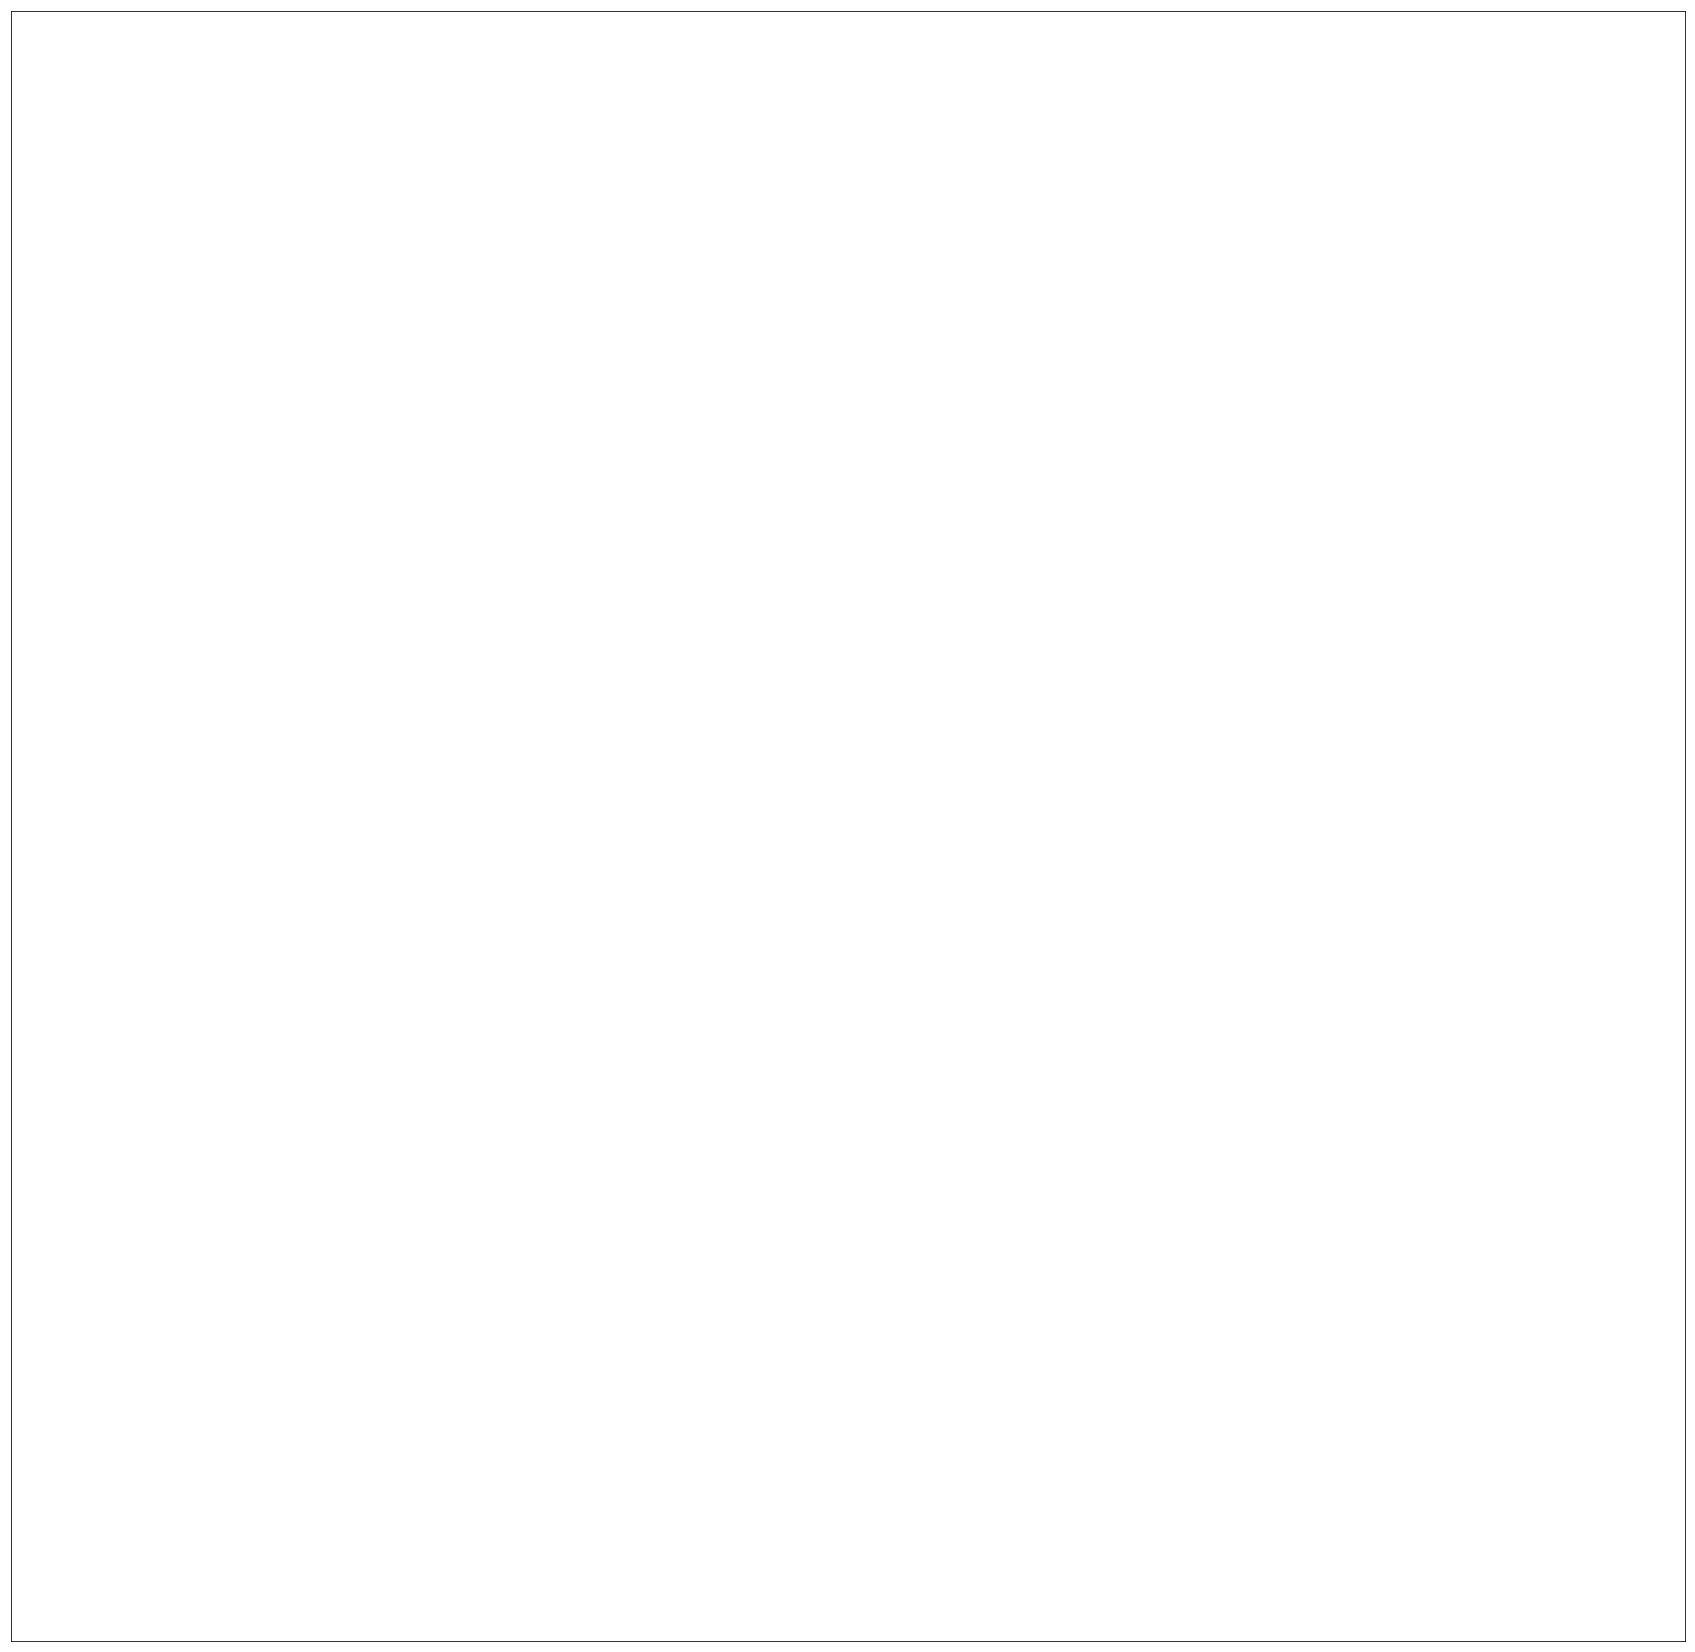

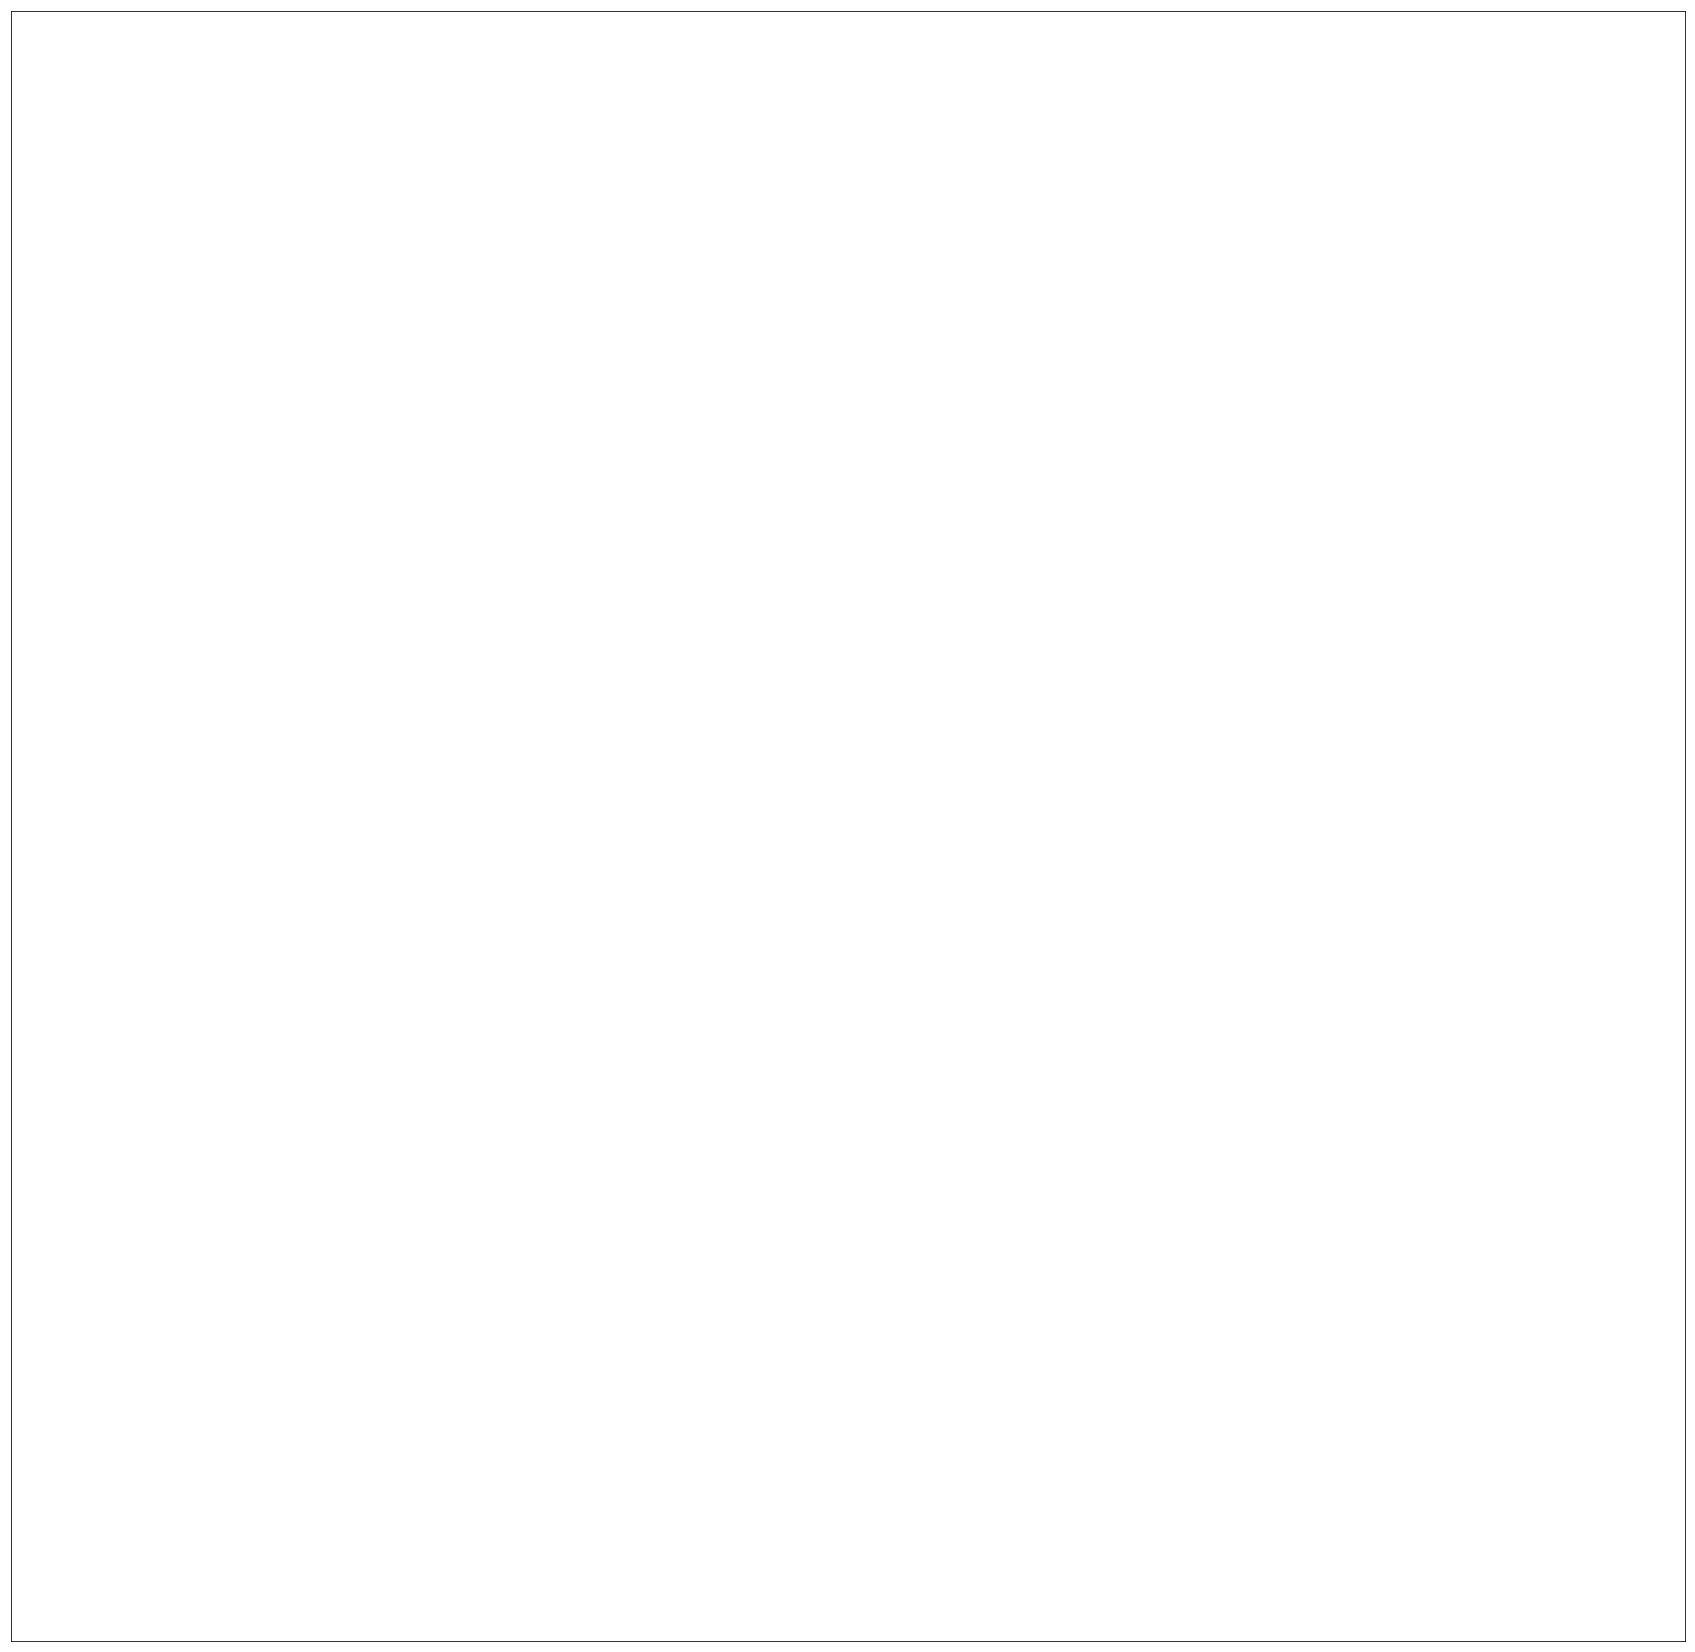

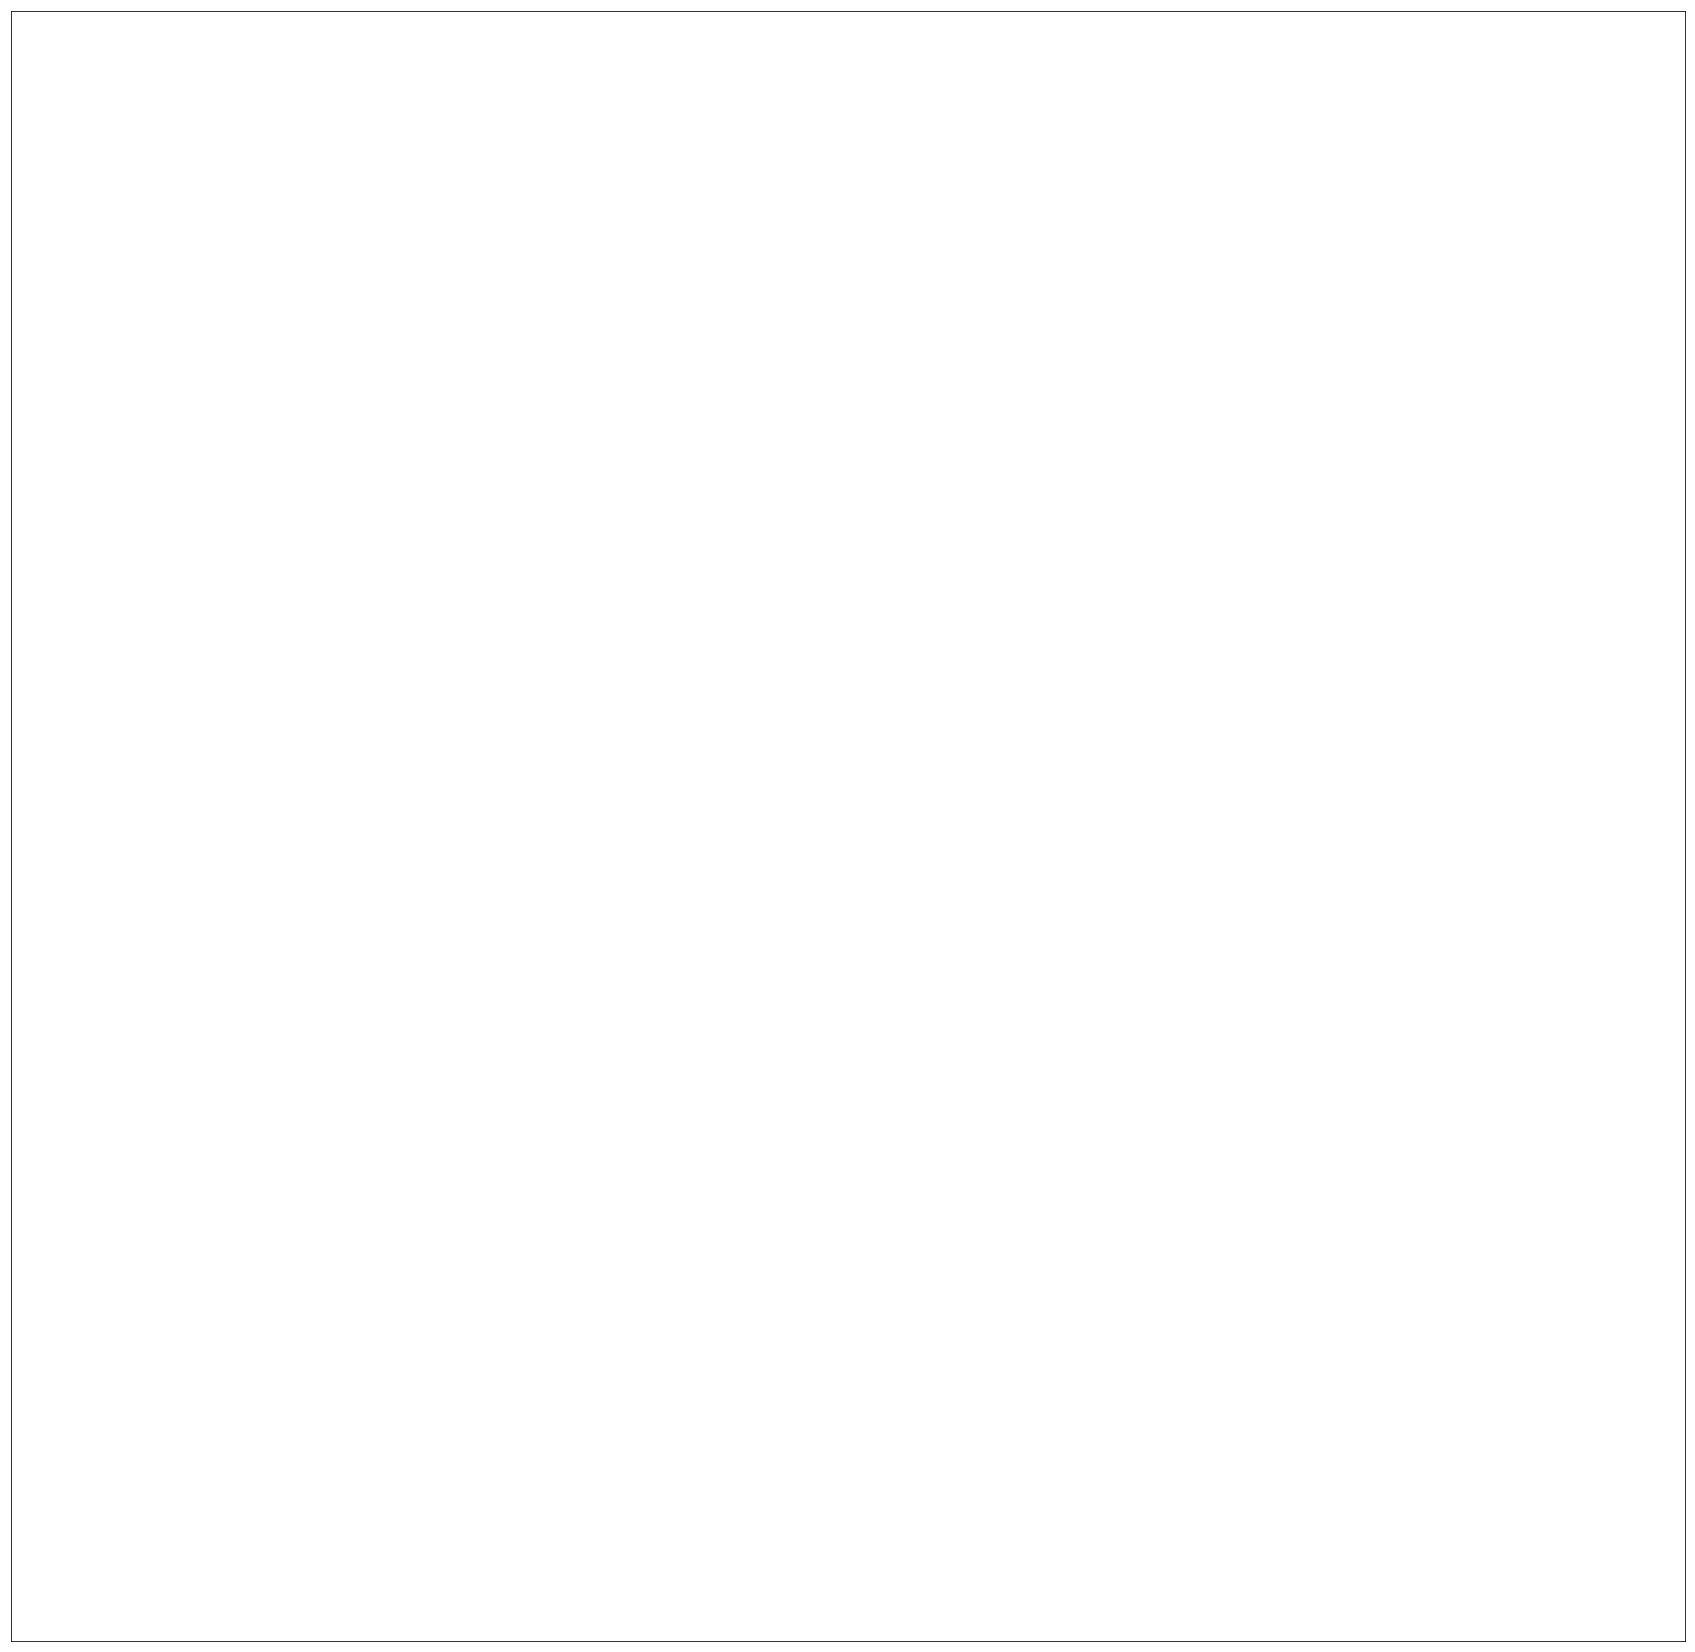

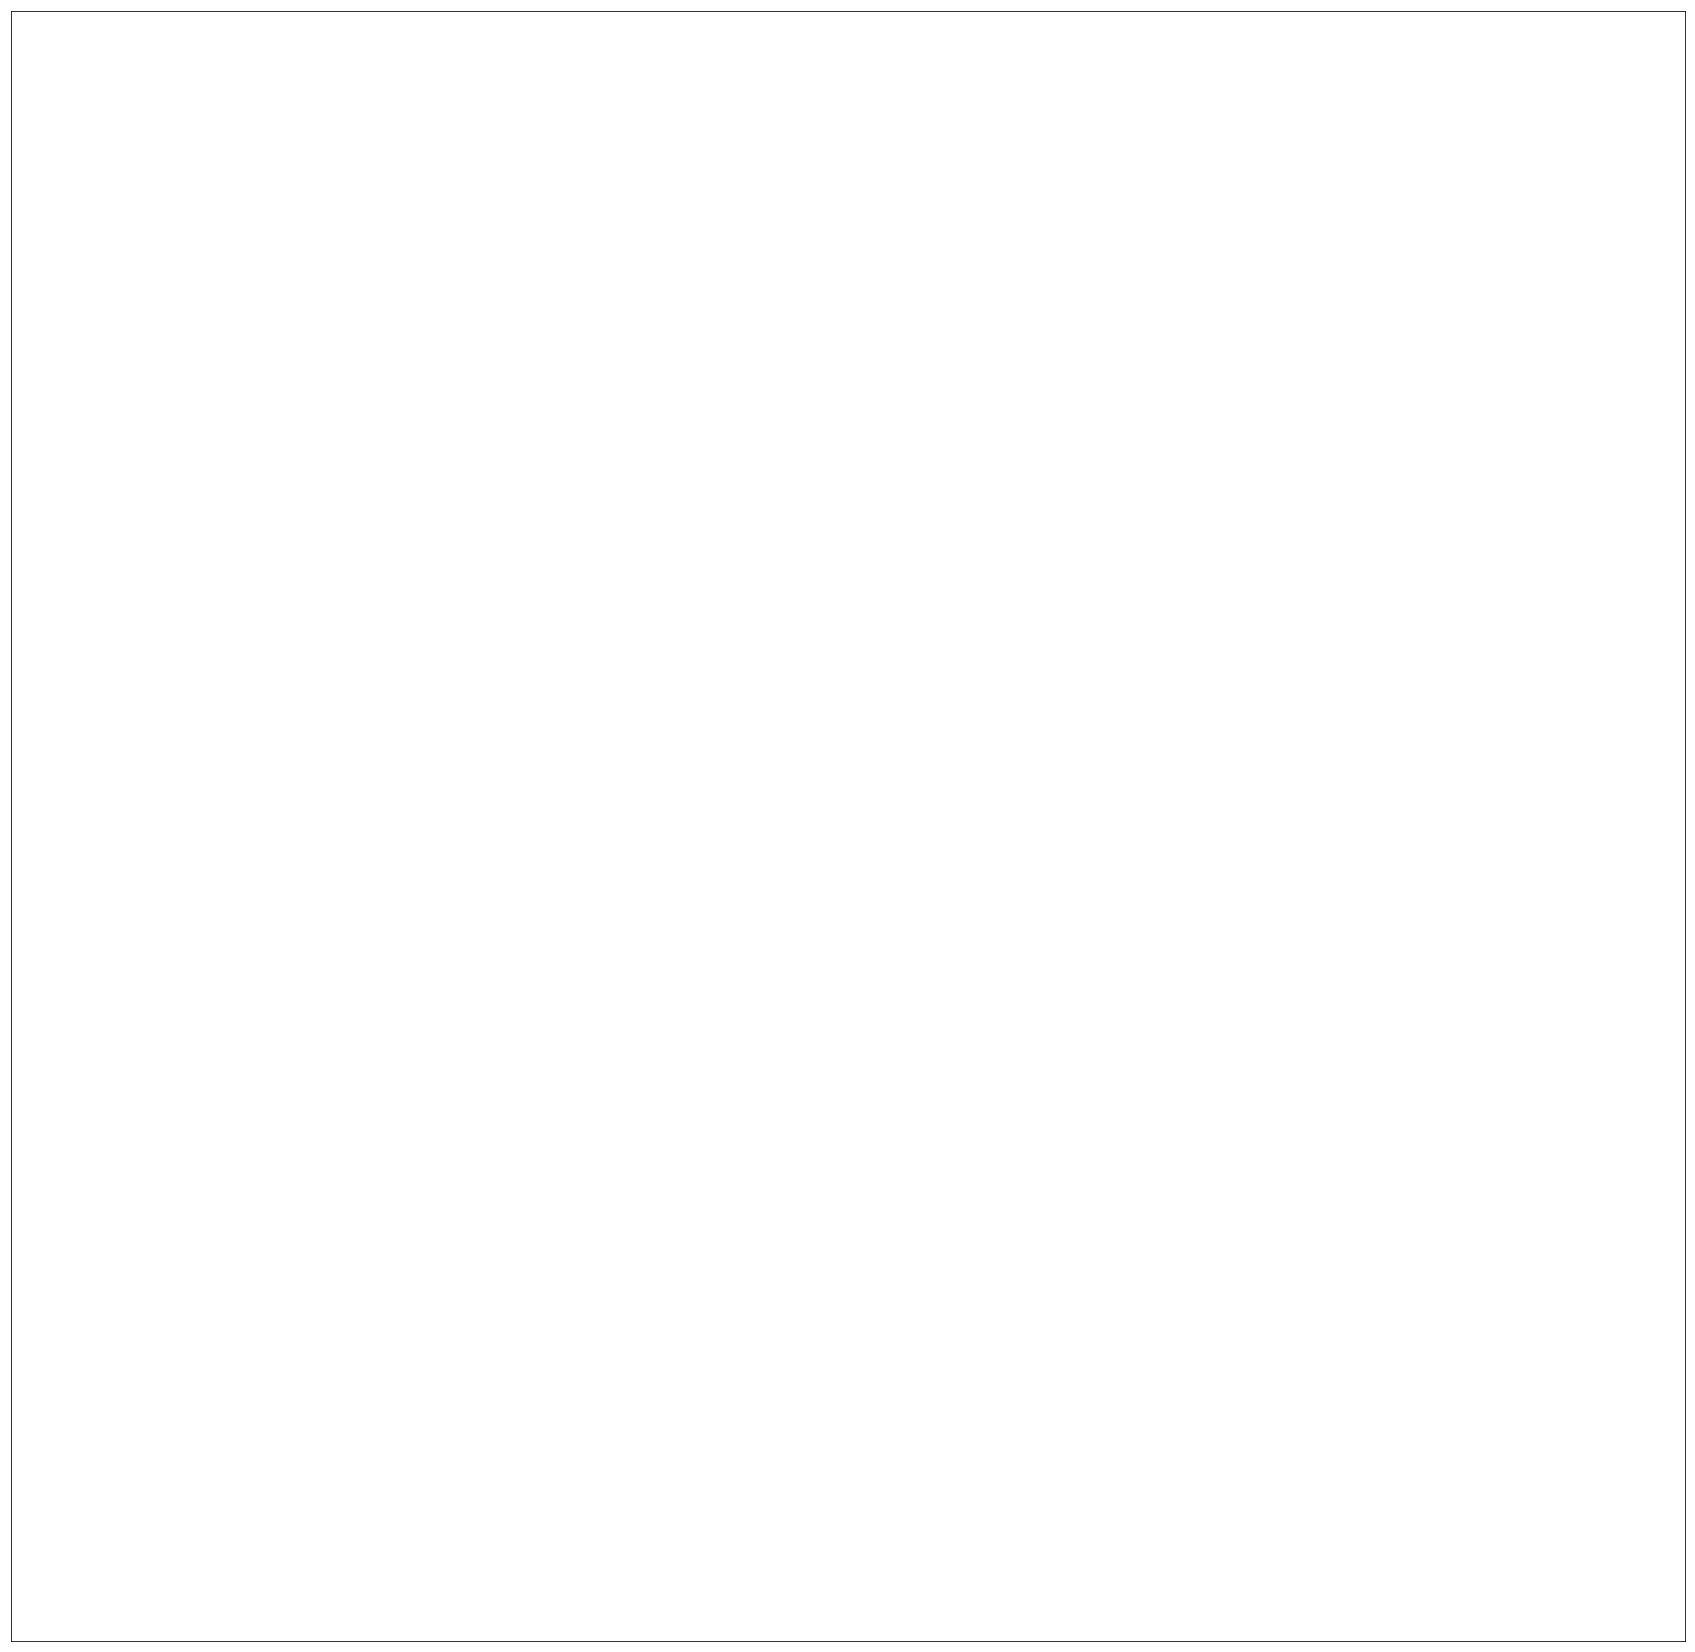

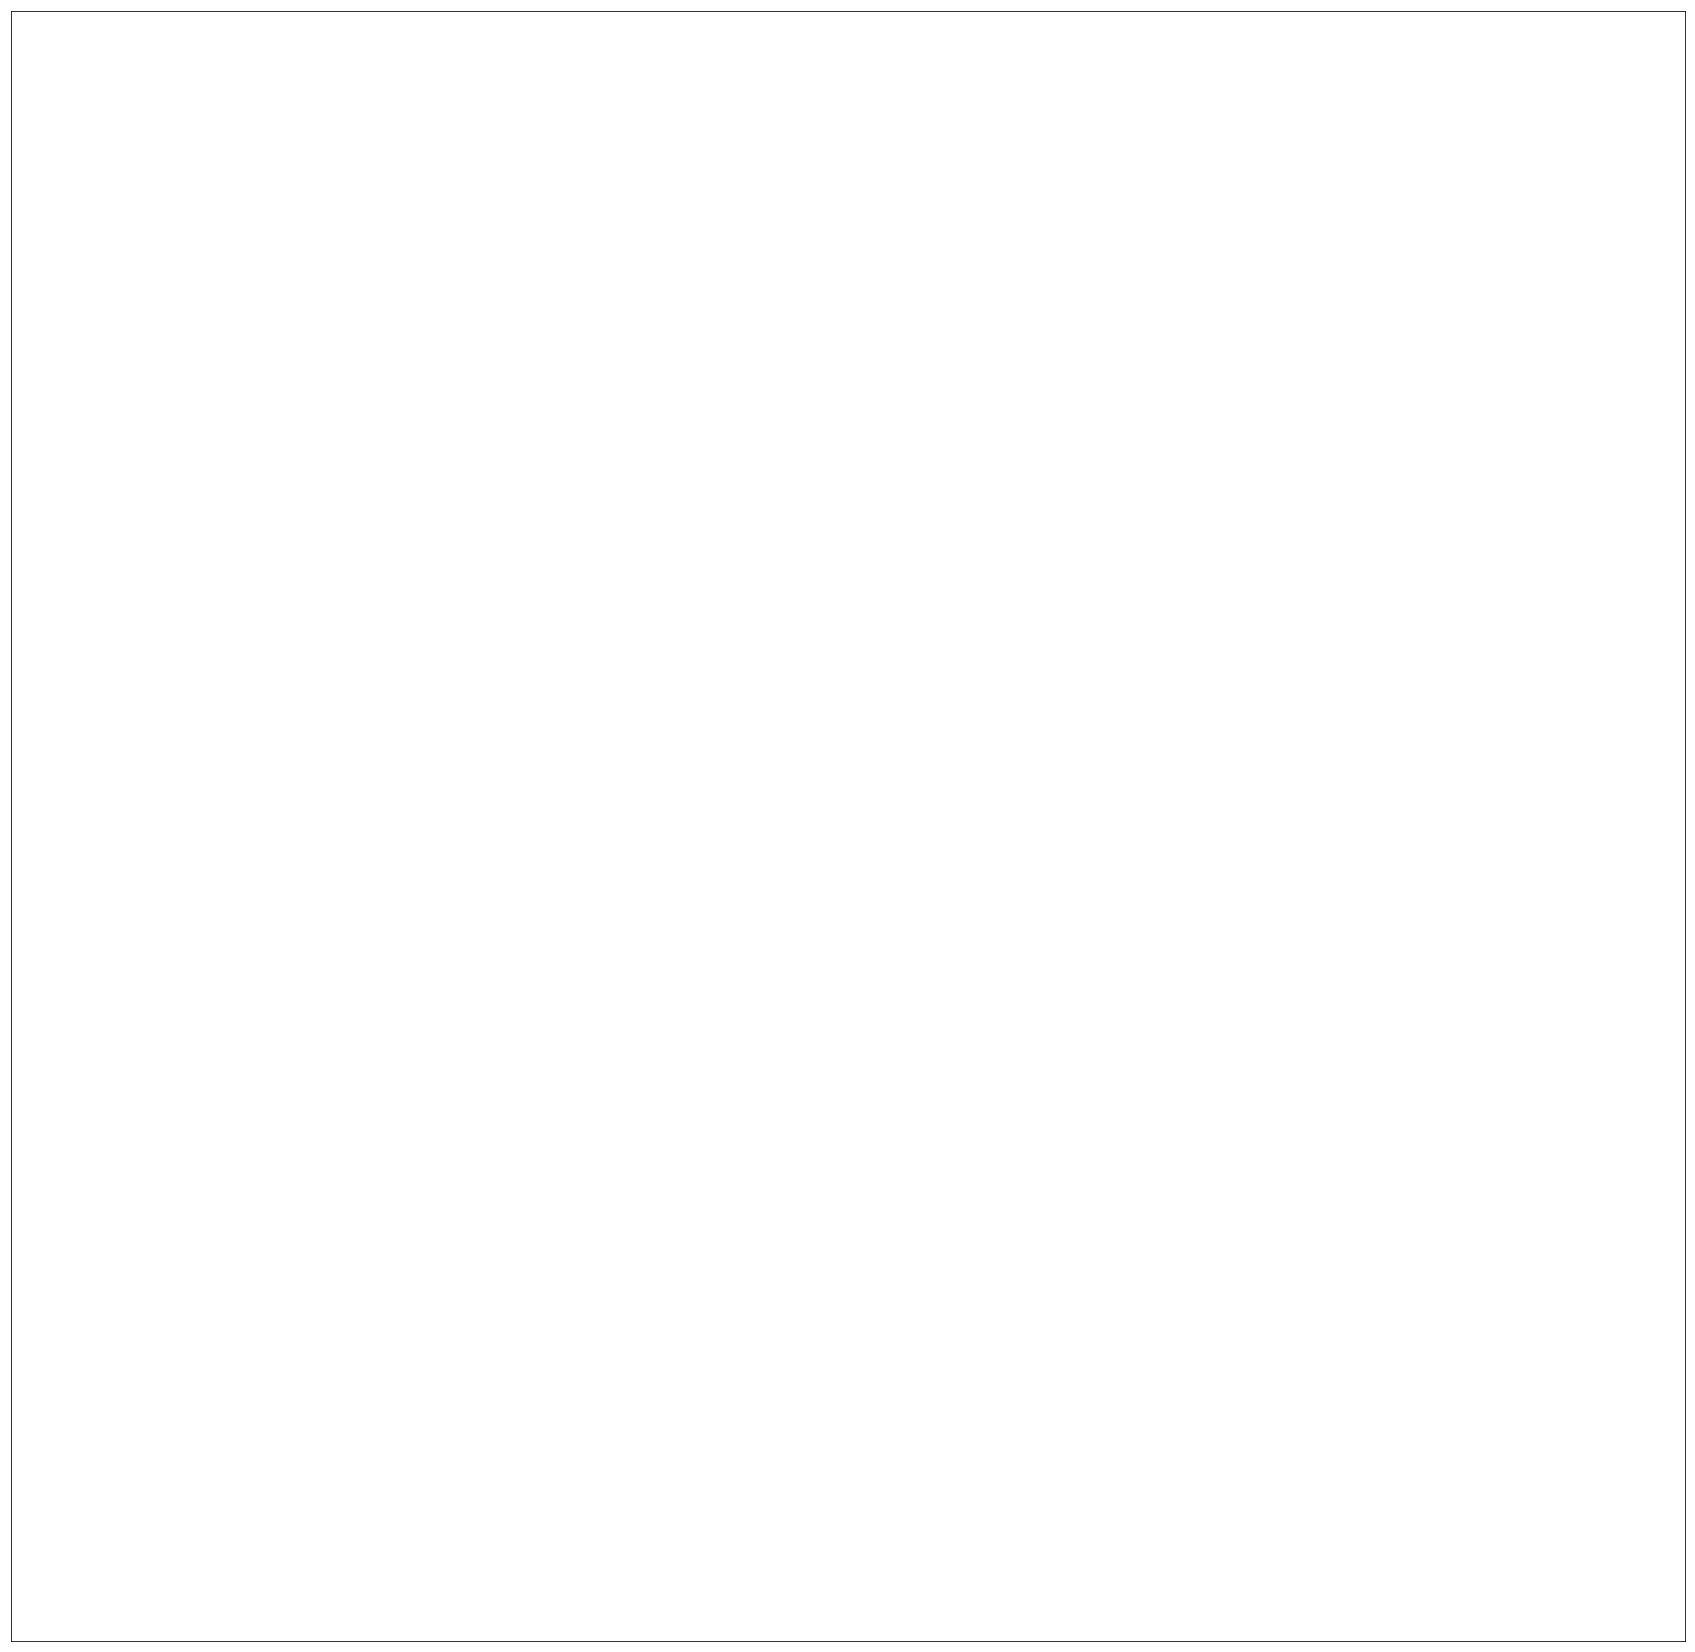

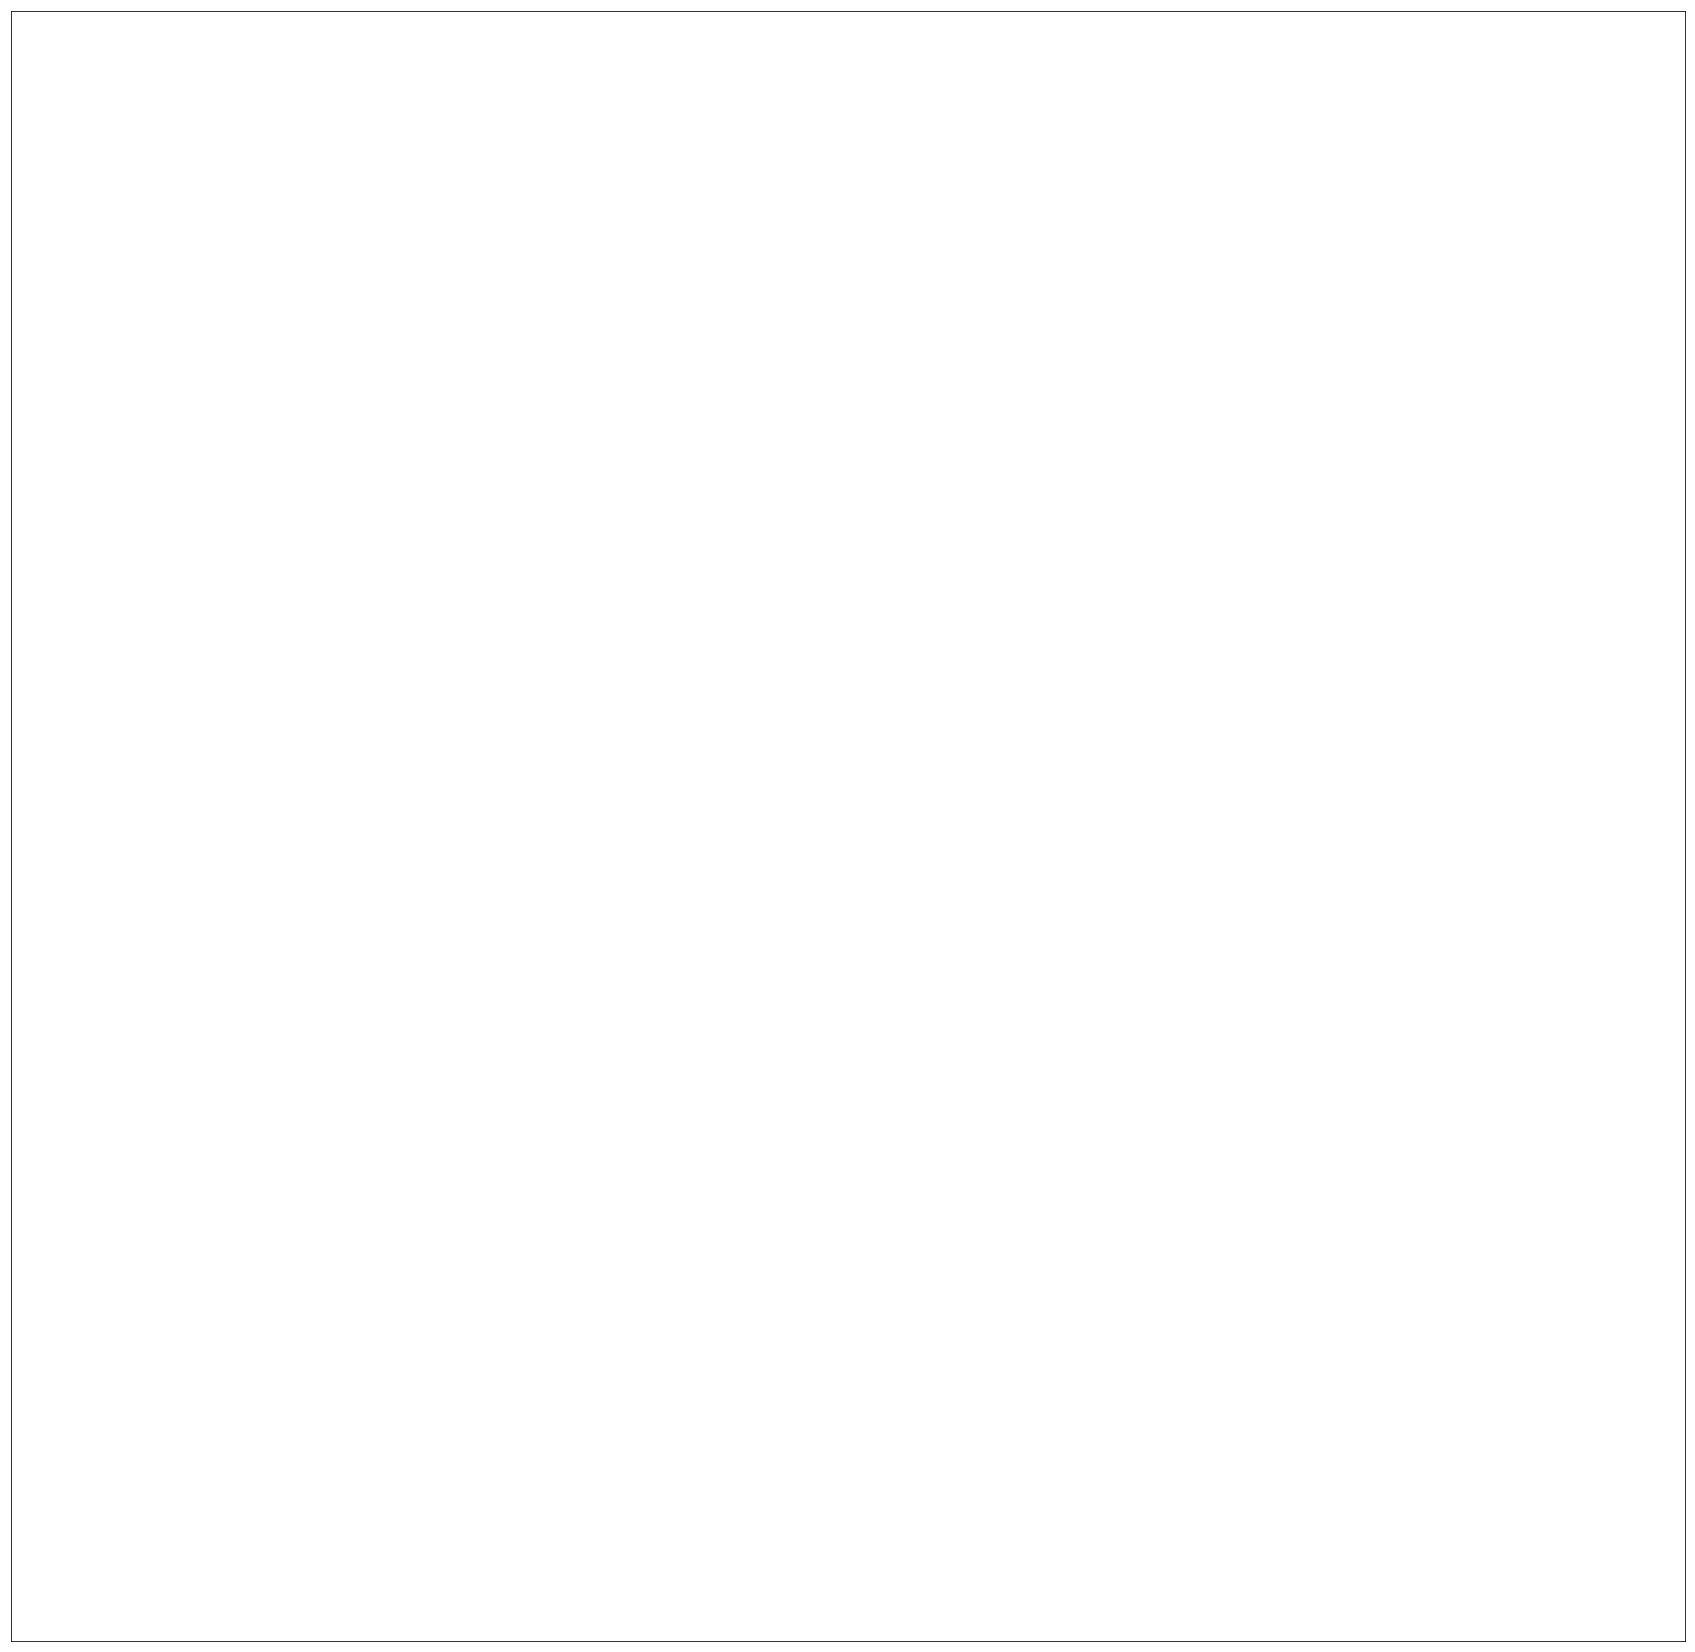

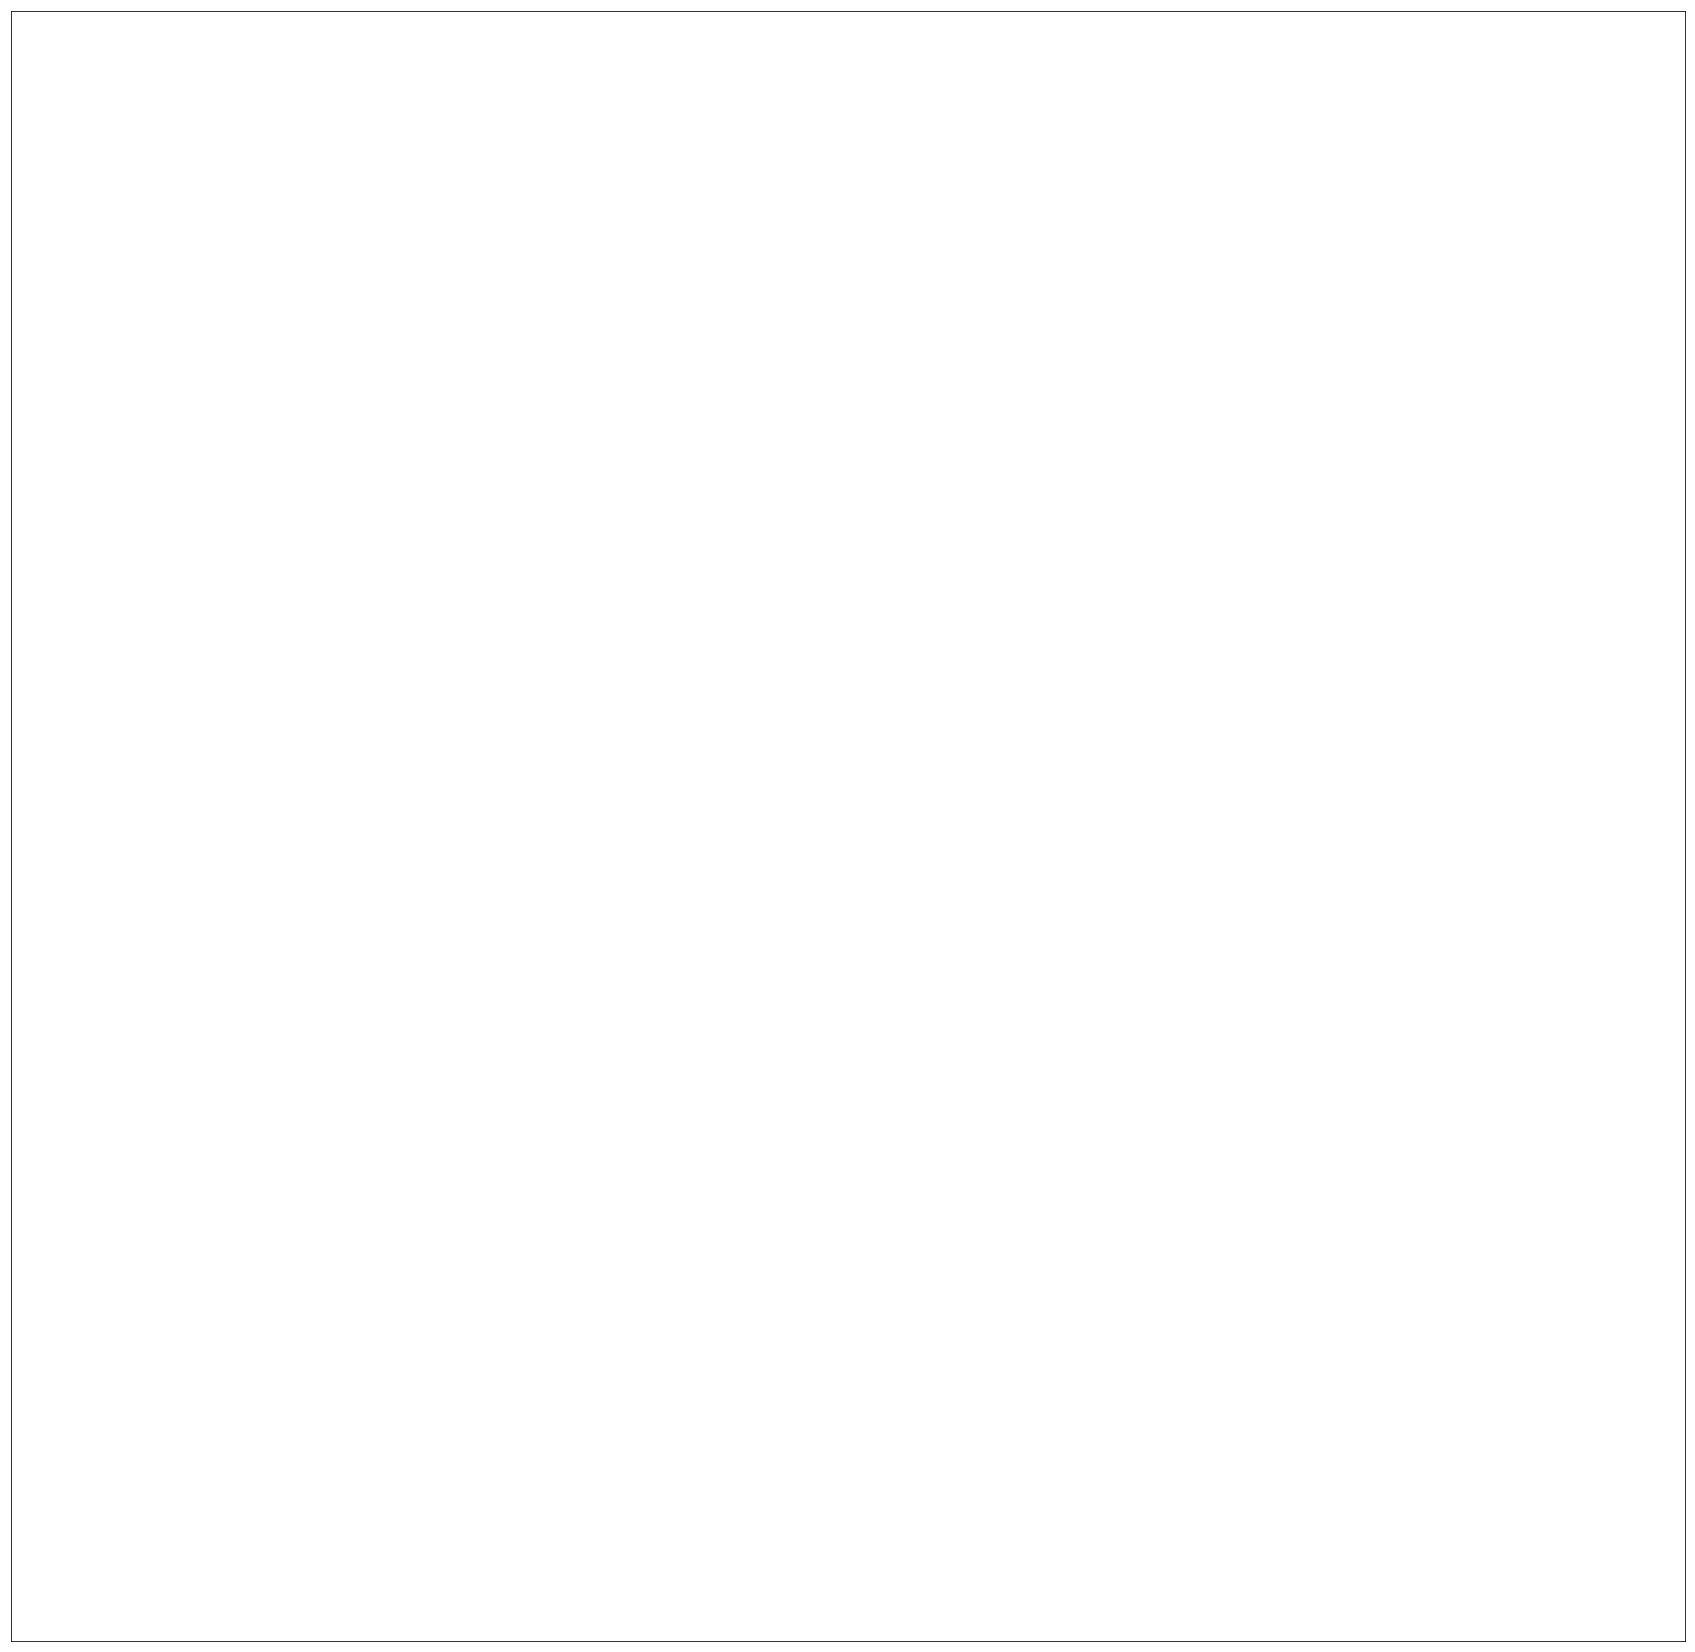

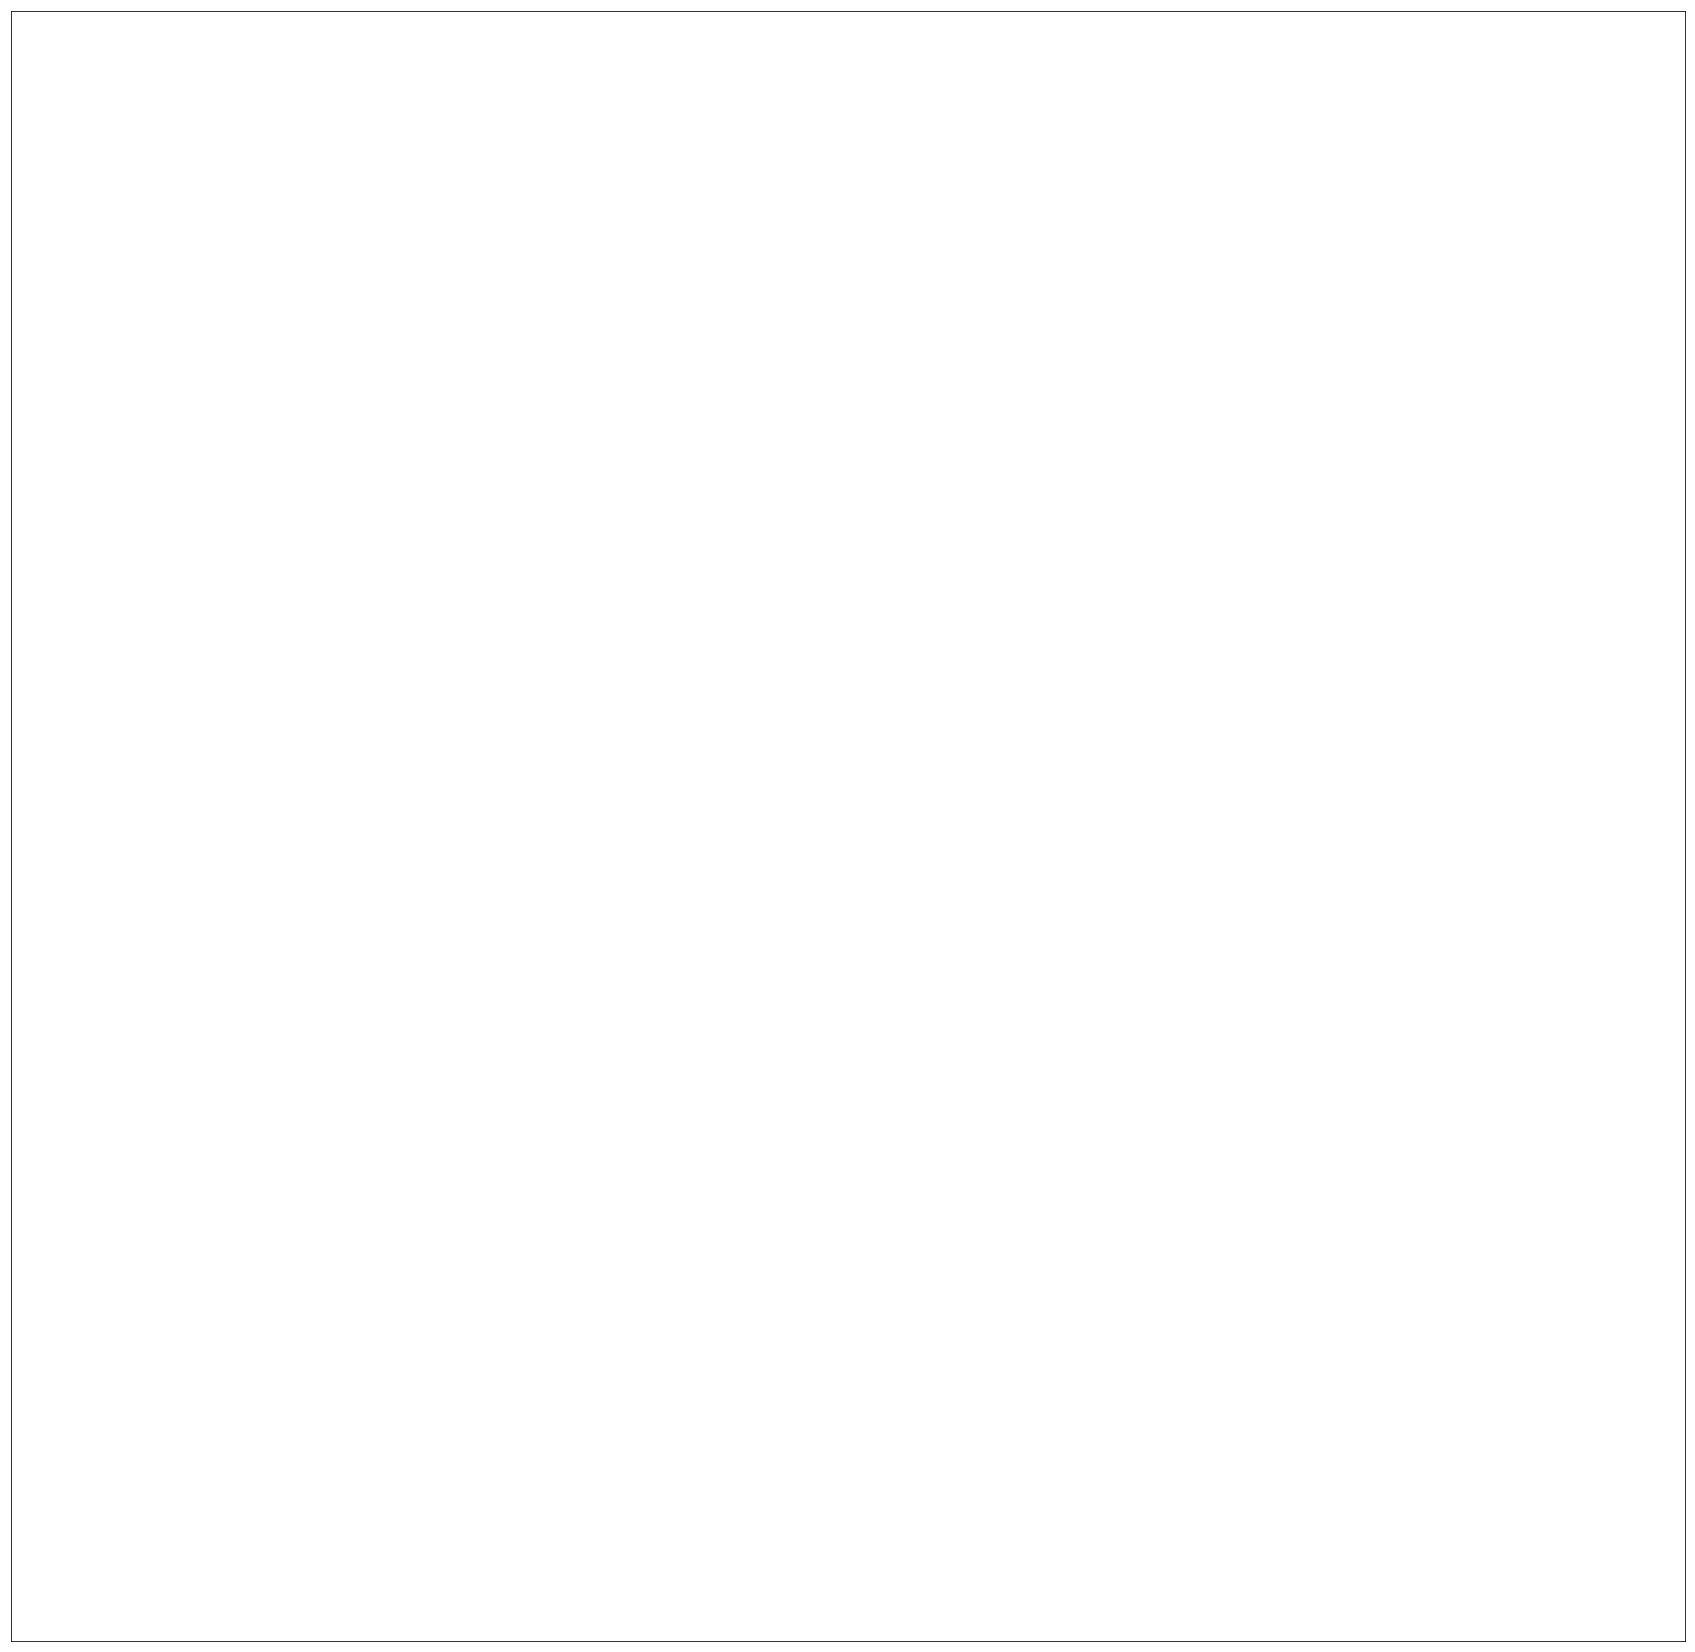

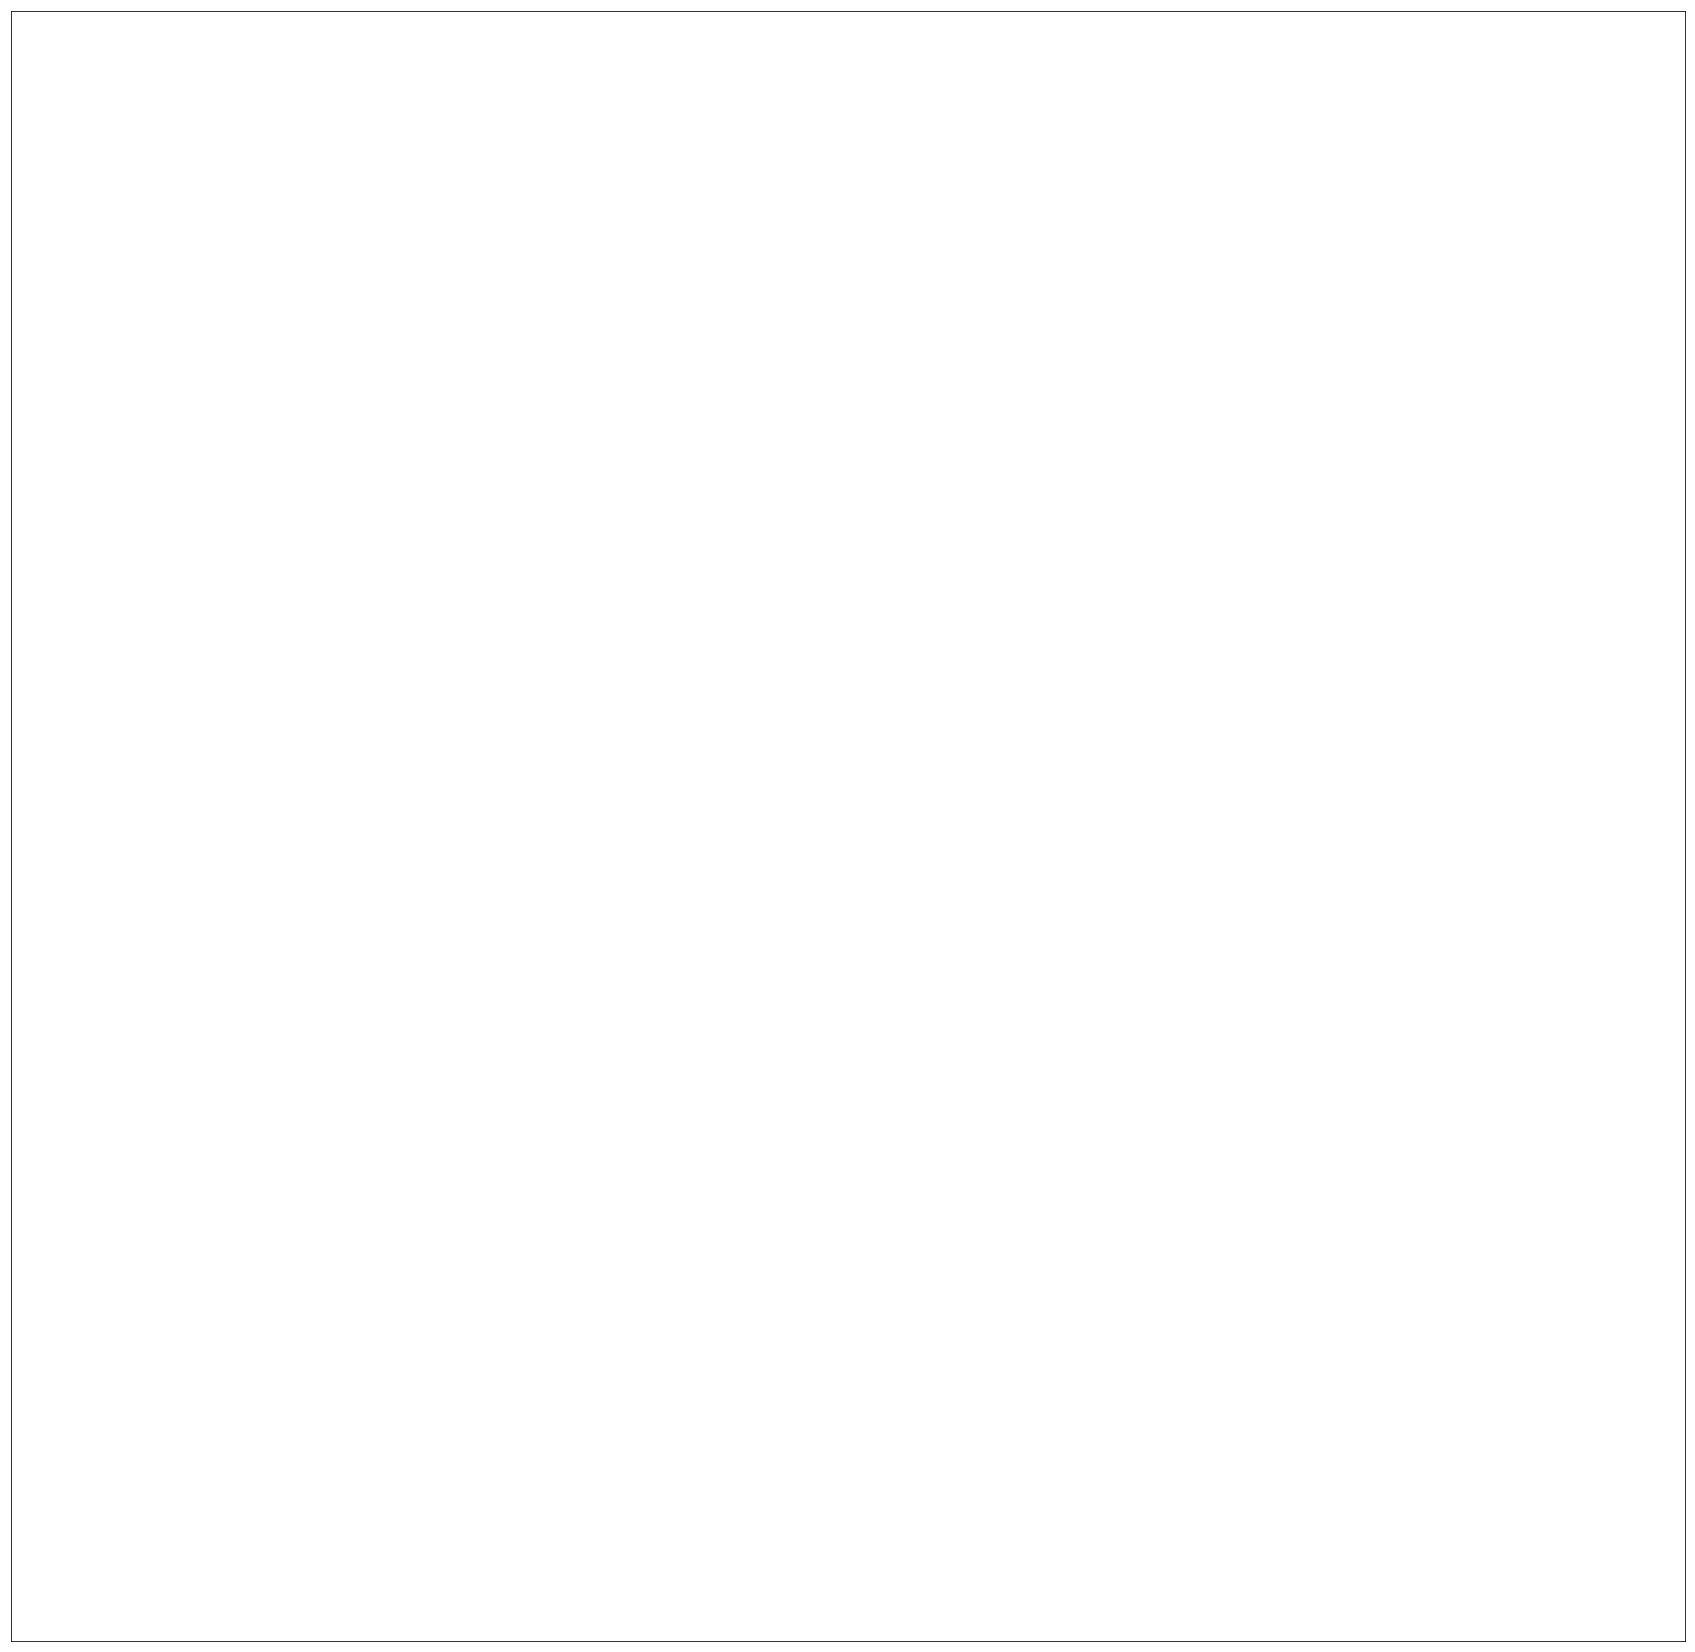

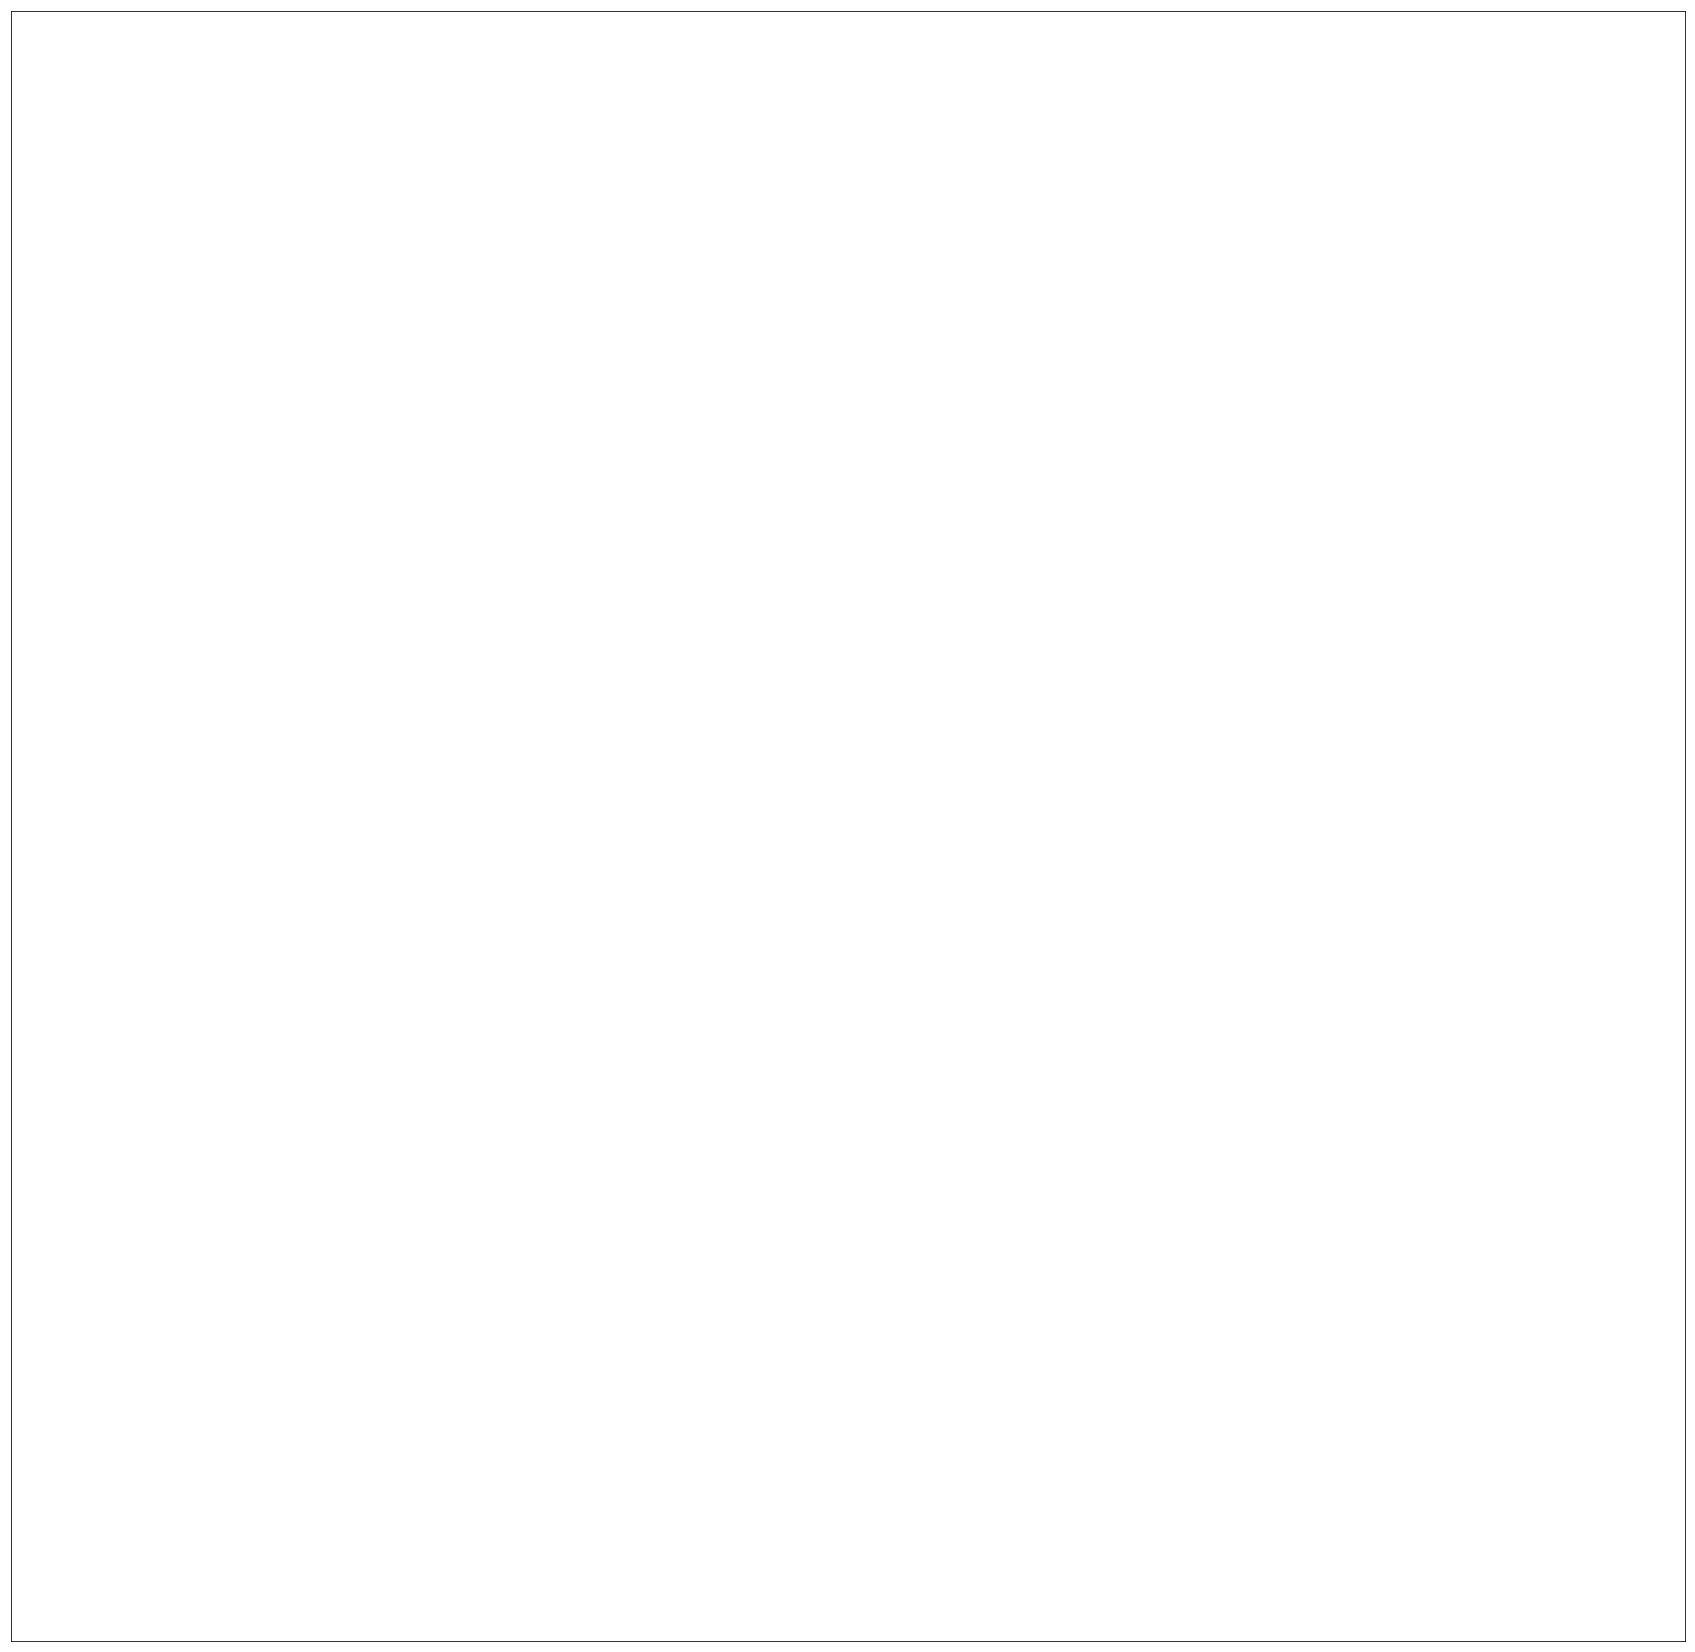

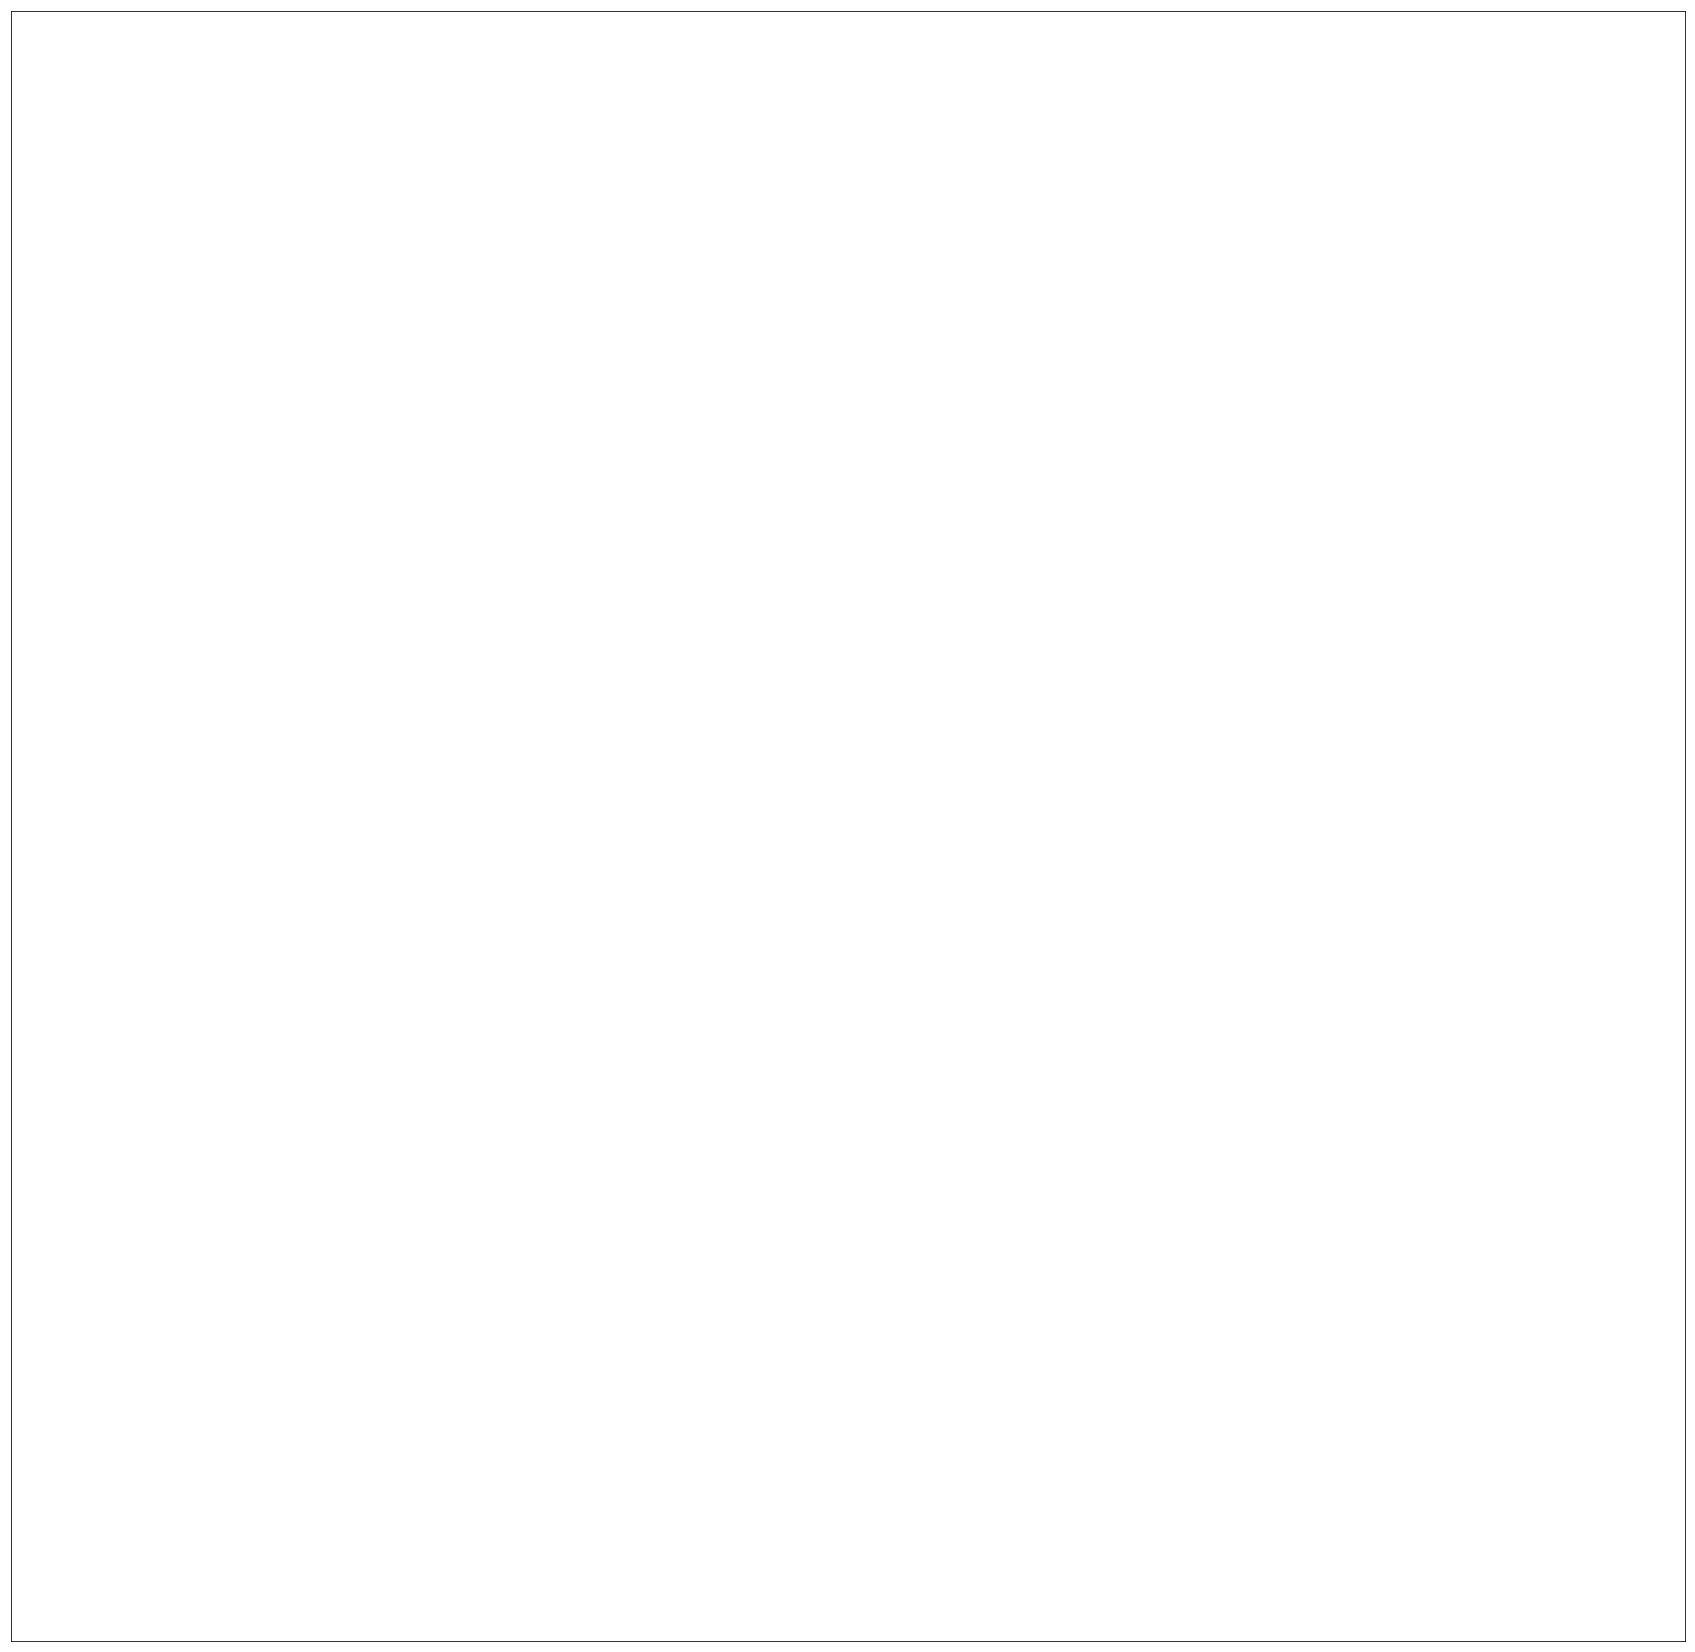

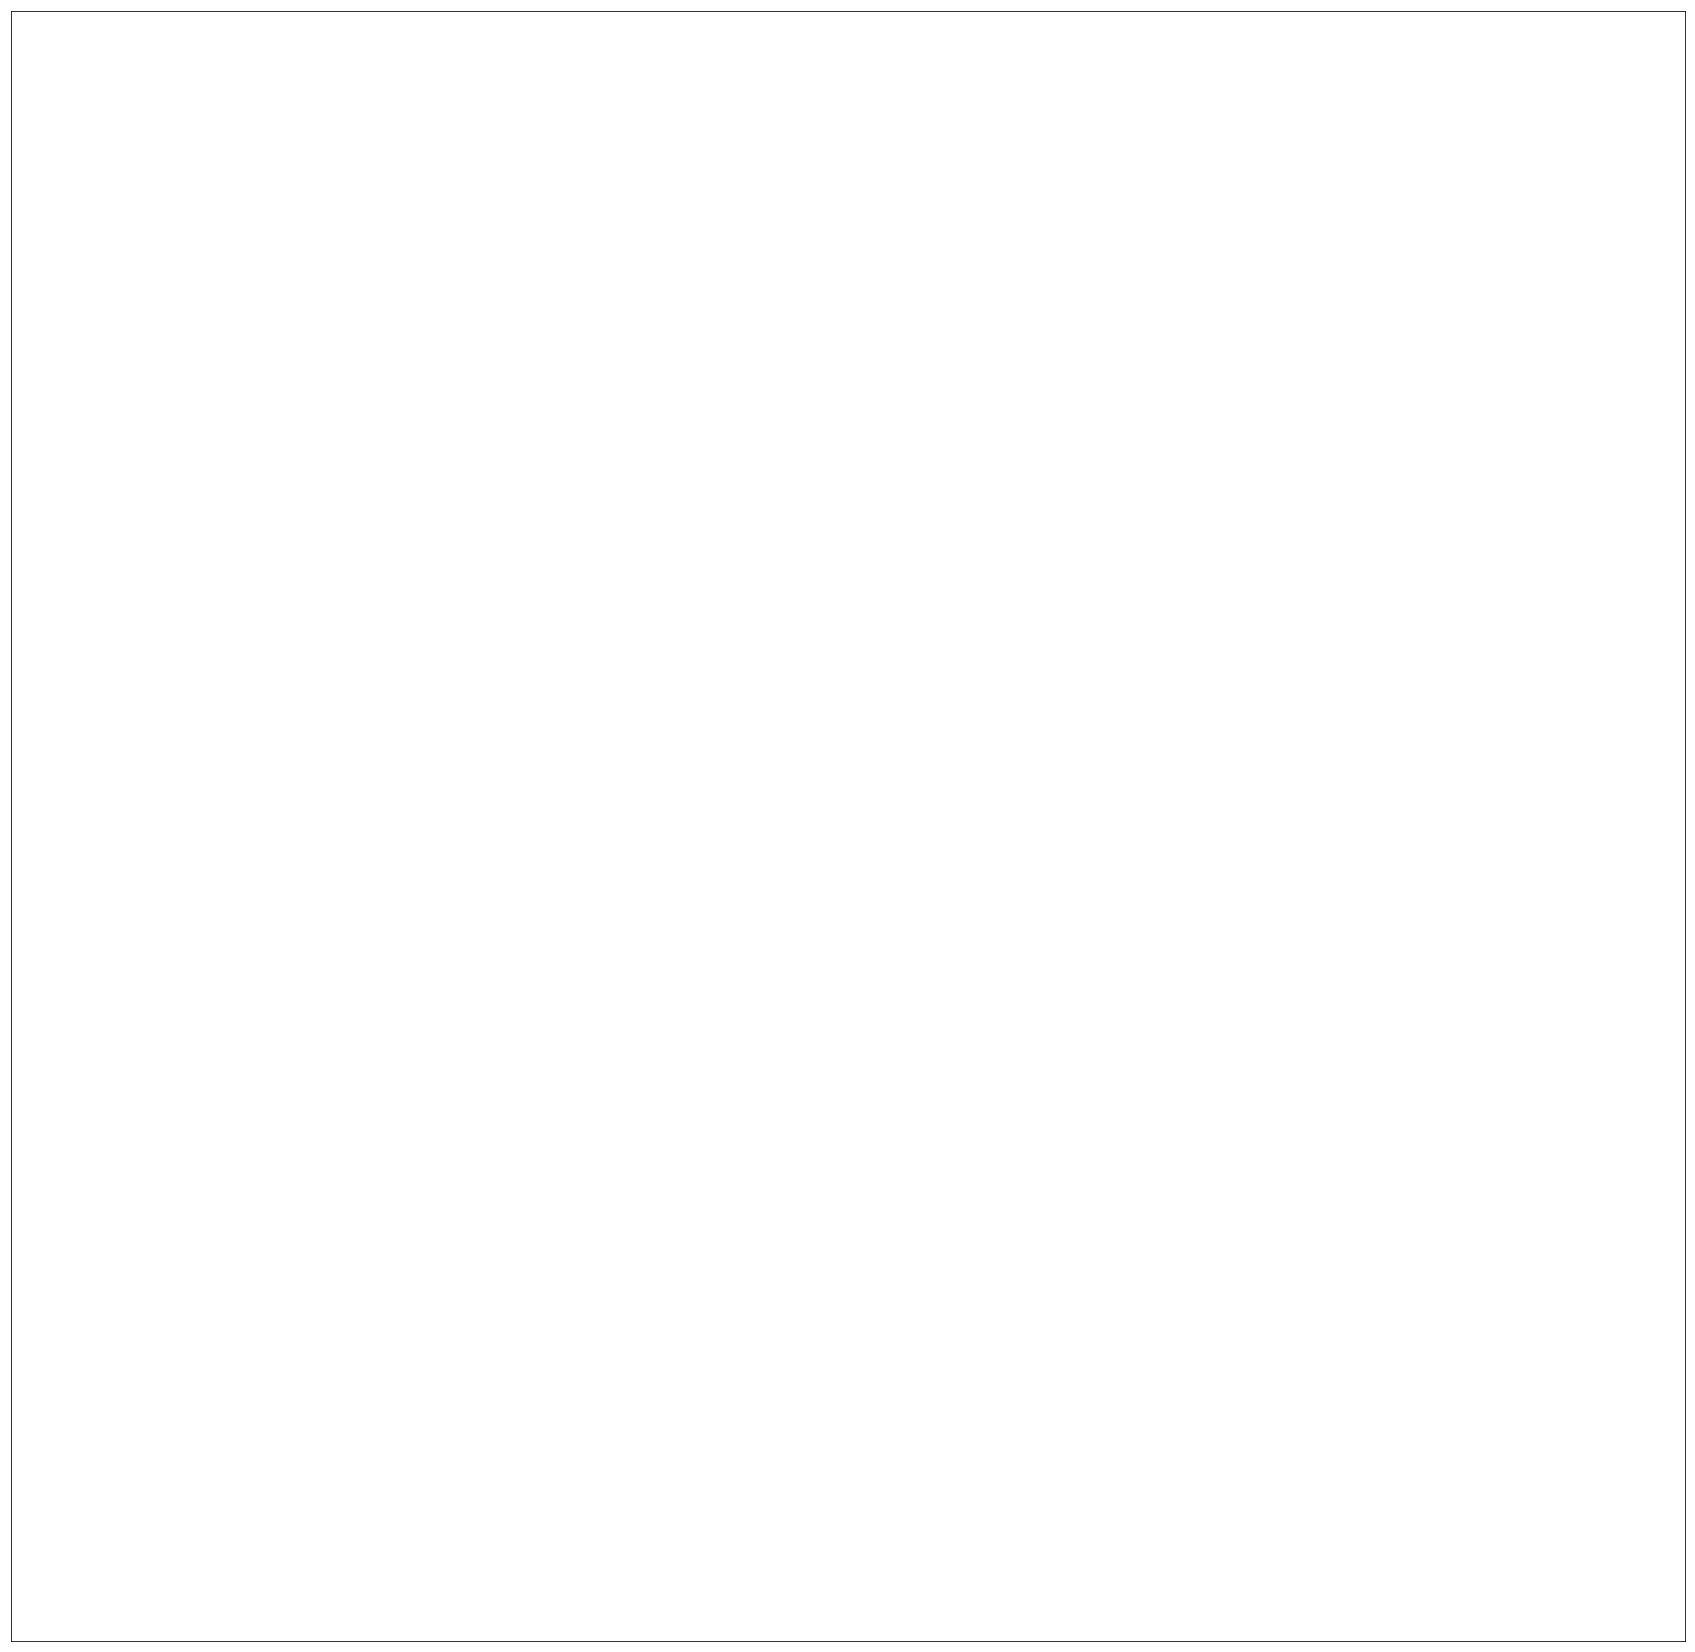

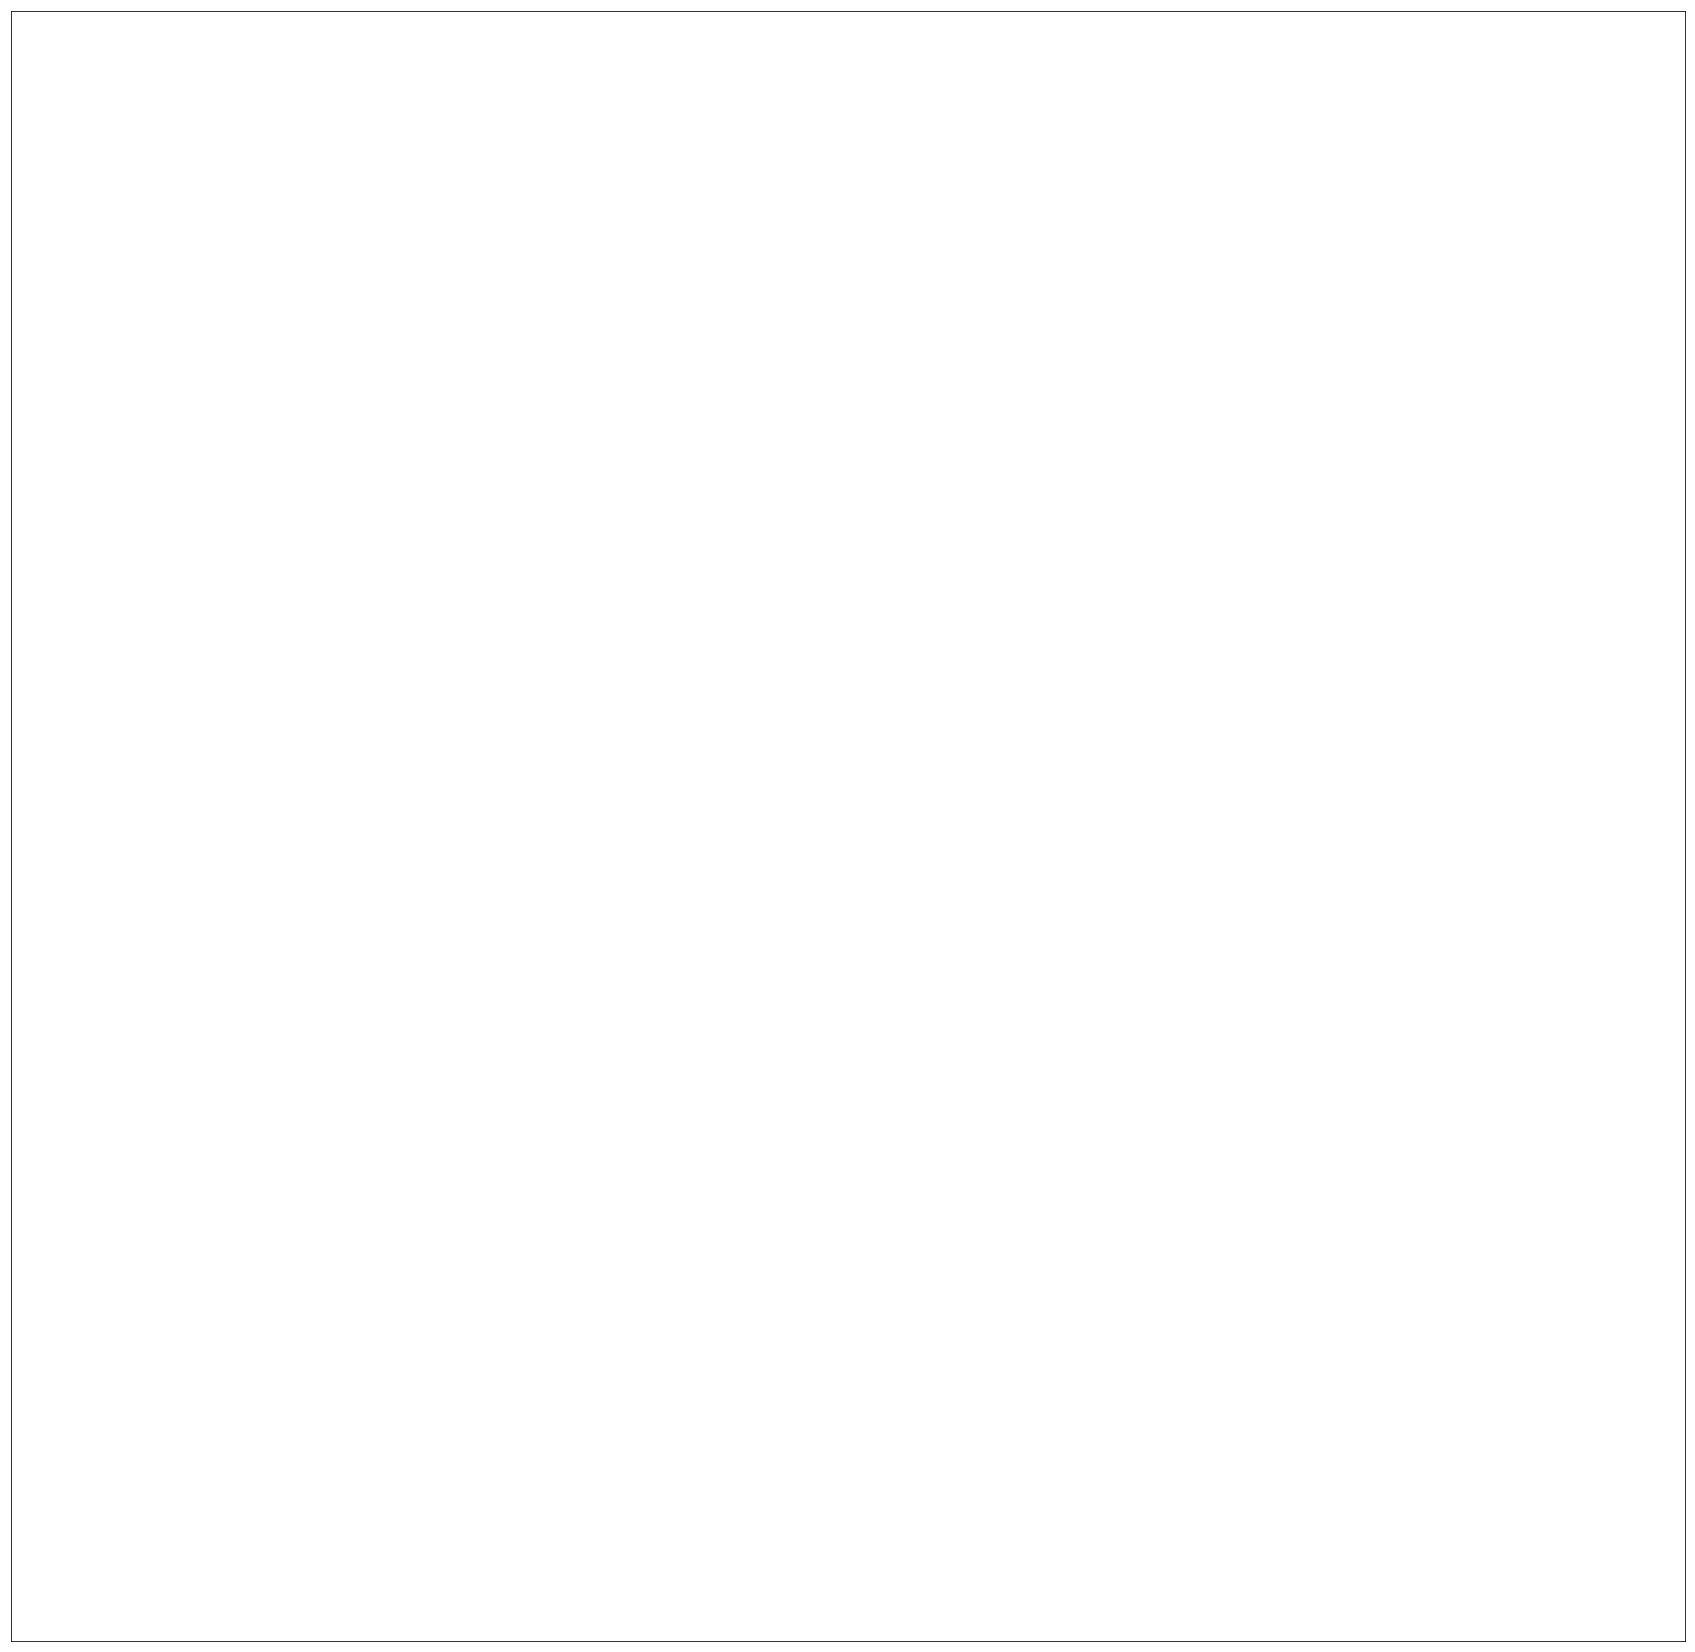

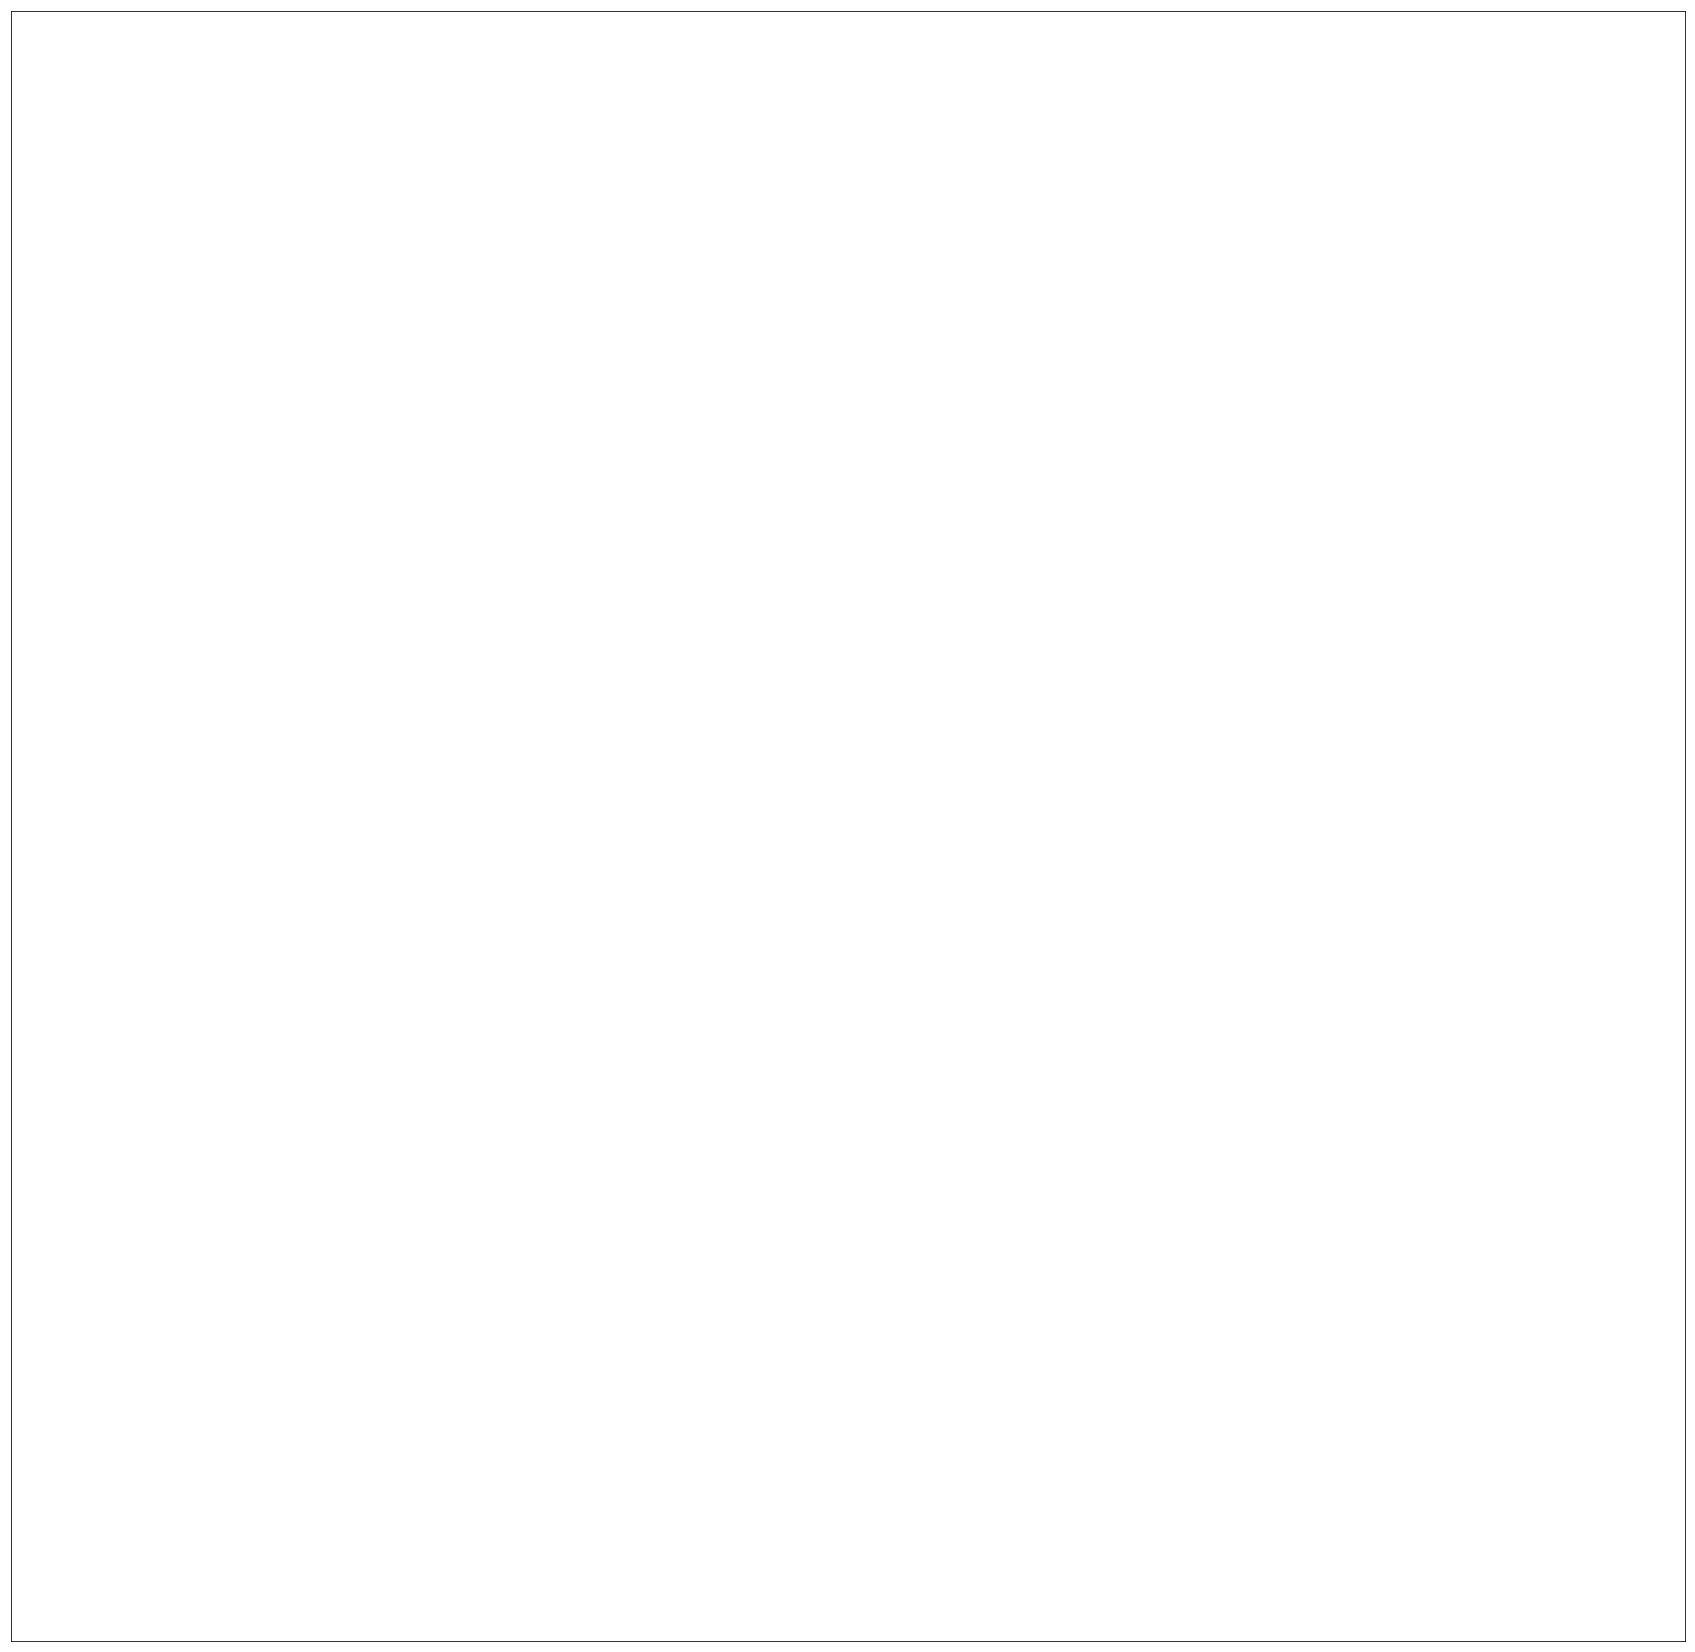

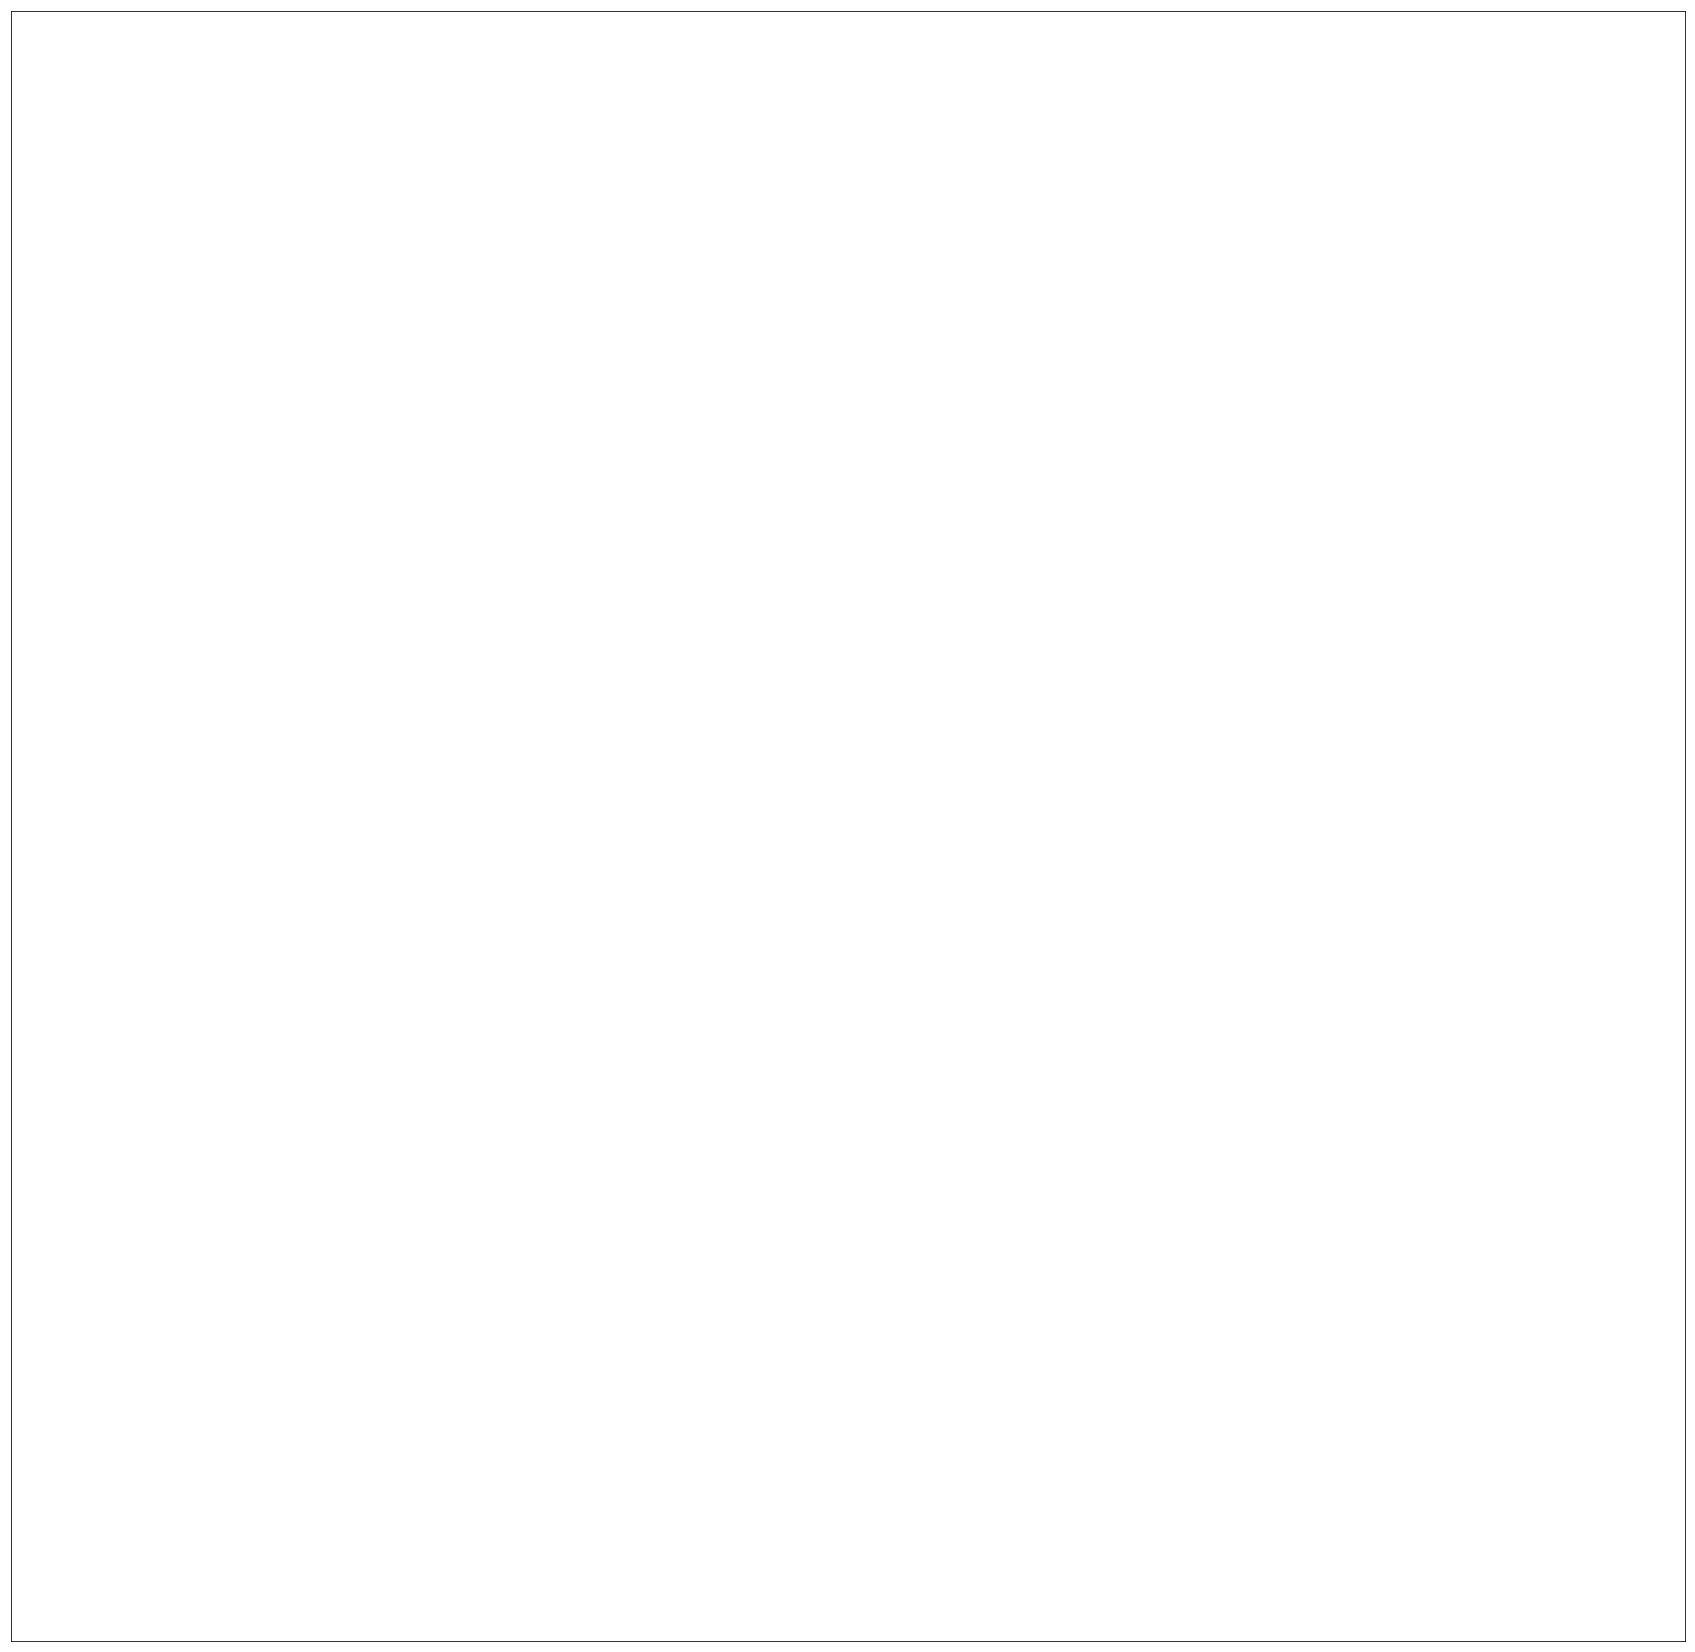

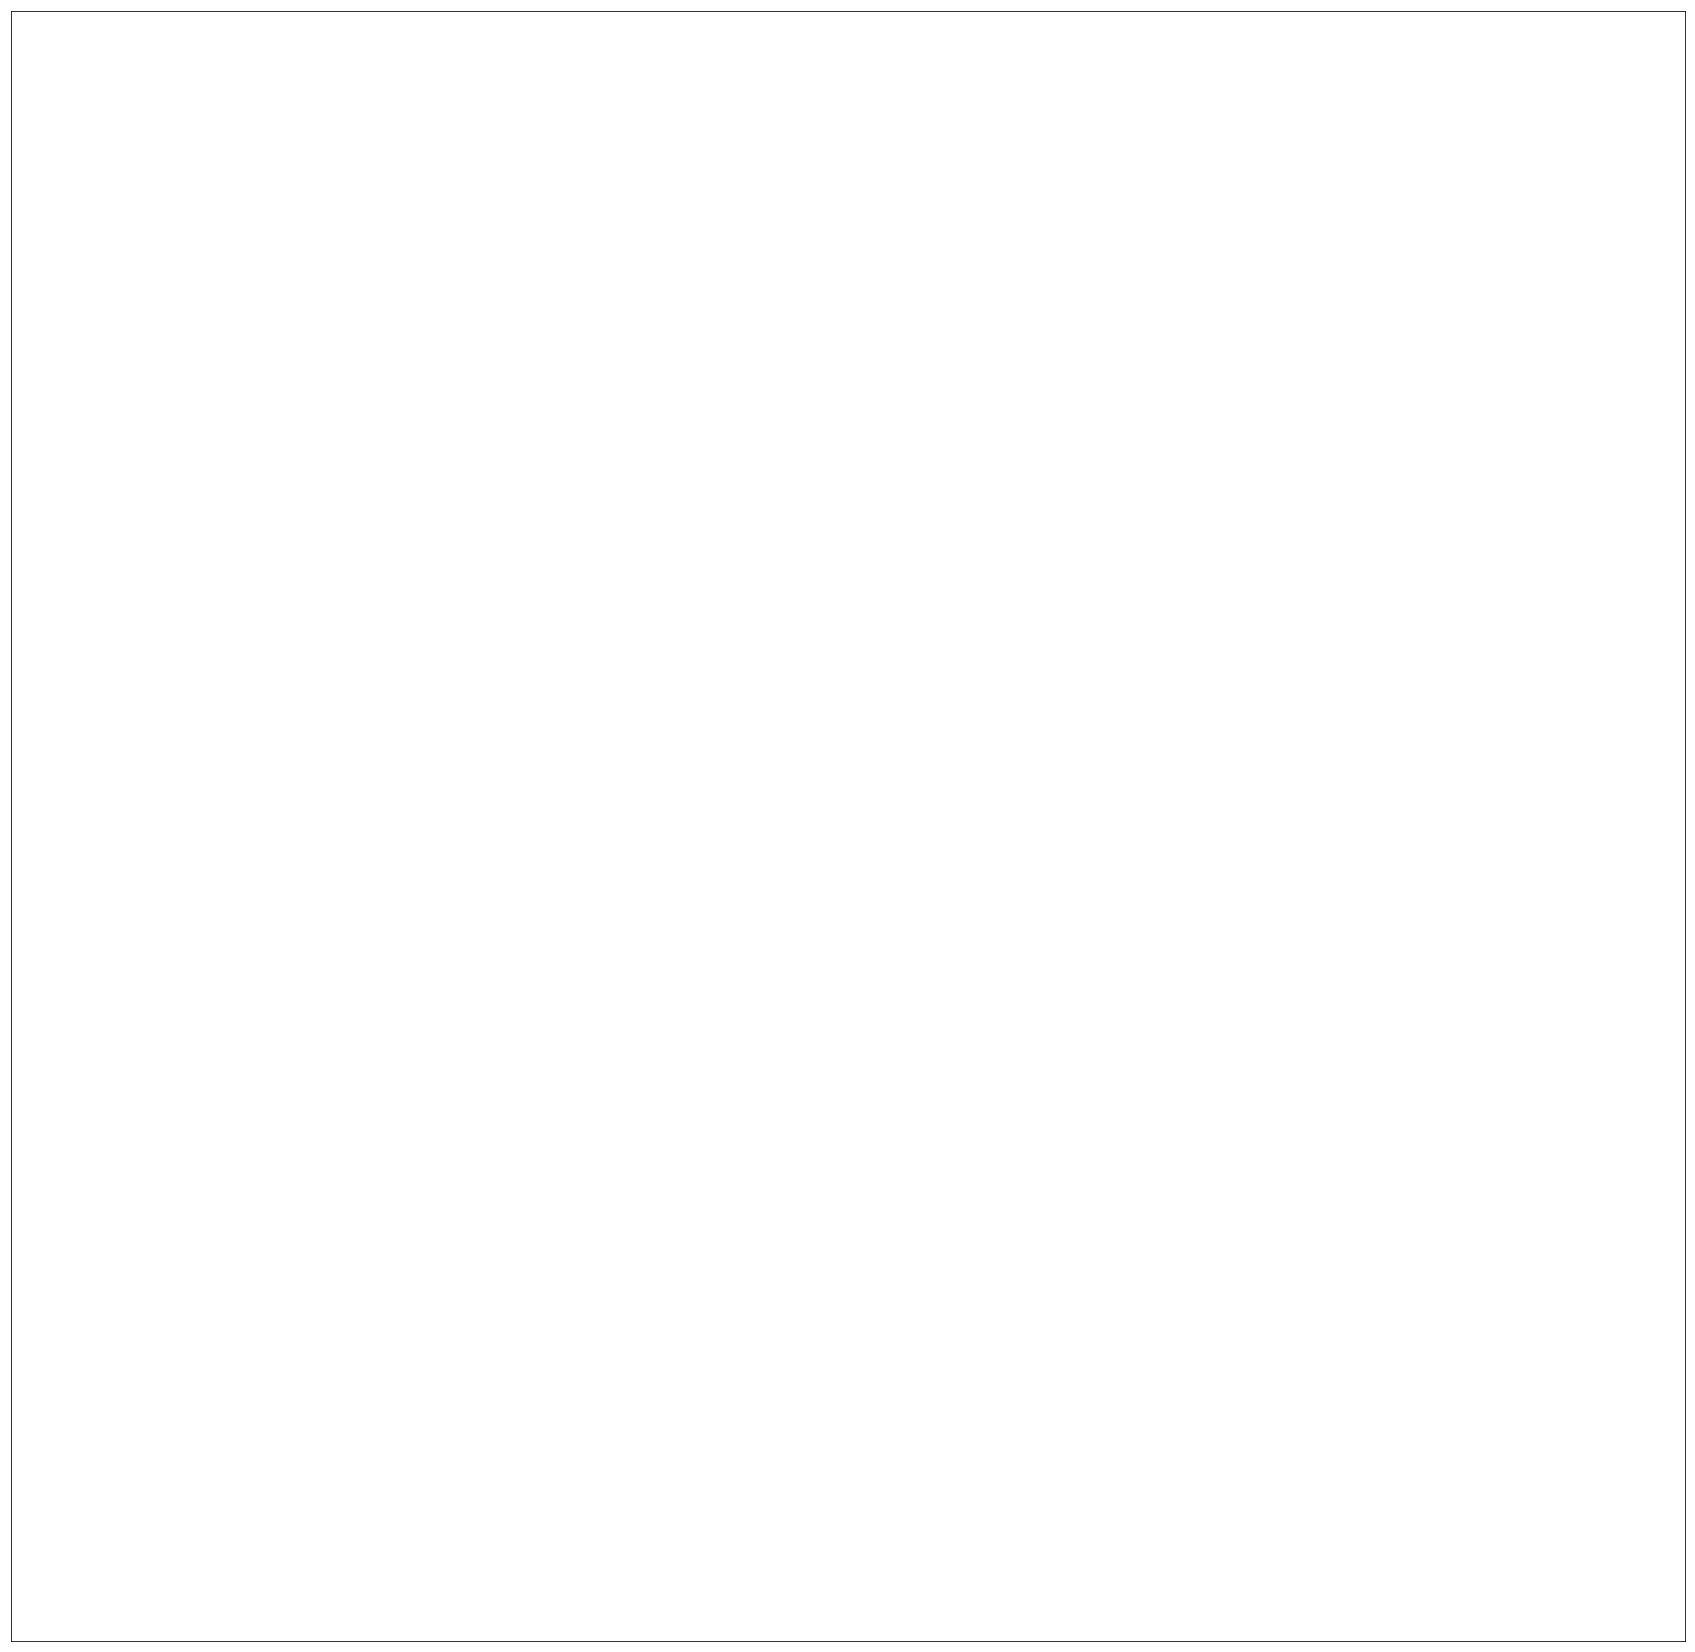

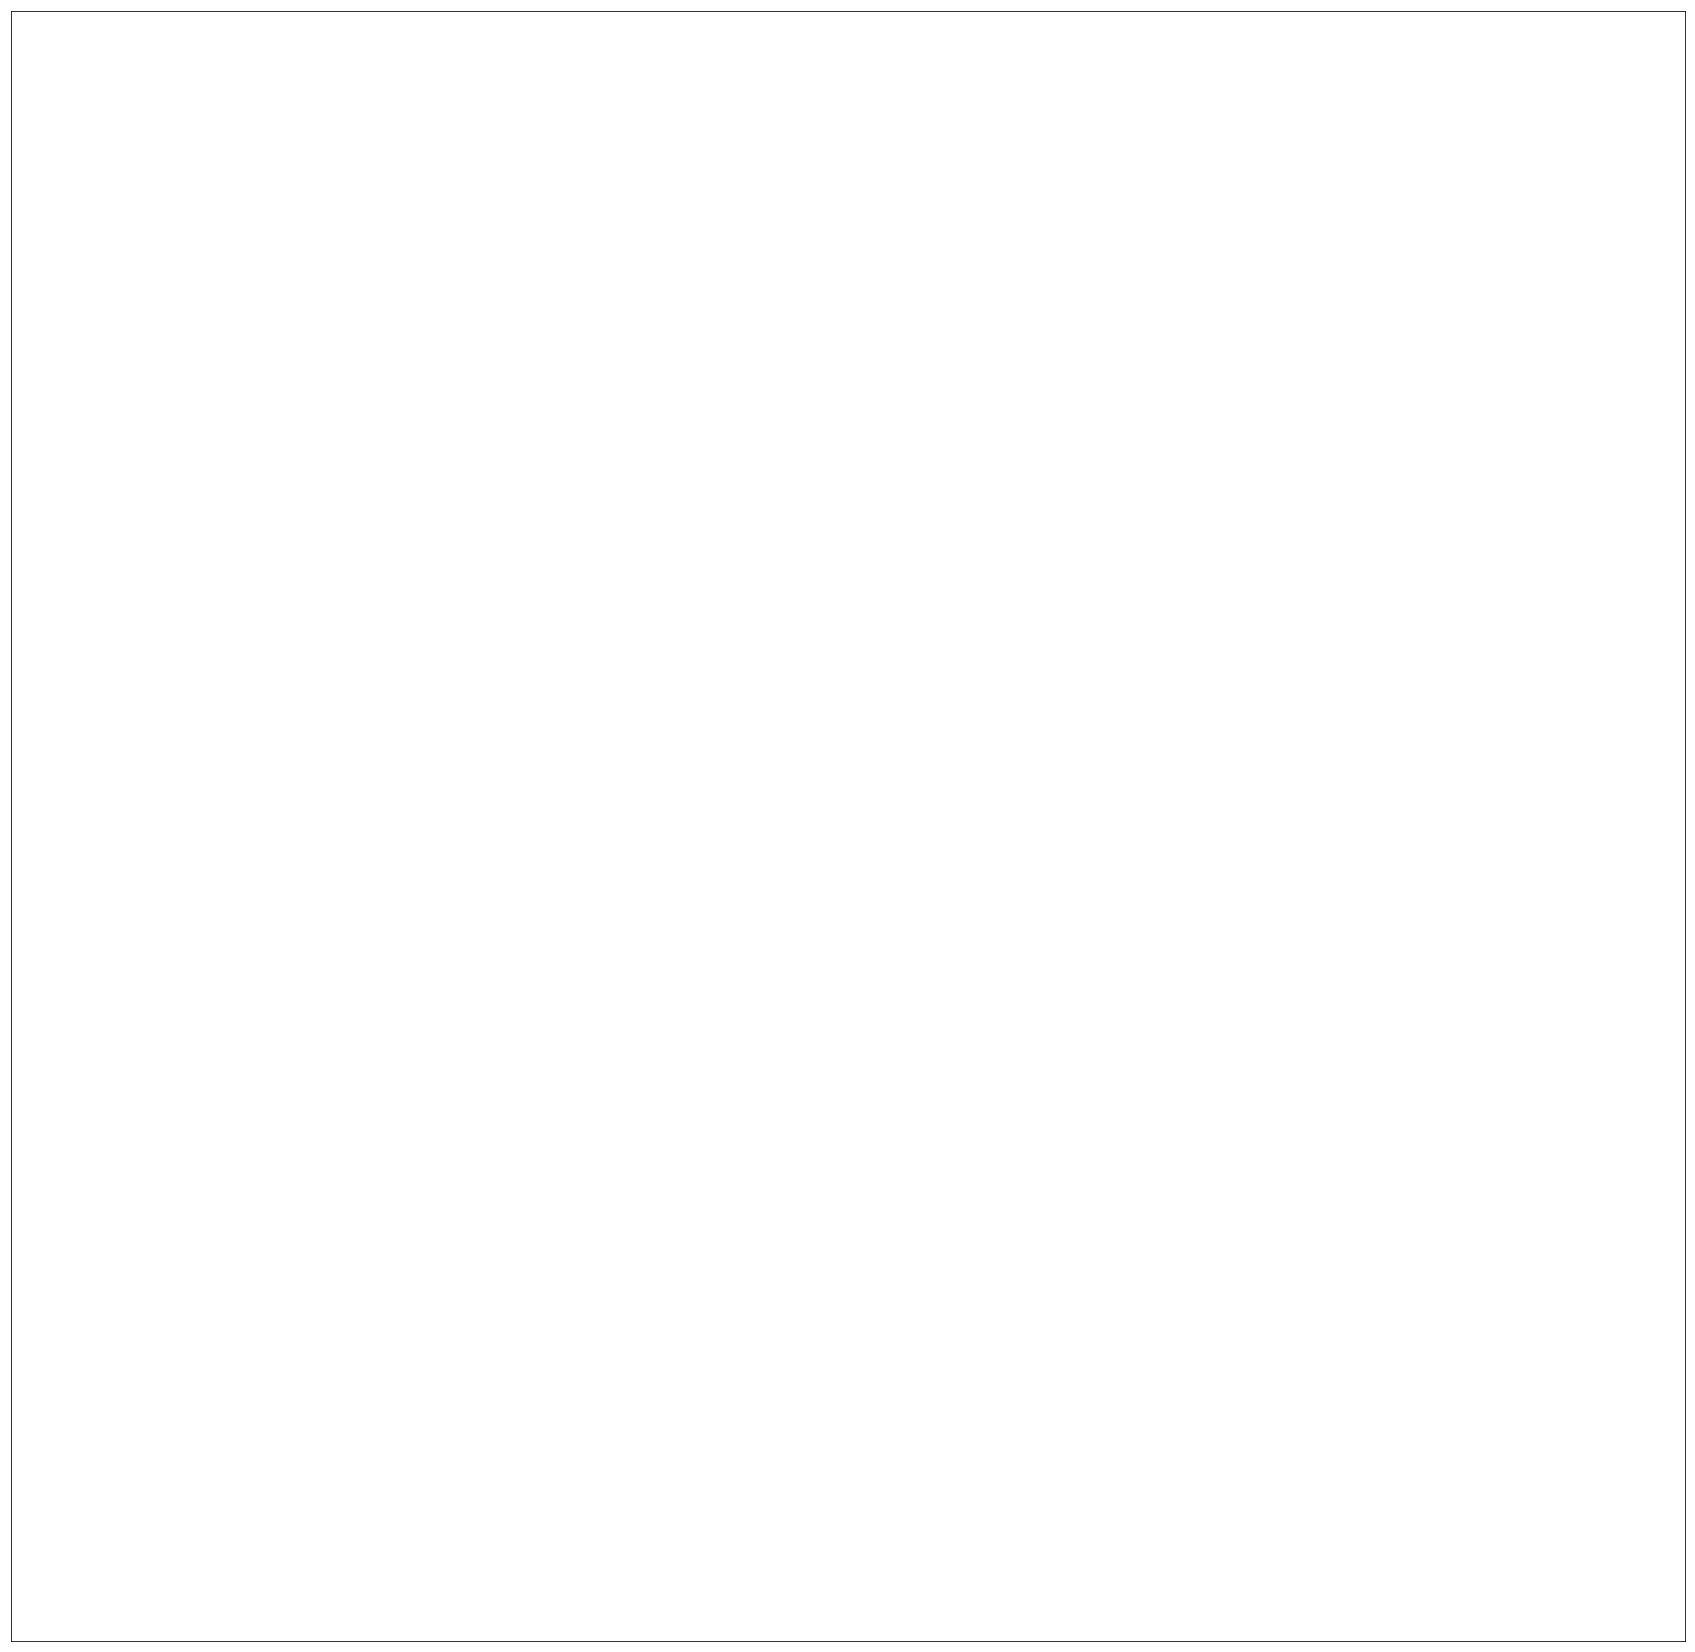

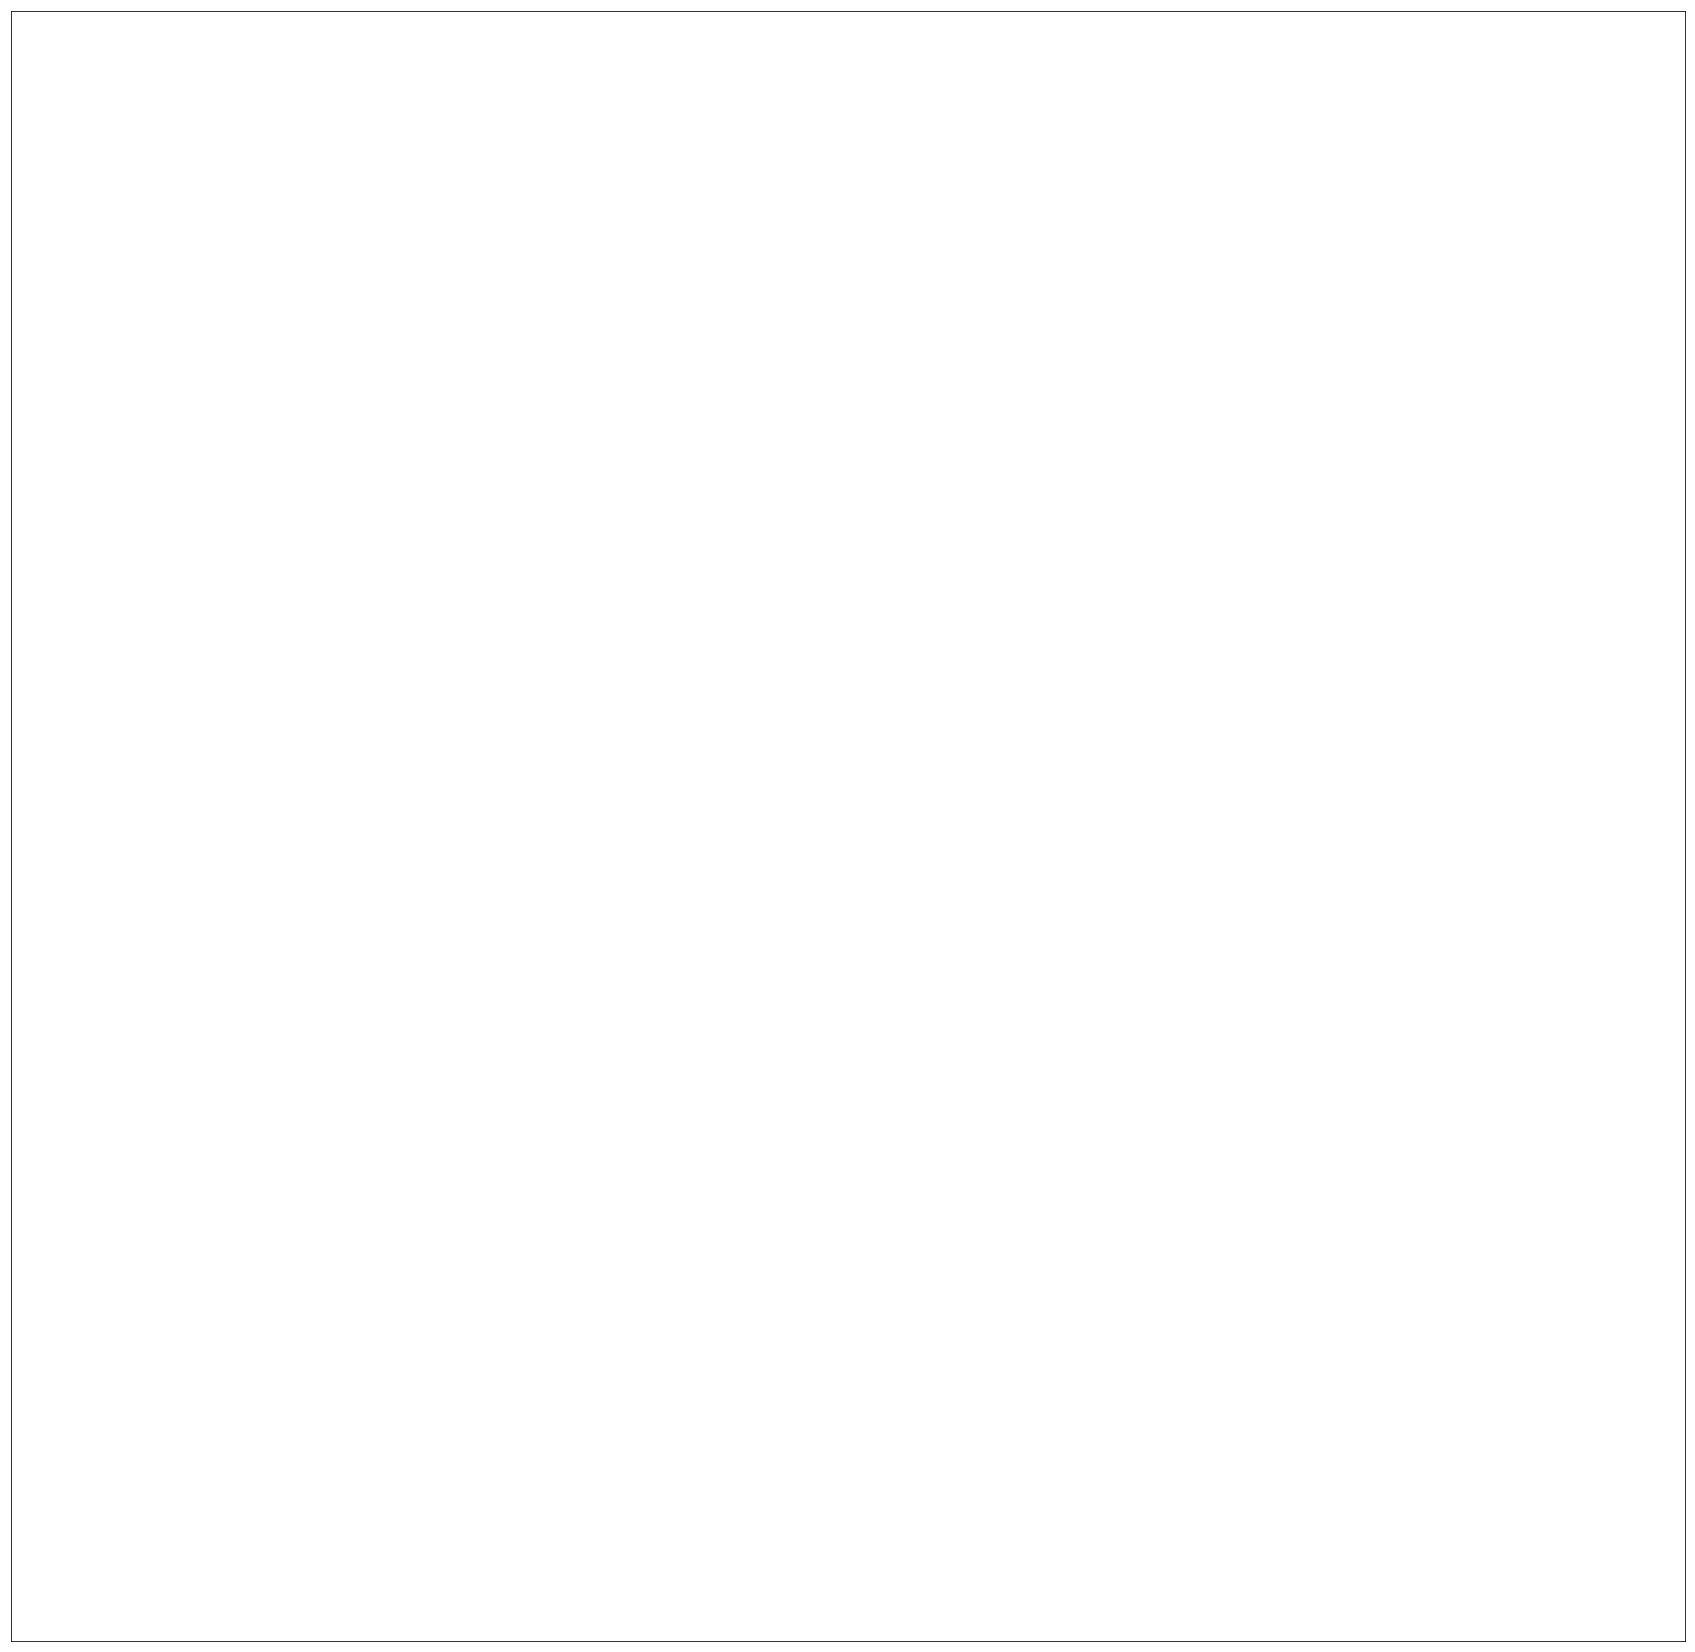

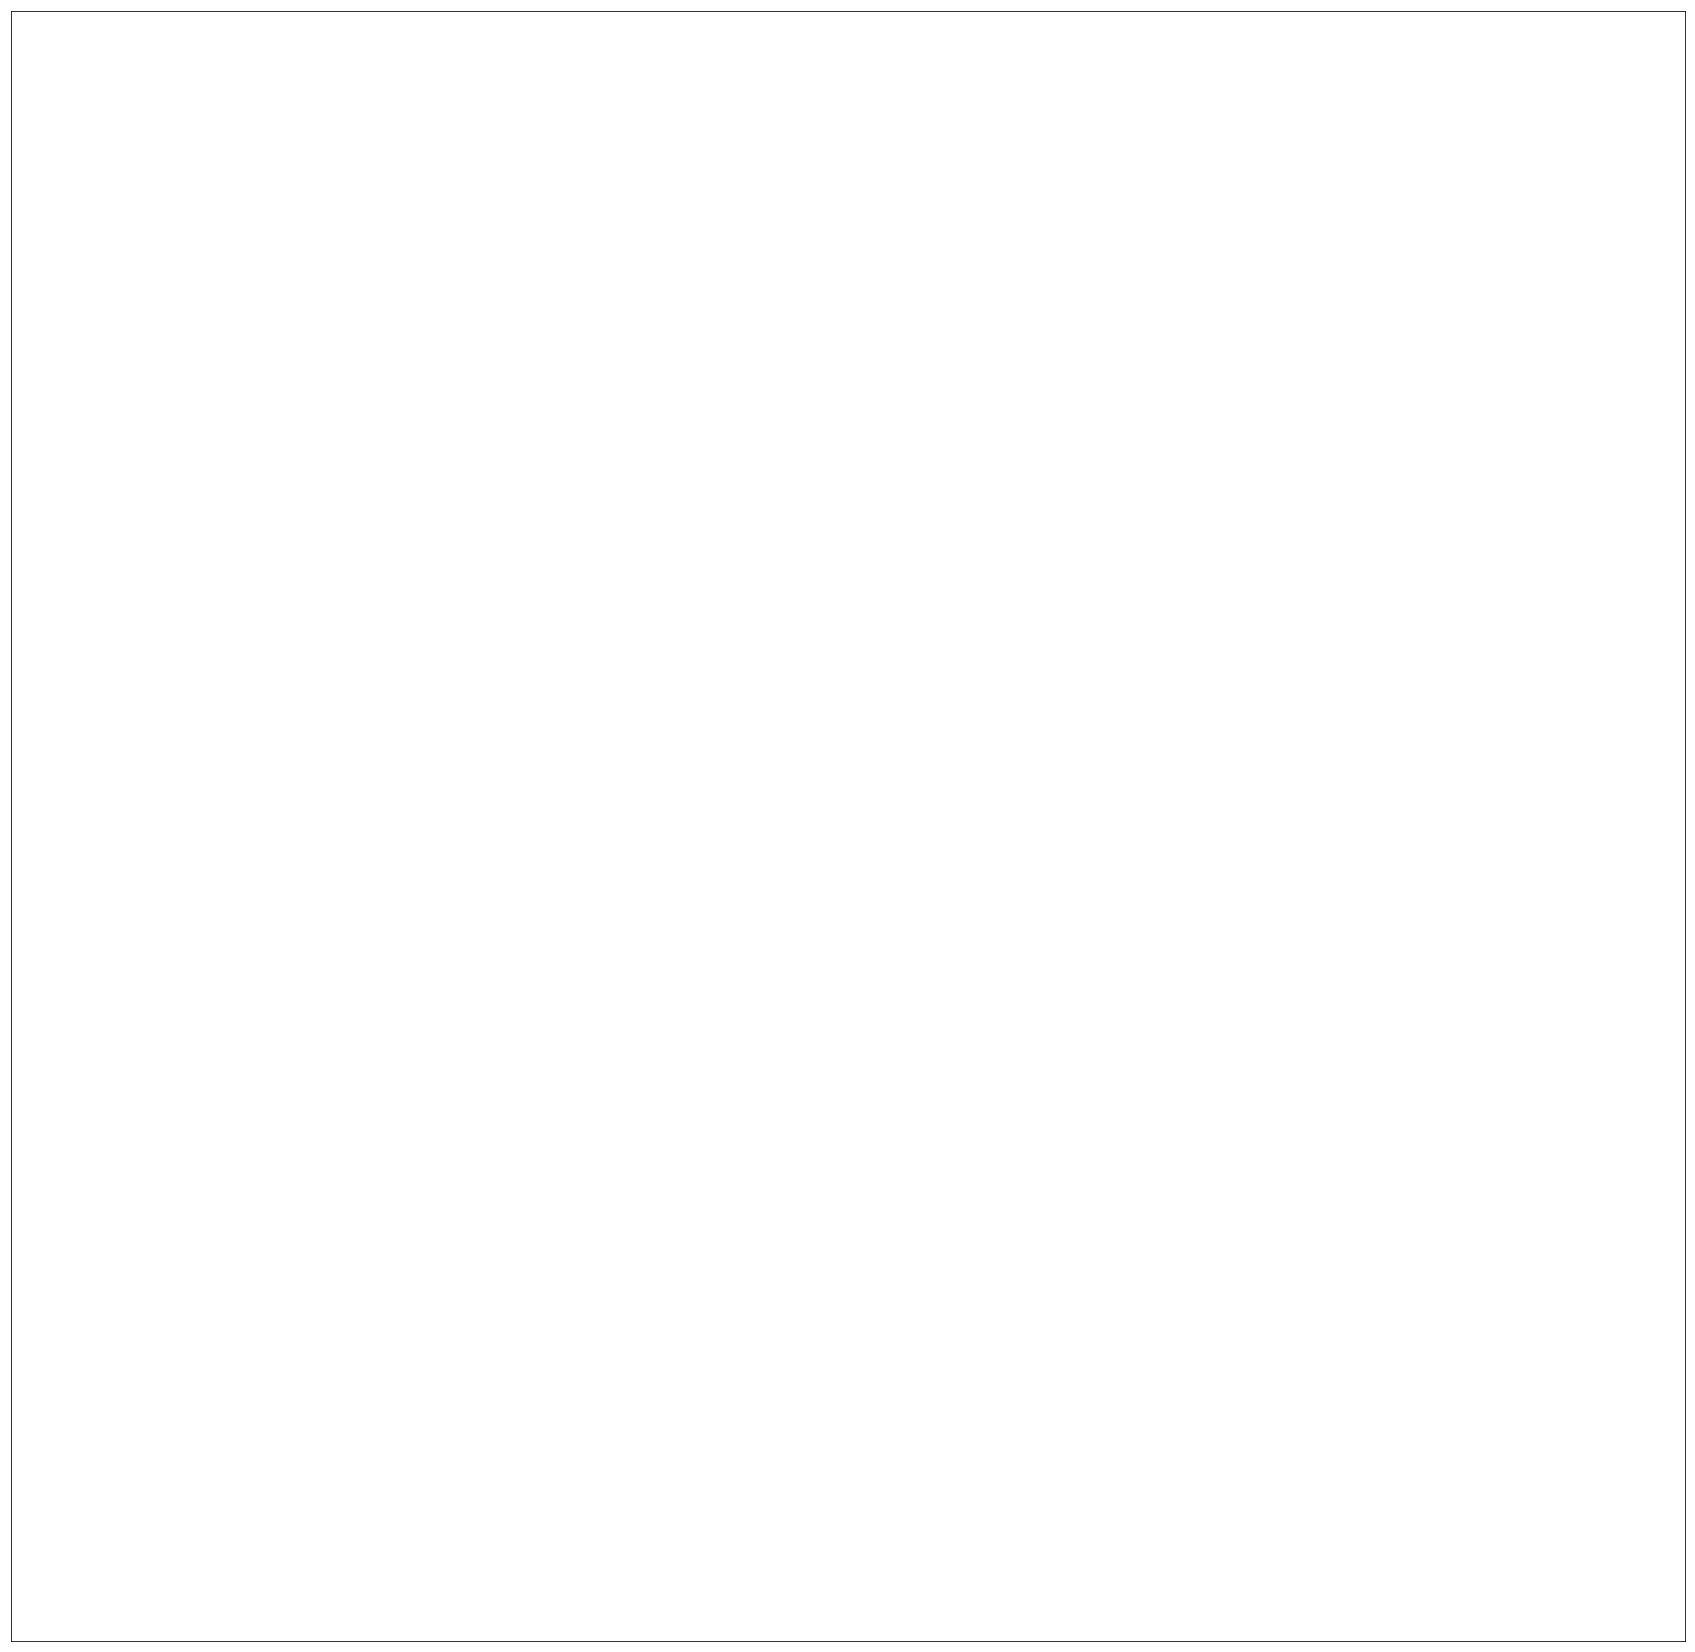

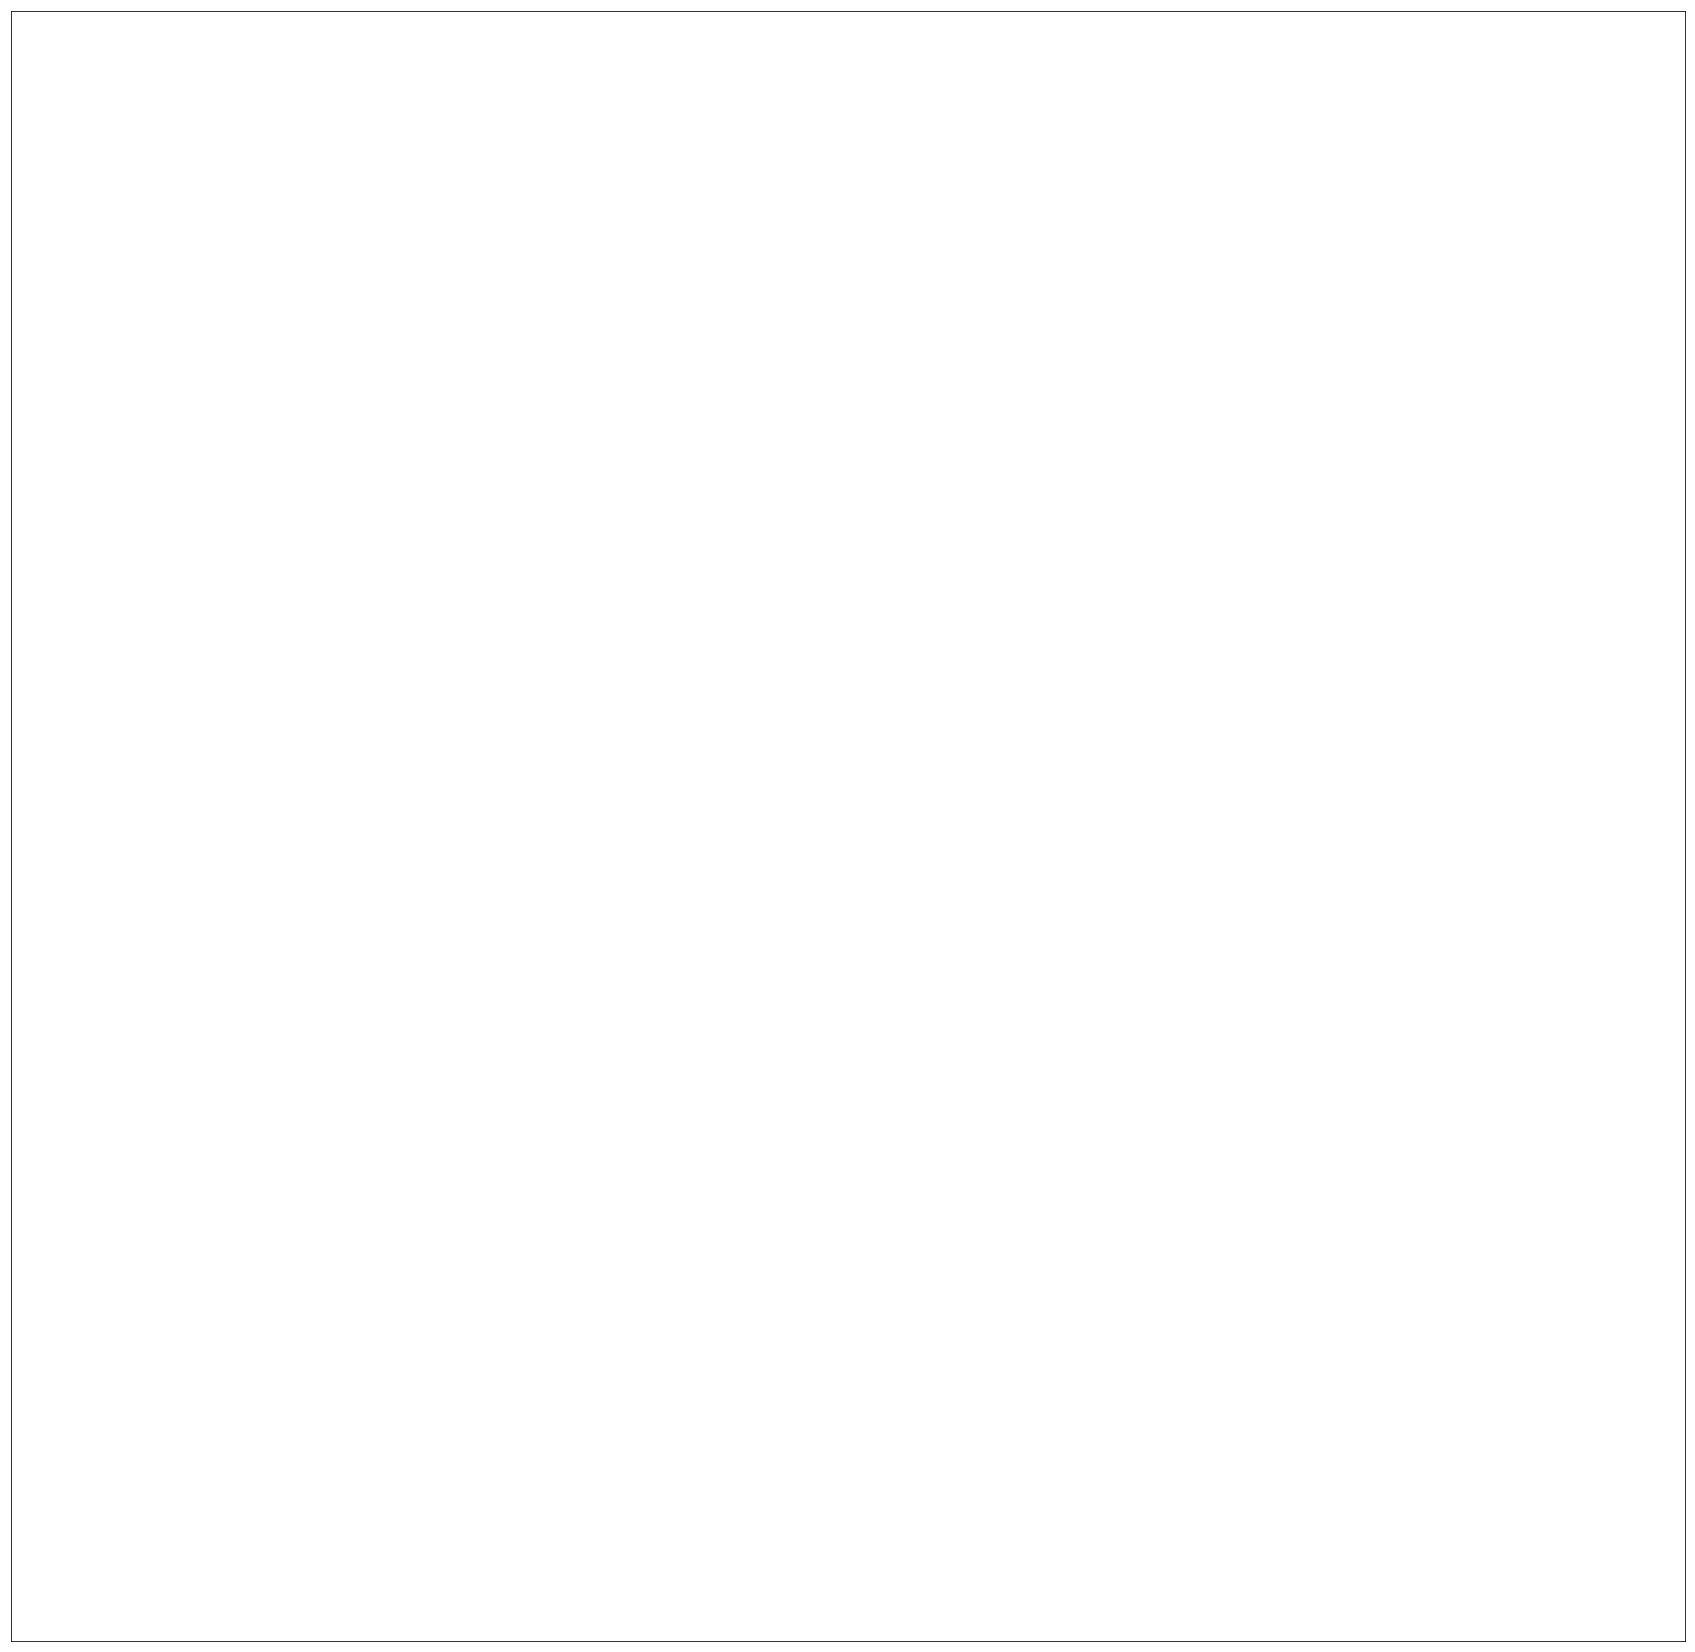

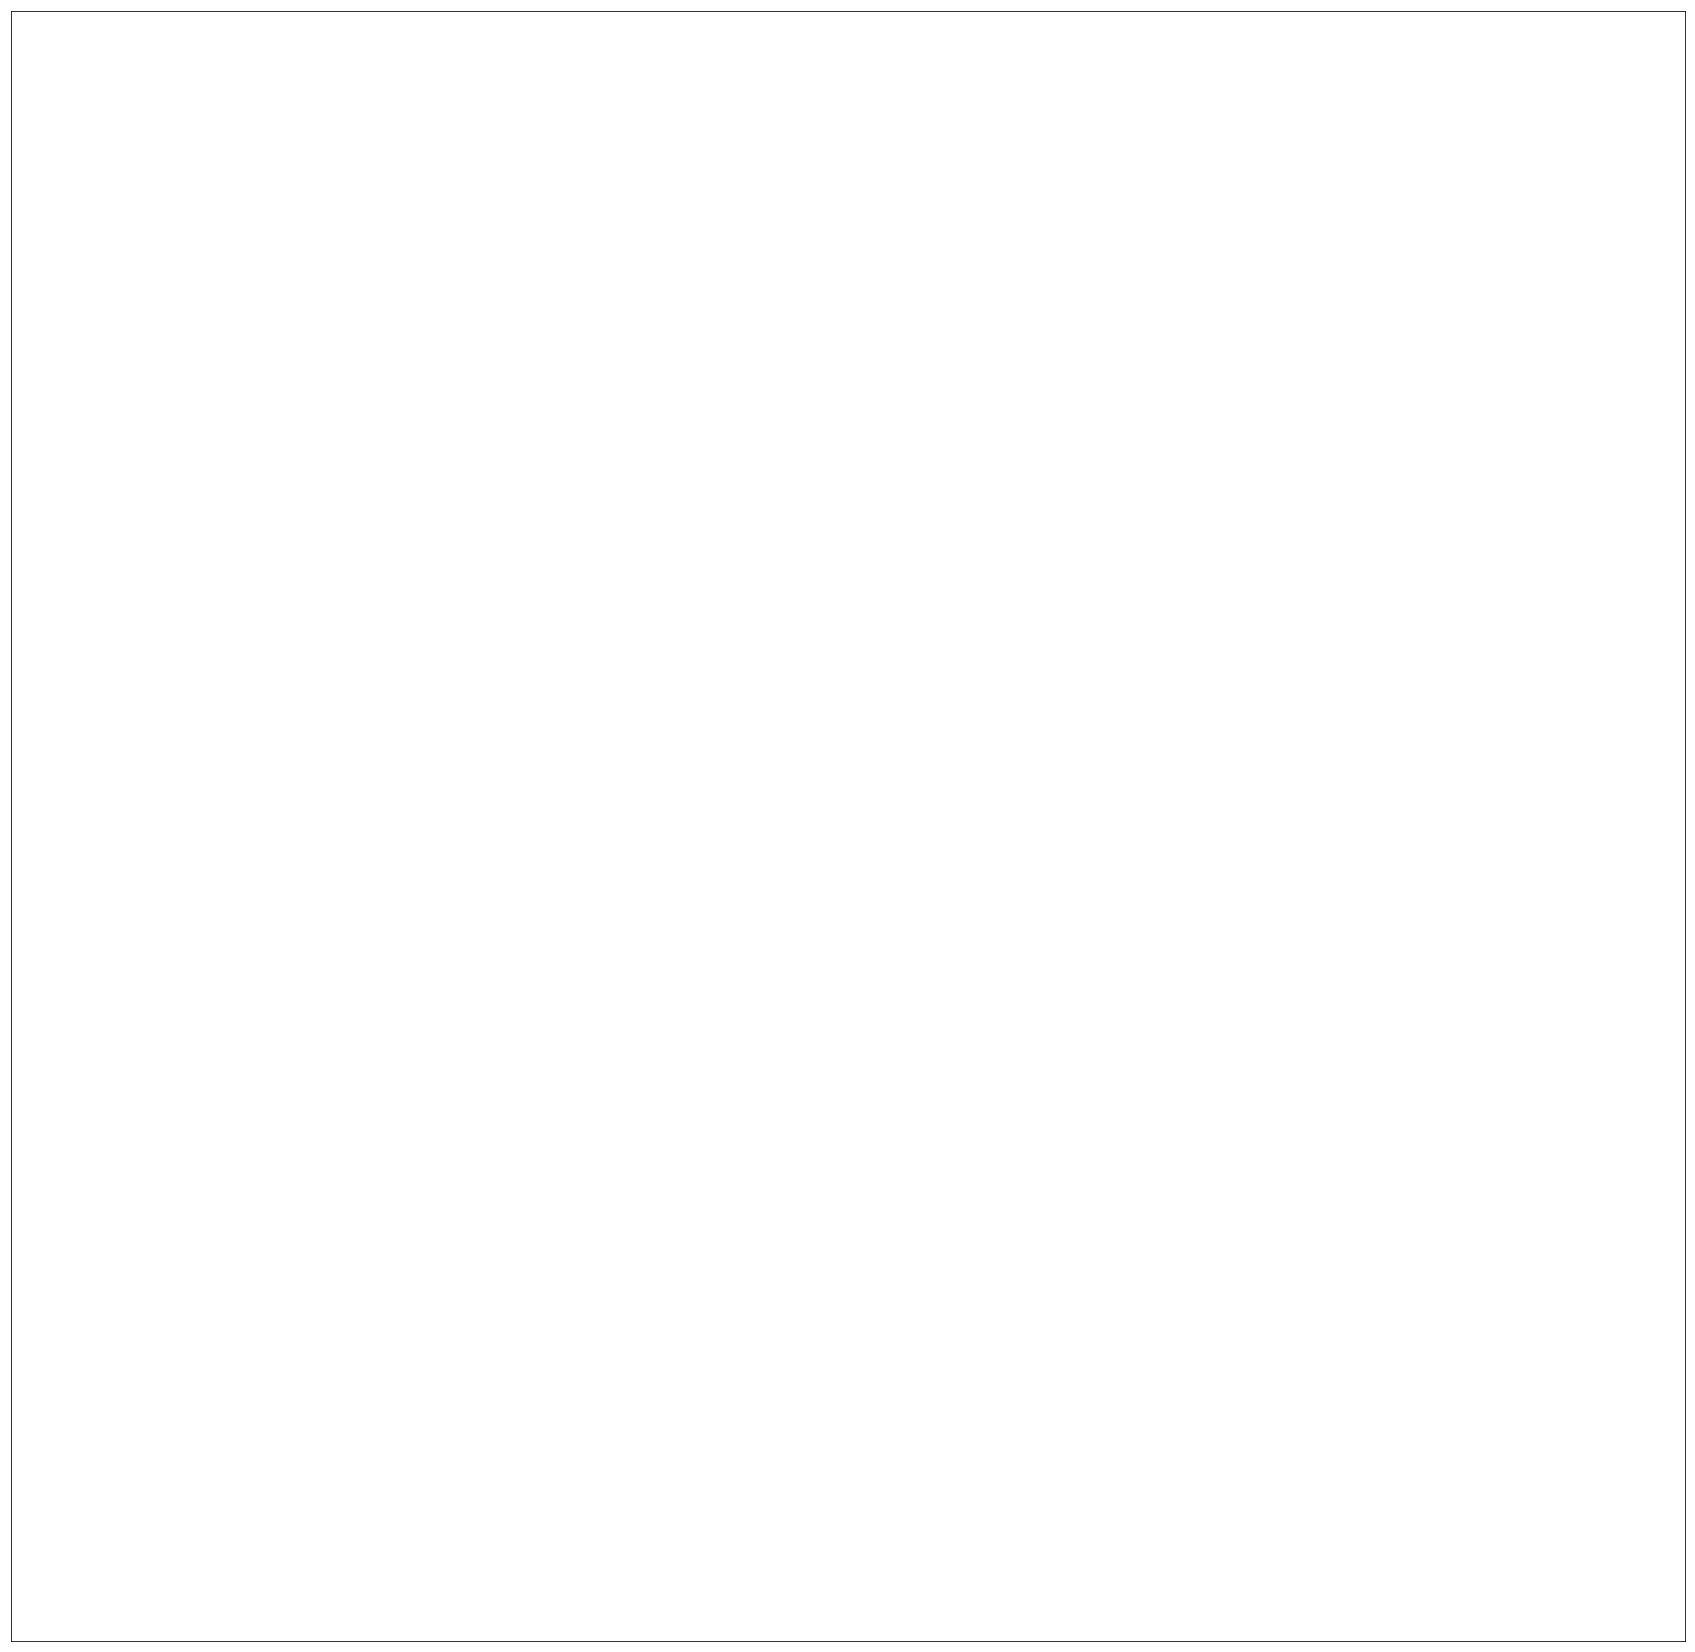

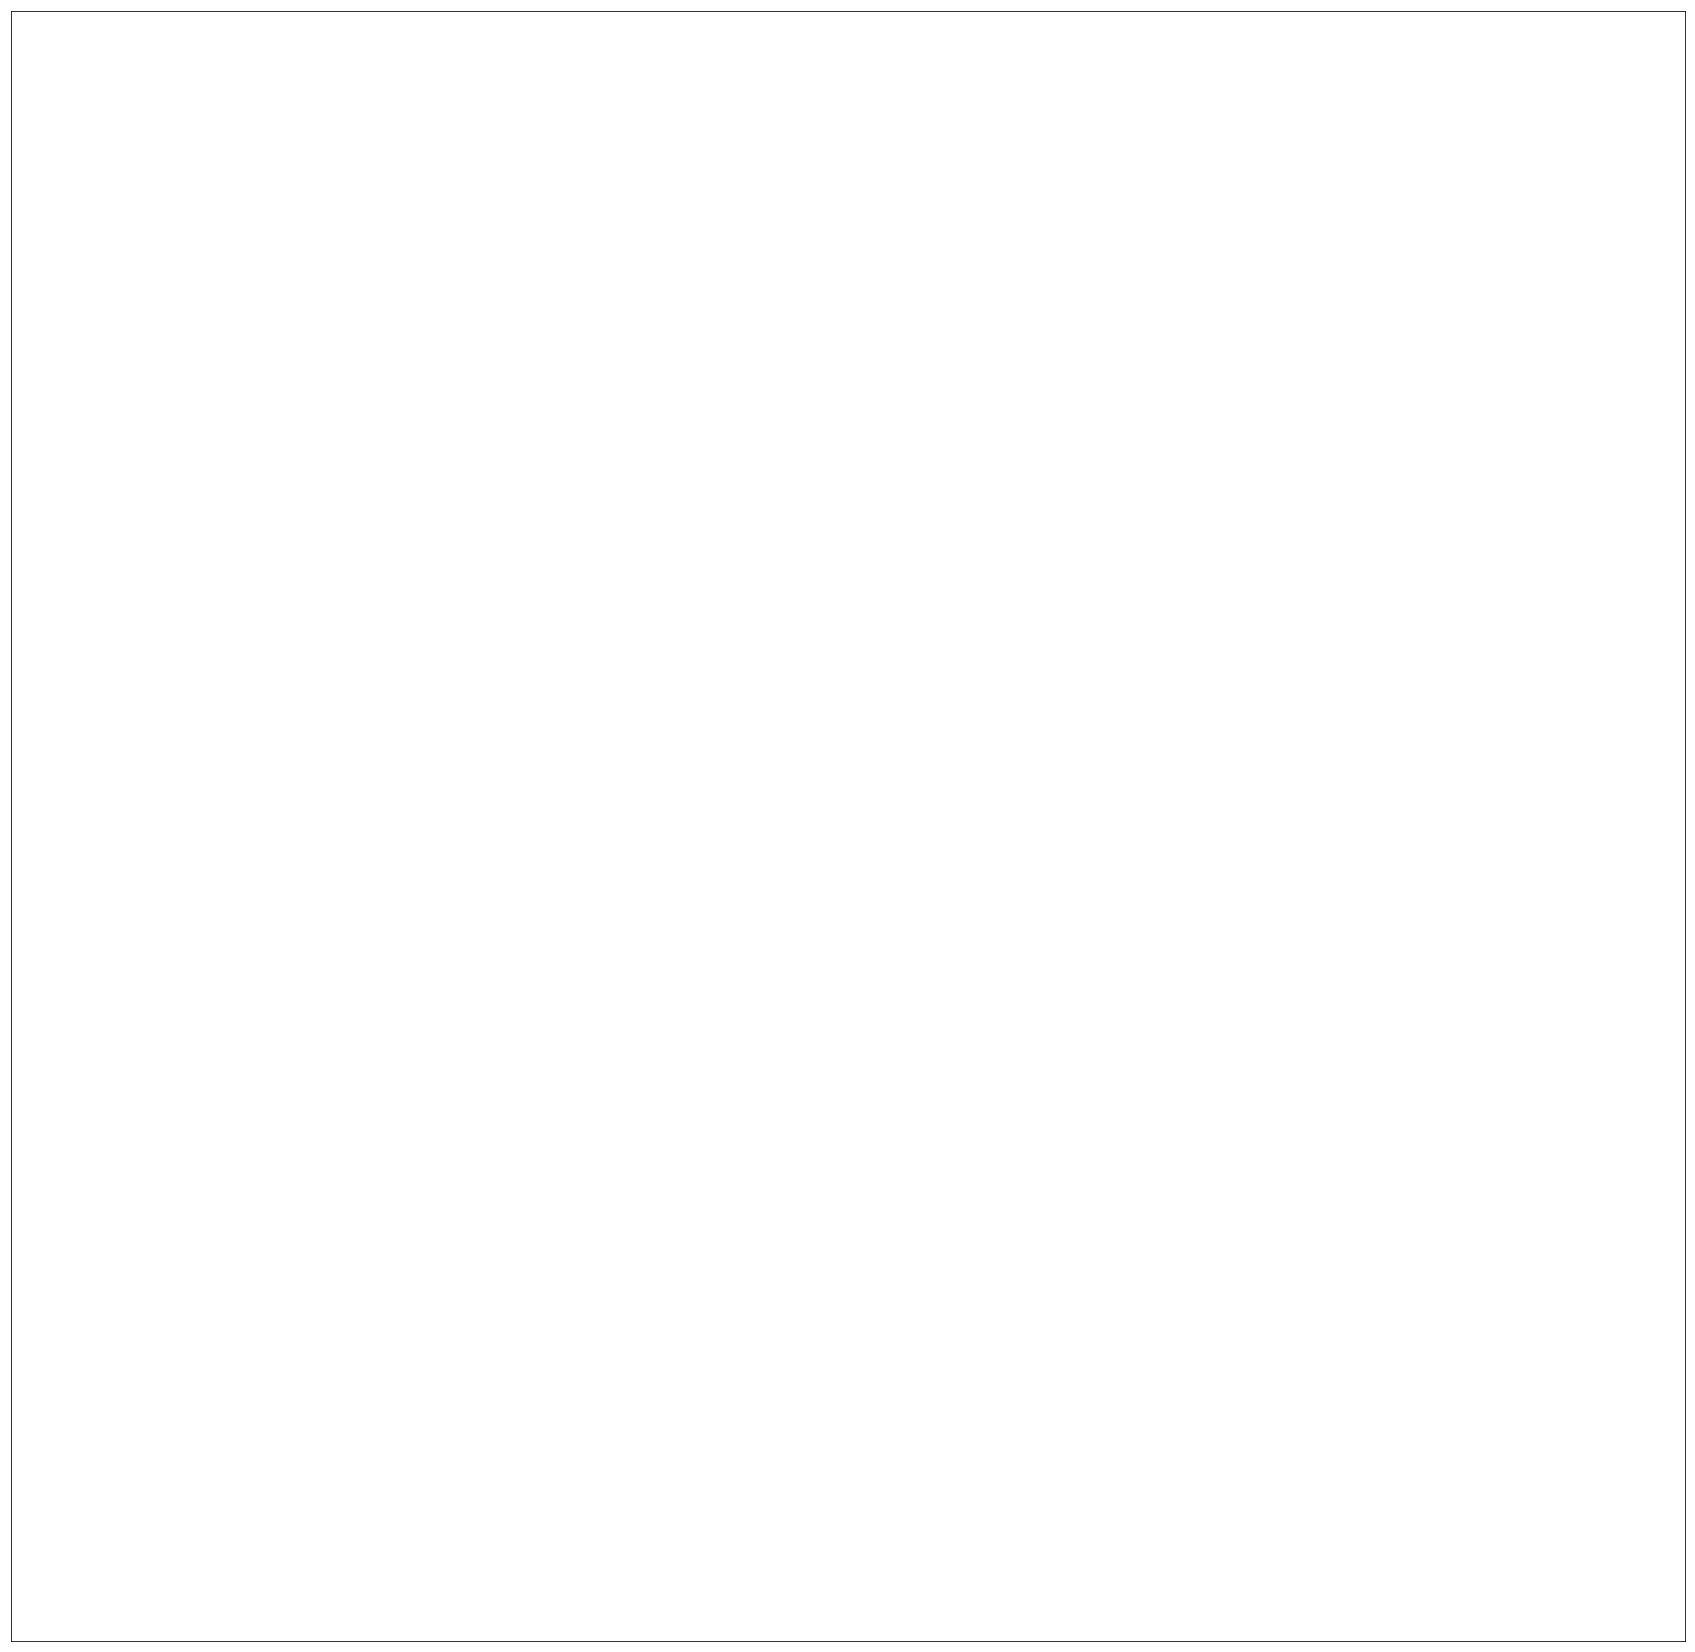

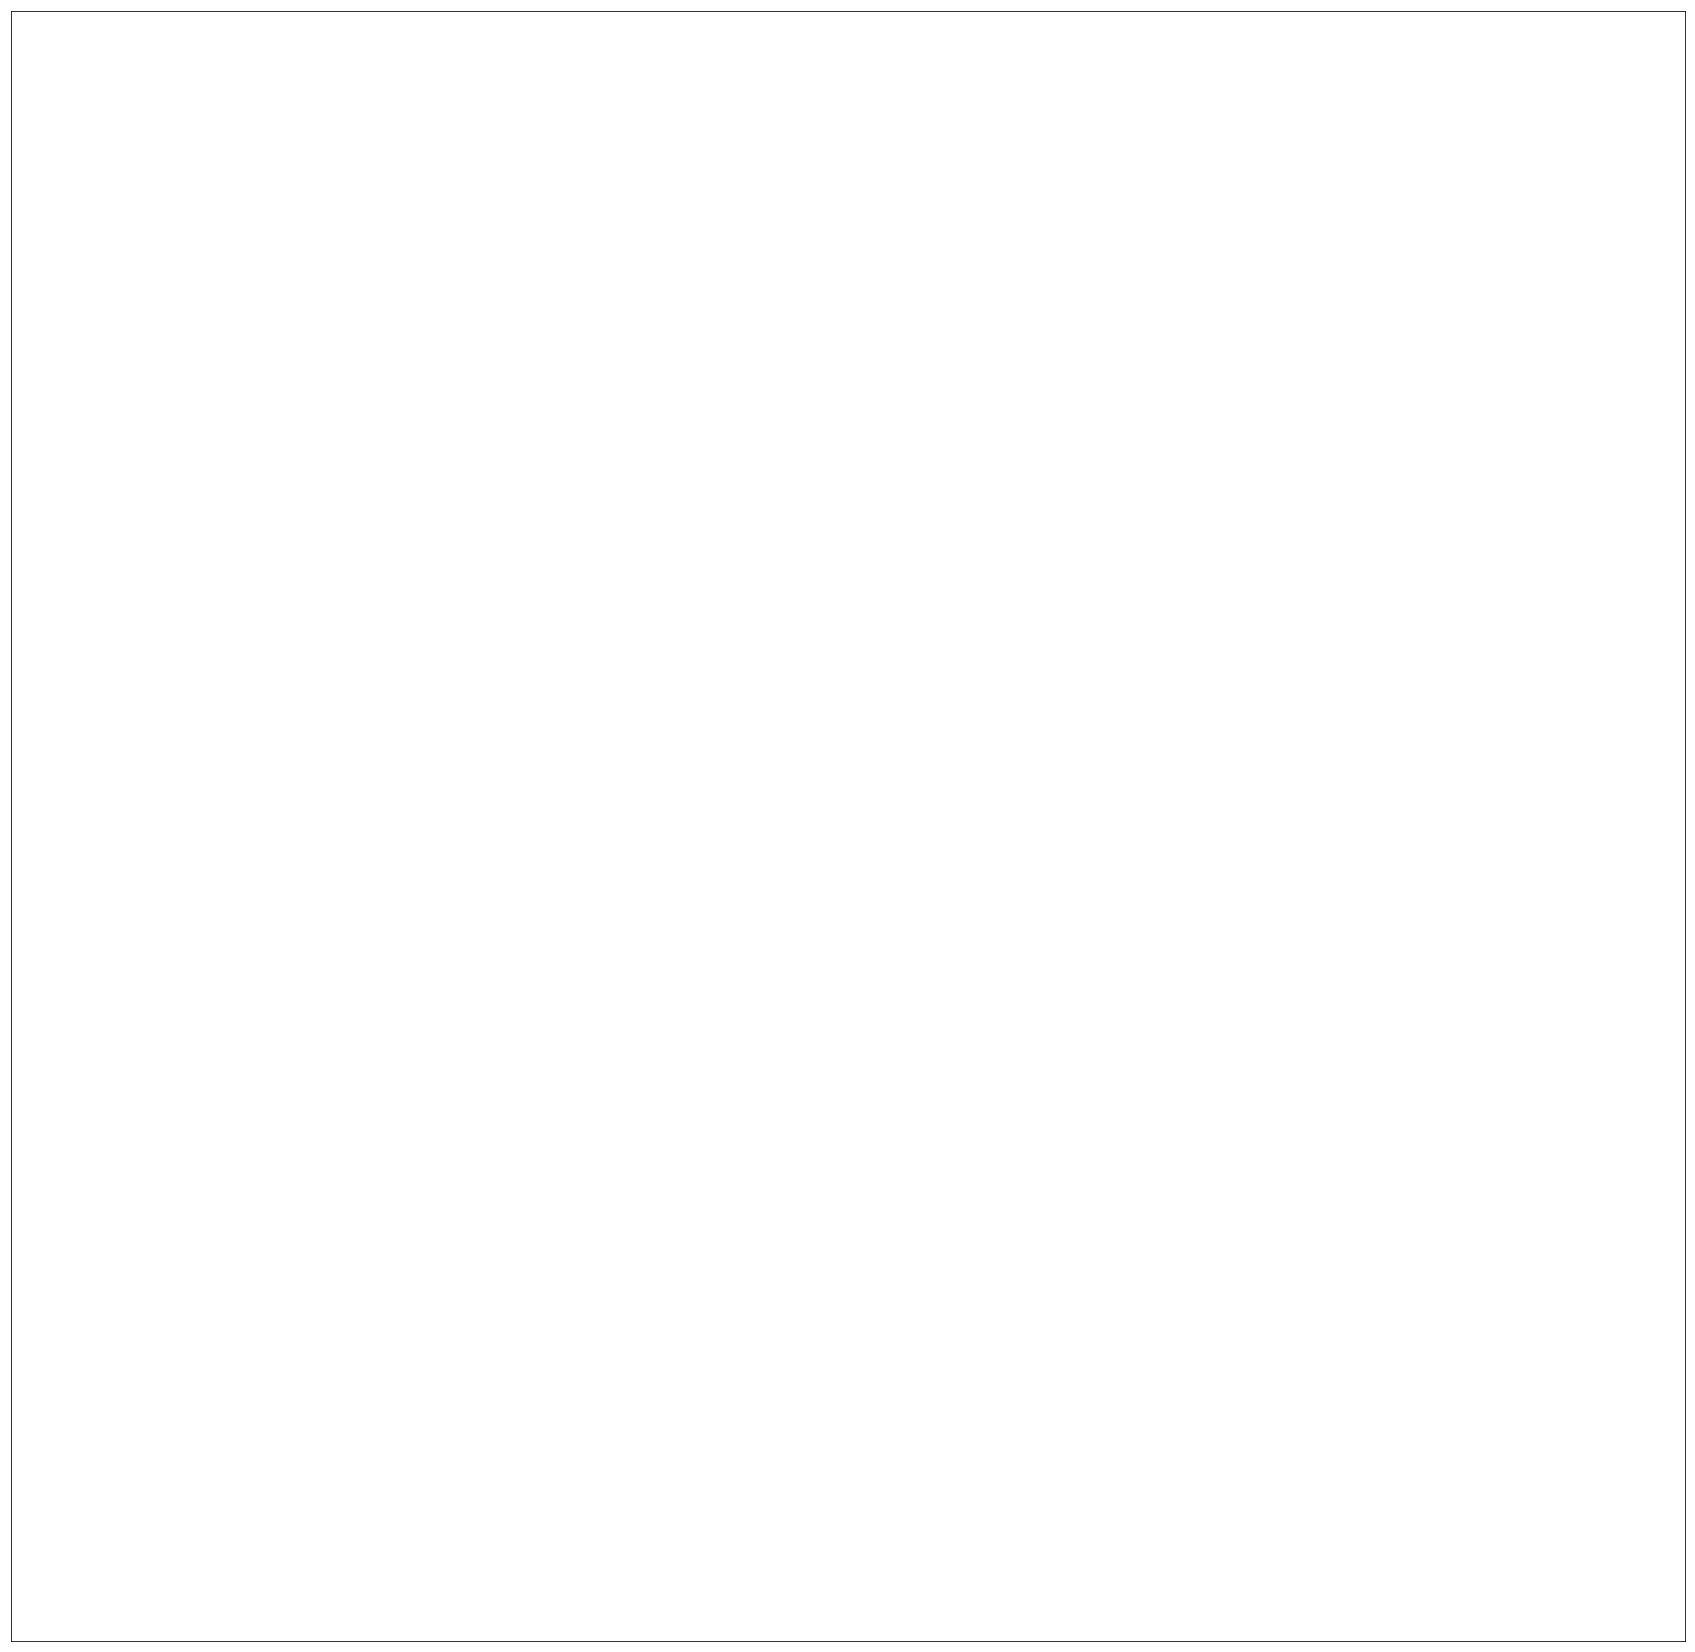

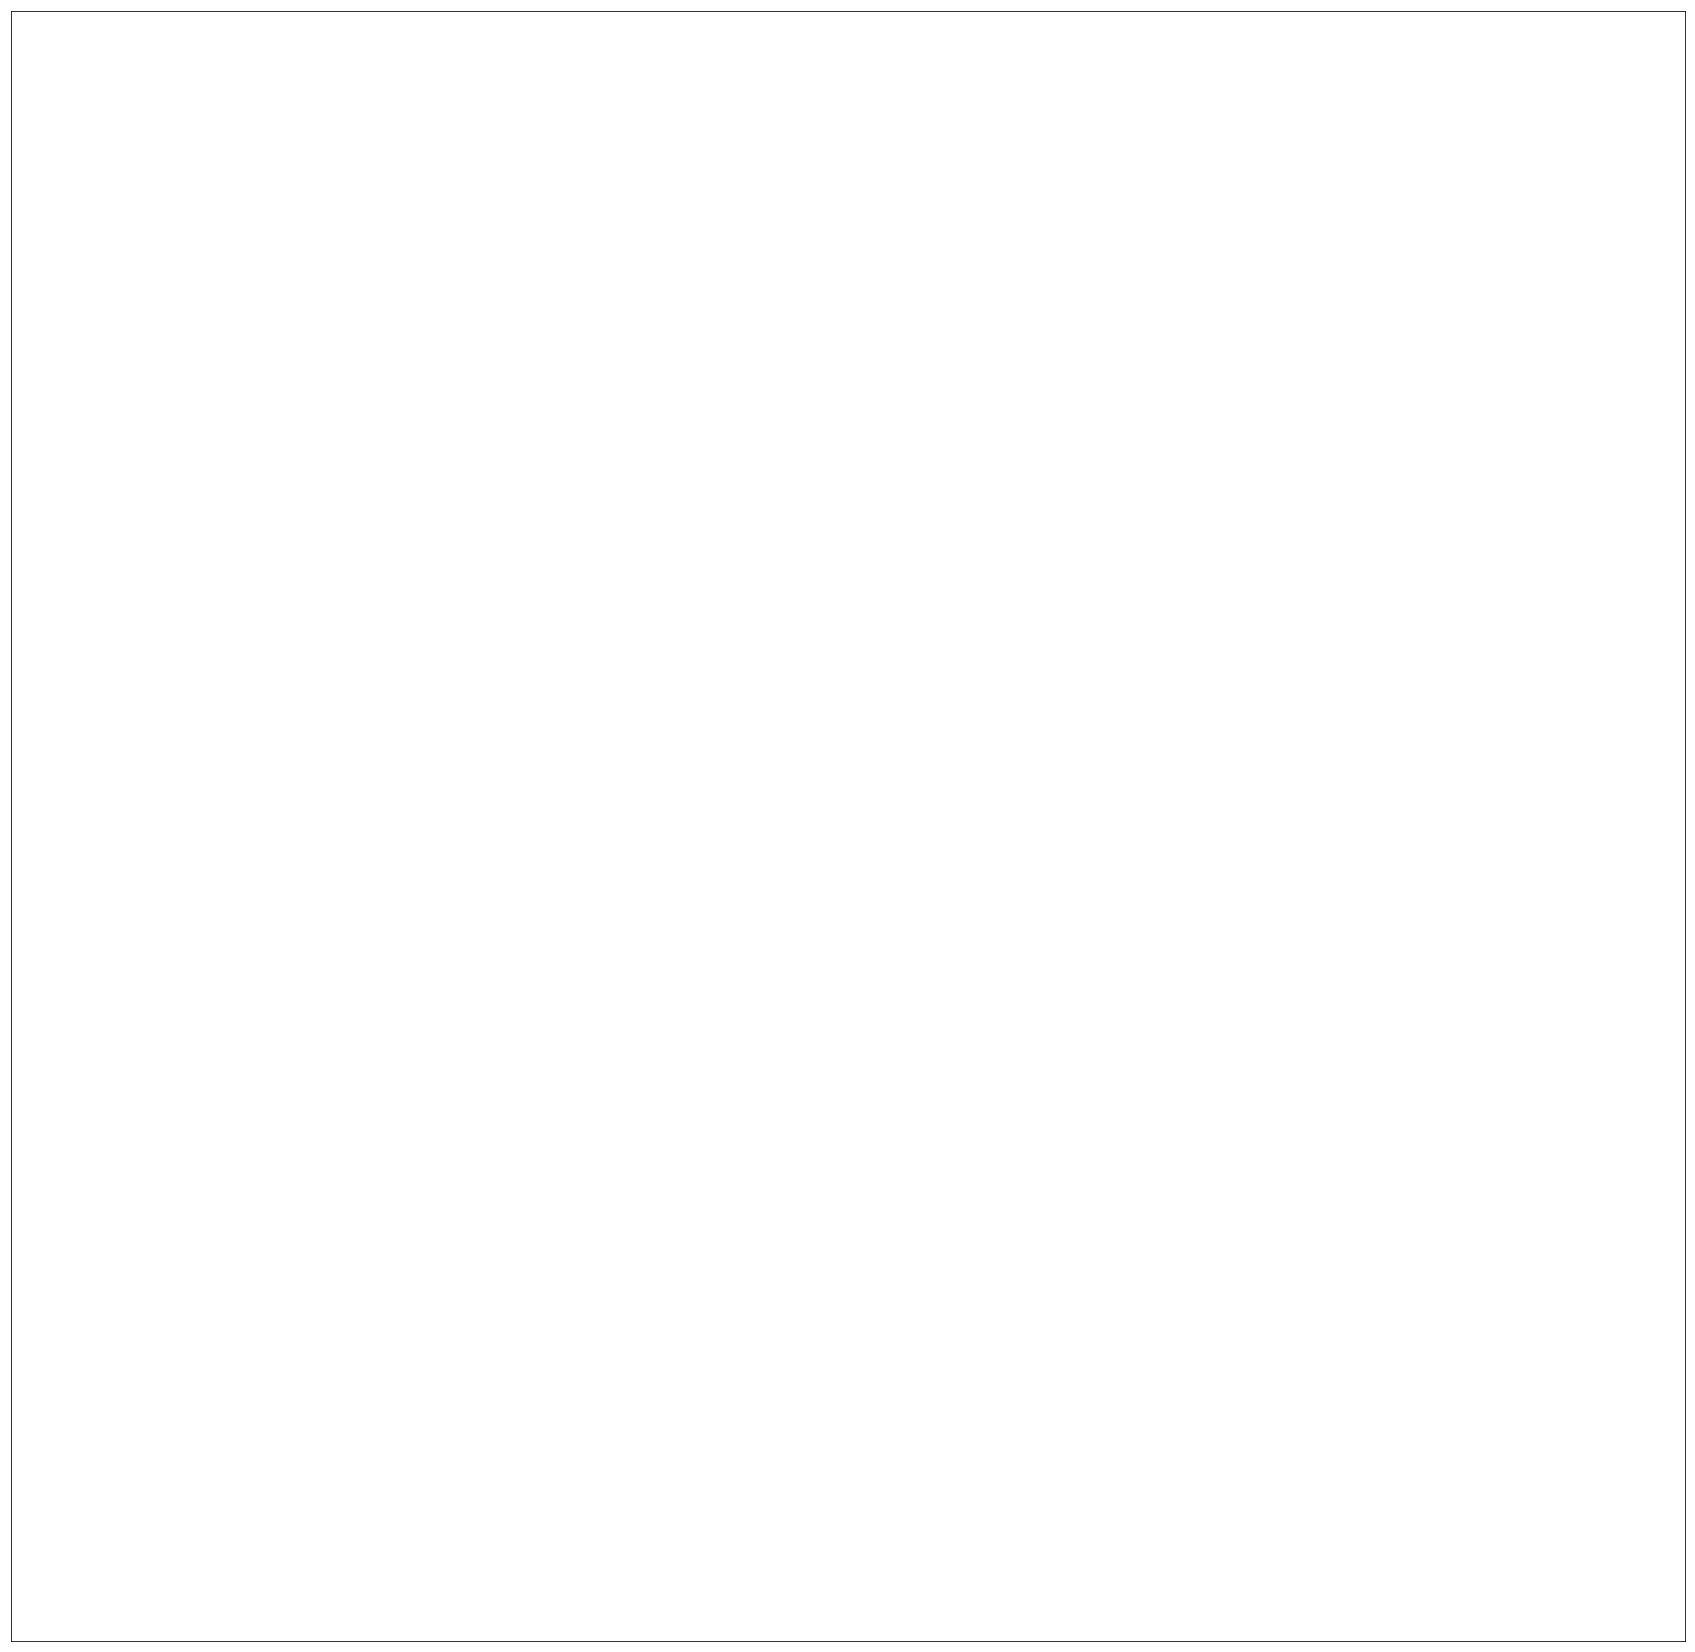

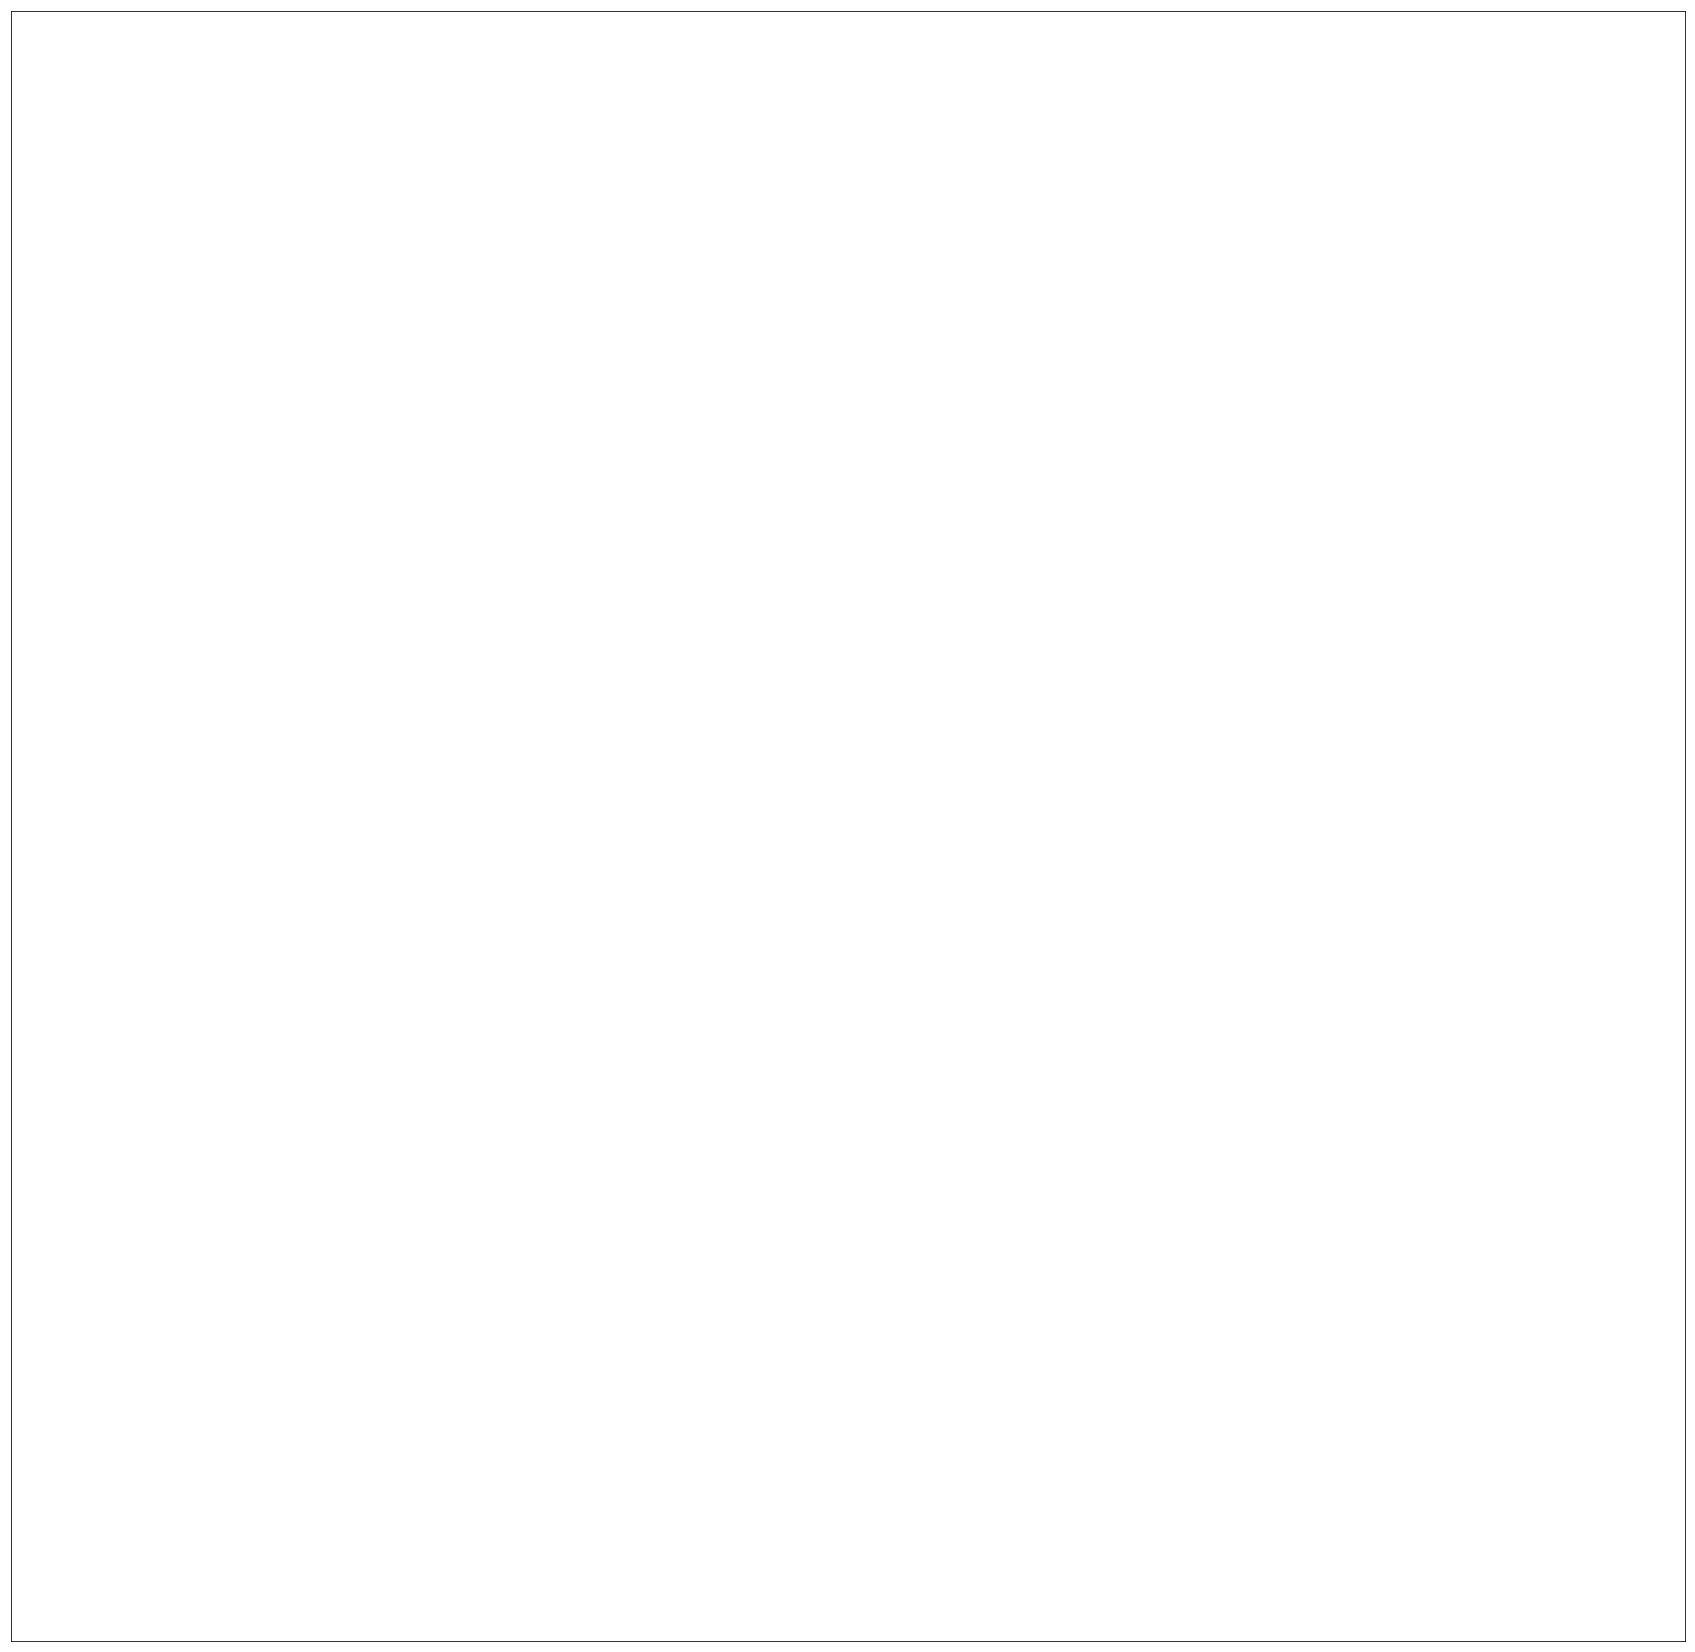

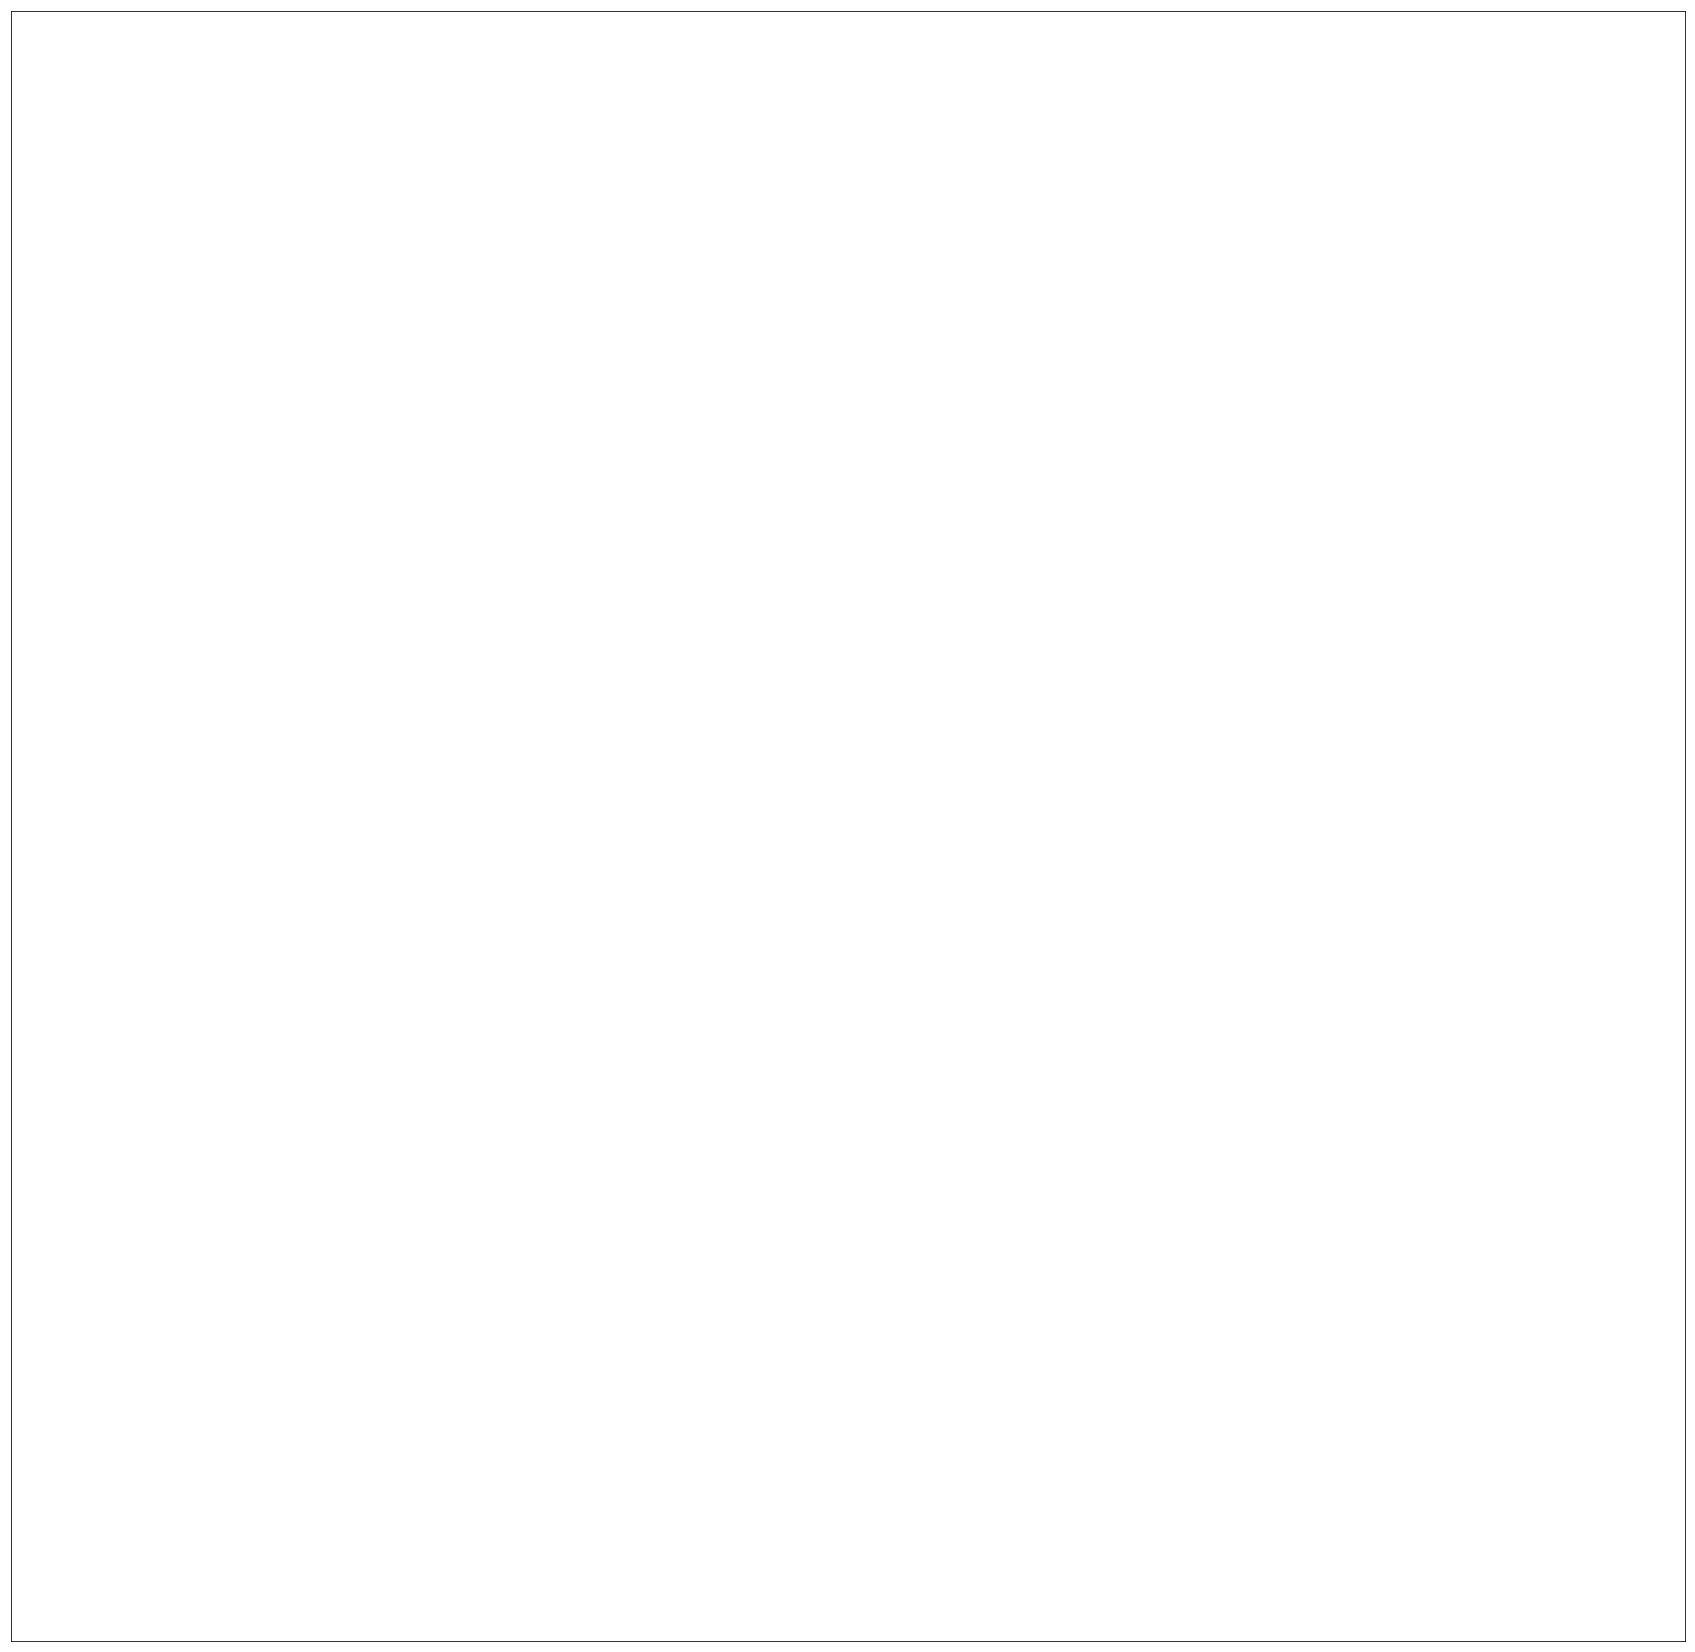

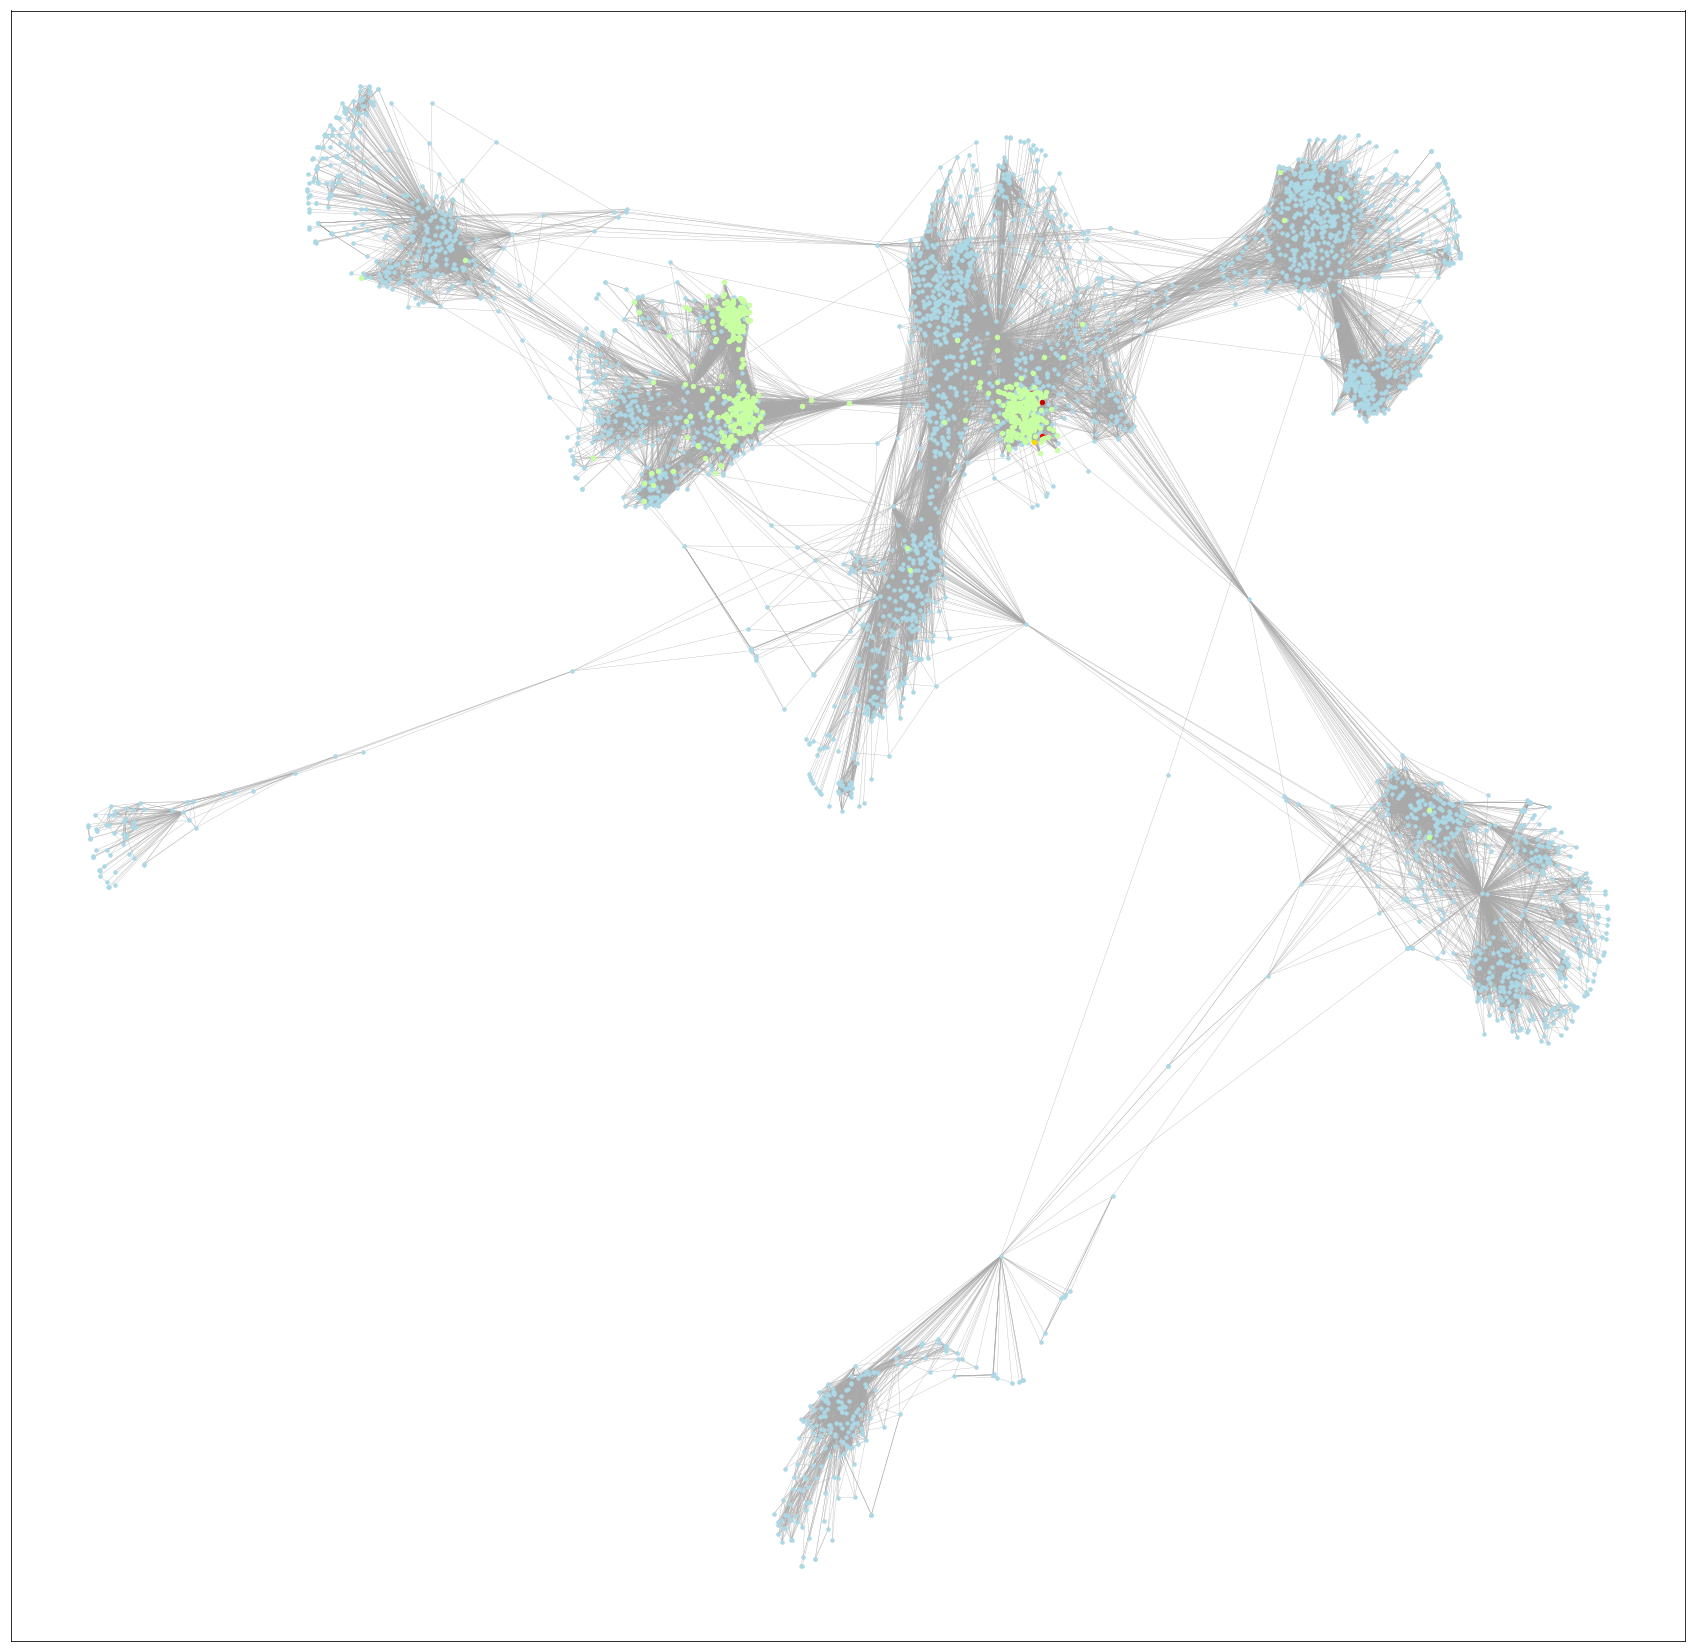

In [25]:
iteration = 0
for i in range(100):
    iteration += 1
    run_iteration(T_1, test="random")
    plt.cla()
    plt.figure(figsize=(30,30)) 
    size=12
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'S'],
                           node_color="#add8e6", node_size=size)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'E'],
                           node_color="#FFD700", node_size=20)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'I'],
                           node_color="#FF0000", node_size=20)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'R'],
                           node_color="#C8FFA2", node_size=20)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'H'],
                           node_color="#CC0000", node_size=20)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'D'],
                           node_color="#800000", node_size=20)
    nx.draw_networkx_edges(T_1,pos,edge_color='#A9A9A9', width=0.3)
    plt.savefig("no_testing_" + str(iteration) + ".png")

In [39]:
# Store the number of infections

no_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(100)])
random_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(100)])
connect_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(50)])
infected_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(50)])

# Run each model for 50 time steps
print("Starting the no testing model")
for j in range(50):
    infected_num = []
    T = G.copy()
    first_infected = random.sample(list(T.nodes()), 10)
    for infected in first_infected:
        T.nodes[infected]["status"] = "I"
        T.nodes[infected]["days_since_E"] = 0
        T.nodes[infected]["days_since_I"] = 0
    for i in range(50):
        I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
        infected_num.append(len(I_n))
        run_iteration(T)
    no_test_df[j] = infected_num
    if j % 10 ==0:
        print("done", j, "iter")

print("Starting the random testing model")
for j in range(50):
    infected_num_random = []
    T_1 = G.copy() 
    first_infected = random.sample(list(T_1.nodes()), 10)
    for i in first_infected:
        T_1.nodes[i]["status"] = "I"
        T_1.nodes[i]["days_since_E"] = 0
        T_1.nodes[i]["days_since_I"] = 0
    for i in range(50):
        I_n = [n for n,v in T_1.nodes(data=True) if v['status'] == 'I']
        infected_num_random.append(len(I_n))
        run_iteration(T_1, "random")
    random_test_df[j] = infected_num_random
    if j % 10 ==0:
        print("done", j, "iter")

print("Starting the testing highly connected people model")
for j in range(10):
    infected_num_connect = []
    T_2 = G.copy()
    first_infected = random.sample(list(T_2.nodes()), 10)
    for i in first_infected:
        T_2.nodes[i]["status"] = "I"
        T_2.nodes[i]["days_since_E"] = 0
        T_2.nodes[i]["days_since_I"] = 0
        T_2.nodes[i]["onset of symptoms"] = random.normalvariate(5, 2.5)
    for i in range(50):
        I_n = [n for n,v in T_2.nodes(data=True) if v['status'] == 'I']
        infected_num_connect.append(len(I_n))
        run_iteration(T_2, "high_connect")
    connect_test_df[j] = infected_num_connect
    if j % 10 ==0:
        print("done", j, "iter")
        
print("Starting the testing most infected people model")
for j in range(50):
    infected_num_infect = []
    T_4 = G.copy()
    first_infected = random.sample(list(T_4.nodes()), 10)
    for i in first_infected:
        T_4.nodes[i]["status"] = "I"
        T_4.nodes[i]["days_since_E"] = 0
        T_4.nodes[i]["days_since_I"] = 0
    for i in range(50):
        I_n = [n for n,v in T_4.nodes(data=True) if v['status'] == 'I']
        infected_num_infect.append(len(I_n))
        run_iteration(T_4, "most_infected")
    infected_test_df[j] = infected_num_infect
    if j % 10 ==0:
        print("done", j, "iter")
        
#TODO: This one takes a long time to run because we are finding the cliques each time,
# instead we should probably change it so we find the cliques once, store it globally 
# or pass it into the function as a parameter to speed up runtime
        
# for i in range(1):
#     I_n = [n for n,v in T_3.nodes(data=True) if v['status'] == 'I']
#     infected_num_family.append(len(I_n))
#     run_iteration(T_3, "pool_family")

Starting the testing highly connected people model
done 0 iter


In [39]:
no_test_df.to_csv("simulations/no_test_infected_quarentine.csv")
random_test_df.to_csv("simulations/random_test_infected_quarentine.csv")
connect_test_df.to_csv("simulations/connect_norm_test_infected_quarentine.csv")
infected_test_df.to_csv("simulations/infected_test_infected_quarentine.csv")

In [ ]:
S_n = [n for n,v in T.nodes(data=True) if v['status'] == 'S']
E_n = [n for n,v in T.nodes(data=True) if v['status'] == 'E']
I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
H_n = [n for n,v in T.nodes(data=True) if v['status'] == 'H']

In [ ]:
print(E_n)
print(I_n)
print(H_n)

In [ ]:
plt.plot([i for i in range(50)], infected_num[0:50], label = "Untested")
plt.plot([i for i in range(50)], infected_num_random[0:50], label = "Random testing")
plt.plot([i for i in range(50)], infected_num_connect[0:50], label = "Highest Connected testing")
plt.plot([i for i in range(50)], infected_num_infect[0:50], label = "Most Infected testing")

plt.legend()
plt.show()

In [ ]:
len(test_strat_most_infected(T,50))

In [ ]:
print("Starting the testing most infected people model")
for j in range(5):
    infected_num_infect = []
    T_4 = G.copy()
    first_infected = random.sample(list(T_4.nodes()), 10)
    for i in first_infected:
        T_4.nodes[i]["status"] = "I"
        T_4.nodes[i]["days_since_E"] = 0
        T_4.nodes[i]["days_since_I"] = 0
    for i in range(50):
        I_n = [n for n,v in T_4.nodes(data=True) if v['status'] == 'I']
        infected_num_infect.append(len(I_n))
        run_iteration(T_4, "most_infected")
    infected_test_df[j] = infected_num_infect
    if j % 1 ==0:
        print("done", j, "iter")